In [63]:
!nvidia-smi

Wed Feb 14 10:16:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   30C    P8              20W / 215W |   2843MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [62]:
del model
gc.collect()

17

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/heartsound/'

In [8]:
sr = 4000

In [9]:
x_train = np.load(f'{data_dir}preprocessed/heartsound.audio4k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}preprocessed/heartsound.audio4k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}preprocessed/heartsound.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}preprocessed/heartsound.labels_binary.test.npy', allow_pickle=True)

In [10]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [11]:
batch_size = 4
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [12]:
from IConNet.nn.model import M10

In [13]:
from omegaconf import OmegaConf as ocf

In [14]:
model_config_path = 'config/model/m10.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M10', 'description': 'gated residual FirConv', 'fe': {'n_block': 2, 'n_channel': [64, 64], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'pooling': 'max'}, 'cls': {'n_block': 2, 'n_hidden_dim': [128, 128]}}

In [15]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [16]:
from IConNet.visualizer import visualize_model

In [17]:
visualize_model.count_parameters(model)

79940

In [18]:
visualize_model.count_parameters(model.fe_blocks)

46016

In [19]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [21]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

In [28]:
layer.lowcut_bands.shape

torch.Size([128, 1])

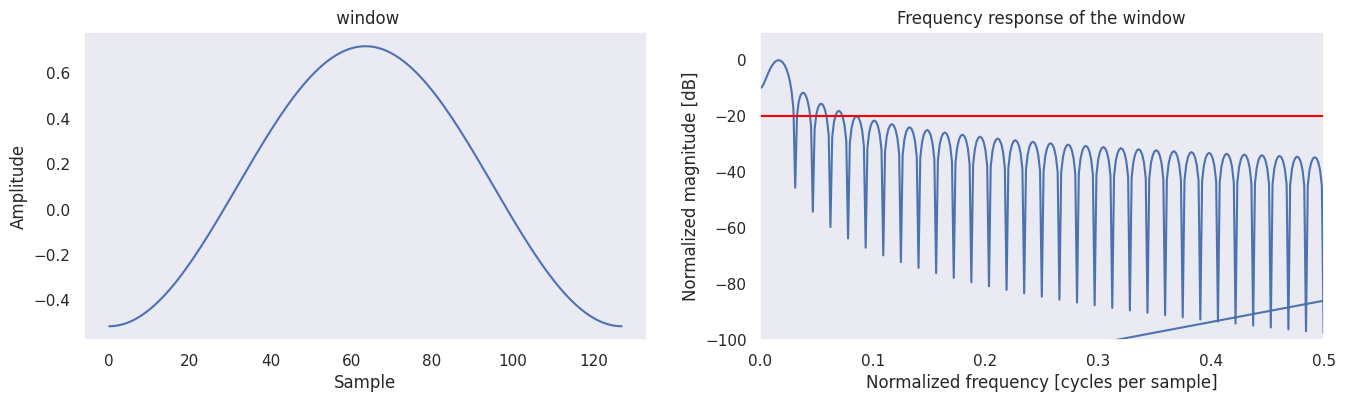

In [29]:
filtviz.visualize_one_window()

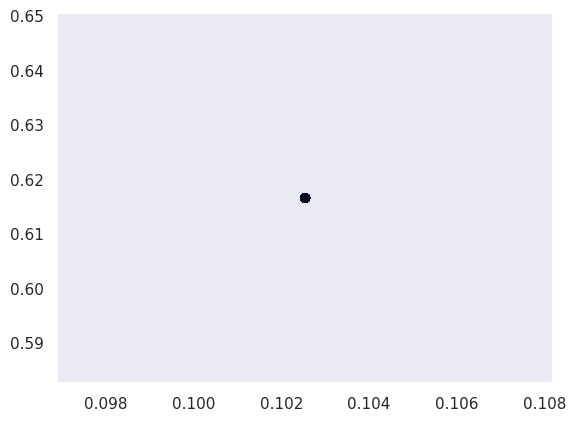

In [30]:
filtviz.visualize_window_params()

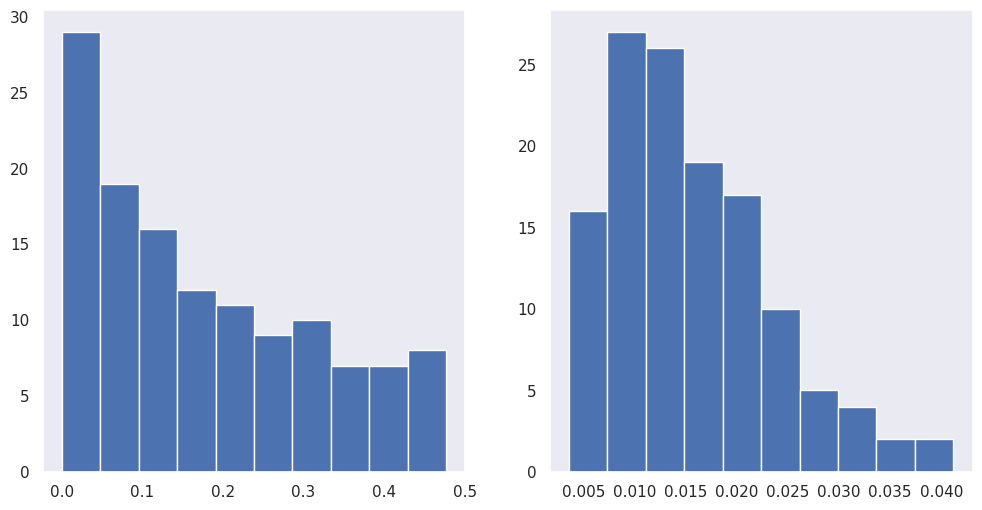

In [31]:
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


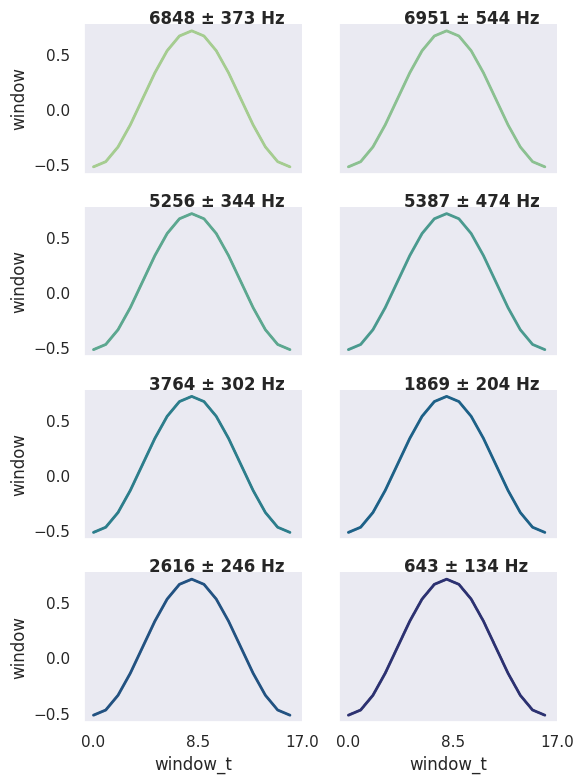

In [32]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


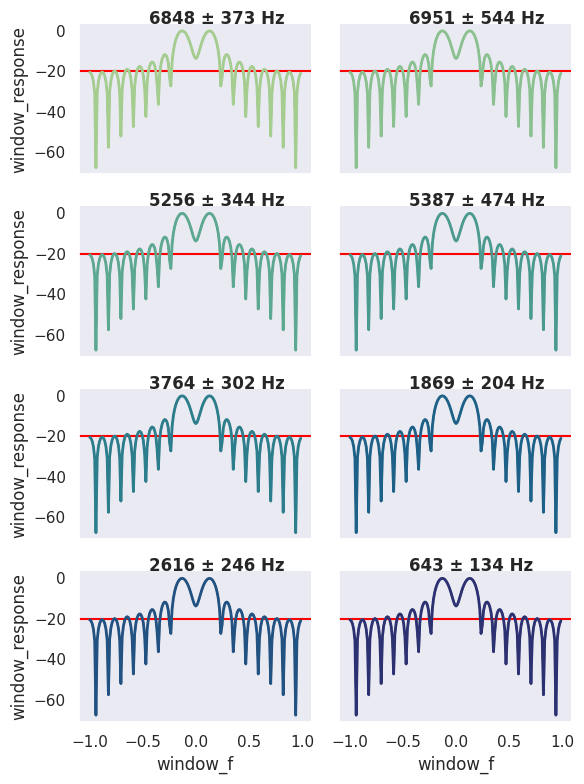

In [33]:
filtviz.visualize_filters(filter_domain='freq')

In [18]:
import traceback
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            # data = transform(data)
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [19]:
n_epoch = 500
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [21]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                                                     | 0/500 [00:00<?, ?it/s]/home/linh/projects/IConNet/IConNet/fftconv/fftconv.py:72: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:299.)
  y   = y.type(dtype)
  0%|                                                                       | 0.006993006993006993/500 [00:00<12:26:47, 89.62s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.719898


  0%|                                                                          | 0.3566433566433563/500 [00:20<7:51:16, 56.59s/it]

Train Epoch: 1 [400/913 (11%)]	Loss: 0.192515


  0%|                                                                          | 0.7062937062937085/500 [00:40<7:56:51, 57.30s/it]

Train Epoch: 1 [800/913 (22%)]	Loss: 0.568040


  0%|                                                                          | 0.7972027972028006/500 [00:45<7:47:38, 56.21s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  0%|                                                                          | 0.8006993006993042/500 [00:45<9:06:32, 65.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  0%|▏                                                                         | 1.0000000000000062/500 [00:55<7:01:31, 50.68s/it]


Test Epoch: 1	Accuracy: 163/229 (71%)

Train Epoch: 2 [0/913 (0%)]	Loss: 0.591895


  0%|▏                                                                         | 1.3531468531468642/500 [01:15<7:59:25, 57.69s/it]

Train Epoch: 2 [400/913 (11%)]	Loss: 0.359703


  0%|▎                                                                         | 1.7027972027972187/500 [01:35<7:38:24, 55.20s/it]

Train Epoch: 2 [800/913 (22%)]	Loss: 0.690852


  0%|▎                                                                         | 1.7937062937063109/500 [01:40<7:43:58, 55.88s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  0%|▎                                                                         | 1.7972027972028144/500 [01:40<8:55:20, 64.47s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  0%|▎                                                                         | 1.9965034965035164/500 [01:50<7:00:05, 50.61s/it]


Test Epoch: 2	Accuracy: 161/229 (70%)

Train Epoch: 3 [0/913 (0%)]	Loss: 0.986364


  0%|▎                                                                         | 2.3496503496503522/500 [02:10<7:38:24, 55.27s/it]

Train Epoch: 3 [400/913 (11%)]	Loss: 0.036036


  1%|▍                                                                         | 2.6993006993006845/500 [02:29<7:39:28, 55.44s/it]

Train Epoch: 3 [800/913 (22%)]	Loss: 0.447754


  1%|▍                                                                          | 2.790209790209771/500 [02:34<7:46:16, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  1%|▍                                                                          | 2.793706293706274/500 [02:35<8:57:24, 64.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  1%|▍                                                                         | 2.9930069930069636/500 [02:44<7:03:58, 51.18s/it]


Test Epoch: 3	Accuracy: 152/229 (66%)

Train Epoch: 4 [0/913 (0%)]	Loss: 1.595073


  1%|▌                                                                          | 3.346153846153799/500 [03:04<7:43:16, 55.97s/it]

Train Epoch: 4 [400/913 (11%)]	Loss: 1.071941


  1%|▌                                                                         | 3.6958041958041314/500 [03:24<7:43:01, 55.98s/it]

Train Epoch: 4 [800/913 (22%)]	Loss: 0.962140


  1%|▌                                                                          | 3.786713286713218/500 [03:29<7:49:52, 56.82s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  1%|▌                                                                          | 3.790209790209721/500 [03:30<8:55:57, 64.81s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  1%|▌                                                                         | 3.9895104895104105/500 [03:39<7:02:41, 51.13s/it]


Test Epoch: 4	Accuracy: 169/229 (74%)

Train Epoch: 5 [0/913 (0%)]	Loss: 0.472318


  1%|▋                                                                          | 4.342657342657247/500 [03:59<7:44:31, 56.23s/it]

Train Epoch: 5 [400/913 (11%)]	Loss: 0.237217


  1%|▋                                                                          | 4.692307692307579/500 [04:19<7:43:03, 56.09s/it]

Train Epoch: 5 [800/913 (22%)]	Loss: 0.264702


  1%|▋                                                                          | 4.783216783216665/500 [04:25<7:43:16, 56.13s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  1%|▋                                                                         | 4.7867132867131685/500 [04:25<8:53:06, 64.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  1%|▋                                                                          | 4.986013986013858/500 [04:34<7:12:28, 52.42s/it]


Test Epoch: 5	Accuracy: 167/229 (73%)

Train Epoch: 6 [0/913 (0%)]	Loss: 0.050304


  1%|▊                                                                         | 5.3391608391606935/500 [04:54<7:47:06, 56.66s/it]

Train Epoch: 6 [400/913 (11%)]	Loss: 0.206567


  1%|▊                                                                          | 5.688811188811026/500 [05:14<7:52:32, 57.36s/it]

Train Epoch: 6 [800/913 (22%)]	Loss: 0.123529


  1%|▊                                                                          | 5.779720279720112/500 [05:19<7:41:11, 55.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  1%|▊                                                                         | 5.7832167832166155/500 [05:19<8:50:24, 64.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  1%|▉                                                                          | 5.982517482517305/500 [05:29<6:57:56, 50.76s/it]


Test Epoch: 6	Accuracy: 155/229 (68%)

Train Epoch: 7 [0/913 (0%)]	Loss: 0.034968


  1%|▉                                                                         | 6.3356643356641404/500 [05:49<7:33:58, 55.18s/it]

Train Epoch: 7 [400/913 (11%)]	Loss: 0.759369


  1%|█                                                                          | 6.685314685314473/500 [06:08<7:33:26, 55.15s/it]

Train Epoch: 7 [800/913 (22%)]	Loss: 0.572067


  1%|█                                                                          | 6.776223776223559/500 [06:14<7:40:49, 56.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  1%|█                                                                          | 6.779720279720062/500 [06:14<8:48:10, 64.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  1%|█                                                                         | 6.9755244755242485/500 [06:23<6:32:02, 47.71s/it]


Test Epoch: 7	Accuracy: 169/229 (74%)



  1%|█                                                                          | 6.982517482517255/500 [06:24<7:06:59, 51.96s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.072988


  1%|█                                                                          | 7.332167832167587/500 [06:43<7:33:50, 55.27s/it]

Train Epoch: 8 [400/913 (11%)]	Loss: 1.527605


  2%|█▏                                                                          | 7.68181818181792/500 [07:03<7:32:30, 55.15s/it]

Train Epoch: 8 [800/913 (22%)]	Loss: 1.331691


  2%|█▏                                                                         | 7.772727272727006/500 [07:08<7:38:38, 55.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  2%|█▏                                                                         | 7.776223776223509/500 [07:08<8:45:16, 64.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  2%|█▏                                                                         | 7.975524475524199/500 [07:18<6:54:21, 50.53s/it]


Test Epoch: 8	Accuracy: 175/229 (76%)

Train Epoch: 9 [0/913 (0%)]	Loss: 0.417852


  2%|█▏                                                                         | 8.328671328671035/500 [07:38<7:31:39, 55.12s/it]

Train Epoch: 9 [400/913 (11%)]	Loss: 0.038835


  2%|█▎                                                                         | 8.678321678321367/500 [07:57<7:31:27, 55.13s/it]

Train Epoch: 9 [800/913 (22%)]	Loss: 0.788737


  2%|█▎                                                                         | 8.769230769230454/500 [08:03<7:38:40, 56.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  2%|█▎                                                                         | 8.772727272726957/500 [08:03<8:45:53, 64.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  2%|█▎                                                                         | 8.972027972027647/500 [08:12<6:52:45, 50.44s/it]


Test Epoch: 9	Accuracy: 167/229 (73%)

Train Epoch: 10 [0/913 (0%)]	Loss: 1.106162


  2%|█▍                                                                         | 9.325174825174482/500 [08:32<7:33:33, 55.46s/it]

Train Epoch: 10 [400/913 (11%)]	Loss: 0.089840


  2%|█▍                                                                         | 9.674825174824814/500 [08:52<7:31:19, 55.23s/it]

Train Epoch: 10 [800/913 (22%)]	Loss: 0.614775


  2%|█▌                                                                           | 9.7657342657339/500 [08:57<7:38:05, 56.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  2%|█▍                                                                         | 9.769230769230404/500 [08:57<8:44:45, 64.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  2%|█▍                                                                         | 9.968531468531094/500 [09:07<6:57:30, 51.12s/it]


Test Epoch: 10	Accuracy: 181/229 (79%)

Train Epoch: 11 [0/913 (0%)]	Loss: 0.020010


  2%|█▌                                                                        | 10.321678321677929/500 [09:27<7:33:38, 55.59s/it]

Train Epoch: 11 [400/913 (11%)]	Loss: 0.780670


  2%|█▌                                                                        | 10.671328671328261/500 [09:47<7:39:25, 56.33s/it]

Train Epoch: 11 [800/913 (22%)]	Loss: 0.004028


  2%|█▌                                                                        | 10.762237762237348/500 [09:52<7:38:27, 56.23s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  2%|█▌                                                                        | 10.765734265733851/500 [09:52<8:45:36, 64.46s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  2%|█▋                                                                         | 10.96503496503454/500 [10:02<6:50:58, 50.42s/it]


Test Epoch: 11	Accuracy: 171/229 (75%)

Train Epoch: 12 [0/913 (0%)]	Loss: 0.119238


  2%|█▋                                                                        | 11.318181818181376/500 [10:21<7:33:50, 55.72s/it]

Train Epoch: 12 [400/913 (11%)]	Loss: 0.577362


  2%|█▋                                                                        | 11.667832167831708/500 [10:41<7:29:46, 55.26s/it]

Train Epoch: 12 [800/913 (22%)]	Loss: 0.185327


  2%|█▋                                                                        | 11.758741258740795/500 [10:46<7:42:32, 56.84s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  2%|█▋                                                                        | 11.762237762237298/500 [10:47<8:50:40, 65.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  2%|█▊                                                                        | 11.961538461537987/500 [10:56<6:55:33, 51.09s/it]


Test Epoch: 12	Accuracy: 182/229 (79%)

Train Epoch: 13 [0/913 (0%)]	Loss: 0.618415


  2%|█▊                                                                        | 12.314685314684823/500 [11:16<7:36:10, 56.12s/it]

Train Epoch: 13 [400/913 (11%)]	Loss: 0.127518


  3%|█▊                                                                        | 12.664335664335155/500 [11:36<7:35:33, 56.09s/it]

Train Epoch: 13 [800/913 (22%)]	Loss: 0.201934


  3%|█▉                                                                        | 12.755244755244242/500 [11:42<7:42:03, 56.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  3%|█▉                                                                        | 12.758741258740745/500 [11:42<8:56:22, 66.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  3%|█▉                                                                        | 12.954545454544931/500 [11:51<6:36:54, 48.90s/it]


Test Epoch: 13	Accuracy: 167/229 (73%)



  3%|█▉                                                                        | 12.961538461537938/500 [11:52<6:52:49, 50.86s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.665610


  3%|█▉                                                                         | 13.31118881118827/500 [12:12<7:28:11, 55.25s/it]

Train Epoch: 14 [400/913 (11%)]	Loss: 0.023646


  3%|██                                                                        | 13.660839160838602/500 [12:31<7:26:45, 55.12s/it]

Train Epoch: 14 [800/913 (22%)]	Loss: 0.019031


  3%|██                                                                        | 13.751748251747689/500 [12:36<7:36:32, 56.34s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  3%|██                                                                        | 13.755244755244192/500 [12:37<8:43:40, 64.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  3%|██                                                                        | 13.954545454544881/500 [12:46<6:58:23, 51.65s/it]


Test Epoch: 14	Accuracy: 187/229 (82%)

Train Epoch: 15 [0/913 (0%)]	Loss: 0.099483


  3%|██                                                                        | 14.307692307691717/500 [13:06<7:37:05, 56.47s/it]

Train Epoch: 15 [400/913 (11%)]	Loss: 0.017692


  3%|██▏                                                                       | 14.657342657342049/500 [13:26<7:39:07, 56.76s/it]

Train Epoch: 15 [800/913 (22%)]	Loss: 0.349435


  3%|██▏                                                                       | 14.748251748251135/500 [13:31<7:41:06, 57.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  3%|██▏                                                                       | 14.751748251747639/500 [13:31<8:45:48, 65.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  3%|██▏                                                                       | 14.951048951048328/500 [13:41<6:47:02, 50.35s/it]


Test Epoch: 15	Accuracy: 177/229 (77%)

Train Epoch: 16 [0/913 (0%)]	Loss: 0.871333


  3%|██▎                                                                       | 15.304195804195164/500 [14:01<7:26:32, 55.28s/it]

Train Epoch: 16 [400/913 (11%)]	Loss: 0.706182


  3%|██▎                                                                       | 15.653846153845496/500 [14:20<7:25:09, 55.14s/it]

Train Epoch: 16 [800/913 (22%)]	Loss: 0.180972


  3%|██▎                                                                       | 15.744755244754582/500 [14:26<7:33:03, 56.13s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  3%|██▎                                                                       | 15.748251748251086/500 [14:26<8:39:18, 64.34s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  3%|██▎                                                                       | 15.947552447551775/500 [14:35<6:44:46, 50.17s/it]


Test Epoch: 16	Accuracy: 182/229 (79%)

Train Epoch: 17 [0/913 (0%)]	Loss: 0.118901


  3%|██▍                                                                        | 16.30069930069861/500 [14:55<7:25:10, 55.22s/it]

Train Epoch: 17 [400/913 (11%)]	Loss: 0.681464


  3%|██▍                                                                       | 16.650349650348943/500 [15:15<7:23:57, 55.11s/it]

Train Epoch: 17 [800/913 (22%)]	Loss: 0.694894


  3%|██▌                                                                        | 16.74125874125803/500 [15:20<7:31:02, 56.00s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  3%|██▍                                                                       | 16.744755244754533/500 [15:20<8:35:45, 64.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  3%|██▌                                                                       | 16.944055944055222/500 [15:30<6:45:35, 50.38s/it]


Test Epoch: 17	Accuracy: 176/229 (77%)

Train Epoch: 18 [0/913 (0%)]	Loss: 0.230496


  3%|██▌                                                                       | 17.297202797202058/500 [15:50<7:23:30, 55.13s/it]

Train Epoch: 18 [400/913 (11%)]	Loss: 0.025636


  4%|██▋                                                                        | 17.64685314685239/500 [16:09<7:23:41, 55.19s/it]

Train Epoch: 18 [800/913 (22%)]	Loss: 0.011604


  4%|██▋                                                                       | 17.737762237761476/500 [16:15<7:54:38, 59.05s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  4%|██▋                                                                        | 17.74125874125798/500 [16:15<8:54:23, 66.49s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  4%|██▋                                                                        | 17.94055944055867/500 [16:25<6:47:21, 50.70s/it]


Test Epoch: 18	Accuracy: 178/229 (78%)

Train Epoch: 19 [0/913 (0%)]	Loss: 0.005116


  4%|██▋                                                                       | 18.293706293705505/500 [16:44<7:31:54, 56.29s/it]

Train Epoch: 19 [400/913 (11%)]	Loss: 0.100075


  4%|██▊                                                                       | 18.643356643355837/500 [17:04<7:25:43, 55.56s/it]

Train Epoch: 19 [800/913 (22%)]	Loss: 0.022373


  4%|██▊                                                                       | 18.734265734264923/500 [17:09<7:32:07, 56.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  4%|██▊                                                                       | 18.737762237761427/500 [17:10<8:38:47, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  4%|██▊                                                                       | 18.937062937062116/500 [17:19<6:51:01, 51.26s/it]


Test Epoch: 19	Accuracy: 182/229 (79%)

Train Epoch: 20 [0/913 (0%)]	Loss: 0.002245


  4%|██▉                                                                        | 19.29020979020895/500 [17:39<7:27:33, 55.86s/it]

Train Epoch: 20 [400/913 (11%)]	Loss: 0.112675


  4%|██▉                                                                       | 19.639860139859284/500 [17:59<7:38:06, 57.22s/it]

Train Epoch: 20 [800/913 (22%)]	Loss: 0.104003


  4%|██▉                                                                        | 19.73076923076837/500 [18:04<7:28:11, 55.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  4%|██▉                                                                       | 19.734265734264874/500 [18:04<8:33:56, 64.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  4%|██▉                                                                       | 19.933566433565563/500 [18:14<6:45:53, 50.73s/it]


Test Epoch: 20	Accuracy: 182/229 (79%)

Train Epoch: 21 [0/913 (0%)]	Loss: 0.036134


  4%|███                                                                         | 20.2867132867124/500 [18:34<7:21:21, 55.20s/it]

Train Epoch: 21 [400/913 (11%)]	Loss: 1.510156


  4%|███                                                                        | 20.63636363636273/500 [18:53<7:21:00, 55.20s/it]

Train Epoch: 21 [800/913 (22%)]	Loss: 0.000068


  4%|███                                                                       | 20.727272727271817/500 [18:58<7:45:10, 58.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  4%|███                                                                        | 20.73076923076832/500 [18:59<8:44:50, 65.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  4%|███▏                                                                       | 20.93006993006901/500 [19:08<6:44:42, 50.69s/it]


Test Epoch: 21	Accuracy: 177/229 (77%)

Train Epoch: 22 [0/913 (0%)]	Loss: 0.005207


  4%|███▏                                                                      | 21.283216783215845/500 [19:28<7:21:55, 55.39s/it]

Train Epoch: 22 [400/913 (11%)]	Loss: 0.168847


  4%|███▏                                                                      | 21.632867132866178/500 [19:48<7:27:50, 56.17s/it]

Train Epoch: 22 [800/913 (22%)]	Loss: 0.000752


  4%|███▏                                                                      | 21.723776223775264/500 [19:53<7:28:19, 56.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  4%|███▏                                                                      | 21.727272727271767/500 [19:53<8:33:05, 64.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  4%|███▏                                                                      | 21.926573426572457/500 [20:03<6:41:09, 50.35s/it]


Test Epoch: 22	Accuracy: 180/229 (79%)

Train Epoch: 23 [0/913 (0%)]	Loss: 0.044978


  4%|███▎                                                                      | 22.279720279719292/500 [20:23<7:19:27, 55.20s/it]

Train Epoch: 23 [400/913 (11%)]	Loss: 0.390756


  5%|███▎                                                                      | 22.629370629369625/500 [20:42<7:22:17, 55.59s/it]

Train Epoch: 23 [800/913 (22%)]	Loss: 0.000035


  5%|███▍                                                                       | 22.72027972027871/500 [20:47<7:25:02, 55.95s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  5%|███▎                                                                      | 22.723776223775214/500 [20:48<8:31:06, 64.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  5%|███▍                                                                      | 22.923076923075904/500 [20:57<6:38:18, 50.09s/it]


Test Epoch: 23	Accuracy: 180/229 (79%)

Train Epoch: 24 [0/913 (0%)]	Loss: 0.005634


  5%|███▍                                                                       | 23.27622377622274/500 [21:17<7:18:22, 55.17s/it]

Train Epoch: 24 [400/913 (11%)]	Loss: 0.004200


  5%|███▌                                                                       | 23.62587412587307/500 [21:37<7:18:30, 55.23s/it]

Train Epoch: 24 [800/913 (22%)]	Loss: 0.022555


  5%|███▌                                                                      | 23.716783216782158/500 [21:42<7:24:14, 55.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  5%|███▌                                                                       | 23.72027972027866/500 [21:42<8:35:29, 64.94s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  5%|███▌                                                                       | 23.91958041957935/500 [21:52<6:38:16, 50.20s/it]


Test Epoch: 24	Accuracy: 182/229 (79%)

Train Epoch: 25 [0/913 (0%)]	Loss: 0.007483


  5%|███▌                                                                      | 24.272727272726186/500 [22:11<7:17:14, 55.15s/it]

Train Epoch: 25 [400/913 (11%)]	Loss: 0.002951


  5%|███▋                                                                       | 24.62237762237652/500 [22:31<7:16:38, 55.11s/it]

Train Epoch: 25 [800/913 (22%)]	Loss: 0.001598


  5%|███▋                                                                      | 24.713286713285605/500 [22:36<7:23:43, 56.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  5%|███▋                                                                      | 24.716783216782108/500 [22:37<8:29:47, 64.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  5%|███▋                                                                      | 24.916083916082798/500 [22:46<6:41:27, 50.70s/it]


Test Epoch: 25	Accuracy: 183/229 (80%)

Train Epoch: 26 [0/913 (0%)]	Loss: 0.000604


  5%|███▋                                                                      | 25.269230769229633/500 [23:06<7:16:09, 55.12s/it]

Train Epoch: 26 [400/913 (11%)]	Loss: 0.143623


  5%|███▊                                                                      | 25.618881118879965/500 [23:26<7:16:04, 55.15s/it]

Train Epoch: 26 [800/913 (22%)]	Loss: 0.291489


  5%|███▊                                                                      | 25.709790209789052/500 [23:31<7:23:51, 56.15s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  5%|███▊                                                                      | 25.713286713285555/500 [23:31<8:28:51, 64.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  5%|███▊                                                                      | 25.912587412586245/500 [23:41<6:36:17, 50.15s/it]


Test Epoch: 26	Accuracy: 181/229 (79%)

Train Epoch: 27 [0/913 (0%)]	Loss: 0.007308


  5%|███▉                                                                       | 26.26573426573308/500 [24:01<7:16:43, 55.31s/it]

Train Epoch: 27 [400/913 (11%)]	Loss: 0.003454


  5%|███▉                                                                      | 26.615384615383412/500 [24:20<7:15:02, 55.14s/it]

Train Epoch: 27 [800/913 (22%)]	Loss: 0.001831


  5%|████                                                                        | 26.7062937062925/500 [24:26<7:32:43, 57.39s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  5%|███▉                                                                      | 26.709790209789002/500 [24:26<8:34:41, 65.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  5%|████                                                                       | 26.90909090908969/500 [24:35<6:37:16, 50.39s/it]


Test Epoch: 27	Accuracy: 159/229 (69%)

Train Epoch: 28 [0/913 (0%)]	Loss: 0.130841


  5%|████                                                                      | 27.262237762236527/500 [24:55<7:14:22, 55.13s/it]

Train Epoch: 28 [400/913 (11%)]	Loss: 0.000361


  6%|████▏                                                                      | 27.61188811188686/500 [25:15<7:15:45, 55.35s/it]

Train Epoch: 28 [800/913 (22%)]	Loss: 0.004049


  6%|████                                                                      | 27.702797202795946/500 [25:20<7:22:47, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  6%|████▏                                                                      | 27.70629370629245/500 [25:20<8:26:11, 64.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  6%|████▏                                                                      | 27.90559440559314/500 [25:30<6:38:13, 50.61s/it]


Test Epoch: 28	Accuracy: 178/229 (78%)

Train Epoch: 29 [0/913 (0%)]	Loss: 0.000313


  6%|████▏                                                                     | 28.258741258739974/500 [25:50<7:14:19, 55.24s/it]

Train Epoch: 29 [400/913 (11%)]	Loss: 0.005209


  6%|████▏                                                                     | 28.608391608390306/500 [26:09<7:14:10, 55.26s/it]

Train Epoch: 29 [800/913 (22%)]	Loss: 0.020580


  6%|████▏                                                                     | 28.699300699299393/500 [26:14<7:20:24, 56.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  6%|████▏                                                                     | 28.702797202795896/500 [26:15<8:25:32, 64.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  6%|████▎                                                                     | 28.898601398600082/500 [26:24<6:18:59, 48.27s/it]


Test Epoch: 29	Accuracy: 175/229 (76%)



  6%|████▎                                                                      | 28.90559440559309/500 [26:25<6:30:07, 49.69s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.078901


  6%|████▍                                                                      | 29.25524475524342/500 [26:44<7:15:29, 55.51s/it]

Train Epoch: 30 [400/913 (11%)]	Loss: 0.090285


  6%|████▍                                                                     | 29.604895104893753/500 [27:04<7:18:44, 55.96s/it]

Train Epoch: 30 [800/913 (22%)]	Loss: 0.017441


  6%|████▍                                                                      | 29.69580419580284/500 [27:09<7:19:18, 56.05s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  6%|████▍                                                                     | 29.699300699299343/500 [27:09<8:23:00, 64.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  6%|████▍                                                                     | 29.898601398600032/500 [27:19<6:38:36, 50.88s/it]


Test Epoch: 30	Accuracy: 179/229 (78%)

Train Epoch: 31 [0/913 (0%)]	Loss: 0.000006


  6%|████▍                                                                     | 30.251748251746868/500 [27:39<7:15:17, 55.60s/it]

Train Epoch: 31 [400/913 (11%)]	Loss: 0.018607


  6%|████▋                                                                       | 30.6013986013972/500 [27:59<7:15:14, 55.63s/it]

Train Epoch: 31 [800/913 (22%)]	Loss: 0.003654


  6%|████▌                                                                     | 30.692307692306287/500 [28:04<7:21:31, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  6%|████▌                                                                      | 30.69580419580279/500 [28:04<8:25:59, 64.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  6%|████▋                                                                      | 30.89510489510348/500 [28:14<6:34:26, 50.45s/it]


Test Epoch: 31	Accuracy: 164/229 (72%)

Train Epoch: 32 [0/913 (0%)]	Loss: 0.256840


  6%|████▌                                                                     | 31.248251748250315/500 [28:34<7:13:49, 55.53s/it]

Train Epoch: 32 [400/913 (11%)]	Loss: 0.000070


  6%|████▋                                                                     | 31.597902097900647/500 [28:54<7:15:41, 55.81s/it]

Train Epoch: 32 [800/913 (22%)]	Loss: 0.007922


  6%|████▋                                                                     | 31.688811188809733/500 [28:59<7:20:17, 56.41s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  6%|████▋                                                                     | 31.692307692306237/500 [28:59<8:25:06, 64.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  6%|████▋                                                                     | 31.891608391606926/500 [29:09<6:32:33, 50.32s/it]


Test Epoch: 32	Accuracy: 188/229 (82%)

Train Epoch: 33 [0/913 (0%)]	Loss: 0.000119


  6%|████▊                                                                      | 32.24475524475401/500 [29:28<7:10:14, 55.19s/it]

Train Epoch: 33 [400/913 (11%)]	Loss: 0.000090


  7%|████▉                                                                       | 32.5944055944047/500 [29:48<7:16:07, 55.98s/it]

Train Epoch: 33 [800/913 (22%)]	Loss: 0.001003


  7%|████▉                                                                      | 32.68531468531388/500 [29:53<7:22:40, 56.84s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  7%|████▊                                                                     | 32.688811188810384/500 [29:54<8:28:35, 65.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  7%|████▊                                                                     | 32.888111888111276/500 [30:03<6:36:56, 50.99s/it]


Test Epoch: 33	Accuracy: 177/229 (77%)

Train Epoch: 34 [0/913 (0%)]	Loss: 0.000050


  7%|████▉                                                                      | 33.24125874125847/500 [30:24<7:16:01, 56.05s/it]

Train Epoch: 34 [400/913 (11%)]	Loss: 0.000183


  7%|█████                                                                      | 33.59090909090916/500 [30:44<7:09:45, 55.29s/it]

Train Epoch: 34 [800/913 (22%)]	Loss: 0.002431


  7%|████▉                                                                     | 33.681818181818336/500 [30:49<7:14:50, 55.95s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  7%|█████                                                                      | 33.68531468531484/500 [30:49<8:17:32, 64.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  7%|█████                                                                     | 33.884615384615735/500 [30:59<6:31:42, 50.42s/it]


Test Epoch: 34	Accuracy: 175/229 (76%)

Train Epoch: 35 [0/913 (0%)]	Loss: 0.006721


  7%|█████▏                                                                     | 34.23776223776293/500 [31:18<7:08:29, 55.20s/it]

Train Epoch: 35 [400/913 (11%)]	Loss: 0.000024


  7%|█████▏                                                                     | 34.58741258741362/500 [31:38<7:07:31, 55.12s/it]

Train Epoch: 35 [800/913 (22%)]	Loss: 0.000024


  7%|█████▏                                                                    | 34.678321678322796/500 [31:43<7:14:53, 56.08s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  7%|█████▎                                                                      | 34.6818181818193/500 [31:44<8:17:32, 64.16s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  7%|█████▏                                                                    | 34.881118881120194/500 [31:53<6:31:16, 50.47s/it]


Test Epoch: 35	Accuracy: 182/229 (79%)

Train Epoch: 36 [0/913 (0%)]	Loss: 0.001427


  7%|█████▎                                                                     | 35.23426573426739/500 [32:13<7:08:48, 55.36s/it]

Train Epoch: 36 [400/913 (11%)]	Loss: 0.000259


  7%|█████▎                                                                    | 35.583916083918076/500 [32:33<7:06:46, 55.14s/it]

Train Epoch: 36 [800/913 (22%)]	Loss: 0.000085


  7%|█████▎                                                                    | 35.674825174827255/500 [32:38<7:12:47, 55.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  7%|█████▎                                                                     | 35.67832167832376/500 [32:38<8:18:59, 64.48s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  7%|█████▎                                                                    | 35.877622377624654/500 [32:48<6:29:05, 50.30s/it]


Test Epoch: 36	Accuracy: 177/229 (77%)

Train Epoch: 37 [0/913 (0%)]	Loss: 0.003762


  7%|█████▍                                                                     | 36.23076923077185/500 [33:07<7:06:15, 55.15s/it]

Train Epoch: 37 [400/913 (11%)]	Loss: 0.001407


  7%|█████▍                                                                    | 36.580419580422536/500 [33:27<7:06:36, 55.23s/it]

Train Epoch: 37 [800/913 (22%)]	Loss: 0.000131


  7%|█████▍                                                                    | 36.671328671331715/500 [33:32<7:15:37, 56.41s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  7%|█████▌                                                                     | 36.67482517482822/500 [33:32<8:19:54, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  7%|█████▌                                                                     | 36.87412587412911/500 [33:42<6:36:53, 51.42s/it]


Test Epoch: 37	Accuracy: 181/229 (79%)

Train Epoch: 38 [0/913 (0%)]	Loss: 0.000708


  7%|█████▌                                                                     | 37.22727272727631/500 [34:02<7:07:33, 55.43s/it]

Train Epoch: 38 [400/913 (11%)]	Loss: 0.003585


  8%|█████▌                                                                    | 37.576923076926995/500 [34:22<7:08:07, 55.55s/it]

Train Epoch: 38 [800/913 (22%)]	Loss: 0.008216


  8%|█████▌                                                                    | 37.667832167836174/500 [34:27<7:18:28, 56.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  8%|█████▋                                                                     | 37.67132867133268/500 [34:27<8:19:56, 64.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  8%|█████▋                                                                     | 37.87062937063357/500 [34:37<6:29:31, 50.57s/it]


Test Epoch: 38	Accuracy: 174/229 (76%)

Train Epoch: 39 [0/913 (0%)]	Loss: 0.001621


  8%|█████▋                                                                     | 38.22377622378077/500 [34:57<7:09:21, 55.79s/it]

Train Epoch: 39 [400/913 (11%)]	Loss: 0.000231


  8%|█████▋                                                                    | 38.573426573431455/500 [35:17<7:04:41, 55.22s/it]

Train Epoch: 39 [800/913 (22%)]	Loss: 0.000021


  8%|█████▊                                                                     | 38.66433566434063/500 [35:22<7:10:51, 56.04s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  8%|█████▊                                                                     | 38.66783216783714/500 [35:22<8:13:05, 64.13s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  8%|█████▊                                                                     | 38.86713286713803/500 [35:32<6:28:01, 50.49s/it]


Test Epoch: 39	Accuracy: 190/229 (83%)

Train Epoch: 40 [0/913 (0%)]	Loss: 0.000582


  8%|█████▉                                                                     | 39.22027972028523/500 [35:52<7:03:26, 55.14s/it]

Train Epoch: 40 [400/913 (11%)]	Loss: 0.000222


  8%|█████▊                                                                    | 39.569930069935914/500 [36:11<7:02:51, 55.10s/it]

Train Epoch: 40 [800/913 (22%)]	Loss: 0.000000


  8%|█████▉                                                                     | 39.66083916084509/500 [36:16<7:09:29, 55.98s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  8%|██████                                                                      | 39.6643356643416/500 [36:17<8:11:46, 64.10s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  8%|█████▉                                                                     | 39.86363636364249/500 [36:26<6:44:51, 52.79s/it]


Test Epoch: 40	Accuracy: 178/229 (78%)

Train Epoch: 41 [0/913 (0%)]	Loss: 0.000278


  8%|█████▉                                                                    | 40.216783216789686/500 [36:46<7:04:17, 55.37s/it]

Train Epoch: 41 [400/913 (11%)]	Loss: 0.000324


  8%|██████                                                                    | 40.566433566440374/500 [37:06<7:02:54, 55.23s/it]

Train Epoch: 41 [800/913 (22%)]	Loss: 0.000146


  8%|██████                                                                     | 40.65734265734955/500 [37:11<7:08:31, 55.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  8%|██████                                                                     | 40.66083916084606/500 [37:11<8:12:09, 64.29s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  8%|██████▏                                                                    | 40.86013986014695/500 [37:21<6:24:40, 50.27s/it]


Test Epoch: 41	Accuracy: 187/229 (82%)

Train Epoch: 42 [0/913 (0%)]	Loss: 0.000051


  8%|██████                                                                    | 41.213286713294146/500 [37:41<7:01:49, 55.17s/it]

Train Epoch: 42 [400/913 (11%)]	Loss: 0.000081


  8%|██████▏                                                                    | 41.56293706294483/500 [38:00<7:01:08, 55.12s/it]

Train Epoch: 42 [800/913 (22%)]	Loss: 0.000817


  8%|██████▏                                                                    | 41.65384615385401/500 [38:05<7:07:21, 55.94s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  8%|██████▏                                                                    | 41.65734265735052/500 [38:06<8:11:18, 64.32s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  8%|██████▎                                                                    | 41.85664335665141/500 [38:15<6:25:54, 50.54s/it]


Test Epoch: 42	Accuracy: 184/229 (80%)

Train Epoch: 43 [0/913 (0%)]	Loss: 0.002670


  8%|██████▏                                                                   | 42.209790209798605/500 [38:35<7:00:57, 55.17s/it]

Train Epoch: 43 [400/913 (11%)]	Loss: 0.000005


  9%|██████▍                                                                    | 42.55944055944929/500 [38:55<7:01:27, 55.28s/it]

Train Epoch: 43 [800/913 (22%)]	Loss: 0.000028


  9%|██████▍                                                                    | 42.65034965035847/500 [39:00<7:08:17, 56.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  9%|██████▍                                                                    | 42.65384615385498/500 [39:00<8:11:06, 64.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  9%|██████▍                                                                    | 42.85314685315587/500 [39:10<6:24:03, 50.41s/it]


Test Epoch: 43	Accuracy: 175/229 (76%)

Train Epoch: 44 [0/913 (0%)]	Loss: 0.000064


  9%|██████▍                                                                   | 43.206293706303065/500 [39:30<7:00:40, 55.26s/it]

Train Epoch: 44 [400/913 (11%)]	Loss: 0.000026


  9%|██████▌                                                                    | 43.55594405595375/500 [39:49<6:59:48, 55.18s/it]

Train Epoch: 44 [800/913 (22%)]	Loss: 0.000001


  9%|██████▌                                                                    | 43.64685314686293/500 [39:54<7:06:09, 56.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  9%|██████▌                                                                    | 43.65034965035944/500 [39:55<8:08:10, 64.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  9%|██████▌                                                                    | 43.84965034966033/500 [40:04<6:22:48, 50.35s/it]


Test Epoch: 44	Accuracy: 175/229 (76%)

Train Epoch: 45 [0/913 (0%)]	Loss: 0.064998


  9%|██████▌                                                                   | 44.202797202807524/500 [40:24<7:00:26, 55.35s/it]

Train Epoch: 45 [400/913 (11%)]	Loss: 0.186316


  9%|██████▋                                                                    | 44.55244755245821/500 [40:44<7:00:02, 55.33s/it]

Train Epoch: 45 [800/913 (22%)]	Loss: 0.000019


  9%|██████▋                                                                    | 44.64335664336739/500 [40:49<7:04:55, 55.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  9%|██████▊                                                                     | 44.6468531468639/500 [40:49<8:07:20, 64.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  9%|██████▋                                                                    | 44.84615384616479/500 [40:59<6:23:43, 50.58s/it]


Test Epoch: 45	Accuracy: 175/229 (76%)

Train Epoch: 46 [0/913 (0%)]	Loss: 0.000446


  9%|██████▊                                                                    | 45.19930069931198/500 [41:19<7:03:09, 55.83s/it]

Train Epoch: 46 [400/913 (11%)]	Loss: 0.000000


  9%|██████▊                                                                    | 45.54895104896267/500 [41:39<7:01:58, 55.71s/it]

Train Epoch: 46 [800/913 (22%)]	Loss: 0.034020


  9%|██████▊                                                                    | 45.63986013987185/500 [41:44<7:05:37, 56.21s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  9%|██████▊                                                                    | 45.64335664336836/500 [41:44<8:06:42, 64.27s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  9%|██████▉                                                                    | 45.84265734266925/500 [41:54<6:23:47, 50.70s/it]


Test Epoch: 46	Accuracy: 186/229 (81%)

Train Epoch: 47 [0/913 (0%)]	Loss: 0.000891


  9%|██████▉                                                                    | 46.19580419581644/500 [42:14<7:00:44, 55.63s/it]

Train Epoch: 47 [400/913 (11%)]	Loss: 0.001005


  9%|██████▉                                                                    | 46.54545454546713/500 [42:33<6:57:55, 55.30s/it]

Train Epoch: 47 [800/913 (22%)]	Loss: 0.000027


  9%|██████▉                                                                    | 46.63636363637631/500 [42:38<7:03:00, 55.98s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
  9%|██████▉                                                                   | 46.639860139872816/500 [42:39<8:05:13, 64.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


  9%|███████                                                                    | 46.83916083917371/500 [42:48<6:19:07, 50.20s/it]


Test Epoch: 47	Accuracy: 186/229 (81%)

Train Epoch: 48 [0/913 (0%)]	Loss: 0.018126


  9%|███████▏                                                                    | 47.1923076923209/500 [43:08<6:57:28, 55.32s/it]

Train Epoch: 48 [400/913 (11%)]	Loss: 0.038696


 10%|███████▏                                                                   | 47.54195804197159/500 [43:28<6:58:14, 55.46s/it]

Train Epoch: 48 [800/913 (22%)]	Loss: 0.000244


 10%|███████▏                                                                   | 47.63286713288077/500 [43:33<7:03:04, 56.11s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 10%|███████                                                                   | 47.636363636377276/500 [43:33<8:04:53, 64.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 10%|███████▏                                                                   | 47.83566433567817/500 [43:43<6:22:07, 50.71s/it]


Test Epoch: 48	Accuracy: 187/229 (82%)

Train Epoch: 49 [0/913 (0%)]	Loss: 0.000002


 10%|███████▏                                                                   | 48.18881118882536/500 [44:03<6:55:57, 55.24s/it]

Train Epoch: 49 [400/913 (11%)]	Loss: 0.000002


 10%|███████▎                                                                   | 48.53846153847605/500 [44:22<6:55:42, 55.25s/it]

Train Epoch: 49 [800/913 (22%)]	Loss: 0.000364


 10%|███████▎                                                                   | 48.62937062938523/500 [44:28<7:06:20, 56.67s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 10%|███████▏                                                                  | 48.632867132881735/500 [44:28<8:09:23, 65.06s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 10%|███████▎                                                                   | 48.83216783218263/500 [44:37<6:21:39, 50.76s/it]


Test Epoch: 49	Accuracy: 184/229 (80%)

Train Epoch: 50 [0/913 (0%)]	Loss: 0.000616


 10%|███████▍                                                                   | 49.18531468532982/500 [44:57<6:55:55, 55.36s/it]

Train Epoch: 50 [400/913 (11%)]	Loss: 0.041641


 10%|███████▍                                                                   | 49.53496503498051/500 [45:17<6:54:04, 55.15s/it]

Train Epoch: 50 [800/913 (22%)]	Loss: 0.000015


 10%|███████▍                                                                   | 49.62587412588969/500 [45:22<7:00:45, 56.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 10%|███████▎                                                                  | 49.629370629386194/500 [45:22<8:03:26, 64.41s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 10%|███████▎                                                                  | 49.828671328687086/500 [45:32<6:24:06, 51.20s/it]


Test Epoch: 50	Accuracy: 182/229 (79%)

Train Epoch: 51 [0/913 (0%)]	Loss: 0.000028


 10%|███████▌                                                                   | 50.18181818183428/500 [45:52<7:05:18, 56.73s/it]

Train Epoch: 51 [400/913 (11%)]	Loss: 0.000000


 10%|███████▌                                                                   | 50.53146853148497/500 [46:11<6:52:33, 55.07s/it]

Train Epoch: 51 [800/913 (22%)]	Loss: 0.000002


 10%|███████▌                                                                   | 50.62237762239415/500 [46:17<7:01:02, 56.22s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 10%|███████▍                                                                  | 50.625874125890654/500 [46:17<8:02:05, 64.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 10%|███████▌                                                                   | 50.82167832169504/500 [46:26<5:57:03, 47.69s/it]


Test Epoch: 51	Accuracy: 171/229 (75%)



 10%|███████▌                                                                   | 50.82867132868805/500 [46:27<6:15:05, 50.10s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.000103


 10%|███████▋                                                                   | 51.17832167833874/500 [46:46<6:55:26, 55.54s/it]

Train Epoch: 52 [400/913 (11%)]	Loss: 0.000095


 10%|███████▋                                                                   | 51.52797202798943/500 [47:06<6:58:14, 55.95s/it]

Train Epoch: 52 [800/913 (22%)]	Loss: 0.000176


 10%|███████▋                                                                   | 51.61888111889861/500 [47:11<6:58:15, 55.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 10%|███████▋                                                                   | 51.62237762239511/500 [47:11<7:58:52, 64.08s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 10%|███████▋                                                                  | 51.821678321696005/500 [47:21<6:17:00, 50.47s/it]


Test Epoch: 52	Accuracy: 161/229 (70%)

Train Epoch: 53 [0/913 (0%)]	Loss: 0.081583


 10%|███████▉                                                                    | 52.1748251748432/500 [47:41<6:51:59, 55.20s/it]

Train Epoch: 53 [400/913 (11%)]	Loss: 2.527352


 11%|███████▉                                                                   | 52.52447552449389/500 [48:01<6:52:27, 55.30s/it]

Train Epoch: 53 [800/913 (22%)]	Loss: 0.000012


 11%|███████▊                                                                  | 52.615384615403066/500 [48:06<6:59:31, 56.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 11%|███████▉                                                                   | 52.61888111889957/500 [48:06<7:58:36, 64.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 11%|███████▊                                                                  | 52.818181818200465/500 [48:16<6:15:39, 50.40s/it]


Test Epoch: 53	Accuracy: 190/229 (83%)

Train Epoch: 54 [0/913 (0%)]	Loss: 0.000000


 11%|███████▉                                                                   | 53.17132867134766/500 [48:36<6:51:09, 55.21s/it]

Train Epoch: 54 [400/913 (11%)]	Loss: 0.008972


 11%|████████                                                                   | 53.52097902099835/500 [48:55<7:01:59, 56.71s/it]

Train Epoch: 54 [800/913 (22%)]	Loss: 0.000438


 11%|███████▉                                                                  | 53.611888111907525/500 [49:00<6:57:21, 56.10s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 11%|████████                                                                   | 53.61538461540403/500 [49:01<7:59:57, 64.51s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 11%|███████▉                                                                  | 53.814685314704924/500 [49:10<6:15:05, 50.44s/it]


Test Epoch: 54	Accuracy: 188/229 (82%)

Train Epoch: 55 [0/913 (0%)]	Loss: 0.000001


 11%|████████▏                                                                  | 54.16783216785212/500 [49:30<6:50:53, 55.30s/it]

Train Epoch: 55 [400/913 (11%)]	Loss: 0.000207


 11%|████████                                                                  | 54.517482517502806/500 [49:50<6:50:31, 55.29s/it]

Train Epoch: 55 [800/913 (22%)]	Loss: 0.002632


 11%|████████                                                                  | 54.608391608411985/500 [49:55<6:57:56, 56.30s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 11%|████████▏                                                                  | 54.61188811190849/500 [49:55<7:58:50, 64.51s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 11%|████████                                                                  | 54.811188811209384/500 [50:05<6:17:49, 50.92s/it]


Test Epoch: 55	Accuracy: 186/229 (81%)

Train Epoch: 56 [0/913 (0%)]	Loss: 0.000000


 11%|████████▎                                                                  | 55.16433566435658/500 [50:25<6:49:14, 55.20s/it]

Train Epoch: 56 [400/913 (11%)]	Loss: 0.000006


 11%|████████▎                                                                  | 55.51048951051076/500 [50:44<7:17:27, 59.05s/it]

Train Epoch: 56 [800/913 (22%)]	Loss: 0.554486


 11%|████████▏                                                                 | 55.604895104916444/500 [50:50<6:55:36, 56.11s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 11%|████████▎                                                                  | 55.60839160841295/500 [50:50<7:57:04, 64.41s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 11%|████████▎                                                                  | 55.80769230771384/500 [50:59<6:14:34, 50.60s/it]


Test Epoch: 56	Accuracy: 186/229 (81%)

Train Epoch: 57 [0/913 (0%)]	Loss: 0.000001


 11%|████████▍                                                                  | 56.16083916086104/500 [51:19<6:49:28, 55.35s/it]

Train Epoch: 57 [400/913 (11%)]	Loss: 0.009181


 11%|████████▎                                                                 | 56.510489510511725/500 [51:39<6:47:24, 55.12s/it]

Train Epoch: 57 [800/913 (22%)]	Loss: 0.000264


 11%|████████▍                                                                 | 56.601398601420904/500 [51:44<7:03:48, 57.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 11%|████████▍                                                                  | 56.60489510491741/500 [51:44<8:01:52, 65.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 11%|████████▋                                                                   | 56.8041958042183/500 [51:54<6:13:12, 50.53s/it]


Test Epoch: 57	Accuracy: 185/229 (81%)

Train Epoch: 58 [0/913 (0%)]	Loss: 0.000012


 11%|████████▋                                                                   | 57.1573426573655/500 [52:14<6:51:23, 55.74s/it]

Train Epoch: 58 [400/913 (11%)]	Loss: 0.000002


 12%|████████▌                                                                 | 57.506993007016185/500 [52:34<6:49:15, 55.49s/it]

Train Epoch: 58 [800/913 (22%)]	Loss: 0.000001


 12%|████████▋                                                                  | 57.59790209792536/500 [52:39<6:55:11, 56.31s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 12%|████████▋                                                                  | 57.60139860142187/500 [52:39<7:55:39, 64.51s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 12%|████████▋                                                                  | 57.80069930072276/500 [52:49<6:14:18, 50.79s/it]


Test Epoch: 58	Accuracy: 191/229 (83%)

Train Epoch: 59 [0/913 (0%)]	Loss: 0.000000


 12%|████████▋                                                                  | 58.15384615386996/500 [53:09<6:50:28, 55.74s/it]

Train Epoch: 59 [400/913 (11%)]	Loss: 0.000001


 12%|████████▋                                                                 | 58.503496503520644/500 [53:29<6:49:25, 55.64s/it]

Train Epoch: 59 [800/913 (22%)]	Loss: 0.000000


 12%|████████▊                                                                  | 58.59440559442982/500 [53:34<7:18:15, 59.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 12%|████████▊                                                                  | 58.59790209792633/500 [53:34<8:11:56, 66.87s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 12%|████████▊                                                                  | 58.79720279722722/500 [53:44<6:15:32, 51.07s/it]


Test Epoch: 59	Accuracy: 186/229 (81%)

Train Epoch: 60 [0/913 (0%)]	Loss: 0.000000


 12%|████████▊                                                                 | 59.150349650374416/500 [54:04<6:58:33, 56.97s/it]

Train Epoch: 60 [400/913 (11%)]	Loss: 0.000000


 12%|█████████                                                                   | 59.5000000000251/500 [54:24<6:57:54, 56.92s/it]

Train Epoch: 60 [800/913 (22%)]	Loss: 0.000027


 12%|████████▉                                                                  | 59.59090909093428/500 [54:29<7:02:51, 57.61s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 12%|████████▉                                                                  | 59.59440559443079/500 [54:29<8:00:11, 65.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 12%|████████▉                                                                  | 59.79370629373168/500 [54:39<6:10:38, 50.52s/it]


Test Epoch: 60	Accuracy: 183/229 (80%)

Train Epoch: 61 [0/913 (0%)]	Loss: 0.000000


 12%|████████▉                                                                 | 60.146853146878875/500 [54:59<6:53:03, 56.34s/it]

Train Epoch: 61 [400/913 (11%)]	Loss: 0.000003


 12%|█████████                                                                  | 60.49650349652956/500 [55:19<6:48:50, 55.81s/it]

Train Epoch: 61 [800/913 (22%)]	Loss: 0.038688


 12%|█████████                                                                  | 60.58741258743874/500 [55:24<6:53:55, 56.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 12%|█████████                                                                  | 60.59090909093525/500 [55:24<7:53:41, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 12%|█████████                                                                  | 60.79020979023614/500 [55:34<6:30:02, 53.28s/it]


Test Epoch: 61	Accuracy: 182/229 (79%)

Train Epoch: 62 [0/913 (0%)]	Loss: 0.000000


 12%|█████████                                                                 | 61.143356643383335/500 [55:54<6:44:18, 55.28s/it]

Train Epoch: 62 [400/913 (11%)]	Loss: 0.000170


 12%|█████████▏                                                                 | 61.49300699303402/500 [56:14<6:49:43, 56.06s/it]

Train Epoch: 62 [800/913 (22%)]	Loss: 1.953643


 12%|█████████▎                                                                  | 61.5839160839432/500 [56:19<6:56:04, 56.94s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 12%|█████████▏                                                                 | 61.58741258743971/500 [56:19<7:56:57, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 12%|█████████▎                                                                 | 61.78321678324409/500 [56:29<6:07:20, 50.30s/it]


Test Epoch: 62	Accuracy: 188/229 (82%)



 12%|█████████▎                                                                 | 61.79020979023711/500 [56:29<6:14:36, 51.29s/it]

Train Epoch: 63 [0/913 (0%)]	Loss: 0.001248


 12%|█████████▏                                                                | 62.139860139887794/500 [56:49<6:48:56, 56.04s/it]

Train Epoch: 63 [400/913 (11%)]	Loss: 0.000002


 12%|█████████▎                                                                 | 62.48951048953848/500 [57:09<6:43:11, 55.29s/it]

Train Epoch: 63 [800/913 (22%)]	Loss: 0.000029


 13%|█████████▍                                                                 | 62.58041958044766/500 [57:14<6:49:13, 56.13s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 13%|█████████▍                                                                 | 62.58391608394417/500 [57:14<7:49:28, 64.40s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 13%|█████████▍                                                                 | 62.78321678324506/500 [57:24<6:29:09, 53.41s/it]


Test Epoch: 63	Accuracy: 176/229 (77%)

Train Epoch: 64 [0/913 (0%)]	Loss: 0.000010


 13%|█████████▎                                                                | 63.136363636392254/500 [57:44<6:42:44, 55.31s/it]

Train Epoch: 64 [400/913 (11%)]	Loss: 0.000001


 13%|█████████▌                                                                 | 63.48601398604294/500 [58:03<6:41:30, 55.19s/it]

Train Epoch: 64 [800/913 (22%)]	Loss: 0.000000


 13%|█████████▌                                                                 | 63.57692307695212/500 [58:09<6:48:02, 56.10s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 13%|█████████▌                                                                 | 63.58041958044863/500 [58:09<7:47:28, 64.27s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 13%|█████████▌                                                                 | 63.77972027974952/500 [58:18<6:06:08, 50.36s/it]


Test Epoch: 64	Accuracy: 183/229 (80%)

Train Epoch: 65 [0/913 (0%)]	Loss: 0.000002


 13%|█████████▋                                                                  | 64.1328671328967/500 [58:38<6:40:48, 55.17s/it]

Train Epoch: 65 [400/913 (11%)]	Loss: 0.000000


 13%|█████████▊                                                                  | 64.4825174825474/500 [58:58<6:41:10, 55.27s/it]

Train Epoch: 65 [800/913 (22%)]	Loss: 0.000013


 13%|█████████▋                                                                 | 64.57342657345657/500 [59:03<6:46:35, 56.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 13%|█████████▋                                                                 | 64.57692307695308/500 [59:03<7:45:24, 64.13s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 13%|█████████▋                                                                 | 64.77622377625397/500 [59:13<6:06:17, 50.50s/it]


Test Epoch: 65	Accuracy: 189/229 (83%)

Train Epoch: 66 [0/913 (0%)]	Loss: 0.000051


 13%|█████████▊                                                                 | 65.12937062940117/500 [59:33<6:40:24, 55.25s/it]

Train Epoch: 66 [400/913 (11%)]	Loss: 0.000064


 13%|█████████▊                                                                 | 65.47902097905185/500 [59:53<6:40:13, 55.27s/it]

Train Epoch: 66 [800/913 (22%)]	Loss: 0.000026


 13%|█████████▊                                                                 | 65.56993006996103/500 [59:58<6:46:24, 56.13s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 13%|█████████▊                                                                 | 65.57342657345754/500 [59:58<7:46:10, 64.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 13%|█████████▌                                                               | 65.77272727275843/500 [1:00:08<6:03:59, 50.30s/it]


Test Epoch: 66	Accuracy: 184/229 (80%)

Train Epoch: 67 [0/913 (0%)]	Loss: 0.000473


 13%|█████████▋                                                               | 66.12587412590563/500 [1:00:27<6:38:37, 55.12s/it]

Train Epoch: 67 [400/913 (11%)]	Loss: 0.000099


 13%|█████████▋                                                               | 66.47552447555631/500 [1:00:47<6:40:36, 55.44s/it]

Train Epoch: 67 [800/913 (22%)]	Loss: 0.000002


 13%|█████████▋                                                               | 66.56643356646549/500 [1:00:52<6:44:40, 56.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 13%|█████████▉                                                                 | 66.569930069962/500 [1:00:53<7:43:46, 64.20s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 13%|█████████▋                                                               | 66.76923076926289/500 [1:01:02<6:03:48, 50.39s/it]


Test Epoch: 67	Accuracy: 186/229 (81%)

Train Epoch: 68 [0/913 (0%)]	Loss: 0.000000


 13%|█████████▊                                                               | 67.12237762241008/500 [1:01:22<6:38:27, 55.23s/it]

Train Epoch: 68 [400/913 (11%)]	Loss: 0.000142


 13%|█████████▊                                                               | 67.47202797206077/500 [1:01:42<6:38:30, 55.28s/it]

Train Epoch: 68 [800/913 (22%)]	Loss: 0.000000


 14%|█████████▊                                                               | 67.56293706296995/500 [1:01:47<6:43:51, 56.04s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 14%|█████████▊                                                               | 67.56643356646646/500 [1:01:47<7:43:17, 64.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 14%|█████████▉                                                               | 67.76573426576735/500 [1:01:57<6:03:08, 50.41s/it]


Test Epoch: 68	Accuracy: 179/229 (78%)

Train Epoch: 69 [0/913 (0%)]	Loss: 0.008883


 14%|█████████▉                                                               | 68.11888111891454/500 [1:02:16<6:37:29, 55.22s/it]

Train Epoch: 69 [400/913 (11%)]	Loss: 0.000000


 14%|█████████▉                                                               | 68.46853146856523/500 [1:02:36<6:36:58, 55.20s/it]

Train Epoch: 69 [800/913 (22%)]	Loss: 0.000000


 14%|██████████                                                               | 68.55944055947441/500 [1:02:41<6:42:44, 56.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 14%|██████████                                                               | 68.56293706297092/500 [1:02:42<7:41:57, 64.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 14%|██████████                                                               | 68.76223776227181/500 [1:02:51<6:03:21, 50.56s/it]


Test Epoch: 69	Accuracy: 186/229 (81%)

Train Epoch: 70 [0/913 (0%)]	Loss: 0.000001


 14%|██████████▎                                                                | 69.115384615419/500 [1:03:11<6:36:38, 55.23s/it]

Train Epoch: 70 [400/913 (11%)]	Loss: 0.000396


 14%|██████████▏                                                              | 69.46503496506969/500 [1:03:31<6:36:40, 55.28s/it]

Train Epoch: 70 [800/913 (22%)]	Loss: 0.000000


 14%|██████████▏                                                              | 69.55594405597887/500 [1:03:36<6:43:31, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 14%|██████████▏                                                              | 69.55944055947538/500 [1:03:36<7:41:06, 64.27s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 14%|██████████▏                                                              | 69.75874125877627/500 [1:03:46<6:02:45, 50.59s/it]


Test Epoch: 70	Accuracy: 189/229 (83%)

Train Epoch: 71 [0/913 (0%)]	Loss: 0.000019


 14%|██████████▏                                                              | 70.11188811192346/500 [1:04:06<6:35:40, 55.23s/it]

Train Epoch: 71 [400/913 (11%)]	Loss: 0.000000


 14%|██████████▎                                                              | 70.46153846157415/500 [1:04:25<6:36:22, 55.37s/it]

Train Epoch: 71 [800/913 (22%)]	Loss: 0.000000


 14%|██████████▎                                                              | 70.55244755248333/500 [1:04:30<6:44:49, 56.56s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 14%|██████████▎                                                              | 70.55594405597984/500 [1:04:31<8:04:41, 67.72s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 14%|██████████▎                                                              | 70.75524475528073/500 [1:04:40<6:00:20, 50.37s/it]


Test Epoch: 71	Accuracy: 190/229 (83%)

Train Epoch: 72 [0/913 (0%)]	Loss: 0.000001


 14%|██████████▍                                                              | 71.10839160842792/500 [1:05:00<6:35:18, 55.30s/it]

Train Epoch: 72 [400/913 (11%)]	Loss: 0.000005


 14%|██████████▍                                                              | 71.45804195807861/500 [1:05:20<6:35:23, 55.36s/it]

Train Epoch: 72 [800/913 (22%)]	Loss: 0.000000


 14%|██████████▍                                                              | 71.54895104898779/500 [1:05:25<6:39:47, 55.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 14%|██████████▌                                                               | 71.5524475524843/500 [1:05:25<7:58:11, 66.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 14%|██████████▍                                                              | 71.75174825178519/500 [1:05:35<6:02:38, 50.81s/it]


Test Epoch: 72	Accuracy: 186/229 (81%)

Train Epoch: 73 [0/913 (0%)]	Loss: 0.000000


 14%|██████████▌                                                              | 72.10489510493238/500 [1:05:55<6:41:22, 56.28s/it]

Train Epoch: 73 [400/913 (11%)]	Loss: 0.000019


 14%|██████████▌                                                              | 72.45454545458307/500 [1:06:14<6:33:55, 55.28s/it]

Train Epoch: 73 [800/913 (22%)]	Loss: 0.001492


 15%|██████████▌                                                              | 72.54545454549225/500 [1:06:19<6:39:11, 56.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 15%|██████████▌                                                              | 72.54895104898876/500 [1:06:20<7:39:51, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 15%|██████████▌                                                              | 72.74475524479314/500 [1:06:29<5:39:44, 47.71s/it]


Test Epoch: 73	Accuracy: 185/229 (81%)



 15%|██████████▌                                                              | 72.75174825178615/500 [1:06:29<6:05:10, 51.28s/it]

Train Epoch: 74 [0/913 (0%)]	Loss: 0.000004


 15%|██████████▋                                                              | 73.10139860143684/500 [1:06:49<6:36:21, 55.71s/it]

Train Epoch: 74 [400/913 (11%)]	Loss: 0.000000


 15%|██████████▋                                                              | 73.45104895108753/500 [1:07:09<6:46:35, 57.19s/it]

Train Epoch: 74 [800/913 (22%)]	Loss: 0.002057


 15%|██████████▋                                                              | 73.54195804199671/500 [1:07:14<6:41:39, 56.51s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 15%|██████████▋                                                              | 73.54545454549321/500 [1:07:14<7:39:29, 64.65s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 15%|██████████▉                                                               | 73.7447552447941/500 [1:07:24<6:01:44, 50.92s/it]


Test Epoch: 74	Accuracy: 190/229 (83%)

Train Epoch: 75 [0/913 (0%)]	Loss: 0.001650


 15%|██████████▉                                                               | 74.0979020979413/500 [1:07:44<6:39:53, 56.34s/it]

Train Epoch: 75 [400/913 (11%)]	Loss: 0.000058


 15%|██████████▊                                                              | 74.44755244759199/500 [1:08:04<6:38:31, 56.19s/it]

Train Epoch: 75 [800/913 (22%)]	Loss: 0.000006


 15%|██████████▉                                                              | 74.53846153850117/500 [1:08:09<6:52:43, 58.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 15%|██████████▉                                                              | 74.54195804199767/500 [1:08:10<7:50:22, 66.34s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 15%|██████████▉                                                              | 74.74125874129857/500 [1:08:20<6:03:08, 51.24s/it]


Test Epoch: 75	Accuracy: 188/229 (82%)

Train Epoch: 76 [0/913 (0%)]	Loss: 0.000715


 15%|██████████▉                                                              | 75.09440559444576/500 [1:08:40<6:37:40, 56.15s/it]

Train Epoch: 76 [400/913 (11%)]	Loss: 0.000039


 15%|███████████                                                              | 75.44405594409645/500 [1:09:00<6:37:28, 56.17s/it]

Train Epoch: 76 [800/913 (22%)]	Loss: 0.000000


 15%|███████████                                                              | 75.53496503500563/500 [1:09:05<6:42:33, 56.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 15%|███████████                                                              | 75.53846153850213/500 [1:09:05<7:41:12, 65.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 15%|███████████                                                              | 75.73776223780303/500 [1:09:15<5:59:13, 50.80s/it]


Test Epoch: 76	Accuracy: 192/229 (84%)

Train Epoch: 77 [0/913 (0%)]	Loss: 0.000003


 15%|███████████                                                              | 76.09090909095022/500 [1:09:35<6:36:43, 56.15s/it]

Train Epoch: 77 [400/913 (11%)]	Loss: 0.000000


 15%|███████████▏                                                             | 76.44055944060091/500 [1:09:55<6:36:48, 56.21s/it]

Train Epoch: 77 [800/913 (22%)]	Loss: 0.000010


 15%|███████████▏                                                             | 76.53146853151009/500 [1:10:00<6:41:43, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 15%|███████████▏                                                             | 76.53496503500659/500 [1:10:00<7:43:24, 65.66s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 15%|███████████▏                                                             | 76.73076923081098/500 [1:10:10<5:43:03, 48.63s/it]


Test Epoch: 77	Accuracy: 188/229 (82%)



 15%|███████████▏                                                             | 76.73776223780399/500 [1:10:10<5:53:37, 50.13s/it]

Train Epoch: 78 [0/913 (0%)]	Loss: 0.000000


 15%|███████████▎                                                             | 77.08741258745468/500 [1:10:30<6:45:56, 57.59s/it]

Train Epoch: 78 [400/913 (11%)]	Loss: 0.000000


 15%|███████████▎                                                             | 77.43706293710537/500 [1:10:50<6:41:49, 57.06s/it]

Train Epoch: 78 [800/913 (22%)]	Loss: 0.000099


 16%|███████████▎                                                             | 77.52797202801455/500 [1:10:55<6:40:48, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 16%|███████████▎                                                             | 77.53146853151105/500 [1:10:56<7:41:01, 65.48s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 16%|███████████▎                                                             | 77.73076923081194/500 [1:11:06<6:02:58, 51.57s/it]


Test Epoch: 78	Accuracy: 184/229 (80%)

Train Epoch: 79 [0/913 (0%)]	Loss: 0.001882


 16%|███████████▍                                                             | 78.08391608395914/500 [1:11:26<6:34:07, 56.05s/it]

Train Epoch: 79 [400/913 (11%)]	Loss: 0.000001


 16%|███████████▍                                                             | 78.43356643360983/500 [1:11:46<6:34:12, 56.11s/it]

Train Epoch: 79 [800/913 (22%)]	Loss: 0.000089


 16%|███████████▊                                                               | 78.524475524519/500 [1:11:51<6:45:25, 57.71s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 16%|███████████▍                                                             | 78.52797202801551/500 [1:11:51<7:43:12, 65.94s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 16%|███████████▋                                                              | 78.7272727273164/500 [1:12:01<5:59:56, 51.26s/it]


Test Epoch: 79	Accuracy: 183/229 (80%)

Train Epoch: 80 [0/913 (0%)]	Loss: 0.346883


 16%|███████████▋                                                              | 79.0804195804636/500 [1:12:21<6:34:50, 56.28s/it]

Train Epoch: 80 [400/913 (11%)]	Loss: 0.000308


 16%|███████████▌                                                             | 79.43006993011429/500 [1:12:41<6:33:43, 56.17s/it]

Train Epoch: 80 [800/913 (22%)]	Loss: 0.000000


 16%|███████████▌                                                             | 79.52097902102346/500 [1:12:46<6:39:42, 57.04s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 16%|███████████▌                                                             | 79.52447552451997/500 [1:12:47<7:38:17, 65.40s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 16%|███████████▋                                                             | 79.72377622382086/500 [1:12:56<6:00:03, 51.40s/it]


Test Epoch: 80	Accuracy: 187/229 (82%)

Train Epoch: 81 [0/913 (0%)]	Loss: 0.000148


 16%|███████████▋                                                             | 80.07692307696806/500 [1:13:17<6:32:52, 56.14s/it]

Train Epoch: 81 [400/913 (11%)]	Loss: 0.000057


 16%|███████████▋                                                             | 80.42657342661875/500 [1:13:37<6:31:38, 56.00s/it]

Train Epoch: 81 [800/913 (22%)]	Loss: 0.000093


 16%|███████████▊                                                             | 80.51748251752792/500 [1:13:42<6:43:55, 57.77s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])


data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 16%|███████████▊                                                             | 80.72027972032532/500 [1:13:52<6:01:52, 51.78s/it]


Test Epoch: 81	Accuracy: 186/229 (81%)

Train Epoch: 82 [0/913 (0%)]	Loss: 0.001765


 16%|███████████▊                                                             | 81.07342657347252/500 [1:14:12<6:46:10, 58.17s/it]

Train Epoch: 82 [400/913 (11%)]	Loss: 0.000001


 16%|████████████                                                              | 81.4230769231232/500 [1:14:32<6:50:11, 58.80s/it]

Train Epoch: 82 [800/913 (22%)]	Loss: 0.000001


 16%|███████████▉                                                             | 81.51398601403238/500 [1:14:37<6:37:01, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 16%|███████████▉                                                             | 81.51748251752889/500 [1:14:38<7:34:58, 65.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 16%|███████████▉                                                             | 81.71678321682978/500 [1:14:47<5:55:55, 51.06s/it]


Test Epoch: 82	Accuracy: 192/229 (84%)

Train Epoch: 83 [0/913 (0%)]	Loss: 0.000000


 16%|███████████▉                                                             | 82.06993006997698/500 [1:15:08<6:31:26, 56.20s/it]

Train Epoch: 83 [400/913 (11%)]	Loss: 0.000000


 16%|████████████                                                             | 82.41958041962766/500 [1:15:28<6:35:19, 56.80s/it]

Train Epoch: 83 [800/913 (22%)]	Loss: 0.000000


 17%|████████████                                                             | 82.51048951053684/500 [1:15:33<6:36:36, 57.00s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████                                                             | 82.51398601403335/500 [1:15:33<7:33:18, 65.15s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 17%|████████████                                                             | 82.70979020983773/500 [1:15:43<5:40:20, 48.94s/it]


Test Epoch: 83	Accuracy: 190/229 (83%)



 17%|████████████                                                             | 82.71678321683075/500 [1:15:43<5:52:16, 50.65s/it]

Train Epoch: 84 [0/913 (0%)]	Loss: 0.000000


 17%|████████████▏                                                            | 83.06643356648144/500 [1:16:03<6:23:51, 55.24s/it]

Train Epoch: 84 [400/913 (11%)]	Loss: 0.000124


 17%|████████████▏                                                            | 83.41608391613212/500 [1:16:22<6:23:23, 55.22s/it]

Train Epoch: 84 [800/913 (22%)]	Loss: 0.000006


 17%|████████████▎                                                             | 83.5069930070413/500 [1:16:27<6:33:46, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████▏                                                            | 83.51048951053781/500 [1:16:28<7:31:12, 65.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 17%|████████████▍                                                             | 83.7097902098387/500 [1:16:37<5:50:31, 50.52s/it]


Test Epoch: 84	Accuracy: 184/229 (80%)

Train Epoch: 85 [0/913 (0%)]	Loss: 0.553153


 17%|████████████▍                                                             | 84.0629370629859/500 [1:16:57<6:23:27, 55.32s/it]

Train Epoch: 85 [400/913 (11%)]	Loss: 0.006781


 17%|████████████▎                                                            | 84.41258741263658/500 [1:17:17<6:24:49, 55.56s/it]

Train Epoch: 85 [800/913 (22%)]	Loss: 0.000000


 17%|████████████▎                                                            | 84.50349650354576/500 [1:17:22<6:30:27, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████▎                                                            | 84.50699300704227/500 [1:17:22<7:26:47, 64.52s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 17%|████████████▎                                                            | 84.70629370634316/500 [1:17:32<5:51:03, 50.72s/it]


Test Epoch: 85	Accuracy: 180/229 (79%)

Train Epoch: 86 [0/913 (0%)]	Loss: 0.000000


 17%|████████████▍                                                            | 85.05944055949035/500 [1:17:52<6:24:00, 55.53s/it]

Train Epoch: 86 [400/913 (11%)]	Loss: 0.000014


 17%|████████████▍                                                            | 85.40909090914104/500 [1:18:12<6:27:16, 56.05s/it]

Train Epoch: 86 [800/913 (22%)]	Loss: 0.000018


 17%|████████████▍                                                            | 85.50000000005022/500 [1:18:17<6:29:03, 56.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████▍                                                            | 85.50349650354673/500 [1:18:17<7:25:34, 64.50s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 17%|████████████▌                                                            | 85.70279720284762/500 [1:18:27<5:47:37, 50.34s/it]


Test Epoch: 86	Accuracy: 185/229 (81%)

Train Epoch: 87 [0/913 (0%)]	Loss: 0.000043


 17%|████████████▌                                                            | 86.05594405599481/500 [1:18:47<6:22:01, 55.37s/it]

Train Epoch: 87 [400/913 (11%)]	Loss: 0.000000


 17%|████████████▊                                                             | 86.4055944056455/500 [1:19:07<6:21:12, 55.30s/it]

Train Epoch: 87 [800/913 (22%)]	Loss: 0.000000


 17%|████████████▋                                                            | 86.49650349655468/500 [1:19:12<6:28:14, 56.33s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████▋                                                            | 86.50000000005119/500 [1:19:12<7:47:18, 67.81s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 17%|████████████▋                                                            | 86.69930069935208/500 [1:19:22<5:53:20, 51.30s/it]


Test Epoch: 87	Accuracy: 189/229 (83%)

Train Epoch: 88 [0/913 (0%)]	Loss: 0.293673


 17%|████████████▋                                                            | 87.05244755249927/500 [1:19:41<6:34:01, 57.25s/it]

Train Epoch: 88 [400/913 (11%)]	Loss: 0.003141


 17%|████████████▊                                                            | 87.40209790214996/500 [1:20:01<6:20:24, 55.32s/it]

Train Epoch: 88 [800/913 (22%)]	Loss: 0.000000


 17%|████████████▊                                                            | 87.49300699305914/500 [1:20:06<6:25:29, 56.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 17%|████████████▊                                                            | 87.49650349655565/500 [1:20:07<7:22:54, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 18%|████████████▊                                                            | 87.69580419585654/500 [1:20:16<5:47:01, 50.50s/it]


Test Epoch: 88	Accuracy: 181/229 (79%)

Train Epoch: 89 [0/913 (0%)]	Loss: 0.000000


 18%|████████████▊                                                            | 88.04895104900373/500 [1:20:36<6:24:48, 56.05s/it]

Train Epoch: 89 [400/913 (11%)]	Loss: 0.000000


 18%|████████████▉                                                            | 88.39860139865442/500 [1:20:56<6:21:17, 55.58s/it]

Train Epoch: 89 [800/913 (22%)]	Loss: 0.000000


 18%|█████████████                                                             | 88.4895104895636/500 [1:21:01<6:26:02, 56.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 18%|█████████████                                                             | 88.4930069930601/500 [1:21:01<7:22:10, 64.47s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 18%|█████████████▎                                                             | 88.692307692361/500 [1:21:11<5:47:48, 50.74s/it]


Test Epoch: 89	Accuracy: 183/229 (80%)

Train Epoch: 90 [0/913 (0%)]	Loss: 0.000002


 18%|█████████████                                                            | 89.04545454550819/500 [1:21:31<6:20:11, 55.51s/it]

Train Epoch: 90 [400/913 (11%)]	Loss: 0.000000


 18%|█████████████                                                            | 89.39510489515888/500 [1:21:51<6:19:28, 55.45s/it]

Train Epoch: 90 [800/913 (22%)]	Loss: 0.000000


 18%|█████████████                                                            | 89.48601398606806/500 [1:21:56<6:25:23, 56.33s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 18%|█████████████                                                            | 89.48951048956457/500 [1:21:56<7:20:38, 64.40s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 18%|█████████████                                                            | 89.68881118886546/500 [1:22:06<5:45:48, 50.57s/it]


Test Epoch: 90	Accuracy: 190/229 (83%)

Train Epoch: 91 [0/913 (0%)]	Loss: 0.000000


 18%|█████████████▏                                                           | 90.04195804201265/500 [1:22:26<6:19:15, 55.51s/it]

Train Epoch: 91 [400/913 (11%)]	Loss: 0.000000


 18%|█████████████▏                                                           | 90.39160839166334/500 [1:22:46<6:18:56, 55.51s/it]

Train Epoch: 91 [800/913 (22%)]	Loss: 0.000000


 18%|█████████████▏                                                           | 90.48251748257252/500 [1:22:51<6:34:22, 57.78s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 18%|█████████████▏                                                           | 90.48601398606903/500 [1:22:51<7:24:50, 65.18s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 18%|█████████████▏                                                           | 90.68181818187341/500 [1:23:00<5:27:10, 47.96s/it]


Test Epoch: 91	Accuracy: 191/229 (83%)



 18%|█████████████▏                                                           | 90.68881118886642/500 [1:23:01<5:39:26, 49.76s/it]

Train Epoch: 92 [0/913 (0%)]	Loss: 0.000000


 18%|█████████████▎                                                           | 91.03846153851711/500 [1:23:21<6:19:15, 55.64s/it]

Train Epoch: 92 [400/913 (11%)]	Loss: 0.000001


 18%|█████████████▌                                                            | 91.3881118881678/500 [1:23:40<6:17:44, 55.47s/it]

Train Epoch: 92 [800/913 (22%)]	Loss: 0.000001


 18%|█████████████▎                                                           | 91.47902097907698/500 [1:23:46<6:24:55, 56.53s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 18%|█████████████▎                                                           | 91.48251748257348/500 [1:23:46<7:20:53, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 18%|█████████████▍                                                           | 91.68181818187438/500 [1:23:56<5:45:04, 50.71s/it]


Test Epoch: 92	Accuracy: 192/229 (84%)

Train Epoch: 93 [0/913 (0%)]	Loss: 0.000000


 18%|█████████████▍                                                           | 92.03496503502157/500 [1:24:15<6:17:20, 55.50s/it]

Train Epoch: 93 [400/913 (11%)]	Loss: 0.000000


 18%|█████████████▍                                                           | 92.38461538467226/500 [1:24:35<6:19:00, 55.79s/it]

Train Epoch: 93 [800/913 (22%)]	Loss: 0.000000


 18%|█████████████▌                                                           | 92.47552447558144/500 [1:24:40<6:22:22, 56.30s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 18%|█████████████▌                                                           | 92.47902097907794/500 [1:24:41<7:18:50, 64.61s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 19%|█████████████▌                                                           | 92.67832167837884/500 [1:24:50<5:41:33, 50.31s/it]


Test Epoch: 93	Accuracy: 191/229 (83%)

Train Epoch: 94 [0/913 (0%)]	Loss: 0.000000


 19%|█████████████▌                                                           | 93.03146853152603/500 [1:25:10<6:17:24, 55.64s/it]

Train Epoch: 94 [400/913 (11%)]	Loss: 0.000000


 19%|█████████████▋                                                           | 93.38111888117672/500 [1:25:30<6:18:53, 55.91s/it]

Train Epoch: 94 [800/913 (22%)]	Loss: 0.000000


 19%|█████████████▊                                                            | 93.4720279720859/500 [1:25:35<6:22:25, 56.44s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 19%|█████████████▊                                                            | 93.4755244755824/500 [1:25:36<7:18:40, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 19%|█████████████▊                                                            | 93.6748251748833/500 [1:25:45<5:44:00, 50.80s/it]


Test Epoch: 94	Accuracy: 191/229 (83%)

Train Epoch: 95 [0/913 (0%)]	Loss: 0.000000


 19%|█████████████▋                                                           | 94.02797202803049/500 [1:26:05<6:17:32, 55.80s/it]

Train Epoch: 95 [400/913 (11%)]	Loss: 0.000000


 19%|█████████████▊                                                           | 94.37762237768118/500 [1:26:25<6:16:49, 55.74s/it]

Train Epoch: 95 [800/913 (22%)]	Loss: 0.000009


 19%|█████████████▊                                                           | 94.46853146859036/500 [1:26:30<6:22:58, 56.66s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 19%|█████████████▊                                                           | 94.47202797208686/500 [1:26:31<7:19:14, 64.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 19%|█████████████▊                                                           | 94.67132867138776/500 [1:26:40<5:41:33, 50.56s/it]


Test Epoch: 95	Accuracy: 191/229 (83%)

Train Epoch: 96 [0/913 (0%)]	Loss: 0.000000


 19%|█████████████▊                                                           | 95.02447552453495/500 [1:27:00<6:15:52, 55.69s/it]

Train Epoch: 96 [400/913 (11%)]	Loss: 0.000000


 19%|█████████████▉                                                           | 95.37412587418564/500 [1:27:20<6:13:02, 55.32s/it]

Train Epoch: 96 [800/913 (22%)]	Loss: 0.000000


 19%|█████████████▉                                                           | 95.46503496509482/500 [1:27:25<6:18:42, 56.17s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 19%|█████████████▉                                                           | 95.46853146859132/500 [1:27:26<7:14:02, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 19%|█████████████▉                                                           | 95.66783216789221/500 [1:27:35<5:38:53, 50.29s/it]


Test Epoch: 96	Accuracy: 191/229 (83%)

Train Epoch: 97 [0/913 (0%)]	Loss: 0.000000


 19%|██████████████                                                           | 96.02097902103941/500 [1:27:55<6:13:10, 55.43s/it]

Train Epoch: 97 [400/913 (11%)]	Loss: 0.000000


 19%|██████████████▎                                                           | 96.3706293706901/500 [1:28:15<6:12:31, 55.38s/it]

Train Epoch: 97 [800/913 (22%)]	Loss: 0.000000


 19%|██████████████                                                           | 96.46153846159928/500 [1:28:20<6:17:28, 56.12s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 19%|██████████████                                                           | 96.46503496509578/500 [1:28:20<7:13:00, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 19%|██████████████                                                           | 96.66433566439667/500 [1:28:30<6:04:30, 54.22s/it]


Test Epoch: 97	Accuracy: 192/229 (84%)

Train Epoch: 98 [0/913 (0%)]	Loss: 0.000000


 19%|██████████████▏                                                          | 97.01748251754387/500 [1:28:50<6:14:24, 55.75s/it]

Train Epoch: 98 [400/913 (11%)]	Loss: 0.000000


 19%|██████████████▏                                                          | 97.36713286719456/500 [1:29:10<6:14:31, 55.81s/it]

Train Epoch: 98 [800/913 (22%)]	Loss: 0.000000


 19%|██████████████▏                                                          | 97.45804195810373/500 [1:29:15<6:21:57, 56.93s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 19%|██████████████▏                                                          | 97.46153846160024/500 [1:29:15<7:15:22, 64.89s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 20%|██████████████▎                                                          | 97.66083916090113/500 [1:29:25<5:42:36, 51.09s/it]


Test Epoch: 98	Accuracy: 191/229 (83%)

Train Epoch: 99 [0/913 (0%)]	Loss: 0.000000


 20%|██████████████▎                                                          | 98.01398601404833/500 [1:29:45<6:19:08, 56.59s/it]

Train Epoch: 99 [400/913 (11%)]	Loss: 0.000000


 20%|██████████████▎                                                          | 98.36363636369902/500 [1:30:05<6:12:35, 55.66s/it]

Train Epoch: 99 [800/913 (22%)]	Loss: 0.000000


 20%|██████████████▌                                                           | 98.4545454546082/500 [1:30:10<6:15:40, 56.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 20%|██████████████▌                                                           | 98.4580419581047/500 [1:30:10<7:10:10, 64.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 20%|██████████████▌                                                           | 98.6573426574056/500 [1:30:20<5:38:47, 50.65s/it]


Test Epoch: 99	Accuracy: 191/229 (83%)

Train Epoch: 100 [0/913 (0%)]	Loss: 0.000000


 20%|██████████████▍                                                          | 99.01048951055279/500 [1:30:40<6:09:53, 55.35s/it]

Train Epoch: 100 [400/913 (11%)]	Loss: 0.000000


 20%|██████████████▌                                                          | 99.36013986020347/500 [1:30:59<6:09:24, 55.32s/it]

Train Epoch: 100 [800/913 (22%)]	Loss: 0.000000


 20%|██████████████▌                                                          | 99.45104895111265/500 [1:31:05<6:16:13, 56.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 20%|██████████████▌                                                          | 99.45454545460916/500 [1:31:05<7:10:42, 64.52s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 20%|██████████████▌                                                          | 99.65384615391005/500 [1:31:14<5:44:16, 51.60s/it]


Test Epoch: 100	Accuracy: 192/229 (84%)

Train Epoch: 101 [0/913 (0%)]	Loss: 0.000000


 20%|██████████████▍                                                         | 100.00349650356074/500 [1:31:34<6:34:17, 59.14s/it]

Train Epoch: 101 [400/913 (11%)]	Loss: 0.000001


 20%|██████████████▍                                                         | 100.35664335670793/500 [1:31:54<6:09:12, 55.43s/it]

Train Epoch: 101 [800/913 (22%)]	Loss: 0.000000


 20%|██████████████▍                                                         | 100.44755244761711/500 [1:31:59<6:13:58, 56.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 20%|██████████████▍                                                         | 100.45104895111362/500 [1:32:00<7:07:46, 64.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 20%|██████████████▍                                                         | 100.65034965041451/500 [1:32:09<5:40:23, 51.14s/it]


Test Epoch: 101	Accuracy: 192/229 (84%)

Train Epoch: 102 [0/913 (0%)]	Loss: 0.000000


 20%|██████████████▋                                                          | 101.0034965035617/500 [1:32:29<6:09:46, 55.60s/it]

Train Epoch: 102 [400/913 (11%)]	Loss: 0.000000


 20%|██████████████▊                                                          | 101.3531468532124/500 [1:32:49<6:09:11, 55.57s/it]

Train Epoch: 102 [800/913 (22%)]	Loss: 0.000000


 20%|██████████████▌                                                         | 101.44405594412157/500 [1:32:54<6:15:37, 56.55s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 20%|██████████████▌                                                         | 101.44755244761808/500 [1:32:54<7:09:47, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 20%|██████████████▋                                                         | 101.64685314691897/500 [1:33:04<5:52:28, 53.09s/it]


Test Epoch: 102	Accuracy: 191/229 (83%)

Train Epoch: 103 [0/913 (0%)]	Loss: 0.000000


 20%|██████████████▋                                                         | 102.00000000006617/500 [1:33:24<6:12:14, 56.12s/it]

Train Epoch: 103 [400/913 (11%)]	Loss: 0.000000


 20%|██████████████▋                                                         | 102.34965034971685/500 [1:33:44<6:13:31, 56.36s/it]

Train Epoch: 103 [800/913 (22%)]	Loss: 0.000000


 20%|██████████████▊                                                         | 102.44055944062603/500 [1:33:50<6:18:04, 57.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 20%|██████████████▊                                                         | 102.44405594412254/500 [1:33:50<7:12:45, 65.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 21%|██████████████▊                                                         | 102.63986013992692/500 [1:33:59<5:23:19, 48.82s/it]


Test Epoch: 103	Accuracy: 191/229 (83%)



 21%|██████████████▊                                                         | 102.64685314691994/500 [1:34:00<5:32:44, 50.24s/it]

Train Epoch: 104 [0/913 (0%)]	Loss: 0.000000


 21%|██████████████▊                                                         | 102.99650349657063/500 [1:34:20<6:11:34, 56.16s/it]

Train Epoch: 104 [400/913 (11%)]	Loss: 0.000000


 21%|██████████████▉                                                         | 103.34615384622131/500 [1:34:40<6:11:05, 56.13s/it]

Train Epoch: 104 [800/913 (22%)]	Loss: 0.000000


 21%|██████████████▉                                                         | 103.43706293713049/500 [1:34:45<6:17:22, 57.10s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 21%|███████████████▎                                                          | 103.440559440627/500 [1:34:45<7:12:55, 65.50s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 21%|██████████████▉                                                         | 103.63636363643138/500 [1:34:55<5:24:31, 49.12s/it]


Test Epoch: 104	Accuracy: 191/229 (83%)



 21%|███████████████▏                                                         | 103.6433566434244/500 [1:34:55<5:32:02, 50.26s/it]

Train Epoch: 105 [0/913 (0%)]	Loss: 0.000000


 21%|██████████████▉                                                         | 103.99300699307508/500 [1:35:15<6:11:00, 56.21s/it]

Train Epoch: 105 [400/913 (11%)]	Loss: 0.000000


 21%|███████████████                                                         | 104.34265734272577/500 [1:35:35<6:11:06, 56.28s/it]

Train Epoch: 105 [800/913 (22%)]	Loss: 0.000000


 21%|███████████████                                                         | 104.43356643363495/500 [1:35:40<6:15:14, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 21%|███████████████                                                         | 104.43706293713146/500 [1:35:41<7:29:59, 68.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 21%|███████████████                                                         | 104.63286713293584/500 [1:35:50<5:26:04, 49.48s/it]


Test Epoch: 105	Accuracy: 191/229 (83%)



 21%|███████████████                                                         | 104.63986013992886/500 [1:35:51<5:32:47, 50.50s/it]

Train Epoch: 106 [0/913 (0%)]	Loss: 0.000000


 21%|███████████████                                                         | 104.98951048957954/500 [1:36:11<6:16:44, 57.22s/it]

Train Epoch: 106 [400/913 (11%)]	Loss: 0.000000


 21%|███████████████▏                                                        | 105.33916083923023/500 [1:36:31<6:09:19, 56.15s/it]

Train Epoch: 106 [800/913 (22%)]	Loss: 0.000000


 21%|███████████████▏                                                        | 105.43006993013941/500 [1:36:36<6:31:22, 59.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 21%|███████████████▏                                                        | 105.43356643363592/500 [1:36:36<7:22:00, 67.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 21%|███████████████▍                                                         | 105.6293706294403/500 [1:36:46<5:24:43, 49.40s/it]


Test Epoch: 106	Accuracy: 191/229 (83%)



 21%|███████████████▏                                                        | 105.63636363643332/500 [1:36:46<5:32:18, 50.56s/it]

Train Epoch: 107 [0/913 (0%)]	Loss: 0.000000


 21%|███████████████▋                                                          | 105.986013986084/500 [1:37:06<6:03:21, 55.33s/it]

Train Epoch: 107 [400/913 (11%)]	Loss: 0.000000


 21%|███████████████▎                                                        | 106.33566433573469/500 [1:37:26<6:03:15, 55.37s/it]

Train Epoch: 107 [800/913 (22%)]	Loss: 0.000000


 21%|███████████████▎                                                        | 106.42657342664387/500 [1:37:31<6:07:53, 56.08s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 21%|███████████████▎                                                        | 106.43006993014038/500 [1:37:31<7:01:22, 64.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 21%|███████████████▎                                                        | 106.62937062944127/500 [1:37:41<5:28:57, 50.18s/it]


Test Epoch: 107	Accuracy: 191/229 (83%)

Train Epoch: 108 [0/913 (0%)]	Loss: 0.000000


 21%|███████████████▍                                                        | 106.98251748258846/500 [1:38:01<6:01:59, 55.26s/it]

Train Epoch: 108 [400/913 (11%)]	Loss: 0.000000


 21%|███████████████▍                                                        | 107.33216783223915/500 [1:38:21<6:02:02, 55.32s/it]

Train Epoch: 108 [800/913 (22%)]	Loss: 0.000000


 21%|███████████████▍                                                        | 107.42307692314833/500 [1:38:26<6:07:18, 56.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 21%|███████████████▍                                                        | 107.42657342664484/500 [1:38:26<7:02:30, 64.57s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 22%|███████████████▍                                                        | 107.62587412594573/500 [1:38:36<5:33:07, 50.94s/it]


Test Epoch: 108	Accuracy: 191/229 (83%)

Train Epoch: 109 [0/913 (0%)]	Loss: 0.000000


 22%|███████████████▌                                                        | 107.97902097909292/500 [1:38:56<6:02:18, 55.45s/it]

Train Epoch: 109 [400/913 (11%)]	Loss: 0.000000


 22%|███████████████▌                                                        | 108.32867132874361/500 [1:39:15<6:06:47, 56.19s/it]

Train Epoch: 109 [800/913 (22%)]	Loss: 0.000000


 22%|███████████████▌                                                        | 108.41958041965279/500 [1:39:20<6:05:46, 56.05s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 22%|███████████████▊                                                         | 108.4230769231493/500 [1:39:21<7:00:26, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 22%|███████████████▋                                                        | 108.62237762245019/500 [1:39:30<5:29:14, 50.48s/it]


Test Epoch: 109	Accuracy: 191/229 (83%)

Train Epoch: 110 [0/913 (0%)]	Loss: 0.000000


 22%|███████████████▋                                                        | 108.97552447559738/500 [1:39:50<6:00:17, 55.28s/it]

Train Epoch: 110 [400/913 (11%)]	Loss: 0.000000


 22%|███████████████▋                                                        | 109.32517482524807/500 [1:40:10<6:00:23, 55.35s/it]

Train Epoch: 110 [800/913 (22%)]	Loss: 0.000000


 22%|███████████████▊                                                        | 109.41608391615725/500 [1:40:15<6:14:06, 57.47s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 22%|███████████████▊                                                        | 109.41958041965376/500 [1:40:15<7:04:07, 65.15s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 22%|███████████████▊                                                        | 109.61888111895465/500 [1:40:25<5:29:28, 50.64s/it]


Test Epoch: 110	Accuracy: 191/229 (83%)

Train Epoch: 111 [0/913 (0%)]	Loss: 0.000000


 22%|███████████████▊                                                        | 109.97202797210184/500 [1:40:45<5:59:04, 55.24s/it]

Train Epoch: 111 [400/913 (11%)]	Loss: 0.000000


 22%|███████████████▉                                                        | 110.32167832175253/500 [1:41:04<5:58:44, 55.24s/it]

Train Epoch: 111 [800/913 (22%)]	Loss: 0.000000


 22%|███████████████▉                                                        | 110.41258741266171/500 [1:41:10<6:04:22, 56.12s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 22%|███████████████▉                                                        | 110.41608391615821/500 [1:41:10<6:57:42, 64.33s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 22%|████████████████▏                                                        | 110.6118881119626/500 [1:41:19<5:11:29, 48.00s/it]


Test Epoch: 111	Accuracy: 191/229 (83%)



 22%|███████████████▉                                                        | 110.61888111895561/500 [1:41:20<5:22:54, 49.76s/it]

Train Epoch: 112 [0/913 (0%)]	Loss: 0.000000


 22%|████████████████▏                                                        | 110.9685314686063/500 [1:41:39<5:59:09, 55.39s/it]

Train Epoch: 112 [400/913 (11%)]	Loss: 0.000000


 22%|████████████████                                                        | 111.31818181825699/500 [1:41:59<5:58:09, 55.29s/it]

Train Epoch: 112 [800/913 (22%)]	Loss: 0.000000


 22%|████████████████                                                        | 111.40909090916617/500 [1:42:04<6:02:43, 56.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 22%|████████████████                                                        | 111.41258741266267/500 [1:42:04<6:55:09, 64.10s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 22%|████████████████                                                        | 111.60839160846706/500 [1:42:14<5:09:05, 47.75s/it]


Test Epoch: 112	Accuracy: 191/229 (83%)



 22%|████████████████                                                        | 111.61538461546007/500 [1:42:14<5:37:40, 52.17s/it]

Train Epoch: 113 [0/913 (0%)]	Loss: 0.000000


 22%|████████████████                                                        | 111.96503496511076/500 [1:42:34<5:58:26, 55.43s/it]

Train Epoch: 113 [400/913 (11%)]	Loss: 0.000000


 22%|████████████████▏                                                       | 112.31468531476145/500 [1:42:54<5:59:59, 55.71s/it]

Train Epoch: 113 [800/913 (22%)]	Loss: 0.000000


 22%|████████████████▏                                                       | 112.40559440567063/500 [1:42:59<6:04:55, 56.49s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 22%|████████████████▏                                                       | 112.40909090916713/500 [1:42:59<6:58:29, 64.78s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 23%|████████████████▏                                                       | 112.60839160846803/500 [1:43:09<5:25:54, 50.48s/it]


Test Epoch: 113	Accuracy: 191/229 (83%)

Train Epoch: 114 [0/913 (0%)]	Loss: 0.000000


 23%|████████████████▎                                                       | 112.96153846161522/500 [1:43:29<5:56:29, 55.26s/it]

Train Epoch: 114 [400/913 (11%)]	Loss: 0.000000


 23%|████████████████▎                                                       | 113.31118881126591/500 [1:43:48<5:56:57, 55.39s/it]

Train Epoch: 114 [800/913 (22%)]	Loss: 0.000000


 23%|████████████████▎                                                       | 113.40209790217509/500 [1:43:54<6:01:41, 56.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 23%|████████████████▌                                                        | 113.4055944056716/500 [1:43:54<6:55:05, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 23%|████████████████▎                                                       | 113.60489510497248/500 [1:44:04<5:34:47, 51.99s/it]


Test Epoch: 114	Accuracy: 191/229 (83%)

Train Epoch: 115 [0/913 (0%)]	Loss: 0.000000


 23%|████████████████▍                                                       | 113.95804195811968/500 [1:44:24<5:58:22, 55.70s/it]

Train Epoch: 115 [400/913 (11%)]	Loss: 0.000000


 23%|████████████████▍                                                       | 114.30769230777037/500 [1:44:43<5:58:58, 55.84s/it]

Train Epoch: 115 [800/913 (22%)]	Loss: 0.000000


 23%|████████████████▍                                                       | 114.39860139867955/500 [1:44:49<6:03:20, 56.54s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 23%|████████████████▍                                                       | 114.40209790217605/500 [1:44:49<6:57:55, 65.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 23%|████████████████▌                                                       | 114.60139860147694/500 [1:44:59<5:27:01, 50.91s/it]


Test Epoch: 115	Accuracy: 192/229 (84%)

Train Epoch: 116 [0/913 (0%)]	Loss: 0.000000


 23%|████████████████▌                                                       | 114.95454545462414/500 [1:45:19<5:57:38, 55.73s/it]

Train Epoch: 116 [400/913 (11%)]	Loss: 0.000000


 23%|████████████████▌                                                       | 115.30419580427483/500 [1:45:38<5:57:45, 55.80s/it]

Train Epoch: 116 [800/913 (22%)]	Loss: 0.000000


 23%|█████████████████                                                         | 115.395104895184/500 [1:45:44<6:02:57, 56.62s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 23%|████████████████▌                                                       | 115.39860139868051/500 [1:45:44<6:56:36, 64.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 23%|████████████████▉                                                        | 115.5979020979814/500 [1:45:54<5:26:43, 51.00s/it]


Test Epoch: 116	Accuracy: 191/229 (83%)

Train Epoch: 117 [0/913 (0%)]	Loss: 0.000000


 23%|████████████████▉                                                        | 115.9510489511286/500 [1:46:14<5:56:58, 55.77s/it]

Train Epoch: 117 [400/913 (11%)]	Loss: 0.000000


 23%|████████████████▋                                                       | 116.30069930077929/500 [1:46:33<5:55:51, 55.65s/it]

Train Epoch: 117 [800/913 (22%)]	Loss: 0.000000


 23%|████████████████▊                                                       | 116.39160839168846/500 [1:46:39<6:03:47, 56.90s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 23%|████████████████▊                                                       | 116.39510489518497/500 [1:46:39<6:56:46, 65.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 23%|████████████████▊                                                       | 116.59440559448586/500 [1:46:49<5:27:55, 51.32s/it]


Test Epoch: 117	Accuracy: 191/229 (83%)

Train Epoch: 118 [0/913 (0%)]	Loss: 0.000000


 23%|████████████████▊                                                       | 116.94755244763306/500 [1:47:09<5:59:36, 56.33s/it]

Train Epoch: 118 [400/913 (11%)]	Loss: 0.000000


 23%|████████████████▉                                                       | 117.29720279728375/500 [1:47:29<6:00:29, 56.52s/it]

Train Epoch: 118 [800/913 (22%)]	Loss: 0.000000


 23%|████████████████▉                                                       | 117.38811188819292/500 [1:47:34<6:03:30, 57.00s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 23%|████████████████▉                                                       | 117.39160839168943/500 [1:47:34<6:57:04, 65.41s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 24%|████████████████▉                                                       | 117.58741258749382/500 [1:47:44<5:08:22, 48.38s/it]


Test Epoch: 118	Accuracy: 191/229 (83%)



 24%|████████████████▉                                                       | 117.59440559448683/500 [1:47:44<5:19:00, 50.05s/it]

Train Epoch: 119 [0/913 (0%)]	Loss: 0.000000


 24%|████████████████▉                                                       | 117.94405594413752/500 [1:48:04<5:53:20, 55.49s/it]

Train Epoch: 119 [400/913 (11%)]	Loss: 0.000000


 24%|█████████████████▎                                                       | 118.2937062937882/500 [1:48:24<5:53:26, 55.56s/it]

Train Epoch: 119 [800/913 (22%)]	Loss: 0.000000


 24%|█████████████████                                                       | 118.38461538469738/500 [1:48:29<6:12:09, 58.51s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 24%|█████████████████                                                       | 118.38811188819389/500 [1:48:30<7:00:21, 66.09s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 24%|█████████████████                                                       | 118.58391608399828/500 [1:48:39<5:06:42, 48.25s/it]


Test Epoch: 119	Accuracy: 191/229 (83%)



 24%|█████████████████                                                       | 118.59090909099129/500 [1:48:39<5:17:28, 49.94s/it]

Train Epoch: 120 [0/913 (0%)]	Loss: 0.000000


 24%|█████████████████▏                                                      | 118.94055944064198/500 [1:48:59<5:53:29, 55.66s/it]

Train Epoch: 120 [400/913 (11%)]	Loss: 0.000000


 24%|█████████████████▏                                                      | 119.29020979029266/500 [1:49:19<5:56:41, 56.21s/it]

Train Epoch: 120 [800/913 (22%)]	Loss: 0.000000


 24%|█████████████████▏                                                      | 119.38111888120184/500 [1:49:24<6:01:04, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 24%|█████████████████▏                                                      | 119.38461538469835/500 [1:49:25<6:54:36, 65.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 24%|█████████████████▏                                                      | 119.58391608399924/500 [1:49:34<5:42:38, 54.04s/it]


Test Epoch: 120	Accuracy: 191/229 (83%)

Train Epoch: 121 [0/913 (0%)]	Loss: 0.000000


 24%|█████████████████▎                                                      | 119.93706293714644/500 [1:49:55<5:55:37, 56.14s/it]

Train Epoch: 121 [400/913 (11%)]	Loss: 0.000000


 24%|█████████████████▎                                                      | 120.28671328679712/500 [1:50:15<5:55:42, 56.21s/it]

Train Epoch: 121 [800/913 (22%)]	Loss: 0.000000


 24%|█████████████████▌                                                       | 120.3776223777063/500 [1:50:20<6:00:41, 57.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 24%|█████████████████▎                                                      | 120.38111888120281/500 [1:50:20<6:53:42, 65.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 24%|█████████████████▌                                                       | 120.5804195805037/500 [1:50:30<5:23:53, 51.22s/it]


Test Epoch: 121	Accuracy: 191/229 (83%)

Train Epoch: 122 [0/913 (0%)]	Loss: 0.000000


 24%|█████████████████▋                                                       | 120.9335664336509/500 [1:50:50<5:55:08, 56.21s/it]

Train Epoch: 122 [400/913 (11%)]	Loss: 0.000000


 24%|█████████████████▍                                                      | 121.28321678330158/500 [1:51:10<5:56:07, 56.42s/it]

Train Epoch: 122 [800/913 (22%)]	Loss: 0.000000


 24%|█████████████████▍                                                      | 121.37412587421076/500 [1:51:15<5:59:48, 57.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 24%|█████████████████▍                                                      | 121.37762237770727/500 [1:51:16<6:52:48, 65.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 24%|█████████████████▌                                                      | 121.57692307700816/500 [1:51:25<5:22:39, 51.16s/it]


Test Epoch: 122	Accuracy: 191/229 (83%)

Train Epoch: 123 [0/913 (0%)]	Loss: 0.000000


 24%|█████████████████▌                                                      | 121.93006993015535/500 [1:51:46<5:53:56, 56.17s/it]

Train Epoch: 123 [400/913 (11%)]	Loss: 0.000000


 24%|█████████████████▌                                                      | 122.27972027980604/500 [1:52:06<5:54:10, 56.26s/it]

Train Epoch: 123 [800/913 (22%)]	Loss: 0.000000


 24%|█████████████████▌                                                      | 122.37062937071522/500 [1:52:11<6:05:26, 58.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 24%|█████████████████▌                                                      | 122.37412587421173/500 [1:52:11<6:55:08, 65.96s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 25%|█████████████████▋                                                      | 122.56993007001611/500 [1:52:21<5:06:34, 48.74s/it]


Test Epoch: 123	Accuracy: 191/229 (83%)



 25%|█████████████████▋                                                      | 122.57692307700913/500 [1:52:21<5:15:27, 50.15s/it]

Train Epoch: 124 [0/913 (0%)]	Loss: 0.000000


 25%|█████████████████▋                                                      | 122.92657342665981/500 [1:52:41<5:48:10, 55.40s/it]

Train Epoch: 124 [400/913 (11%)]	Loss: 0.000000


 25%|█████████████████▉                                                       | 123.2762237763105/500 [1:53:01<5:47:22, 55.32s/it]

Train Epoch: 124 [800/913 (22%)]	Loss: 0.000000


 25%|█████████████████▊                                                      | 123.36713286721968/500 [1:53:06<5:52:00, 56.08s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 25%|█████████████████▊                                                      | 123.37062937071619/500 [1:53:06<6:43:40, 64.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 25%|█████████████████▊                                                      | 123.56993007001708/500 [1:53:16<5:14:08, 50.07s/it]


Test Epoch: 124	Accuracy: 191/229 (83%)

Train Epoch: 125 [0/913 (0%)]	Loss: 0.000000


 25%|█████████████████▊                                                      | 123.92307692316427/500 [1:53:36<5:47:14, 55.40s/it]

Train Epoch: 125 [400/913 (11%)]	Loss: 0.000000


 25%|█████████████████▉                                                      | 124.27272727281496/500 [1:53:55<5:46:38, 55.36s/it]

Train Epoch: 125 [800/913 (22%)]	Loss: 0.000000


 25%|█████████████████▉                                                      | 124.36363636372414/500 [1:54:01<5:51:00, 56.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 25%|█████████████████▉                                                      | 124.36713286722065/500 [1:54:01<6:42:03, 64.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 25%|█████████████████▉                                                      | 124.56643356652154/500 [1:54:10<5:16:28, 50.58s/it]


Test Epoch: 125	Accuracy: 191/229 (83%)

Train Epoch: 126 [0/913 (0%)]	Loss: 0.000000


 25%|█████████████████▉                                                      | 124.91958041966873/500 [1:54:30<5:45:54, 55.33s/it]

Train Epoch: 126 [400/913 (11%)]	Loss: 0.000000


 25%|██████████████████                                                      | 125.26923076931942/500 [1:54:50<5:47:25, 55.63s/it]

Train Epoch: 126 [800/913 (22%)]	Loss: 0.000000


 25%|██████████████████▎                                                      | 125.3601398602286/500 [1:54:55<5:51:30, 56.30s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 25%|██████████████████▎                                                      | 125.3636363637251/500 [1:54:56<6:42:47, 64.51s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 25%|██████████████████▌                                                       | 125.562937063026/500 [1:55:05<5:14:02, 50.32s/it]


Test Epoch: 126	Accuracy: 191/229 (83%)

Train Epoch: 127 [0/913 (0%)]	Loss: 0.000000


 25%|██████████████████▏                                                     | 125.91608391617319/500 [1:55:25<5:46:02, 55.50s/it]

Train Epoch: 127 [400/913 (11%)]	Loss: 0.000000


 25%|██████████████████▏                                                     | 126.26573426582388/500 [1:55:45<5:58:20, 57.53s/it]

Train Epoch: 127 [800/913 (22%)]	Loss: 0.000000


 25%|██████████████████▏                                                     | 126.35664335673306/500 [1:55:50<5:49:28, 56.12s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 25%|██████████████████▏                                                     | 126.36013986022957/500 [1:55:50<6:40:54, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 25%|██████████████████▏                                                     | 126.55944055953046/500 [1:56:00<5:15:20, 50.67s/it]


Test Epoch: 127	Accuracy: 191/229 (83%)

Train Epoch: 128 [0/913 (0%)]	Loss: 0.000000


 25%|██████████████████▎                                                     | 126.91258741267765/500 [1:56:20<5:45:06, 55.50s/it]

Train Epoch: 128 [400/913 (11%)]	Loss: 0.000000


 25%|██████████████████▎                                                     | 127.26223776232834/500 [1:56:39<5:54:47, 57.11s/it]

Train Epoch: 128 [800/913 (22%)]	Loss: 0.000000


 25%|██████████████████▎                                                     | 127.35314685323752/500 [1:56:44<5:50:35, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 25%|██████████████████▎                                                     | 127.35664335673403/500 [1:56:45<6:42:37, 64.83s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 26%|██████████████████▎                                                     | 127.55594405603492/500 [1:56:54<5:14:52, 50.73s/it]


Test Epoch: 128	Accuracy: 191/229 (83%)

Train Epoch: 129 [0/913 (0%)]	Loss: 0.000000


 26%|██████████████████▍                                                     | 127.90909090918211/500 [1:57:14<5:45:36, 55.73s/it]

Train Epoch: 129 [400/913 (11%)]	Loss: 0.000000


 26%|██████████████████▋                                                      | 128.2587412588328/500 [1:57:34<5:45:16, 55.73s/it]

Train Epoch: 129 [800/913 (22%)]	Loss: 0.000000


 26%|██████████████████▍                                                     | 128.34965034974198/500 [1:57:39<5:51:27, 56.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 26%|██████████████████▍                                                     | 128.35314685323848/500 [1:57:40<6:42:41, 65.01s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 26%|██████████████████▌                                                     | 128.55244755253938/500 [1:57:50<5:14:59, 50.88s/it]


Test Epoch: 129	Accuracy: 191/229 (83%)

Train Epoch: 130 [0/913 (0%)]	Loss: 0.000000


 26%|██████████████████▌                                                     | 128.90559440568657/500 [1:58:10<5:45:17, 55.83s/it]

Train Epoch: 130 [400/913 (11%)]	Loss: 0.000000


 26%|██████████████████▌                                                     | 129.25524475533726/500 [1:58:29<5:56:04, 57.63s/it]

Train Epoch: 130 [800/913 (22%)]	Loss: 0.000000


 26%|██████████████████▋                                                     | 129.34615384624644/500 [1:58:34<5:49:08, 56.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 26%|██████████████████▋                                                     | 129.34965034974294/500 [1:58:35<6:41:51, 65.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 26%|██████████████████▋                                                     | 129.54895104904384/500 [1:58:45<5:11:40, 50.48s/it]


Test Epoch: 130	Accuracy: 191/229 (83%)

Train Epoch: 131 [0/913 (0%)]	Loss: 0.000000


 26%|██████████████████▋                                                     | 129.90209790219103/500 [1:59:04<5:40:49, 55.25s/it]

Train Epoch: 131 [400/913 (11%)]	Loss: 0.000000


 26%|██████████████████▊                                                     | 130.25174825184172/500 [1:59:24<5:40:42, 55.29s/it]

Train Epoch: 131 [800/913 (22%)]	Loss: 0.000000


 26%|███████████████████                                                      | 130.3426573427509/500 [1:59:29<5:45:10, 56.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 26%|███████████████████                                                      | 130.3461538462474/500 [1:59:29<6:36:59, 64.44s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 26%|███████████████████                                                      | 130.5454545455483/500 [1:59:39<5:17:48, 51.61s/it]


Test Epoch: 131	Accuracy: 191/229 (83%)

Train Epoch: 132 [0/913 (0%)]	Loss: 0.000000


 26%|███████████████████                                                      | 130.8986013986955/500 [1:59:59<5:40:28, 55.35s/it]

Train Epoch: 132 [400/913 (11%)]	Loss: 0.000000


 26%|██████████████████▉                                                     | 131.24825174834618/500 [2:00:19<5:40:56, 55.48s/it]

Train Epoch: 132 [800/913 (22%)]	Loss: 0.000000


 26%|██████████████████▉                                                     | 131.33916083925536/500 [2:00:24<5:45:05, 56.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 26%|██████████████████▉                                                     | 131.34265734275186/500 [2:00:24<6:35:59, 64.45s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 26%|██████████████████▉                                                     | 131.54195804205276/500 [2:00:34<5:11:55, 50.80s/it]


Test Epoch: 132	Accuracy: 191/229 (83%)

Train Epoch: 133 [0/913 (0%)]	Loss: 0.000000


 26%|██████████████████▉                                                     | 131.89510489519995/500 [2:00:54<5:39:50, 55.39s/it]

Train Epoch: 133 [400/913 (11%)]	Loss: 0.000000


 26%|███████████████████                                                     | 132.24475524485064/500 [2:01:13<5:39:21, 55.37s/it]

Train Epoch: 133 [800/913 (22%)]	Loss: 0.000000


 26%|███████████████████                                                     | 132.33566433575982/500 [2:01:19<5:45:20, 56.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 26%|███████████████████                                                     | 132.33916083925632/500 [2:01:19<6:35:40, 64.57s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 27%|███████████████████                                                     | 132.53846153855721/500 [2:01:29<5:09:23, 50.52s/it]


Test Epoch: 133	Accuracy: 192/229 (84%)

Train Epoch: 134 [0/913 (0%)]	Loss: 0.000000


 27%|███████████████████▍                                                     | 132.8916083917044/500 [2:01:48<5:39:13, 55.44s/it]

Train Epoch: 134 [400/913 (11%)]	Loss: 0.000000


 27%|███████████████████▍                                                     | 133.2412587413551/500 [2:02:08<5:40:45, 55.75s/it]

Train Epoch: 134 [800/913 (22%)]	Loss: 0.000000


 27%|███████████████████▏                                                    | 133.33216783226428/500 [2:02:13<5:42:54, 56.11s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 27%|███████████████████▏                                                    | 133.33566433576078/500 [2:02:14<6:32:56, 64.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 27%|███████████████████▏                                                    | 133.53496503506167/500 [2:02:23<5:07:30, 50.35s/it]


Test Epoch: 134	Accuracy: 192/229 (84%)

Train Epoch: 135 [0/913 (0%)]	Loss: 0.000000


 27%|███████████████████▎                                                    | 133.88811188820887/500 [2:02:43<5:40:19, 55.77s/it]

Train Epoch: 135 [400/913 (11%)]	Loss: 0.000000


 27%|███████████████████▎                                                    | 134.23776223785956/500 [2:03:03<5:37:57, 55.44s/it]

Train Epoch: 135 [800/913 (22%)]	Loss: 0.000000


 27%|███████████████████▎                                                    | 134.32867132876873/500 [2:03:08<5:42:18, 56.17s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 27%|███████████████████▎                                                    | 134.33216783226524/500 [2:03:08<6:32:27, 64.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 27%|███████████████████▎                                                    | 134.53146853156613/500 [2:03:18<5:25:49, 53.49s/it]


Test Epoch: 135	Accuracy: 191/229 (83%)

Train Epoch: 136 [0/913 (0%)]	Loss: 0.000000


 27%|███████████████████▍                                                    | 134.88461538471333/500 [2:03:38<5:38:05, 55.56s/it]

Train Epoch: 136 [400/913 (11%)]	Loss: 0.000000


 27%|███████████████████▍                                                    | 135.23426573436402/500 [2:03:58<5:36:54, 55.42s/it]

Train Epoch: 136 [800/913 (22%)]	Loss: 0.000000


 27%|███████████████████▊                                                     | 135.3251748252732/500 [2:04:03<5:41:29, 56.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 27%|███████████████████▊                                                     | 135.3286713287697/500 [2:04:03<6:30:47, 64.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 27%|███████████████████▊                                                     | 135.5279720280706/500 [2:04:13<5:09:58, 51.03s/it]


Test Epoch: 136	Accuracy: 191/229 (83%)

Train Epoch: 137 [0/913 (0%)]	Loss: 0.000000


 27%|███████████████████▊                                                     | 135.8811188812178/500 [2:04:33<5:37:52, 55.68s/it]

Train Epoch: 137 [400/913 (11%)]	Loss: 0.000000


 27%|███████████████████▌                                                    | 136.23076923086848/500 [2:04:53<5:36:19, 55.47s/it]

Train Epoch: 137 [800/913 (22%)]	Loss: 0.000000


 27%|███████████████████▋                                                    | 136.32167832177765/500 [2:04:58<5:40:22, 56.15s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 27%|███████████████████▋                                                    | 136.32517482527416/500 [2:04:58<6:31:17, 64.56s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 27%|███████████████████▋                                                    | 136.52447552457505/500 [2:05:08<5:06:01, 50.52s/it]


Test Epoch: 137	Accuracy: 192/229 (84%)

Train Epoch: 138 [0/913 (0%)]	Loss: 0.000000


 27%|███████████████████▋                                                    | 136.87762237772225/500 [2:05:28<5:34:59, 55.35s/it]

Train Epoch: 138 [400/913 (11%)]	Loss: 0.000000


 27%|███████████████████▊                                                    | 137.22727272737293/500 [2:05:47<5:35:49, 55.54s/it]

Train Epoch: 138 [800/913 (22%)]	Loss: 0.000000


 27%|████████████████████                                                     | 137.3181818182821/500 [2:05:52<5:39:34, 56.18s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 27%|███████████████████▊                                                    | 137.32167832177862/500 [2:05:53<6:29:22, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 28%|████████████████████                                                     | 137.5209790210795/500 [2:06:02<5:04:34, 50.42s/it]


Test Epoch: 138	Accuracy: 191/229 (83%)

Train Epoch: 139 [0/913 (0%)]	Loss: 0.000000


 28%|████████████████████▏                                                    | 137.8741258742267/500 [2:06:22<5:35:17, 55.55s/it]

Train Epoch: 139 [400/913 (11%)]	Loss: 0.000000


 28%|████████████████████▏                                                    | 138.2237762238774/500 [2:06:42<5:43:03, 56.90s/it]

Train Epoch: 139 [800/913 (22%)]	Loss: 0.000000


 28%|███████████████████▉                                                    | 138.31468531478657/500 [2:06:47<5:38:07, 56.09s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 28%|███████████████████▉                                                    | 138.31818181828308/500 [2:06:47<6:28:19, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 28%|███████████████████▉                                                    | 138.51398601408746/500 [2:06:57<5:05:21, 50.68s/it]


Test Epoch: 139	Accuracy: 191/229 (83%)



 28%|███████████████████▉                                                    | 138.52097902108048/500 [2:06:57<5:07:25, 51.03s/it]

Train Epoch: 140 [0/913 (0%)]	Loss: 0.000000


 28%|███████████████████▉                                                    | 138.87062937073117/500 [2:07:17<5:38:52, 56.30s/it]

Train Epoch: 140 [400/913 (11%)]	Loss: 0.000000


 28%|████████████████████                                                    | 139.22027972038185/500 [2:07:37<5:38:38, 56.32s/it]

Train Epoch: 140 [800/913 (22%)]	Loss: 0.000000


 28%|████████████████████                                                    | 139.31118881129103/500 [2:07:43<5:46:26, 57.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 28%|████████████████████                                                    | 139.31468531478754/500 [2:07:43<6:36:00, 65.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 28%|████████████████████                                                    | 139.51048951059192/500 [2:07:52<4:53:44, 48.89s/it]


Test Epoch: 140	Accuracy: 192/229 (84%)



 28%|████████████████████                                                    | 139.51748251758494/500 [2:07:53<5:03:11, 50.46s/it]

Train Epoch: 141 [0/913 (0%)]	Loss: 0.000000


 28%|████████████████████▏                                                   | 139.86713286723563/500 [2:08:13<5:33:48, 55.61s/it]

Train Epoch: 141 [400/913 (11%)]	Loss: 0.000000


 28%|████████████████████▍                                                    | 140.2167832168863/500 [2:08:33<5:34:18, 55.75s/it]

Train Epoch: 141 [800/913 (22%)]	Loss: 0.000000


 28%|████████████████████▍                                                    | 140.3076923077955/500 [2:08:38<5:37:49, 56.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 28%|████████████████████▊                                                     | 140.311188811292/500 [2:08:38<6:27:27, 64.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 28%|████████████████████▌                                                    | 140.5104895105929/500 [2:08:48<5:03:43, 50.69s/it]


Test Epoch: 141	Accuracy: 191/229 (83%)

Train Epoch: 142 [0/913 (0%)]	Loss: 0.000000


 28%|████████████████████▎                                                   | 140.86363636374008/500 [2:09:08<5:36:04, 56.15s/it]

Train Epoch: 142 [400/913 (11%)]	Loss: 0.000000


 28%|████████████████████▎                                                   | 141.21328671339077/500 [2:09:28<5:36:37, 56.30s/it]

Train Epoch: 142 [800/913 (22%)]	Loss: 0.000000


 28%|████████████████████▎                                                   | 141.30419580429995/500 [2:09:33<5:41:23, 57.10s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 28%|████████████████████▎                                                   | 141.30769230779646/500 [2:09:33<6:30:20, 65.29s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 28%|████████████████████▍                                                   | 141.50699300709735/500 [2:09:43<5:07:49, 51.52s/it]


Test Epoch: 142	Accuracy: 191/229 (83%)

Train Epoch: 143 [0/913 (0%)]	Loss: 0.000000


 28%|████████████████████▍                                                   | 141.86013986024454/500 [2:10:03<5:35:52, 56.27s/it]

Train Epoch: 143 [400/913 (11%)]	Loss: 0.000000


 28%|████████████████████▍                                                   | 142.20979020989523/500 [2:10:23<5:44:27, 57.76s/it]

Train Epoch: 143 [800/913 (22%)]	Loss: 0.000000


 28%|████████████████████▊                                                    | 142.3006993008044/500 [2:10:29<5:39:30, 56.95s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 28%|████████████████████▍                                                   | 142.30419580430092/500 [2:10:29<6:28:31, 65.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|████████████████████▊                                                    | 142.5000000001053/500 [2:10:38<4:51:33, 48.93s/it]


Test Epoch: 143	Accuracy: 191/229 (83%)



 29%|████████████████████▌                                                   | 142.50699300709832/500 [2:10:39<4:59:29, 50.26s/it]

Train Epoch: 144 [0/913 (0%)]	Loss: 0.000000


 29%|█████████████████████▏                                                    | 142.856643356749/500 [2:10:59<5:34:53, 56.26s/it]

Train Epoch: 144 [400/913 (11%)]	Loss: 0.000000


 29%|████████████████████▉                                                    | 143.2062937063997/500 [2:11:19<5:35:00, 56.34s/it]

Train Epoch: 144 [800/913 (22%)]	Loss: 0.000000


 29%|████████████████████▋                                                   | 143.29720279730887/500 [2:11:24<5:38:54, 57.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 29%|████████████████████▋                                                   | 143.30069930080538/500 [2:11:24<6:28:37, 65.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|████████████████████▋                                                   | 143.50000000010627/500 [2:11:34<5:02:14, 50.87s/it]


Test Epoch: 144	Accuracy: 191/229 (83%)

Train Epoch: 145 [0/913 (0%)]	Loss: 0.000000


 29%|████████████████████▋                                                   | 143.85314685325346/500 [2:11:54<5:31:26, 55.84s/it]

Train Epoch: 145 [400/913 (11%)]	Loss: 0.000000


 29%|████████████████████▊                                                   | 144.20279720290415/500 [2:12:14<5:32:33, 56.08s/it]

Train Epoch: 145 [800/913 (22%)]	Loss: 0.000000


 29%|████████████████████▊                                                   | 144.29370629381333/500 [2:12:19<5:35:44, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 29%|████████████████████▊                                                   | 144.29720279730984/500 [2:12:20<6:25:02, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|████████████████████▊                                                   | 144.49650349661073/500 [2:12:29<5:00:20, 50.69s/it]


Test Epoch: 145	Accuracy: 191/229 (83%)

Train Epoch: 146 [0/913 (0%)]	Loss: 0.000000


 29%|████████████████████▊                                                   | 144.84965034975792/500 [2:12:49<5:34:32, 56.52s/it]

Train Epoch: 146 [400/913 (11%)]	Loss: 0.000000


 29%|█████████████████████▏                                                   | 145.1993006994086/500 [2:13:09<5:29:43, 55.76s/it]

Train Epoch: 146 [800/913 (22%)]	Loss: 0.000000


 29%|█████████████████████▏                                                   | 145.2902097903178/500 [2:13:14<5:33:37, 56.43s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 29%|█████████████████████▏                                                   | 145.2937062938143/500 [2:13:15<6:23:20, 64.84s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|████████████████████▉                                                   | 145.48951048961868/500 [2:13:24<4:44:30, 48.15s/it]


Test Epoch: 146	Accuracy: 191/229 (83%)



 29%|█████████████████████▏                                                   | 145.4965034966117/500 [2:13:25<4:54:28, 49.84s/it]

Train Epoch: 147 [0/913 (0%)]	Loss: 0.000000


 29%|█████████████████████                                                   | 145.84615384626238/500 [2:13:45<5:29:58, 55.90s/it]

Train Epoch: 147 [400/913 (11%)]	Loss: 0.000000


 29%|█████████████████████                                                   | 146.19580419591307/500 [2:14:04<5:28:44, 55.75s/it]

Train Epoch: 147 [800/913 (22%)]	Loss: 0.000000


 29%|█████████████████████                                                   | 146.28671328682225/500 [2:14:10<5:43:07, 58.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 29%|█████████████████████                                                   | 146.29020979031876/500 [2:14:10<6:28:37, 65.92s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|█████████████████████                                                   | 146.48601398612314/500 [2:14:19<4:46:30, 48.63s/it]


Test Epoch: 147	Accuracy: 191/229 (83%)



 29%|█████████████████████                                                   | 146.49300699311615/500 [2:14:20<4:54:43, 50.02s/it]

Train Epoch: 148 [0/913 (0%)]	Loss: 0.000000


 29%|█████████████████████▏                                                  | 146.84265734276684/500 [2:14:40<5:34:28, 56.83s/it]

Train Epoch: 148 [400/913 (11%)]	Loss: 0.000000


 29%|█████████████████████▏                                                  | 147.19230769241753/500 [2:15:00<5:31:17, 56.34s/it]

Train Epoch: 148 [800/913 (22%)]	Loss: 0.000000


 29%|█████████████████████▌                                                   | 147.2832167833267/500 [2:15:05<5:35:19, 57.04s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 29%|█████████████████████▏                                                  | 147.28671328682321/500 [2:15:05<6:23:36, 65.26s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 29%|█████████████████████▌                                                   | 147.4825174826276/500 [2:15:15<4:48:17, 49.07s/it]


Test Epoch: 148	Accuracy: 192/229 (84%)



 29%|█████████████████████▌                                                   | 147.4895104896206/500 [2:15:15<4:56:08, 50.41s/it]

Train Epoch: 149 [0/913 (0%)]	Loss: 0.000000


 30%|█████████████████████▌                                                   | 147.8391608392713/500 [2:15:35<5:25:17, 55.42s/it]

Train Epoch: 149 [400/913 (11%)]	Loss: 0.000000


 30%|█████████████████████▉                                                    | 148.188811188922/500 [2:15:55<5:25:17, 55.48s/it]

Train Epoch: 149 [800/913 (22%)]	Loss: 0.000000


 30%|█████████████████████▎                                                  | 148.27972027983117/500 [2:16:00<5:29:25, 56.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 30%|█████████████████████▎                                                  | 148.28321678332767/500 [2:16:00<6:16:31, 64.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 30%|█████████████████████▍                                                  | 148.48251748262857/500 [2:16:10<4:56:06, 50.54s/it]


Test Epoch: 149	Accuracy: 191/229 (83%)

Train Epoch: 150 [0/913 (0%)]	Loss: 0.000000


 30%|█████████████████████▍                                                  | 148.83566433577576/500 [2:16:30<5:24:21, 55.42s/it]

Train Epoch: 150 [400/913 (11%)]	Loss: 0.000000


 30%|█████████████████████▍                                                  | 149.18531468542645/500 [2:16:49<5:24:08, 55.44s/it]

Train Epoch: 150 [800/913 (22%)]	Loss: 0.000000


 30%|█████████████████████▍                                                  | 149.27622377633563/500 [2:16:54<5:28:35, 56.21s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 30%|█████████████████████▍                                                  | 149.27972027983213/500 [2:16:55<6:17:09, 64.52s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 30%|█████████████████████▌                                                  | 149.47902097913303/500 [2:17:04<5:00:09, 51.38s/it]


Test Epoch: 150	Accuracy: 191/229 (83%)

Train Epoch: 151 [0/913 (0%)]	Loss: 0.000000


 30%|█████████████████████▌                                                  | 149.83216783228022/500 [2:17:25<5:28:23, 56.27s/it]

Train Epoch: 151 [400/913 (11%)]	Loss: 0.000000


 30%|█████████████████████▉                                                   | 150.1818181819309/500 [2:17:45<5:28:03, 56.27s/it]

Train Epoch: 151 [800/913 (22%)]	Loss: 0.000000


 30%|█████████████████████▉                                                   | 150.2727272728401/500 [2:17:50<5:36:38, 57.75s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 30%|█████████████████████▉                                                   | 150.2762237763366/500 [2:17:50<6:22:50, 65.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 30%|█████████████████████▋                                                  | 150.47552447563749/500 [2:18:00<4:55:24, 50.71s/it]


Test Epoch: 151	Accuracy: 191/229 (83%)

Train Epoch: 152 [0/913 (0%)]	Loss: 0.000000


 30%|█████████████████████▋                                                  | 150.82867132878468/500 [2:18:20<5:27:08, 56.21s/it]

Train Epoch: 152 [400/913 (11%)]	Loss: 0.000000


 30%|█████████████████████▊                                                  | 151.17832167843537/500 [2:18:40<5:23:06, 55.58s/it]

Train Epoch: 152 [800/913 (22%)]	Loss: 0.000000


 30%|█████████████████████▊                                                  | 151.26923076934455/500 [2:18:45<5:35:21, 57.70s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 30%|█████████████████████▊                                                  | 151.27272727284105/500 [2:18:45<6:21:15, 65.60s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 30%|█████████████████████▊                                                  | 151.47202797214194/500 [2:18:55<4:52:29, 50.35s/it]


Test Epoch: 152	Accuracy: 191/229 (83%)

Train Epoch: 153 [0/913 (0%)]	Loss: 0.000000


 30%|█████████████████████▊                                                  | 151.82517482528914/500 [2:19:15<5:21:22, 55.38s/it]

Train Epoch: 153 [400/913 (11%)]	Loss: 0.000000


 30%|█████████████████████▉                                                  | 152.17482517493983/500 [2:19:34<5:25:40, 56.18s/it]

Train Epoch: 153 [800/913 (22%)]	Loss: 0.000000


 30%|██████████████████████▌                                                   | 152.265734265849/500 [2:19:40<5:26:34, 56.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 30%|██████████████████████▏                                                  | 152.2692307693455/500 [2:19:40<6:15:10, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 30%|██████████████████████▎                                                  | 152.4685314686464/500 [2:19:50<4:53:07, 50.61s/it]


Test Epoch: 153	Accuracy: 191/229 (83%)

Train Epoch: 154 [0/913 (0%)]	Loss: 0.000000


 31%|██████████████████████▎                                                  | 152.8216783217936/500 [2:20:09<5:20:12, 55.34s/it]

Train Epoch: 154 [400/913 (11%)]	Loss: 0.000000


 31%|██████████████████████▎                                                  | 153.1713286714443/500 [2:20:29<5:19:49, 55.33s/it]

Train Epoch: 154 [800/913 (22%)]	Loss: 0.000000


 31%|██████████████████████                                                  | 153.26223776235346/500 [2:20:34<5:28:57, 56.92s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 31%|██████████████████████                                                  | 153.26573426584997/500 [2:20:35<6:15:18, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 31%|██████████████████████                                                  | 153.46503496515086/500 [2:20:44<4:56:25, 51.32s/it]


Test Epoch: 154	Accuracy: 191/229 (83%)

Train Epoch: 155 [0/913 (0%)]	Loss: 0.000000


 31%|██████████████████████▏                                                 | 153.81818181829806/500 [2:21:04<5:19:15, 55.33s/it]

Train Epoch: 155 [400/913 (11%)]	Loss: 0.000000


 31%|██████████████████████▏                                                 | 154.16783216794875/500 [2:21:24<5:19:39, 55.46s/it]

Train Epoch: 155 [800/913 (22%)]	Loss: 0.000000


 31%|██████████████████████▏                                                 | 154.25874125885792/500 [2:21:29<5:23:46, 56.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 31%|██████████████████████▏                                                 | 154.26223776235443/500 [2:21:29<6:10:39, 64.32s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 31%|██████████████████████▏                                                 | 154.46153846165532/500 [2:21:39<4:52:43, 50.83s/it]


Test Epoch: 155	Accuracy: 191/229 (83%)

Train Epoch: 156 [0/913 (0%)]	Loss: 0.000000


 31%|██████████████████████▎                                                 | 154.81468531480252/500 [2:21:59<5:18:57, 55.44s/it]

Train Epoch: 156 [400/913 (11%)]	Loss: 0.000000


 31%|██████████████████████▋                                                  | 155.1643356644532/500 [2:22:19<5:18:11, 55.36s/it]

Train Epoch: 156 [800/913 (22%)]	Loss: 0.000000


 31%|██████████████████████▎                                                 | 155.25524475536238/500 [2:22:24<5:23:33, 56.31s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 31%|██████████████████████▋                                                  | 155.2587412588589/500 [2:22:24<6:10:52, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 31%|██████████████████████▍                                                 | 155.45804195815978/500 [2:22:34<4:50:38, 50.61s/it]


Test Epoch: 156	Accuracy: 191/229 (83%)

Train Epoch: 157 [0/913 (0%)]	Loss: 0.000000


 31%|██████████████████████▍                                                 | 155.81118881130698/500 [2:22:54<5:18:03, 55.45s/it]

Train Epoch: 157 [400/913 (11%)]	Loss: 0.000000


 31%|██████████████████████▍                                                 | 156.16083916095766/500 [2:23:13<5:17:46, 55.45s/it]

Train Epoch: 157 [800/913 (22%)]	Loss: 0.000000


 31%|██████████████████████▌                                                 | 156.25174825186684/500 [2:23:18<5:21:38, 56.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 31%|██████████████████████▌                                                 | 156.25524475536335/500 [2:23:19<6:10:09, 64.61s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 31%|██████████████████████▌                                                 | 156.45454545466424/500 [2:23:28<4:49:02, 50.48s/it]


Test Epoch: 157	Accuracy: 192/229 (84%)

Train Epoch: 158 [0/913 (0%)]	Loss: 0.000000


 31%|██████████████████████▌                                                 | 156.80769230781144/500 [2:23:48<5:16:42, 55.37s/it]

Train Epoch: 158 [400/913 (11%)]	Loss: 0.000000


 31%|██████████████████████▋                                                 | 157.15734265746212/500 [2:24:08<5:15:55, 55.29s/it]

Train Epoch: 158 [800/913 (22%)]	Loss: 0.000000


 31%|██████████████████████▉                                                  | 157.2482517483713/500 [2:24:13<5:21:21, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 31%|██████████████████████▉                                                  | 157.2517482518678/500 [2:24:14<6:08:39, 64.54s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 31%|██████████████████████▉                                                  | 157.4510489511687/500 [2:24:23<4:47:41, 50.39s/it]


Test Epoch: 158	Accuracy: 191/229 (83%)

Train Epoch: 159 [0/913 (0%)]	Loss: 0.000000


 32%|███████████████████████                                                  | 157.8041958043159/500 [2:24:43<5:18:54, 55.92s/it]

Train Epoch: 159 [400/913 (11%)]	Loss: 0.000000


 32%|██████████████████████▊                                                 | 158.15384615396658/500 [2:25:03<5:15:56, 55.45s/it]

Train Epoch: 159 [800/913 (22%)]	Loss: 0.000000


 32%|██████████████████████▊                                                 | 158.24475524487576/500 [2:25:08<5:19:53, 56.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 32%|██████████████████████▊                                                 | 158.24825174837227/500 [2:25:08<6:06:43, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 32%|██████████████████████▊                                                 | 158.44755244767316/500 [2:25:18<4:49:13, 50.81s/it]


Test Epoch: 159	Accuracy: 191/229 (83%)

Train Epoch: 160 [0/913 (0%)]	Loss: 0.000000


 32%|██████████████████████▊                                                 | 158.80069930082036/500 [2:25:38<5:14:35, 55.32s/it]

Train Epoch: 160 [400/913 (11%)]	Loss: 0.000000


 32%|██████████████████████▉                                                 | 159.15034965047104/500 [2:25:57<5:14:35, 55.38s/it]

Train Epoch: 160 [800/913 (22%)]	Loss: 0.000000


 32%|██████████████████████▉                                                 | 159.24125874138022/500 [2:26:02<5:21:37, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 32%|██████████████████████▉                                                 | 159.24475524487673/500 [2:26:03<6:06:47, 64.58s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 32%|██████████████████████▉                                                 | 159.44405594417762/500 [2:26:12<4:48:48, 50.88s/it]


Test Epoch: 160	Accuracy: 191/229 (83%)

Train Epoch: 161 [0/913 (0%)]	Loss: 0.000000


 32%|███████████████████████                                                 | 159.79720279732481/500 [2:26:32<5:16:37, 55.84s/it]

Train Epoch: 161 [400/913 (11%)]	Loss: 0.000000


 32%|███████████████████████▍                                                 | 160.1468531469755/500 [2:26:52<5:13:59, 55.44s/it]

Train Epoch: 161 [800/913 (22%)]	Loss: 0.000000


 32%|███████████████████████                                                 | 160.23776223788468/500 [2:26:57<5:18:39, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 32%|███████████████████████▍                                                 | 160.2412587413812/500 [2:26:58<6:06:53, 64.79s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 32%|███████████████████████                                                 | 160.44055944068208/500 [2:27:07<4:47:16, 50.76s/it]


Test Epoch: 161	Accuracy: 191/229 (83%)

Train Epoch: 162 [0/913 (0%)]	Loss: 0.000000


 32%|███████████████████████▏                                                | 160.79370629382927/500 [2:27:27<5:13:19, 55.42s/it]

Train Epoch: 162 [400/913 (11%)]	Loss: 0.000000


 32%|███████████████████████▏                                                | 161.14335664347996/500 [2:27:47<5:14:36, 55.71s/it]

Train Epoch: 162 [800/913 (22%)]	Loss: 0.000000


 32%|███████████████████████▏                                                | 161.23426573438914/500 [2:27:52<5:18:43, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 32%|███████████████████████▏                                                | 161.23776223788565/500 [2:27:52<6:03:47, 64.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 32%|███████████████████████▏                                                | 161.43706293718654/500 [2:28:02<4:45:17, 50.56s/it]


Test Epoch: 162	Accuracy: 192/229 (84%)

Train Epoch: 163 [0/913 (0%)]	Loss: 0.000000


 32%|███████████████████████▎                                                | 161.79020979033373/500 [2:28:22<5:12:49, 55.50s/it]

Train Epoch: 163 [400/913 (11%)]	Loss: 0.000000


 32%|███████████████████████▎                                                | 162.13986013998442/500 [2:28:42<5:12:20, 55.47s/it]

Train Epoch: 163 [800/913 (22%)]	Loss: 0.000000


 32%|███████████████████████▋                                                 | 162.2307692308936/500 [2:28:47<5:18:08, 56.51s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 32%|███████████████████████▋                                                 | 162.2342657343901/500 [2:28:47<6:04:05, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 32%|████████████████████████                                                  | 162.433566433691/500 [2:28:57<4:42:48, 50.27s/it]


Test Epoch: 163	Accuracy: 191/229 (83%)

Train Epoch: 164 [0/913 (0%)]	Loss: 0.000000


 33%|███████████████████████▊                                                 | 162.7867132868382/500 [2:29:16<5:11:44, 55.47s/it]

Train Epoch: 164 [400/913 (11%)]	Loss: 0.000000


 33%|███████████████████████▍                                                | 163.13636363648888/500 [2:29:36<5:11:29, 55.48s/it]

Train Epoch: 164 [800/913 (22%)]	Loss: 0.000000


 33%|███████████████████████▌                                                | 163.22727272739806/500 [2:29:41<5:28:27, 58.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 33%|███████████████████████▌                                                | 163.23076923089457/500 [2:29:42<6:11:16, 66.15s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 33%|███████████████████████▌                                                | 163.43006993019546/500 [2:29:51<4:46:03, 51.00s/it]


Test Epoch: 164	Accuracy: 191/229 (83%)

Train Epoch: 165 [0/913 (0%)]	Loss: 0.000000


 33%|███████████████████████▌                                                | 163.78321678334265/500 [2:30:11<5:22:59, 57.64s/it]

Train Epoch: 165 [400/913 (11%)]	Loss: 0.000000


 33%|███████████████████████▋                                                | 164.13286713299334/500 [2:30:31<5:10:39, 55.50s/it]

Train Epoch: 165 [800/913 (22%)]	Loss: 0.000000


 33%|███████████████████████▋                                                | 164.22377622390252/500 [2:30:36<5:14:45, 56.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 33%|███████████████████████▋                                                | 164.22727272739903/500 [2:30:36<6:01:23, 64.58s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 33%|███████████████████████▋                                                | 164.42657342669992/500 [2:30:46<4:45:16, 51.01s/it]


Test Epoch: 165	Accuracy: 191/229 (83%)

Train Epoch: 166 [0/913 (0%)]	Loss: 0.000000


 33%|████████████████████████                                                 | 164.7797202798471/500 [2:31:06<5:09:49, 55.46s/it]

Train Epoch: 166 [400/913 (11%)]	Loss: 0.000000


 33%|████████████████████████                                                 | 165.1293706294978/500 [2:31:26<5:09:35, 55.47s/it]

Train Epoch: 166 [800/913 (22%)]	Loss: 0.000000


 33%|███████████████████████▊                                                | 165.22027972040698/500 [2:31:31<5:14:48, 56.42s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 33%|███████████████████████▊                                                | 165.22377622390349/500 [2:31:31<5:59:29, 64.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 33%|███████████████████████▊                                                | 165.42307692320438/500 [2:31:41<4:42:42, 50.70s/it]


Test Epoch: 166	Accuracy: 191/229 (83%)

Train Epoch: 167 [0/913 (0%)]	Loss: 0.000000


 33%|███████████████████████▊                                                | 165.77622377635157/500 [2:32:01<5:11:30, 55.92s/it]

Train Epoch: 167 [400/913 (11%)]	Loss: 0.000000


 33%|███████████████████████▉                                                | 166.12587412600226/500 [2:32:21<5:10:19, 55.77s/it]

Train Epoch: 167 [800/913 (22%)]	Loss: 0.000000


 33%|███████████████████████▉                                                | 166.21678321691144/500 [2:32:26<5:20:59, 57.70s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 33%|███████████████████████▉                                                | 166.22027972040794/500 [2:32:26<6:04:50, 65.58s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 33%|███████████████████████▉                                                | 166.41608391621233/500 [2:32:36<4:29:34, 48.49s/it]


Test Epoch: 167	Accuracy: 191/229 (83%)



 33%|███████████████████████▉                                                | 166.42307692320534/500 [2:32:36<4:38:37, 50.12s/it]

Train Epoch: 168 [0/913 (0%)]	Loss: 0.000000


 33%|████████████████████████                                                | 166.77272727285603/500 [2:32:56<5:13:56, 56.53s/it]

Train Epoch: 168 [400/913 (11%)]	Loss: 0.000000


 33%|████████████████████████                                                | 167.12237762250672/500 [2:33:16<5:08:11, 55.55s/it]

Train Epoch: 168 [800/913 (22%)]	Loss: 0.000000


 33%|████████████████████████▍                                                | 167.2132867134159/500 [2:33:21<5:13:37, 56.54s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 33%|████████████████████████▍                                                | 167.2167832169124/500 [2:33:21<5:58:00, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 33%|████████████████████████▍                                                | 167.4125874127168/500 [2:33:31<4:27:43, 48.30s/it]


Test Epoch: 168	Accuracy: 191/229 (83%)



 33%|████████████████████████▍                                                | 167.4195804197098/500 [2:33:31<4:36:44, 49.93s/it]

Train Epoch: 169 [0/913 (0%)]	Loss: 0.000000


 34%|████████████████████████▍                                                | 167.7692307693605/500 [2:33:51<5:08:50, 55.78s/it]

Train Epoch: 169 [400/913 (11%)]	Loss: 0.000000


 34%|████████████████████████▏                                               | 168.11888111901118/500 [2:34:11<5:08:45, 55.82s/it]

Train Epoch: 169 [800/913 (22%)]	Loss: 0.000000


 34%|████████████████████████▏                                               | 168.20979020992036/500 [2:34:16<5:12:13, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 34%|████████████████████████▏                                               | 168.21328671341686/500 [2:34:16<5:57:52, 64.72s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 34%|████████████████████████▎                                               | 168.41258741271776/500 [2:34:26<4:40:53, 50.83s/it]


Test Epoch: 169	Accuracy: 191/229 (83%)

Train Epoch: 170 [0/913 (0%)]	Loss: 0.000000


 34%|████████████████████████▎                                               | 168.76573426586495/500 [2:34:46<5:09:39, 56.09s/it]

Train Epoch: 170 [400/913 (11%)]	Loss: 0.000000


 34%|████████████████████████▎                                               | 169.11538461551564/500 [2:35:06<5:06:41, 55.61s/it]

Train Epoch: 170 [800/913 (22%)]	Loss: 0.000000


 34%|████████████████████████▎                                               | 169.20629370642482/500 [2:35:11<5:21:34, 58.33s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 34%|████████████████████████▎                                               | 169.20979020992132/500 [2:35:11<6:04:47, 66.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 34%|████████████████████████▍                                               | 169.40909090922221/500 [2:35:21<4:41:20, 51.06s/it]


Test Epoch: 170	Accuracy: 191/229 (83%)

Train Epoch: 171 [0/913 (0%)]	Loss: 0.000000


 34%|████████████████████████▊                                                | 169.7622377623694/500 [2:35:41<5:15:48, 57.38s/it]

Train Epoch: 171 [400/913 (11%)]	Loss: 0.000000


 34%|████████████████████████▊                                                | 170.1118881120201/500 [2:36:01<5:04:50, 55.44s/it]

Train Epoch: 171 [800/913 (22%)]	Loss: 0.000000


 34%|████████████████████████▌                                               | 170.20279720292928/500 [2:36:06<5:09:21, 56.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 34%|████████████████████████▌                                               | 170.20629370642578/500 [2:36:06<5:55:02, 64.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 34%|████████████████████████▌                                               | 170.40559440572667/500 [2:36:16<4:36:53, 50.41s/it]


Test Epoch: 171	Accuracy: 191/229 (83%)

Train Epoch: 172 [0/913 (0%)]	Loss: 0.000000


 34%|████████████████████████▌                                               | 170.75874125887387/500 [2:36:36<5:03:46, 55.36s/it]

Train Epoch: 172 [400/913 (11%)]	Loss: 0.000000


 34%|████████████████████████▋                                               | 171.10839160852456/500 [2:36:56<5:08:12, 56.23s/it]

Train Epoch: 172 [800/913 (22%)]	Loss: 0.000000


 34%|████████████████████████▋                                               | 171.19930069943373/500 [2:37:01<5:12:06, 56.95s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 34%|████████████████████████▋                                               | 171.20279720293024/500 [2:37:01<5:59:39, 65.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 34%|████████████████████████▋                                               | 171.40209790223113/500 [2:37:11<4:41:48, 51.46s/it]


Test Epoch: 172	Accuracy: 191/229 (83%)

Train Epoch: 173 [0/913 (0%)]	Loss: 0.000000


 34%|████████████████████████▋                                               | 171.75524475537833/500 [2:37:31<5:08:28, 56.39s/it]

Train Epoch: 173 [400/913 (11%)]	Loss: 0.000000


 34%|████████████████████████▊                                               | 172.10489510502902/500 [2:37:51<5:09:21, 56.61s/it]

Train Epoch: 173 [800/913 (22%)]	Loss: 0.000000


 34%|█████████████████████████▏                                               | 172.1958041959382/500 [2:37:56<5:11:47, 57.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 34%|█████████████████████████▏                                               | 172.1993006994347/500 [2:37:57<6:13:31, 68.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 34%|█████████████████████████▏                                               | 172.3951048952391/500 [2:38:06<4:33:23, 50.07s/it]


Test Epoch: 173	Accuracy: 191/229 (83%)



 34%|█████████████████████████▏                                               | 172.4020979022321/500 [2:38:07<4:39:44, 51.24s/it]

Train Epoch: 174 [0/913 (0%)]	Loss: 0.000000


 35%|█████████████████████████▏                                               | 172.7517482518828/500 [2:38:26<5:06:49, 56.26s/it]

Train Epoch: 174 [400/913 (11%)]	Loss: 0.000000


 35%|████████████████████████▉                                               | 173.10139860153348/500 [2:38:47<5:07:59, 56.53s/it]

Train Epoch: 174 [800/913 (22%)]	Loss: 0.000000


 35%|████████████████████████▉                                               | 173.19230769244265/500 [2:38:52<5:10:53, 57.08s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 35%|████████████████████████▉                                               | 173.19580419593916/500 [2:38:52<5:56:41, 65.49s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 35%|████████████████████████▉                                               | 173.39160839174355/500 [2:39:02<4:26:23, 48.94s/it]


Test Epoch: 174	Accuracy: 191/229 (83%)



 35%|████████████████████████▉                                               | 173.39860139873656/500 [2:39:02<4:34:38, 50.45s/it]

Train Epoch: 175 [0/913 (0%)]	Loss: 0.000000


 35%|█████████████████████████                                               | 173.74825174838725/500 [2:39:22<5:06:09, 56.31s/it]

Train Epoch: 175 [400/913 (11%)]	Loss: 0.000000


 35%|█████████████████████████                                               | 174.09790209803793/500 [2:39:42<5:10:37, 57.19s/it]

Train Epoch: 175 [800/913 (22%)]	Loss: 0.000000


 35%|█████████████████████████▍                                               | 174.1888111889471/500 [2:39:47<5:05:06, 56.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 35%|█████████████████████████                                               | 174.19230769244362/500 [2:39:48<5:50:09, 64.48s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 35%|█████████████████████████▊                                                | 174.388111888248/500 [2:39:57<4:20:29, 48.00s/it]


Test Epoch: 175	Accuracy: 191/229 (83%)



 35%|█████████████████████████                                               | 174.39510489524102/500 [2:39:57<4:29:30, 49.66s/it]

Train Epoch: 176 [0/913 (0%)]	Loss: 0.000000


 35%|█████████████████████████▌                                               | 174.7447552448917/500 [2:40:17<5:06:17, 56.50s/it]

Train Epoch: 176 [400/913 (11%)]	Loss: 0.000000


 35%|█████████████████████████▌                                               | 175.0944055945424/500 [2:40:37<5:00:41, 55.53s/it]

Train Epoch: 176 [800/913 (22%)]	Loss: 0.000000


 35%|█████████████████████████▏                                              | 175.18531468545157/500 [2:40:42<5:08:56, 57.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 35%|█████████████████████████▏                                              | 175.18881118894808/500 [2:40:42<6:08:31, 68.08s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 35%|█████████████████████████▎                                              | 175.38811188824897/500 [2:40:52<4:32:21, 50.34s/it]


Test Epoch: 176	Accuracy: 192/229 (84%)

Train Epoch: 177 [0/913 (0%)]	Loss: 0.000000


 35%|█████████████████████████▎                                              | 175.74125874139617/500 [2:41:12<5:03:26, 56.15s/it]

Train Epoch: 177 [400/913 (11%)]	Loss: 0.000000


 35%|█████████████████████████▎                                              | 176.09090909104685/500 [2:41:32<5:01:29, 55.85s/it]

Train Epoch: 177 [800/913 (22%)]	Loss: 0.000000


 35%|█████████████████████████▎                                              | 176.18181818195603/500 [2:41:37<5:06:07, 56.72s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 35%|█████████████████████████▎                                              | 176.18531468545254/500 [2:41:37<5:50:14, 64.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 35%|█████████████████████████▍                                              | 176.38461538475343/500 [2:41:47<4:33:17, 50.67s/it]


Test Epoch: 177	Accuracy: 191/229 (83%)

Train Epoch: 178 [0/913 (0%)]	Loss: 0.000000


 35%|█████████████████████████▍                                              | 176.73776223790063/500 [2:42:07<4:58:54, 55.48s/it]

Train Epoch: 178 [400/913 (11%)]	Loss: 0.000000


 35%|█████████████████████████▊                                               | 177.0874125875513/500 [2:42:27<4:58:55, 55.54s/it]

Train Epoch: 178 [800/913 (22%)]	Loss: 0.000000


 35%|█████████████████████████▊                                               | 177.1783216784605/500 [2:42:32<5:02:45, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 35%|██████████████████████████▏                                               | 177.181818181957/500 [2:42:32<5:47:34, 64.60s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 35%|█████████████████████████▉                                               | 177.3811188812579/500 [2:42:42<4:31:48, 50.55s/it]


Test Epoch: 178	Accuracy: 191/229 (83%)

Train Epoch: 179 [0/913 (0%)]	Loss: 0.000000


 36%|█████████████████████████▌                                              | 177.73426573440508/500 [2:43:02<4:58:55, 55.66s/it]

Train Epoch: 179 [400/913 (11%)]	Loss: 0.000000


 36%|█████████████████████████▋                                              | 178.08391608405577/500 [2:43:21<4:57:57, 55.54s/it]

Train Epoch: 179 [800/913 (22%)]	Loss: 0.000000


 36%|█████████████████████████▋                                              | 178.17482517496495/500 [2:43:27<5:01:38, 56.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 36%|█████████████████████████▋                                              | 178.17832167846146/500 [2:43:27<5:46:48, 64.66s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 36%|█████████████████████████▋                                              | 178.37762237776235/500 [2:43:37<4:31:51, 50.72s/it]


Test Epoch: 179	Accuracy: 192/229 (84%)

Train Epoch: 180 [0/913 (0%)]	Loss: 0.000000


 36%|█████████████████████████▋                                              | 178.73076923090954/500 [2:43:57<4:59:33, 55.95s/it]

Train Epoch: 180 [400/913 (11%)]	Loss: 0.000000


 36%|█████████████████████████▊                                              | 179.08041958056023/500 [2:44:17<4:58:26, 55.80s/it]

Train Epoch: 180 [800/913 (22%)]	Loss: 0.000000


 36%|██████████████████████████▏                                              | 179.1713286714694/500 [2:44:22<5:03:05, 56.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 36%|█████████████████████████▊                                              | 179.17482517496592/500 [2:44:22<5:47:24, 64.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 36%|██████████████████████████▏                                              | 179.3741258742668/500 [2:44:32<4:32:41, 51.03s/it]


Test Epoch: 180	Accuracy: 191/229 (83%)

Train Epoch: 181 [0/913 (0%)]	Loss: 0.000000


 36%|██████████████████████████▌                                               | 179.727272727414/500 [2:44:52<4:55:55, 55.44s/it]

Train Epoch: 181 [400/913 (11%)]	Loss: 0.000000


 36%|██████████████████████████▎                                              | 180.0769230770647/500 [2:45:11<4:56:09, 55.54s/it]

Train Epoch: 181 [800/913 (22%)]	Loss: 0.000000


 36%|█████████████████████████▉                                              | 180.16783216797387/500 [2:45:17<5:01:13, 56.51s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 36%|█████████████████████████▉                                              | 180.17132867147038/500 [2:45:17<5:45:25, 64.80s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 36%|█████████████████████████▉                                              | 180.36713286727476/500 [2:45:26<4:16:48, 48.21s/it]


Test Epoch: 181	Accuracy: 191/229 (83%)



 36%|█████████████████████████▉                                              | 180.37412587426778/500 [2:45:27<4:25:58, 49.93s/it]

Train Epoch: 182 [0/913 (0%)]	Loss: 0.000000


 36%|██████████████████████████                                              | 180.72377622391846/500 [2:45:46<4:55:06, 55.46s/it]

Train Epoch: 182 [400/913 (11%)]	Loss: 0.000000


 36%|██████████████████████████                                              | 181.07342657356915/500 [2:46:06<4:55:40, 55.63s/it]

Train Epoch: 182 [800/913 (22%)]	Loss: 0.000000


 36%|██████████████████████████                                              | 181.16433566447833/500 [2:46:11<4:59:05, 56.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 36%|██████████████████████████                                              | 181.16783216797484/500 [2:46:12<5:43:45, 64.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 36%|██████████████████████████                                              | 181.36363636377922/500 [2:46:21<4:16:00, 48.21s/it]


Test Epoch: 182	Accuracy: 191/229 (83%)



 36%|██████████████████████████                                              | 181.37062937077224/500 [2:46:21<4:25:09, 49.93s/it]

Train Epoch: 183 [0/913 (0%)]	Loss: 0.000000


 36%|██████████████████████████▏                                             | 181.72027972042292/500 [2:46:41<4:55:15, 55.66s/it]

Train Epoch: 183 [400/913 (11%)]	Loss: 0.000000


 36%|██████████████████████████▌                                              | 182.0699300700736/500 [2:47:01<4:53:50, 55.46s/it]

Train Epoch: 183 [800/913 (22%)]	Loss: 0.000000


 36%|██████████████████████████▌                                              | 182.1608391609828/500 [2:47:06<5:02:31, 57.11s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 36%|██████████████████████████▌                                              | 182.1643356644793/500 [2:47:06<5:45:36, 65.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 36%|██████████████████████████▋                                              | 182.3636363637802/500 [2:47:16<4:29:04, 50.83s/it]


Test Epoch: 183	Accuracy: 192/229 (84%)

Train Epoch: 184 [0/913 (0%)]	Loss: 0.000000


 37%|██████████████████████████▎                                             | 182.71678321692738/500 [2:47:36<5:05:17, 57.73s/it]

Train Epoch: 184 [400/913 (11%)]	Loss: 0.000000


 37%|██████████████████████████▎                                             | 183.06643356657807/500 [2:47:56<4:54:06, 55.68s/it]

Train Epoch: 184 [800/913 (22%)]	Loss: 0.000000


 37%|██████████████████████████▎                                             | 183.15734265748725/500 [2:48:01<4:57:31, 56.34s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 37%|██████████████████████████▍                                             | 183.16083916098376/500 [2:48:01<5:40:57, 64.57s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 37%|██████████████████████████▍                                             | 183.36013986028465/500 [2:48:11<4:26:08, 50.43s/it]


Test Epoch: 184	Accuracy: 191/229 (83%)

Train Epoch: 185 [0/913 (0%)]	Loss: 0.000000


 37%|██████████████████████████▍                                             | 183.71328671343184/500 [2:48:31<4:52:27, 55.48s/it]

Train Epoch: 185 [400/913 (11%)]	Loss: 0.000000


 37%|██████████████████████████▌                                             | 184.06293706308253/500 [2:48:51<4:56:00, 56.22s/it]

Train Epoch: 185 [800/913 (22%)]	Loss: 0.000000


 37%|██████████████████████████▉                                              | 184.1538461539917/500 [2:48:56<5:00:18, 57.05s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 37%|██████████████████████████▌                                             | 184.15734265748821/500 [2:48:56<5:45:06, 65.56s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 37%|██████████████████████████▉                                              | 184.3566433567891/500 [2:49:06<4:30:50, 51.48s/it]


Test Epoch: 185	Accuracy: 192/229 (84%)

Train Epoch: 186 [0/913 (0%)]	Loss: 0.000000


 37%|██████████████████████████▉                                              | 184.7097902099363/500 [2:49:26<4:56:34, 56.44s/it]

Train Epoch: 186 [400/913 (11%)]	Loss: 0.000000


 37%|███████████████████████████▍                                              | 185.059440559587/500 [2:49:46<4:56:45, 56.54s/it]

Train Epoch: 186 [800/913 (22%)]	Loss: 0.000000


 37%|██████████████████████████▋                                             | 185.15034965049617/500 [2:49:51<4:56:07, 56.43s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 37%|██████████████████████████▋                                             | 185.15384615399267/500 [2:49:52<5:39:20, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 37%|██████████████████████████▋                                             | 185.34965034979706/500 [2:50:01<4:17:14, 49.05s/it]


Test Epoch: 186	Accuracy: 191/229 (83%)

Train Epoch: 187 [0/913 (0%)]	Loss: 0.000000


 37%|██████████████████████████▋                                             | 185.70629370644076/500 [2:50:21<4:51:08, 55.58s/it]

Train Epoch: 187 [400/913 (11%)]	Loss: 0.000000


 37%|██████████████████████████▊                                             | 186.05594405609145/500 [2:50:41<4:49:53, 55.40s/it]

Train Epoch: 187 [800/913 (22%)]	Loss: 0.000000


 37%|██████████████████████████▊                                             | 186.14685314700063/500 [2:50:46<4:58:55, 57.15s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 37%|██████████████████████████▊                                             | 186.15034965049713/500 [2:50:47<5:44:44, 65.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 37%|██████████████████████████▊                                             | 186.34965034979803/500 [2:50:56<4:31:53, 52.01s/it]


Test Epoch: 187	Accuracy: 191/229 (83%)

Train Epoch: 188 [0/913 (0%)]	Loss: 0.000000


 37%|██████████████████████████▉                                             | 186.70279720294522/500 [2:51:16<4:49:44, 55.49s/it]

Train Epoch: 188 [400/913 (11%)]	Loss: 0.000000


 37%|███████████████████████████▎                                             | 187.0524475525959/500 [2:51:36<4:49:14, 55.46s/it]

Train Epoch: 188 [800/913 (22%)]	Loss: 0.000000


 37%|███████████████████████████▎                                             | 187.1433566435051/500 [2:51:41<4:53:05, 56.21s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 37%|███████████████████████████▎                                             | 187.1468531470016/500 [2:51:41<5:36:35, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 37%|██████████████████████████▉                                             | 187.34615384630249/500 [2:51:51<4:23:52, 50.64s/it]


Test Epoch: 188	Accuracy: 192/229 (84%)

Train Epoch: 189 [0/913 (0%)]	Loss: 0.000000


 38%|███████████████████████████                                             | 187.69930069944968/500 [2:52:11<4:48:44, 55.47s/it]

Train Epoch: 189 [400/913 (11%)]	Loss: 0.000000


 38%|███████████████████████████                                             | 188.04895104910037/500 [2:52:31<4:50:02, 55.79s/it]

Train Epoch: 189 [800/913 (22%)]	Loss: 0.000000


 38%|███████████████████████████                                             | 188.13986014000955/500 [2:52:36<4:52:21, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 38%|███████████████████████████                                             | 188.14335664350605/500 [2:52:36<5:34:36, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 38%|███████████████████████████                                             | 188.34265734280694/500 [2:52:46<4:24:38, 50.95s/it]


Test Epoch: 189	Accuracy: 191/229 (83%)

Train Epoch: 190 [0/913 (0%)]	Loss: 0.000000


 38%|███████████████████████████▏                                            | 188.69580419595414/500 [2:53:06<4:48:27, 55.60s/it]

Train Epoch: 190 [400/913 (11%)]	Loss: 0.000000


 38%|███████████████████████████▏                                            | 189.04545454560483/500 [2:53:26<4:49:50, 55.93s/it]

Train Epoch: 190 [800/913 (22%)]	Loss: 0.000000


 38%|███████████████████████████▉                                              | 189.136363636514/500 [2:53:31<4:56:19, 57.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 38%|███████████████████████████▌                                             | 189.1398601400105/500 [2:53:31<5:38:34, 65.35s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 38%|███████████████████████████▋                                             | 189.3391608393114/500 [2:53:41<4:23:22, 50.87s/it]


Test Epoch: 190	Accuracy: 191/229 (83%)

Train Epoch: 191 [0/913 (0%)]	Loss: 0.000000


 38%|███████████████████████████▋                                             | 189.6923076924586/500 [2:54:01<4:49:15, 55.93s/it]

Train Epoch: 191 [400/913 (11%)]	Loss: 0.000000


 38%|███████████████████████████▋                                             | 190.0419580421093/500 [2:54:21<4:49:39, 56.07s/it]

Train Epoch: 191 [800/913 (22%)]	Loss: 0.000000


 38%|███████████████████████████▍                                            | 190.13286713301846/500 [2:54:26<4:52:00, 56.54s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 38%|███████████████████████████▍                                            | 190.13636363651497/500 [2:54:26<5:35:29, 64.96s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 38%|███████████████████████████▍                                            | 190.33216783231936/500 [2:54:36<4:13:59, 49.21s/it]


Test Epoch: 191	Accuracy: 191/229 (83%)



 38%|███████████████████████████▍                                            | 190.33916083931237/500 [2:54:36<4:20:41, 50.51s/it]

Train Epoch: 192 [0/913 (0%)]	Loss: 0.000000


 38%|███████████████████████████▍                                            | 190.68881118896306/500 [2:54:56<4:45:34, 55.40s/it]

Train Epoch: 192 [400/913 (11%)]	Loss: 0.000000


 38%|███████████████████████████▌                                            | 191.03846153861375/500 [2:55:16<4:48:31, 56.03s/it]

Train Epoch: 192 [800/913 (22%)]	Loss: 0.000000


 38%|███████████████████████████▌                                            | 191.12937062952292/500 [2:55:21<4:49:33, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 38%|███████████████████████████▌                                            | 191.13286713301943/500 [2:55:21<5:32:49, 64.65s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 38%|███████████████████████████▌                                            | 191.33216783232032/500 [2:55:31<4:20:15, 50.59s/it]


Test Epoch: 192	Accuracy: 191/229 (83%)

Train Epoch: 193 [0/913 (0%)]	Loss: 0.000000


 38%|███████████████████████████▌                                            | 191.68531468546752/500 [2:55:51<4:44:42, 55.41s/it]

Train Epoch: 193 [400/913 (11%)]	Loss: 0.000000


 38%|████████████████████████████                                             | 192.0349650351182/500 [2:56:11<4:44:33, 55.44s/it]

Train Epoch: 193 [800/913 (22%)]	Loss: 0.000000


 38%|███████████████████████████▋                                            | 192.12587412602738/500 [2:56:16<4:48:32, 56.23s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 38%|████████████████████████████                                             | 192.1293706295239/500 [2:56:16<5:31:29, 64.60s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 38%|███████████████████████████▋                                            | 192.32867132882478/500 [2:56:26<4:20:22, 50.78s/it]


Test Epoch: 193	Accuracy: 191/229 (83%)

Train Epoch: 194 [0/913 (0%)]	Loss: 0.000000


 39%|███████████████████████████▋                                            | 192.68181818197198/500 [2:56:46<4:43:44, 55.40s/it]

Train Epoch: 194 [400/913 (11%)]	Loss: 0.000000


 39%|███████████████████████████▊                                            | 193.03146853162266/500 [2:57:05<4:45:29, 55.80s/it]

Train Epoch: 194 [800/913 (22%)]	Loss: 0.000000


 39%|███████████████████████████▊                                            | 193.12237762253184/500 [2:57:11<4:51:45, 57.04s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 39%|███████████████████████████▊                                            | 193.12587412602835/500 [2:57:11<5:34:35, 65.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 39%|███████████████████████████▊                                            | 193.32517482532924/500 [2:57:21<4:19:55, 50.85s/it]


Test Epoch: 194	Accuracy: 191/229 (83%)

Train Epoch: 195 [0/913 (0%)]	Loss: 0.000000


 39%|███████████████████████████▉                                            | 193.67832167847644/500 [2:57:41<4:47:17, 56.27s/it]

Train Epoch: 195 [400/913 (11%)]	Loss: 0.000000


 39%|███████████████████████████▉                                            | 194.02797202812712/500 [2:58:00<4:44:19, 55.75s/it]

Train Epoch: 195 [800/913 (22%)]	Loss: 0.000000


 39%|████████████████████████████▎                                            | 194.1188811190363/500 [2:58:06<4:48:50, 56.66s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 39%|████████████████████████████▎                                            | 194.1223776225328/500 [2:58:06<5:31:12, 64.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 39%|████████████████████████████▎                                            | 194.3181818183372/500 [2:58:15<4:06:21, 48.36s/it]


Test Epoch: 195	Accuracy: 191/229 (83%)



 39%|████████████████████████████▎                                            | 194.3251748253302/500 [2:58:16<4:14:35, 49.97s/it]

Train Epoch: 196 [0/913 (0%)]	Loss: 0.000000


 39%|████████████████████████████▍                                            | 194.6748251749809/500 [2:58:36<4:44:34, 55.92s/it]

Train Epoch: 196 [400/913 (11%)]	Loss: 0.000000


 39%|████████████████████████████                                            | 195.02447552463158/500 [2:58:56<4:44:20, 55.94s/it]

Train Epoch: 196 [800/913 (22%)]	Loss: 0.000000


 39%|████████████████████████████                                            | 195.11538461554076/500 [2:59:01<4:49:47, 57.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 39%|████████████████████████████                                            | 195.11888111903727/500 [2:59:01<5:35:13, 65.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 39%|████████████████████████████▏                                           | 195.31468531484165/500 [2:59:11<4:04:49, 48.21s/it]


Test Epoch: 196	Accuracy: 191/229 (83%)



 39%|████████████████████████████▏                                           | 195.32167832183467/500 [2:59:11<4:13:21, 49.89s/it]

Train Epoch: 197 [0/913 (0%)]	Loss: 0.000000


 39%|████████████████████████████▏                                           | 195.67132867148536/500 [2:59:31<4:43:32, 55.90s/it]

Train Epoch: 197 [400/913 (11%)]	Loss: 0.000000


 39%|████████████████████████████▏                                           | 196.02097902113604/500 [2:59:51<4:42:51, 55.83s/it]

Train Epoch: 197 [800/913 (22%)]	Loss: 0.000000


 39%|████████████████████████████▏                                           | 196.11188811204522/500 [2:59:56<4:58:52, 59.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 39%|████████████████████████████▏                                           | 196.11538461554173/500 [2:59:56<5:37:16, 66.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 39%|████████████████████████████▎                                           | 196.31468531484262/500 [3:00:06<4:20:08, 51.40s/it]


Test Epoch: 197	Accuracy: 191/229 (83%)

Train Epoch: 198 [0/913 (0%)]	Loss: 0.000000


 39%|████████████████████████████▎                                           | 196.66783216798981/500 [3:00:26<4:39:46, 55.34s/it]

Train Epoch: 198 [400/913 (11%)]	Loss: 0.000000


 39%|████████████████████████████▊                                            | 197.0174825176405/500 [3:00:46<4:44:14, 56.29s/it]

Train Epoch: 198 [800/913 (22%)]	Loss: 0.000000


 39%|████████████████████████████▍                                           | 197.10839160854968/500 [3:00:51<4:48:52, 57.22s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 39%|████████████████████████████▊                                            | 197.1118881120462/500 [3:00:51<5:31:16, 65.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 39%|████████████████████████████▍                                           | 197.31118881134708/500 [3:01:01<4:18:41, 51.28s/it]


Test Epoch: 198	Accuracy: 191/229 (83%)

Train Epoch: 199 [0/913 (0%)]	Loss: 0.000000


 40%|████████████████████████████▍                                           | 197.66433566449427/500 [3:01:21<4:46:56, 56.95s/it]

Train Epoch: 199 [400/913 (11%)]	Loss: 0.000000


 40%|████████████████████████████▌                                           | 198.01398601414496/500 [3:01:42<4:43:57, 56.42s/it]

Train Epoch: 199 [800/913 (22%)]	Loss: 0.000000


 40%|████████████████████████████▌                                           | 198.10489510505414/500 [3:01:47<4:42:32, 56.15s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 40%|████████████████████████████▌                                           | 198.10839160855065/500 [3:01:47<5:24:10, 64.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 40%|████████████████████████████▌                                           | 198.30419580435503/500 [3:01:56<4:06:43, 49.07s/it]


Test Epoch: 199	Accuracy: 191/229 (83%)



 40%|████████████████████████████▌                                           | 198.31118881134805/500 [3:01:57<4:14:00, 50.52s/it]

Train Epoch: 200 [0/913 (0%)]	Loss: 0.000000


 40%|████████████████████████████▌                                           | 198.66083916099873/500 [3:02:17<4:42:46, 56.30s/it]

Train Epoch: 200 [400/913 (11%)]	Loss: 0.000000


 40%|████████████████████████████▋                                           | 199.01048951064942/500 [3:02:37<4:42:19, 56.28s/it]

Train Epoch: 200 [800/913 (22%)]	Loss: 0.000000


 40%|█████████████████████████████                                            | 199.1013986015586/500 [3:02:42<4:52:03, 58.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 40%|█████████████████████████████                                            | 199.1048951050551/500 [3:02:42<5:36:58, 67.20s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 40%|█████████████████████████████▍                                            | 199.304195804356/500 [3:02:52<4:17:30, 51.38s/it]


Test Epoch: 200	Accuracy: 191/229 (83%)

Train Epoch: 201 [0/913 (0%)]	Loss: 0.000000


 40%|█████████████████████████████▏                                           | 199.6573426575032/500 [3:03:13<4:42:29, 56.43s/it]

Train Epoch: 201 [400/913 (11%)]	Loss: 0.000000


 40%|████████████████████████████▊                                           | 200.00699300715388/500 [3:03:33<4:42:30, 56.50s/it]

Train Epoch: 201 [800/913 (22%)]	Loss: 0.000000


 40%|████████████████████████████▊                                           | 200.09790209806306/500 [3:03:38<4:46:46, 57.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 40%|████████████████████████████▊                                           | 200.10139860155957/500 [3:03:38<5:28:07, 65.65s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 40%|████████████████████████████▊                                           | 200.30069930086046/500 [3:03:48<4:15:11, 51.09s/it]


Test Epoch: 201	Accuracy: 191/229 (83%)

Train Epoch: 202 [0/913 (0%)]	Loss: 0.000000


 40%|████████████████████████████▉                                           | 200.65384615400765/500 [3:04:08<4:38:47, 55.88s/it]

Train Epoch: 202 [400/913 (11%)]	Loss: 0.000000


 40%|████████████████████████████▉                                           | 201.00349650365834/500 [3:04:28<4:38:50, 55.95s/it]

Train Epoch: 202 [800/913 (22%)]	Loss: 0.000000


 40%|████████████████████████████▉                                           | 201.09440559456752/500 [3:04:33<4:42:42, 56.75s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 40%|████████████████████████████▉                                           | 201.09790209806403/500 [3:04:33<5:23:29, 64.94s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 40%|█████████████████████████████▍                                           | 201.2937062938684/500 [3:04:43<4:03:11, 48.85s/it]


Test Epoch: 202	Accuracy: 191/229 (83%)



 40%|████████████████████████████▉                                           | 201.30069930086142/500 [3:04:43<4:09:54, 50.20s/it]

Train Epoch: 203 [0/913 (0%)]	Loss: 0.000000


 40%|█████████████████████████████▍                                           | 201.6503496505121/500 [3:05:03<4:37:59, 55.91s/it]

Train Epoch: 203 [400/913 (11%)]	Loss: 0.000000


 40%|█████████████████████████████▍                                           | 202.0000000001628/500 [3:05:23<4:37:36, 55.89s/it]

Train Epoch: 203 [800/913 (22%)]	Loss: 0.000000


 40%|█████████████████████████████                                           | 202.09090909107198/500 [3:05:28<4:53:15, 59.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 40%|█████████████████████████████                                           | 202.09440559456849/500 [3:05:28<5:31:39, 66.80s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 40%|█████████████████████████████▏                                          | 202.29370629386938/500 [3:05:38<4:16:29, 51.69s/it]


Test Epoch: 203	Accuracy: 191/229 (83%)

Train Epoch: 204 [0/913 (0%)]	Loss: 0.000000


 41%|█████████████████████████████▏                                          | 202.64685314701657/500 [3:05:58<4:36:47, 55.85s/it]

Train Epoch: 204 [400/913 (11%)]	Loss: 0.000000


 41%|█████████████████████████████▏                                          | 202.99650349666726/500 [3:06:18<4:37:06, 55.98s/it]

Train Epoch: 204 [800/913 (22%)]	Loss: 0.000000


 41%|█████████████████████████████▏                                          | 203.08741258757644/500 [3:06:23<4:40:22, 56.66s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 41%|█████████████████████████████▏                                          | 203.09090909107294/500 [3:06:24<5:20:51, 64.84s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 41%|█████████████████████████████▎                                          | 203.29020979037384/500 [3:06:33<4:11:26, 50.85s/it]


Test Epoch: 204	Accuracy: 191/229 (83%)

Train Epoch: 205 [0/913 (0%)]	Loss: 0.000000


 41%|█████████████████████████████▎                                          | 203.64335664352103/500 [3:06:53<4:38:04, 56.30s/it]

Train Epoch: 205 [400/913 (11%)]	Loss: 0.000000


 41%|█████████████████████████████▎                                          | 203.99300699317172/500 [3:07:13<4:37:57, 56.34s/it]

Train Epoch: 205 [800/913 (22%)]	Loss: 0.000000


 41%|█████████████████████████████▊                                           | 204.0839160840809/500 [3:07:19<4:42:03, 57.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 41%|█████████████████████████████▊                                           | 204.0874125875774/500 [3:07:19<5:24:22, 65.77s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 41%|█████████████████████████████▊                                           | 204.2867132868783/500 [3:07:29<4:13:30, 51.44s/it]


Test Epoch: 205	Accuracy: 191/229 (83%)

Train Epoch: 206 [0/913 (0%)]	Loss: 0.000000


 41%|█████████████████████████████▉                                           | 204.6398601400255/500 [3:07:49<4:38:00, 56.47s/it]

Train Epoch: 206 [400/913 (11%)]	Loss: 0.000000


 41%|█████████████████████████████▌                                          | 204.98601398617967/500 [3:08:09<4:55:18, 60.06s/it]

Train Epoch: 206 [800/913 (22%)]	Loss: 0.000000


 41%|█████████████████████████████▌                                          | 205.08041958058536/500 [3:08:14<4:40:31, 57.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 41%|█████████████████████████████▌                                          | 205.08391608408186/500 [3:08:15<5:22:40, 65.65s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 41%|█████████████████████████████▌                                          | 205.28321678338276/500 [3:08:24<4:10:43, 51.04s/it]


Test Epoch: 206	Accuracy: 191/229 (83%)

Train Epoch: 207 [0/913 (0%)]	Loss: 0.000000


 41%|█████████████████████████████▌                                          | 205.63636363652995/500 [3:08:45<4:37:00, 56.46s/it]

Train Epoch: 207 [400/913 (11%)]	Loss: 0.000000


 41%|█████████████████████████████▋                                          | 205.98601398618064/500 [3:09:05<4:32:46, 55.67s/it]

Train Epoch: 207 [800/913 (22%)]	Loss: 0.000000


 41%|█████████████████████████████▋                                          | 206.07692307708982/500 [3:09:10<4:37:21, 56.62s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 41%|█████████████████████████████▋                                          | 206.08041958058632/500 [3:09:10<5:18:37, 65.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 41%|█████████████████████████████▋                                          | 206.27972027988721/500 [3:09:20<4:08:12, 50.70s/it]


Test Epoch: 207	Accuracy: 192/229 (84%)

Train Epoch: 208 [0/913 (0%)]	Loss: 0.000000


 41%|██████████████████████████████▏                                          | 206.6328671330344/500 [3:09:40<4:32:01, 55.63s/it]

Train Epoch: 208 [400/913 (11%)]	Loss: 0.000000


 41%|██████████████████████████████▏                                          | 206.9825174826851/500 [3:09:59<4:31:26, 55.58s/it]

Train Epoch: 208 [800/913 (22%)]	Loss: 0.000000


 41%|█████████████████████████████▊                                          | 207.07342657359428/500 [3:10:05<4:34:09, 56.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 41%|█████████████████████████████▊                                          | 207.07692307709078/500 [3:10:05<5:14:18, 64.38s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 41%|█████████████████████████████▊                                          | 207.27622377639167/500 [3:10:14<4:06:13, 50.47s/it]


Test Epoch: 208	Accuracy: 192/229 (84%)

Train Epoch: 209 [0/913 (0%)]	Loss: 0.000000


 42%|█████████████████████████████▉                                          | 207.62937062953887/500 [3:10:34<4:29:58, 55.40s/it]

Train Epoch: 209 [400/913 (11%)]	Loss: 0.000000


 42%|█████████████████████████████▉                                          | 207.97902097918956/500 [3:10:54<4:40:30, 57.63s/it]

Train Epoch: 209 [800/913 (22%)]	Loss: 0.000000


 42%|█████████████████████████████▉                                          | 208.06993007009874/500 [3:10:59<4:33:21, 56.18s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 42%|█████████████████████████████▉                                          | 208.07342657359524/500 [3:11:00<5:12:53, 64.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 42%|█████████████████████████████▉                                          | 208.27272727289613/500 [3:11:09<4:08:14, 51.06s/it]


Test Epoch: 209	Accuracy: 191/229 (83%)

Train Epoch: 210 [0/913 (0%)]	Loss: 0.000000


 42%|██████████████████████████████                                          | 208.62587412604333/500 [3:11:29<4:30:09, 55.63s/it]

Train Epoch: 210 [400/913 (11%)]	Loss: 0.000000


 42%|██████████████████████████████                                          | 208.97552447569402/500 [3:11:49<4:29:13, 55.51s/it]

Train Epoch: 210 [800/913 (22%)]	Loss: 0.000000


 42%|██████████████████████████████▌                                          | 209.0664335666032/500 [3:11:54<4:34:19, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 42%|██████████████████████████████▌                                          | 209.0699300700997/500 [3:11:54<5:13:54, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 42%|██████████████████████████████▌                                          | 209.2692307694006/500 [3:12:04<4:05:49, 50.73s/it]


Test Epoch: 210	Accuracy: 191/229 (83%)

Train Epoch: 211 [0/913 (0%)]	Loss: 0.000000


 42%|██████████████████████████████▌                                          | 209.6223776225478/500 [3:12:24<4:31:52, 56.18s/it]

Train Epoch: 211 [400/913 (11%)]	Loss: 0.000000


 42%|██████████████████████████████▏                                         | 209.97202797219848/500 [3:12:44<4:30:10, 55.89s/it]

Train Epoch: 211 [800/913 (22%)]	Loss: 0.000000


 42%|██████████████████████████████▏                                         | 210.06293706310765/500 [3:12:49<4:31:59, 56.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 42%|██████████████████████████████▏                                         | 210.06643356660416/500 [3:12:49<5:12:16, 64.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 42%|██████████████████████████████▎                                         | 210.26573426590505/500 [3:12:59<4:05:44, 50.89s/it]


Test Epoch: 211	Accuracy: 192/229 (84%)

Train Epoch: 212 [0/913 (0%)]	Loss: 0.000000


 42%|██████████████████████████████▎                                         | 210.61888111905225/500 [3:13:19<4:32:56, 56.59s/it]

Train Epoch: 212 [400/913 (11%)]	Loss: 0.000000


 42%|██████████████████████████████▍                                         | 210.96853146870293/500 [3:13:38<4:28:57, 55.83s/it]

Train Epoch: 212 [800/913 (22%)]	Loss: 0.000000


 42%|██████████████████████████████▊                                          | 211.0594405596121/500 [3:13:44<4:31:17, 56.34s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 42%|██████████████████████████████▍                                         | 211.06293706310862/500 [3:13:44<5:10:34, 64.49s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 42%|██████████████████████████████▊                                          | 211.2622377624095/500 [3:13:53<4:01:31, 50.19s/it]


Test Epoch: 212	Accuracy: 191/229 (83%)

Train Epoch: 213 [0/913 (0%)]	Loss: 0.000000


 42%|██████████████████████████████▉                                          | 211.6153846155567/500 [3:14:13<4:26:23, 55.43s/it]

Train Epoch: 213 [400/913 (11%)]	Loss: 0.000000


 42%|██████████████████████████████▉                                          | 211.9650349652074/500 [3:14:33<4:26:32, 55.52s/it]

Train Epoch: 213 [800/913 (22%)]	Loss: 0.000000


 42%|██████████████████████████████▌                                         | 212.05594405611657/500 [3:14:38<4:30:01, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 42%|██████████████████████████████▌                                         | 212.05944055961308/500 [3:14:39<5:10:23, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 42%|██████████████████████████████▌                                         | 212.25874125891397/500 [3:14:48<4:02:07, 50.49s/it]


Test Epoch: 213	Accuracy: 191/229 (83%)

Train Epoch: 214 [0/913 (0%)]	Loss: 0.000000


 43%|██████████████████████████████▌                                         | 212.61188811206117/500 [3:15:08<4:26:09, 55.57s/it]

Train Epoch: 214 [400/913 (11%)]	Loss: 0.000000


 43%|██████████████████████████████▋                                         | 212.96153846171185/500 [3:15:28<4:26:32, 55.72s/it]

Train Epoch: 214 [800/913 (22%)]	Loss: 0.000000


 43%|██████████████████████████████▋                                         | 213.05244755262103/500 [3:15:33<4:29:17, 56.31s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 43%|██████████████████████████████▋                                         | 213.05594405611754/500 [3:15:33<5:07:45, 64.35s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 43%|██████████████████████████████▋                                         | 213.25524475541843/500 [3:15:43<4:02:02, 50.65s/it]


Test Epoch: 214	Accuracy: 191/229 (83%)

Train Epoch: 215 [0/913 (0%)]	Loss: 0.000000


 43%|██████████████████████████████▊                                         | 213.60839160856563/500 [3:16:03<4:24:59, 55.52s/it]

Train Epoch: 215 [400/913 (11%)]	Loss: 0.000000


 43%|███████████████████████████████▏                                         | 213.9580419582163/500 [3:16:23<4:24:53, 55.56s/it]

Train Epoch: 215 [800/913 (22%)]	Loss: 0.000000


 43%|███████████████████████████████▎                                         | 214.0489510491255/500 [3:16:28<4:29:58, 56.65s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 43%|███████████████████████████████▋                                          | 214.052447552622/500 [3:16:28<5:08:13, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 43%|███████████████████████████████▎                                         | 214.2517482519229/500 [3:16:38<4:01:40, 50.74s/it]


Test Epoch: 215	Accuracy: 191/229 (83%)

Train Epoch: 216 [0/913 (0%)]	Loss: 0.000000


 43%|██████████████████████████████▉                                         | 214.60489510507009/500 [3:16:58<4:24:21, 55.58s/it]

Train Epoch: 216 [400/913 (11%)]	Loss: 0.000000


 43%|██████████████████████████████▉                                         | 214.95454545472077/500 [3:17:18<4:23:53, 55.55s/it]

Train Epoch: 216 [800/913 (22%)]	Loss: 0.000000


 43%|██████████████████████████████▉                                         | 215.04545454562995/500 [3:17:23<4:27:29, 56.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 43%|██████████████████████████████▉                                         | 215.04895104912646/500 [3:17:23<5:07:07, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 43%|██████████████████████████████▉                                         | 215.24475524493084/500 [3:17:33<3:51:58, 48.88s/it]


Test Epoch: 216	Accuracy: 191/229 (83%)



 43%|██████████████████████████████▉                                         | 215.25174825192386/500 [3:17:33<3:58:53, 50.34s/it]

Train Epoch: 217 [0/913 (0%)]	Loss: 0.000000


 43%|███████████████████████████████                                         | 215.60139860157454/500 [3:17:53<4:27:11, 56.37s/it]

Train Epoch: 217 [400/913 (11%)]	Loss: 0.000000


 43%|███████████████████████████████                                         | 215.95104895122523/500 [3:18:13<4:28:12, 56.65s/it]

Train Epoch: 217 [800/913 (22%)]	Loss: 0.000000


 43%|███████████████████████████████▌                                         | 216.0419580421344/500 [3:18:18<4:30:32, 57.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 43%|███████████████████████████████                                         | 216.04545454563092/500 [3:18:19<5:10:25, 65.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 43%|███████████████████████████████▌                                         | 216.2412587414353/500 [3:18:28<3:50:52, 48.82s/it]


Test Epoch: 217	Accuracy: 191/229 (83%)



 43%|███████████████████████████████▏                                        | 216.24825174842832/500 [3:18:29<3:58:14, 50.38s/it]

Train Epoch: 218 [0/913 (0%)]	Loss: 0.000000


 43%|████████████████████████████████                                          | 216.597902098079/500 [3:18:49<4:26:35, 56.44s/it]

Train Epoch: 218 [400/913 (11%)]	Loss: 0.000000


 43%|███████████████████████████████▋                                         | 216.9475524477297/500 [3:19:09<4:36:22, 58.59s/it]

Train Epoch: 218 [800/913 (22%)]	Loss: 0.000000


 43%|███████████████████████████████▎                                        | 217.03846153863887/500 [3:19:14<4:29:29, 57.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 43%|███████████████████████████████▎                                        | 217.04195804213538/500 [3:19:14<5:09:22, 65.60s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 43%|███████████████████████████████▎                                        | 217.24125874143627/500 [3:19:24<4:04:14, 51.83s/it]


Test Epoch: 218	Accuracy: 191/229 (83%)

Train Epoch: 219 [0/913 (0%)]	Loss: 0.000000


 44%|███████████████████████████████▎                                        | 217.59440559458346/500 [3:19:44<4:26:25, 56.60s/it]

Train Epoch: 219 [400/913 (11%)]	Loss: 0.000000


 44%|███████████████████████████████▍                                        | 217.94405594423415/500 [3:20:04<4:22:01, 55.74s/it]

Train Epoch: 219 [800/913 (22%)]	Loss: 0.000000


 44%|███████████████████████████████▍                                        | 218.03496503514333/500 [3:20:09<4:25:17, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 44%|███████████████████████████████▍                                        | 218.03846153863984/500 [3:20:10<5:03:56, 64.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 44%|███████████████████████████████▍                                        | 218.23776223794073/500 [3:20:20<4:02:04, 51.55s/it]


Test Epoch: 219	Accuracy: 192/229 (84%)

Train Epoch: 220 [0/913 (0%)]	Loss: 0.000000


 44%|███████████████████████████████▍                                        | 218.59090909108792/500 [3:20:40<4:21:45, 55.81s/it]

Train Epoch: 220 [400/913 (11%)]	Loss: 0.000000


 44%|███████████████████████████████▉                                         | 218.9405594407386/500 [3:21:00<4:21:17, 55.78s/it]

Train Epoch: 220 [800/913 (22%)]	Loss: 0.000000


 44%|███████████████████████████████▉                                         | 219.0314685316478/500 [3:21:05<4:25:03, 56.60s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 44%|███████████████████████████████▉                                         | 219.0349650351443/500 [3:21:05<5:03:56, 64.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 44%|████████████████████████████████                                         | 219.2342657344452/500 [3:21:15<3:57:30, 50.76s/it]


Test Epoch: 220	Accuracy: 191/229 (83%)

Train Epoch: 221 [0/913 (0%)]	Loss: 0.000000


 44%|███████████████████████████████▌                                        | 219.58741258759238/500 [3:21:35<4:20:35, 55.76s/it]

Train Epoch: 221 [400/913 (11%)]	Loss: 0.000000


 44%|███████████████████████████████▋                                        | 219.93706293724307/500 [3:21:55<4:20:41, 55.85s/it]

Train Epoch: 221 [800/913 (22%)]	Loss: 0.000000


 44%|███████████████████████████████▋                                        | 220.02797202815225/500 [3:22:00<4:24:42, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 44%|███████████████████████████████▋                                        | 220.03146853164876/500 [3:22:00<5:17:22, 68.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 44%|███████████████████████████████▋                                        | 220.23076923094965/500 [3:22:10<4:02:17, 51.96s/it]


Test Epoch: 221	Accuracy: 191/229 (83%)

Train Epoch: 222 [0/913 (0%)]	Loss: 0.000000


 44%|███████████████████████████████▊                                        | 220.58391608409684/500 [3:22:30<4:20:03, 55.84s/it]

Train Epoch: 222 [400/913 (11%)]	Loss: 0.000000


 44%|███████████████████████████████▊                                        | 220.93356643374753/500 [3:22:50<4:20:09, 55.94s/it]

Train Epoch: 222 [800/913 (22%)]	Loss: 0.000000


 44%|████████████████████████████████▎                                        | 221.0244755246567/500 [3:22:55<4:26:59, 57.42s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 44%|███████████████████████████████▊                                        | 221.02797202815321/500 [3:22:55<5:04:49, 65.56s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 44%|████████████████████████████████▎                                        | 221.2237762239576/500 [3:23:05<3:46:05, 48.66s/it]


Test Epoch: 222	Accuracy: 191/229 (83%)



 44%|████████████████████████████████▎                                        | 221.2307692309506/500 [3:23:05<3:53:12, 50.19s/it]

Train Epoch: 223 [0/913 (0%)]	Loss: 0.000000


 44%|████████████████████████████████▎                                        | 221.5804195806013/500 [3:23:25<4:21:00, 56.25s/it]

Train Epoch: 223 [400/913 (11%)]	Loss: 0.000000


 44%|████████████████████████████████▊                                         | 221.930069930252/500 [3:23:46<4:28:06, 57.85s/it]

Train Epoch: 223 [800/913 (22%)]	Loss: 0.000000


 44%|███████████████████████████████▉                                        | 222.02097902116117/500 [3:23:51<4:21:34, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 44%|███████████████████████████████▉                                        | 222.02447552465767/500 [3:23:51<4:59:45, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 44%|███████████████████████████████▉                                        | 222.22027972046206/500 [3:24:00<3:43:40, 48.31s/it]


Test Epoch: 223	Accuracy: 191/229 (83%)



 44%|████████████████████████████████                                        | 222.22727272745507/500 [3:24:01<3:51:03, 49.91s/it]

Train Epoch: 224 [0/913 (0%)]	Loss: 0.000000


 45%|████████████████████████████████                                        | 222.57692307710576/500 [3:24:21<4:17:53, 55.78s/it]

Train Epoch: 224 [400/913 (11%)]	Loss: 0.000000


 45%|████████████████████████████████                                        | 222.92657342675645/500 [3:24:41<4:17:26, 55.75s/it]

Train Epoch: 224 [800/913 (22%)]	Loss: 0.000000


 45%|████████████████████████████████                                        | 223.01748251766563/500 [3:24:46<4:21:08, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 45%|████████████████████████████████                                        | 223.02097902116213/500 [3:24:46<4:58:31, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 45%|████████████████████████████████▏                                       | 223.22027972046303/500 [3:24:56<3:53:54, 50.71s/it]


Test Epoch: 224	Accuracy: 191/229 (83%)

Train Epoch: 225 [0/913 (0%)]	Loss: 0.000000


 45%|████████████████████████████████▏                                       | 223.57342657361022/500 [3:25:16<4:15:26, 55.45s/it]

Train Epoch: 225 [400/913 (11%)]	Loss: 0.000000


 45%|████████████████████████████████▋                                        | 223.9230769232609/500 [3:25:35<4:15:07, 55.45s/it]

Train Epoch: 225 [800/913 (22%)]	Loss: 0.000000


 45%|████████████████████████████████▋                                        | 224.0139860141701/500 [3:25:41<4:18:42, 56.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 45%|████████████████████████████████▋                                        | 224.0174825176666/500 [3:25:41<4:57:17, 64.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 45%|████████████████████████████████▎                                       | 224.21678321696749/500 [3:25:51<3:52:03, 50.49s/it]


Test Epoch: 225	Accuracy: 191/229 (83%)

Train Epoch: 226 [0/913 (0%)]	Loss: 0.000000


 45%|████████████████████████████████▎                                       | 224.56993007011468/500 [3:26:10<4:14:25, 55.43s/it]

Train Epoch: 226 [400/913 (11%)]	Loss: 0.000000


 45%|████████████████████████████████▍                                       | 224.91958041976537/500 [3:26:30<4:14:03, 55.42s/it]

Train Epoch: 226 [800/913 (22%)]	Loss: 0.000000


 45%|████████████████████████████████▍                                       | 225.01048951067455/500 [3:26:35<4:28:05, 58.49s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 45%|████████████████████████████████▍                                       | 225.01398601417105/500 [3:26:36<5:03:13, 66.16s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 45%|████████████████████████████████▍                                       | 225.21328671347194/500 [3:26:45<3:53:31, 50.99s/it]


Test Epoch: 226	Accuracy: 191/229 (83%)

Train Epoch: 227 [0/913 (0%)]	Loss: 0.000000


 45%|████████████████████████████████▍                                       | 225.56643356661914/500 [3:27:05<4:13:30, 55.42s/it]

Train Epoch: 227 [400/913 (11%)]	Loss: 0.000000


 45%|████████████████████████████████▌                                       | 225.91608391626983/500 [3:27:25<4:13:22, 55.47s/it]

Train Epoch: 227 [800/913 (22%)]	Loss: 0.000000


 45%|█████████████████████████████████▍                                        | 226.006993007179/500 [3:27:30<4:16:34, 56.18s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 45%|████████████████████████████████▉                                        | 226.0104895106755/500 [3:27:30<4:54:23, 64.47s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 45%|█████████████████████████████████                                        | 226.2062937064799/500 [3:27:40<4:01:55, 53.02s/it]


Test Epoch: 227	Accuracy: 191/229 (83%)



 45%|█████████████████████████████████                                        | 226.2132867134729/500 [3:27:40<3:59:09, 52.41s/it]

Train Epoch: 228 [0/913 (0%)]	Loss: 0.000000


 45%|█████████████████████████████████                                        | 226.5629370631236/500 [3:28:00<4:12:48, 55.47s/it]

Train Epoch: 228 [400/913 (11%)]	Loss: 0.000000


 45%|█████████████████████████████████▏                                       | 226.9125874127743/500 [3:28:20<4:12:21, 55.45s/it]

Train Epoch: 228 [800/913 (22%)]	Loss: 0.000000


 45%|████████████████████████████████▋                                       | 227.00349650368346/500 [3:28:25<4:15:44, 56.21s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 45%|████████████████████████████████▋                                       | 227.00699300717997/500 [3:28:25<4:53:13, 64.45s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 45%|████████████████████████████████▋                                       | 227.20629370648086/500 [3:28:35<3:50:37, 50.72s/it]


Test Epoch: 228	Accuracy: 191/229 (83%)

Train Epoch: 229 [0/913 (0%)]	Loss: 0.000000


 46%|████████████████████████████████▊                                       | 227.55944055962806/500 [3:28:55<4:14:03, 55.95s/it]

Train Epoch: 229 [400/913 (11%)]	Loss: 0.000000


 46%|████████████████████████████████▊                                       | 227.90559440578224/500 [3:29:15<4:28:48, 59.27s/it]

Train Epoch: 229 [800/913 (22%)]	Loss: 0.000000


 46%|████████████████████████████████▊                                       | 228.00000000018792/500 [3:29:20<4:15:03, 56.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 46%|████████████████████████████████▊                                       | 228.00349650368443/500 [3:29:20<4:51:29, 64.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 46%|████████████████████████████████▊                                       | 228.20279720298532/500 [3:29:30<3:49:57, 50.77s/it]


Test Epoch: 229	Accuracy: 191/229 (83%)

Train Epoch: 230 [0/913 (0%)]	Loss: 0.000000


 46%|████████████████████████████████▉                                       | 228.55594405613252/500 [3:29:50<4:11:05, 55.50s/it]

Train Epoch: 230 [400/913 (11%)]	Loss: 0.000000


 46%|█████████████████████████████████▍                                       | 228.9055944057832/500 [3:30:10<4:10:43, 55.49s/it]

Train Epoch: 230 [800/913 (22%)]	Loss: 0.000000


 46%|████████████████████████████████▉                                       | 228.99650349669238/500 [3:30:15<4:14:08, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 46%|█████████████████████████████████▍                                       | 229.0000000001889/500 [3:30:15<4:52:18, 64.72s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 46%|█████████████████████████████████                                       | 229.19580419599328/500 [3:30:24<3:36:07, 47.89s/it]


Test Epoch: 230	Accuracy: 191/229 (83%)



 46%|█████████████████████████████████▍                                       | 229.2027972029863/500 [3:30:25<3:43:37, 49.55s/it]

Train Epoch: 231 [0/913 (0%)]	Loss: 0.000000


 46%|█████████████████████████████████                                       | 229.55244755263698/500 [3:30:45<4:10:24, 55.55s/it]

Train Epoch: 231 [400/913 (11%)]	Loss: 0.000000


 46%|█████████████████████████████████                                       | 229.90209790228766/500 [3:31:04<4:09:53, 55.51s/it]

Train Epoch: 231 [800/913 (22%)]	Loss: 0.000000


 46%|█████████████████████████████████                                       | 229.99300699319684/500 [3:31:10<4:13:50, 56.41s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 46%|█████████████████████████████████                                       | 229.99650349669335/500 [3:31:10<4:52:03, 64.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 46%|█████████████████████████████████▏                                      | 230.19230769249774/500 [3:31:19<3:37:36, 48.39s/it]


Test Epoch: 231	Accuracy: 191/229 (83%)



 46%|█████████████████████████████████▏                                      | 230.19930069949075/500 [3:31:20<3:56:48, 52.66s/it]

Train Epoch: 232 [0/913 (0%)]	Loss: 0.000000


 46%|█████████████████████████████████▏                                      | 230.54895104914144/500 [3:31:39<4:09:18, 55.51s/it]

Train Epoch: 232 [400/913 (11%)]	Loss: 0.000000


 46%|█████████████████████████████████▏                                      | 230.89860139879212/500 [3:31:59<4:08:48, 55.48s/it]

Train Epoch: 232 [800/913 (22%)]	Loss: 0.000000


 46%|█████████████████████████████████▋                                       | 230.9895104897013/500 [3:32:04<4:12:44, 56.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 46%|█████████████████████████████████▋                                       | 230.9930069931978/500 [3:32:05<4:49:23, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 46%|█████████████████████████████████▊                                       | 231.1923076924987/500 [3:32:14<3:45:49, 50.41s/it]


Test Epoch: 232	Accuracy: 191/229 (83%)

Train Epoch: 233 [0/913 (0%)]	Loss: 0.000000


 46%|█████████████████████████████████▊                                       | 231.5454545456459/500 [3:32:34<4:09:44, 55.82s/it]

Train Epoch: 233 [400/913 (11%)]	Loss: 0.000000


 46%|█████████████████████████████████▍                                      | 231.89510489529658/500 [3:32:54<4:13:06, 56.64s/it]

Train Epoch: 233 [800/913 (22%)]	Loss: 0.000000


 46%|█████████████████████████████████▍                                      | 231.98601398620576/500 [3:32:59<4:11:23, 56.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 46%|█████████████████████████████████▍                                      | 231.98951048970227/500 [3:33:00<4:47:45, 64.42s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 46%|█████████████████████████████████▍                                      | 232.18881118900316/500 [3:33:09<3:46:59, 50.86s/it]


Test Epoch: 233	Accuracy: 191/229 (83%)

Train Epoch: 234 [0/913 (0%)]	Loss: 0.000000


 47%|█████████████████████████████████▍                                      | 232.54195804215036/500 [3:33:29<4:07:10, 55.45s/it]

Train Epoch: 234 [400/913 (11%)]	Loss: 0.000000


 47%|█████████████████████████████████▌                                      | 232.89160839180104/500 [3:33:49<4:07:10, 55.52s/it]

Train Epoch: 234 [800/913 (22%)]	Loss: 0.000000


 47%|█████████████████████████████████▌                                      | 232.98251748271022/500 [3:33:54<4:12:05, 56.64s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 47%|█████████████████████████████████▌                                      | 232.98601398620673/500 [3:33:54<4:47:59, 64.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 47%|█████████████████████████████████▌                                      | 233.18531468550762/500 [3:34:04<3:46:05, 50.84s/it]


Test Epoch: 234	Accuracy: 192/229 (84%)

Train Epoch: 235 [0/913 (0%)]	Loss: 0.000000


 47%|█████████████████████████████████▋                                      | 233.53846153865481/500 [3:34:24<4:06:29, 55.50s/it]

Train Epoch: 235 [400/913 (11%)]	Loss: 0.000000


 47%|██████████████████████████████████▏                                      | 233.8881118883055/500 [3:34:44<4:06:21, 55.55s/it]

Train Epoch: 235 [800/913 (22%)]	Loss: 0.000000


 47%|█████████████████████████████████▋                                      | 233.97902097921468/500 [3:34:49<4:09:59, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 47%|██████████████████████████████████▏                                      | 233.9825174827112/500 [3:34:49<4:59:49, 67.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 47%|█████████████████████████████████▋                                      | 234.18181818201208/500 [3:34:59<3:45:19, 50.86s/it]


Test Epoch: 235	Accuracy: 191/229 (83%)

Train Epoch: 236 [0/913 (0%)]	Loss: 0.000000


 47%|█████████████████████████████████▊                                      | 234.53496503515927/500 [3:35:18<4:05:28, 55.48s/it]

Train Epoch: 236 [400/913 (11%)]	Loss: 0.000000


 47%|█████████████████████████████████▊                                      | 234.88461538480996/500 [3:35:38<4:04:51, 55.41s/it]

Train Epoch: 236 [800/913 (22%)]	Loss: 0.000000


 47%|█████████████████████████████████▊                                      | 234.97552447571914/500 [3:35:43<4:09:24, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 47%|█████████████████████████████████▊                                      | 234.97902097921565/500 [3:35:44<4:45:46, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 47%|█████████████████████████████████▊                                      | 235.17832167851654/500 [3:35:53<3:43:23, 50.62s/it]


Test Epoch: 236	Accuracy: 191/229 (83%)

Train Epoch: 237 [0/913 (0%)]	Loss: 0.000000


 47%|█████████████████████████████████▉                                      | 235.53146853166373/500 [3:36:13<4:05:29, 55.69s/it]

Train Epoch: 237 [400/913 (11%)]	Loss: 0.000000


 47%|█████████████████████████████████▉                                      | 235.88111888131442/500 [3:36:33<4:04:49, 55.62s/it]

Train Epoch: 237 [800/913 (22%)]	Loss: 0.000000


 47%|██████████████████████████████████▍                                      | 235.9720279722236/500 [3:36:38<4:19:27, 58.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 47%|██████████████████████████████████▍                                      | 235.9755244757201/500 [3:36:38<4:52:39, 66.51s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 47%|██████████████████████████████████▍                                      | 236.1713286715245/500 [3:36:48<3:30:44, 47.93s/it]


Test Epoch: 237	Accuracy: 191/229 (83%)



 47%|██████████████████████████████████▍                                      | 236.1783216785175/500 [3:36:48<3:38:43, 49.75s/it]

Train Epoch: 238 [0/913 (0%)]	Loss: 0.000000


 47%|██████████████████████████████████▌                                      | 236.5279720281682/500 [3:37:08<4:05:27, 55.90s/it]

Train Epoch: 238 [400/913 (11%)]	Loss: 0.000000


 47%|██████████████████████████████████                                      | 236.87762237781888/500 [3:37:28<4:05:01, 55.87s/it]

Train Epoch: 238 [800/913 (22%)]	Loss: 0.000000


 47%|██████████████████████████████████                                      | 236.96853146872806/500 [3:37:33<4:08:52, 56.77s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 47%|██████████████████████████████████                                      | 236.97202797222457/500 [3:37:34<4:57:06, 67.77s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 47%|██████████████████████████████████▏                                     | 237.17132867152546/500 [3:37:43<3:49:13, 52.33s/it]


Test Epoch: 238	Accuracy: 191/229 (83%)

Train Epoch: 239 [0/913 (0%)]	Loss: 0.000000


 48%|██████████████████████████████████▏                                     | 237.52447552467265/500 [3:38:03<4:03:13, 55.60s/it]

Train Epoch: 239 [400/913 (11%)]	Loss: 0.000000


 48%|██████████████████████████████████▎                                     | 237.87412587432334/500 [3:38:23<4:03:38, 55.77s/it]

Train Epoch: 239 [800/913 (22%)]	Loss: 0.000000


 48%|██████████████████████████████████▎                                     | 237.96503496523252/500 [3:38:28<4:06:15, 56.39s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 48%|██████████████████████████████████▎                                     | 237.96853146872903/500 [3:38:29<4:43:07, 64.83s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 48%|██████████████████████████████████▎                                     | 238.16783216802992/500 [3:38:38<3:41:01, 50.65s/it]


Test Epoch: 239	Accuracy: 191/229 (83%)

Train Epoch: 240 [0/913 (0%)]	Loss: 0.000000


 48%|██████████████████████████████████▊                                      | 238.5209790211771/500 [3:38:58<4:02:10, 55.57s/it]

Train Epoch: 240 [400/913 (11%)]	Loss: 0.000000


 48%|██████████████████████████████████▉                                      | 238.8706293708278/500 [3:39:18<4:01:27, 55.48s/it]

Train Epoch: 240 [800/913 (22%)]	Loss: 0.000000


 48%|██████████████████████████████████▍                                     | 238.96153846173698/500 [3:39:23<4:12:21, 58.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 48%|██████████████████████████████████▍                                     | 238.96503496523349/500 [3:39:23<4:46:31, 65.86s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 48%|██████████████████████████████████▍                                     | 239.16433566453438/500 [3:39:33<3:41:21, 50.92s/it]


Test Epoch: 240	Accuracy: 191/229 (83%)

Train Epoch: 241 [0/913 (0%)]	Loss: 0.000000


 48%|██████████████████████████████████▍                                     | 239.51748251768157/500 [3:39:53<4:00:26, 55.38s/it]

Train Epoch: 241 [400/913 (11%)]	Loss: 0.000000


 48%|██████████████████████████████████▌                                     | 239.86713286733226/500 [3:40:13<4:01:08, 55.62s/it]

Train Epoch: 241 [800/913 (22%)]	Loss: 0.000000


 48%|██████████████████████████████████▌                                     | 239.95804195824144/500 [3:40:18<4:03:39, 56.22s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 48%|██████████████████████████████████▌                                     | 239.96153846173794/500 [3:40:18<4:39:44, 64.54s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 48%|██████████████████████████████████▌                                     | 240.16083916103884/500 [3:40:28<3:39:01, 50.58s/it]


Test Epoch: 241	Accuracy: 191/229 (83%)

Train Epoch: 242 [0/913 (0%)]	Loss: 0.000000


 48%|██████████████████████████████████▋                                     | 240.51398601418603/500 [3:40:48<4:00:20, 55.57s/it]

Train Epoch: 242 [400/913 (11%)]	Loss: 0.000000


 48%|██████████████████████████████████▋                                     | 240.86363636383672/500 [3:41:08<4:08:11, 57.46s/it]

Train Epoch: 242 [800/913 (22%)]	Loss: 0.000000


 48%|███████████████████████████████████▏                                     | 240.9545454547459/500 [3:41:13<4:05:03, 56.76s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 48%|███████████████████████████████████▏                                     | 240.9580419582424/500 [3:41:13<4:40:29, 64.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 48%|███████████████████████████████████▏                                     | 241.1573426575433/500 [3:41:23<3:40:10, 51.04s/it]


Test Epoch: 242	Accuracy: 191/229 (83%)

Train Epoch: 243 [0/913 (0%)]	Loss: 0.000000


 48%|███████████████████████████████████▎                                     | 241.5104895106905/500 [3:41:43<4:02:27, 56.28s/it]

Train Epoch: 243 [400/913 (11%)]	Loss: 0.000000


 48%|██████████████████████████████████▊                                     | 241.86013986034118/500 [3:42:03<4:00:19, 55.86s/it]

Train Epoch: 243 [800/913 (22%)]	Loss: 0.000000


 48%|██████████████████████████████████▊                                     | 241.95104895125036/500 [3:42:08<4:03:47, 56.69s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 48%|██████████████████████████████████▊                                     | 241.95454545474686/500 [3:42:08<4:38:29, 64.75s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 48%|██████████████████████████████████▊                                     | 242.15384615404776/500 [3:42:18<3:39:55, 51.18s/it]


Test Epoch: 243	Accuracy: 191/229 (83%)

Train Epoch: 244 [0/913 (0%)]	Loss: 0.000000


 49%|██████████████████████████████████▉                                     | 242.50699300719495/500 [3:42:38<3:59:48, 55.88s/it]

Train Epoch: 244 [400/913 (11%)]	Loss: 0.000000


 49%|██████████████████████████████████▉                                     | 242.85664335684564/500 [3:42:58<4:01:52, 56.44s/it]

Train Epoch: 244 [800/913 (22%)]	Loss: 0.000000


 49%|██████████████████████████████████▉                                     | 242.94755244775482/500 [3:43:03<4:01:50, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 49%|██████████████████████████████████▉                                     | 242.95104895125132/500 [3:43:03<4:37:25, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 49%|███████████████████████████████████▍                                     | 243.1468531470557/500 [3:43:13<3:40:10, 51.43s/it]


Test Epoch: 244	Accuracy: 191/229 (83%)



 49%|███████████████████████████████████                                     | 243.15384615404872/500 [3:43:13<3:41:11, 51.67s/it]

Train Epoch: 245 [0/913 (0%)]	Loss: 0.000000


 49%|███████████████████████████████████▌                                     | 243.5034965036994/500 [3:43:33<3:58:44, 55.85s/it]

Train Epoch: 245 [400/913 (11%)]	Loss: 0.000000


 49%|███████████████████████████████████▌                                     | 243.8531468533501/500 [3:43:53<3:58:13, 55.80s/it]

Train Epoch: 245 [800/913 (22%)]	Loss: 0.000000


 49%|███████████████████████████████████▏                                    | 243.94405594425928/500 [3:43:58<4:01:15, 56.53s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 49%|███████████████████████████████████▏                                    | 243.94755244775578/500 [3:43:58<4:36:03, 64.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 49%|███████████████████████████████████▏                                    | 244.14685314705667/500 [3:44:08<3:37:20, 50.97s/it]


Test Epoch: 245	Accuracy: 192/229 (84%)

Train Epoch: 246 [0/913 (0%)]	Loss: 0.000000


 49%|███████████████████████████████████▏                                    | 244.50000000020387/500 [3:44:28<3:58:59, 56.12s/it]

Train Epoch: 246 [400/913 (11%)]	Loss: 0.000000


 49%|███████████████████████████████████▎                                    | 244.84965034985456/500 [3:44:48<3:56:56, 55.72s/it]

Train Epoch: 246 [800/913 (22%)]	Loss: 0.000000


 49%|███████████████████████████████████▎                                    | 244.94055944076374/500 [3:44:53<4:00:56, 56.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 49%|███████████████████████████████████▎                                    | 244.94405594426024/500 [3:44:54<4:35:40, 64.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 49%|███████████████████████████████████▎                                    | 245.14335664356113/500 [3:45:03<3:36:05, 50.87s/it]


Test Epoch: 246	Accuracy: 191/229 (83%)

Train Epoch: 247 [0/913 (0%)]	Loss: 0.000000


 49%|███████████████████████████████████▎                                    | 245.49650349670833/500 [3:45:23<3:57:07, 55.90s/it]

Train Epoch: 247 [400/913 (11%)]	Loss: 0.000000


 49%|███████████████████████████████████▍                                    | 245.84615384635902/500 [3:45:43<3:57:09, 55.99s/it]

Train Epoch: 247 [800/913 (22%)]	Loss: 0.000000


 49%|███████████████████████████████████▉                                     | 245.9370629372682/500 [3:45:48<4:04:14, 57.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 49%|███████████████████████████████████▉                                     | 245.9405594407647/500 [3:45:49<4:37:21, 65.50s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 49%|███████████████████████████████████▉                                     | 246.1398601400656/500 [3:45:58<3:37:25, 51.39s/it]


Test Epoch: 247	Accuracy: 191/229 (83%)

Train Epoch: 248 [0/913 (0%)]	Loss: 0.000000


 49%|███████████████████████████████████▉                                     | 246.4930069932128/500 [3:46:18<3:56:19, 55.93s/it]

Train Epoch: 248 [400/913 (11%)]	Loss: 0.000000


 49%|███████████████████████████████████▌                                    | 246.84265734286348/500 [3:46:38<3:55:59, 55.93s/it]

Train Epoch: 248 [800/913 (22%)]	Loss: 0.000000


 49%|███████████████████████████████████▌                                    | 246.93356643377265/500 [3:46:43<4:00:15, 56.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 49%|███████████████████████████████████▌                                    | 246.93706293726916/500 [3:46:44<4:34:14, 65.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 49%|███████████████████████████████████▌                                    | 247.13636363657005/500 [3:46:54<3:33:41, 50.70s/it]


Test Epoch: 248	Accuracy: 191/229 (83%)

Train Epoch: 249 [0/913 (0%)]	Loss: 0.000000


 49%|███████████████████████████████████▋                                    | 247.48951048971725/500 [3:47:14<3:55:42, 56.01s/it]

Train Epoch: 249 [400/913 (11%)]	Loss: 0.000000


 50%|███████████████████████████████████▋                                    | 247.83916083936793/500 [3:47:33<3:54:58, 55.91s/it]

Train Epoch: 249 [800/913 (22%)]	Loss: 0.000000


 50%|████████████████████████████████████▏                                    | 247.9300699302771/500 [3:47:39<3:57:43, 56.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 50%|███████████████████████████████████▋                                    | 247.93356643377362/500 [3:47:39<4:33:02, 64.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 50%|████████████████████████████████████▏                                    | 248.1328671330745/500 [3:47:49<3:34:10, 51.02s/it]


Test Epoch: 249	Accuracy: 191/229 (83%)

Train Epoch: 250 [0/913 (0%)]	Loss: 0.000000


 50%|████████████████████████████████████▎                                    | 248.4860139862217/500 [3:48:09<3:55:32, 56.19s/it]

Train Epoch: 250 [400/913 (11%)]	Loss: 0.000000


 50%|████████████████████████████████████▎                                    | 248.8356643358724/500 [3:48:29<3:54:07, 55.93s/it]

Train Epoch: 250 [800/913 (22%)]	Loss: 0.000000


 50%|███████████████████████████████████▊                                    | 248.92657342678157/500 [3:48:34<3:57:53, 56.85s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 50%|███████████████████████████████████▊                                    | 248.93006993027808/500 [3:48:34<4:32:53, 65.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 50%|███████████████████████████████████▊                                    | 249.12937062957897/500 [3:48:44<3:32:52, 50.91s/it]


Test Epoch: 250	Accuracy: 191/229 (83%)

Train Epoch: 251 [0/913 (0%)]	Loss: 0.000000


 50%|███████████████████████████████████▉                                    | 249.48251748272617/500 [3:49:04<3:53:43, 55.98s/it]

Train Epoch: 251 [400/913 (11%)]	Loss: 0.000000


 50%|███████████████████████████████████▉                                    | 249.82867132888035/500 [3:49:24<4:09:23, 59.81s/it]

Train Epoch: 251 [800/913 (22%)]	Loss: 0.000000


 50%|███████████████████████████████████▉                                    | 249.92307692328603/500 [3:49:29<3:56:45, 56.81s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 50%|███████████████████████████████████▉                                    | 249.92657342678254/500 [3:49:29<4:31:38, 65.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 50%|████████████████████████████████████                                    | 250.12237762258692/500 [3:49:39<3:22:42, 48.67s/it]


Test Epoch: 251	Accuracy: 192/229 (84%)



 50%|████████████████████████████████████                                    | 250.12937062957994/500 [3:49:39<3:29:03, 50.20s/it]

Train Epoch: 252 [0/913 (0%)]	Loss: 0.000000


 50%|████████████████████████████████████                                    | 250.47902097923063/500 [3:49:59<3:52:35, 55.93s/it]

Train Epoch: 252 [400/913 (11%)]	Loss: 0.000000


 50%|████████████████████████████████████▌                                    | 250.8286713288813/500 [3:50:19<3:53:21, 56.19s/it]

Train Epoch: 252 [800/913 (22%)]	Loss: 0.000000


 50%|████████████████████████████████████▋                                    | 250.9195804197905/500 [3:50:24<3:55:07, 56.64s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 50%|█████████████████████████████████████▏                                    | 250.923076923287/500 [3:50:25<4:29:56, 65.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 50%|████████████████████████████████████▏                                   | 251.11888111909138/500 [3:50:34<3:21:02, 48.47s/it]


Test Epoch: 252	Accuracy: 191/229 (83%)



 50%|████████████████████████████████████▋                                    | 251.1258741260844/500 [3:50:34<3:28:02, 50.16s/it]

Train Epoch: 253 [0/913 (0%)]	Loss: 0.000000


 50%|████████████████████████████████████▏                                   | 251.47552447573509/500 [3:50:54<3:51:52, 55.98s/it]

Train Epoch: 253 [400/913 (11%)]	Loss: 0.000000


 50%|████████████████████████████████████▎                                   | 251.82517482538577/500 [3:51:14<3:51:33, 55.98s/it]

Train Epoch: 253 [800/913 (22%)]	Loss: 0.000000


 50%|████████████████████████████████████▎                                   | 251.91608391629495/500 [3:51:19<3:54:42, 56.76s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 50%|████████████████████████████████████▎                                   | 251.91958041979146/500 [3:51:20<4:28:35, 64.96s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 50%|████████████████████████████████████▎                                   | 252.11538461559584/500 [3:51:29<3:20:23, 48.50s/it]


Test Epoch: 253	Accuracy: 191/229 (83%)



 50%|████████████████████████████████████▎                                   | 252.12237762258886/500 [3:51:30<3:38:17, 52.84s/it]

Train Epoch: 254 [0/913 (0%)]	Loss: 0.000000


 50%|████████████████████████████████████▎                                   | 252.47202797223954/500 [3:51:50<3:51:03, 56.01s/it]

Train Epoch: 254 [400/913 (11%)]	Loss: 0.000000


 51%|████████████████████████████████████▍                                   | 252.82167832189023/500 [3:52:10<3:50:46, 56.02s/it]

Train Epoch: 254 [800/913 (22%)]	Loss: 0.000000


 51%|████████████████████████████████████▉                                    | 252.9125874127994/500 [3:52:15<3:54:38, 56.98s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 51%|████████████████████████████████████▍                                   | 252.91608391629592/500 [3:52:15<4:28:46, 65.27s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 51%|████████████████████████████████████▉                                    | 253.1153846155968/500 [3:52:25<3:30:25, 51.14s/it]


Test Epoch: 254	Accuracy: 192/229 (84%)

Train Epoch: 255 [0/913 (0%)]	Loss: 0.000000


 51%|█████████████████████████████████████▌                                    | 253.468531468744/500 [3:52:45<3:53:11, 56.75s/it]

Train Epoch: 255 [400/913 (11%)]	Loss: 0.000000


 51%|█████████████████████████████████████                                    | 253.8181818183947/500 [3:53:05<3:48:11, 55.61s/it]

Train Epoch: 255 [800/913 (22%)]	Loss: 0.000000


 51%|████████████████████████████████████▌                                   | 253.90909090930387/500 [3:53:10<3:51:25, 56.42s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 51%|████████████████████████████████████▌                                   | 253.91258741280038/500 [3:53:10<4:25:18, 64.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 51%|████████████████████████████████████▌                                   | 254.11188811210127/500 [3:53:20<3:27:26, 50.62s/it]


Test Epoch: 255	Accuracy: 191/229 (83%)

Train Epoch: 256 [0/913 (0%)]	Loss: 0.000000


 51%|████████████████████████████████████▋                                   | 254.46503496524846/500 [3:53:40<3:47:30, 55.60s/it]

Train Epoch: 256 [400/913 (11%)]	Loss: 0.000000


 51%|████████████████████████████████████▋                                   | 254.81468531489915/500 [3:54:00<3:50:57, 56.52s/it]

Train Epoch: 256 [800/913 (22%)]	Loss: 0.000000


 51%|████████████████████████████████████▋                                   | 254.90559440580833/500 [3:54:05<3:49:53, 56.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 51%|████████████████████████████████████▋                                   | 254.90909090930484/500 [3:54:05<4:24:16, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 51%|████████████████████████████████████▋                                   | 255.10839160860573/500 [3:54:15<3:28:45, 51.15s/it]


Test Epoch: 256	Accuracy: 191/229 (83%)

Train Epoch: 257 [0/913 (0%)]	Loss: 0.000000


 51%|████████████████████████████████████▊                                   | 255.46153846175292/500 [3:54:35<3:49:05, 56.21s/it]

Train Epoch: 257 [400/913 (11%)]	Loss: 0.000000


 51%|█████████████████████████████████████▎                                   | 255.8111888114036/500 [3:54:55<3:47:12, 55.83s/it]

Train Epoch: 257 [800/913 (22%)]	Loss: 0.000000


 51%|█████████████████████████████████████▎                                   | 255.9020979023128/500 [3:55:00<3:52:09, 57.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 51%|█████████████████████████████████████▎                                   | 255.9055944058093/500 [3:55:00<4:25:27, 65.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 51%|████████████████████████████████████▉                                   | 256.10489510510934/500 [3:55:10<3:27:42, 51.10s/it]


Test Epoch: 257	Accuracy: 191/229 (83%)

Train Epoch: 258 [0/913 (0%)]	Loss: 0.000000


 51%|████████████████████████████████████▉                                   | 256.45804195825366/500 [3:55:30<3:46:20, 55.76s/it]

Train Epoch: 258 [400/913 (11%)]	Loss: 0.000000


 51%|█████████████████████████████████████▍                                   | 256.8076923079015/500 [3:55:50<3:45:41, 55.68s/it]

Train Epoch: 258 [800/913 (22%)]	Loss: 0.000000


 51%|████████████████████████████████████▉                                   | 256.89860139880994/500 [3:55:55<3:48:09, 56.31s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 51%|█████████████████████████████████████▌                                   | 256.9020979023064/500 [3:55:55<4:22:51, 64.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 51%|█████████████████████████████████████▌                                   | 257.1013986016057/500 [3:56:05<3:26:12, 50.94s/it]


Test Epoch: 258	Accuracy: 191/229 (83%)

Train Epoch: 259 [0/913 (0%)]	Loss: 0.000000


 51%|██████████████████████████████████████▌                                    | 257.45454545475/500 [3:56:25<3:44:28, 55.53s/it]

Train Epoch: 259 [400/913 (11%)]	Loss: 0.000000


 52%|█████████████████████████████████████                                   | 257.80419580439786/500 [3:56:45<3:44:17, 55.56s/it]

Train Epoch: 259 [800/913 (22%)]	Loss: 0.000000


 52%|█████████████████████████████████████▋                                   | 257.8951048953063/500 [3:56:50<3:57:12, 58.79s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 52%|█████████████████████████████████████▋                                   | 257.8986013988028/500 [3:56:50<4:27:44, 66.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 52%|█████████████████████████████████████▋                                   | 258.0944055946056/500 [3:57:00<3:17:51, 49.08s/it]


Test Epoch: 259	Accuracy: 191/229 (83%)

Train Epoch: 260 [0/913 (0%)]	Loss: 0.000000


 52%|█████████████████████████████████████▋                                   | 258.4510489512464/500 [3:57:20<3:43:52, 55.61s/it]

Train Epoch: 260 [400/913 (11%)]	Loss: 0.000000


 52%|█████████████████████████████████████▊                                   | 258.8006993008942/500 [3:57:40<3:43:13, 55.53s/it]

Train Epoch: 260 [800/913 (22%)]	Loss: 0.000000


 52%|█████████████████████████████████████▎                                  | 258.89160839180266/500 [3:57:45<3:46:29, 56.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 52%|█████████████████████████████████████▎                                  | 258.89510489529914/500 [3:57:45<4:19:33, 64.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 52%|█████████████████████████████████████▎                                  | 259.09090909110193/500 [3:57:55<3:12:27, 47.93s/it]


Test Epoch: 260	Accuracy: 191/229 (83%)



 52%|█████████████████████████████████████▊                                   | 259.0979020980949/500 [3:57:55<3:19:51, 49.78s/it]

Train Epoch: 261 [0/913 (0%)]	Loss: 0.000000


 52%|█████████████████████████████████████▎                                  | 259.44755244774274/500 [3:58:15<3:43:58, 55.86s/it]

Train Epoch: 261 [400/913 (11%)]	Loss: 0.000000


 52%|█████████████████████████████████████▉                                   | 259.7972027973906/500 [3:58:34<3:42:33, 55.59s/it]

Train Epoch: 261 [800/913 (22%)]	Loss: 0.000000


 52%|██████████████████████████████████████▍                                   | 259.888111888299/500 [3:58:40<3:45:57, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 52%|█████████████████████████████████████▉                                   | 259.8916083917955/500 [3:58:40<4:19:35, 64.87s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 52%|█████████████████████████████████████▉                                   | 260.0909090910948/500 [3:58:50<3:22:52, 50.74s/it]


Test Epoch: 261	Accuracy: 191/229 (83%)

Train Epoch: 262 [0/913 (0%)]	Loss: 0.000000


 52%|██████████████████████████████████████                                   | 260.4440559442391/500 [3:59:10<3:41:59, 55.60s/it]

Train Epoch: 262 [400/913 (11%)]	Loss: 0.000000


 52%|█████████████████████████████████████▌                                  | 260.79370629388694/500 [3:59:29<3:44:42, 56.36s/it]

Train Epoch: 262 [800/913 (22%)]	Loss: 0.000000


 52%|██████████████████████████████████████                                   | 260.8846153847954/500 [3:59:35<3:44:34, 56.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 52%|█████████████████████████████████████▌                                  | 260.88811188829186/500 [3:59:35<4:17:36, 64.64s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 52%|█████████████████████████████████████▌                                  | 261.08741258759113/500 [3:59:44<3:21:53, 50.70s/it]


Test Epoch: 262	Accuracy: 191/229 (83%)

Train Epoch: 263 [0/913 (0%)]	Loss: 0.000000


 52%|█████████████████████████████████████▋                                  | 261.44055944073546/500 [4:00:04<3:41:22, 55.68s/it]

Train Epoch: 263 [400/913 (11%)]	Loss: 0.000000


 52%|██████████████████████████████████████▏                                  | 261.7902097903833/500 [4:00:24<3:40:24, 55.52s/it]

Train Epoch: 263 [800/913 (22%)]	Loss: 0.000000


 52%|█████████████████████████████████████▋                                  | 261.88111888129174/500 [4:00:29<3:44:05, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 52%|██████████████████████████████████████▏                                  | 261.8846153847882/500 [4:00:30<4:17:25, 64.86s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 52%|██████████████████████████████████████▎                                  | 262.0839160840875/500 [4:00:39<3:22:12, 51.00s/it]


Test Epoch: 263	Accuracy: 192/229 (84%)

Train Epoch: 264 [0/913 (0%)]	Loss: 0.000000


 52%|██████████████████████████████████████▎                                  | 262.4370629372318/500 [4:00:59<3:43:56, 56.56s/it]

Train Epoch: 264 [400/913 (11%)]	Loss: 0.000000


 53%|█████████████████████████████████████▊                                  | 262.78671328687966/500 [4:01:19<3:40:22, 55.74s/it]

Train Epoch: 264 [800/913 (22%)]	Loss: 0.000000


 53%|██████████████████████████████████████▍                                  | 262.8776223777881/500 [4:01:24<3:43:59, 56.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 53%|██████████████████████████████████████▍                                  | 262.8811188812846/500 [4:01:25<4:17:15, 65.10s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 53%|█████████████████████████████████████▉                                  | 263.08041958058385/500 [4:01:34<3:20:57, 50.89s/it]


Test Epoch: 264	Accuracy: 192/229 (84%)

Train Epoch: 265 [0/913 (0%)]	Loss: 0.000000


 53%|██████████████████████████████████████▍                                  | 263.4335664337282/500 [4:01:54<3:40:00, 55.80s/it]

Train Epoch: 265 [400/913 (11%)]	Loss: 0.000000


 53%|███████████████████████████████████████                                   | 263.783216783376/500 [4:02:14<3:39:47, 55.83s/it]

Train Epoch: 265 [800/913 (22%)]	Loss: 0.000000


 53%|█████████████████████████████████████▉                                  | 263.87412587428446/500 [4:02:19<3:44:12, 56.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 53%|█████████████████████████████████████▉                                  | 263.87762237778094/500 [4:02:20<4:16:58, 65.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 53%|██████████████████████████████████████                                  | 264.07342657358373/500 [4:02:29<3:26:11, 52.44s/it]


Test Epoch: 265	Accuracy: 192/229 (84%)



 53%|██████████████████████████████████████▌                                  | 264.0804195805767/500 [4:02:30<3:24:28, 52.00s/it]

Train Epoch: 266 [0/913 (0%)]	Loss: 0.000000


 53%|██████████████████████████████████████                                  | 264.43006993022453/500 [4:02:49<3:38:56, 55.76s/it]

Train Epoch: 266 [400/913 (11%)]	Loss: 0.000000


 53%|██████████████████████████████████████▋                                  | 264.7797202798724/500 [4:03:09<3:43:37, 57.04s/it]

Train Epoch: 266 [800/913 (22%)]	Loss: 0.000000


 53%|██████████████████████████████████████▋                                  | 264.8706293707808/500 [4:03:15<3:45:01, 57.42s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 53%|██████████████████████████████████████▋                                  | 264.8741258742773/500 [4:03:15<4:18:25, 65.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 53%|██████████████████████████████████████▋                                  | 265.0699300700801/500 [4:03:25<3:14:09, 49.59s/it]


Test Epoch: 266	Accuracy: 191/229 (83%)



 53%|██████████████████████████████████████▏                                 | 265.07692307707305/500 [4:03:25<3:19:10, 50.87s/it]

Train Epoch: 267 [0/913 (0%)]	Loss: 0.000000


 53%|██████████████████████████████████████▊                                  | 265.4265734267209/500 [4:03:45<3:37:01, 55.51s/it]

Train Epoch: 267 [400/913 (11%)]	Loss: 0.000000


 53%|██████████████████████████████████████▎                                 | 265.77622377636874/500 [4:04:05<3:36:57, 55.58s/it]

Train Epoch: 267 [800/913 (22%)]	Loss: 0.000000


 53%|██████████████████████████████████████▊                                  | 265.8671328672772/500 [4:04:10<3:46:48, 58.12s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 53%|██████████████████████████████████████▎                                 | 265.87062937077366/500 [4:04:10<4:16:14, 65.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 53%|██████████████████████████████████████▊                                  | 266.0699300700729/500 [4:04:20<3:21:22, 51.65s/it]


Test Epoch: 267	Accuracy: 192/229 (84%)

Train Epoch: 268 [0/913 (0%)]	Loss: 0.000000


 53%|██████████████████████████████████████▎                                 | 266.42307692321725/500 [4:04:40<3:37:23, 55.84s/it]

Train Epoch: 268 [400/913 (11%)]	Loss: 0.000000


 53%|██████████████████████████████████████▉                                  | 266.7727272728651/500 [4:04:59<3:39:11, 56.39s/it]

Train Epoch: 268 [800/913 (22%)]	Loss: 0.000000


 53%|██████████████████████████████████████▍                                 | 266.86363636377354/500 [4:05:05<3:39:27, 56.48s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 53%|████████████████████████████████████████                                   | 266.86713286727/500 [4:05:05<4:10:56, 64.58s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 53%|██████████████████████████████████████▉                                  | 267.0664335665693/500 [4:05:14<3:15:37, 50.39s/it]


Test Epoch: 268	Accuracy: 191/229 (83%)

Train Epoch: 269 [0/913 (0%)]	Loss: 0.000000


 53%|███████████████████████████████████████                                  | 267.4195804197136/500 [4:05:34<3:35:28, 55.59s/it]

Train Epoch: 269 [400/913 (11%)]	Loss: 0.000000


 54%|██████████████████████████████████████▌                                 | 267.76923076936146/500 [4:05:54<3:34:49, 55.50s/it]

Train Epoch: 269 [800/913 (22%)]	Loss: 0.000000


 54%|███████████████████████████████████████                                  | 267.8601398602699/500 [4:05:59<3:37:26, 56.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 54%|███████████████████████████████████████                                  | 267.8636363637664/500 [4:06:00<4:20:51, 67.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 54%|██████████████████████████████████████▌                                 | 268.06293706306565/500 [4:06:09<3:21:02, 52.01s/it]


Test Epoch: 269	Accuracy: 191/229 (83%)

Train Epoch: 270 [0/913 (0%)]	Loss: 0.000000


 54%|██████████████████████████████████████▋                                 | 268.41608391620997/500 [4:06:29<3:34:07, 55.48s/it]

Train Epoch: 270 [400/913 (11%)]	Loss: 0.000000


 54%|███████████████████████████████████████▏                                 | 268.7657342658578/500 [4:06:49<3:33:59, 55.53s/it]

Train Epoch: 270 [800/913 (22%)]	Loss: 0.000000


 54%|██████████████████████████████████████▋                                 | 268.85664335676626/500 [4:06:54<3:37:11, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 54%|██████████████████████████████████████▋                                 | 268.86013986026273/500 [4:06:54<4:09:25, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 54%|███████████████████████████████████████▊                                  | 269.059440559562/500 [4:07:04<3:15:51, 50.89s/it]


Test Epoch: 270	Accuracy: 191/229 (83%)

Train Epoch: 271 [0/913 (0%)]	Loss: 0.000000


 54%|██████████████████████████████████████▊                                 | 269.41258741270633/500 [4:07:24<3:33:53, 55.66s/it]

Train Epoch: 271 [400/913 (11%)]	Loss: 0.000000


 54%|███████████████████████████████████████▍                                 | 269.7622377623542/500 [4:07:44<3:33:45, 55.70s/it]

Train Epoch: 271 [800/913 (22%)]	Loss: 0.000000


 54%|███████████████████████████████████████▍                                 | 269.8531468532626/500 [4:07:49<3:36:00, 56.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 54%|███████████████████████████████████████▍                                 | 269.8566433567591/500 [4:07:49<4:08:03, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 54%|██████████████████████████████████████▉                                 | 270.05594405605837/500 [4:07:59<3:13:36, 50.52s/it]


Test Epoch: 271	Accuracy: 191/229 (83%)

Train Epoch: 272 [0/913 (0%)]	Loss: 0.000000


 54%|███████████████████████████████████████▍                                 | 270.4090909092027/500 [4:08:19<3:32:24, 55.51s/it]

Train Epoch: 272 [400/913 (11%)]	Loss: 0.000000


 54%|██████████████████████████████████████▉                                 | 270.75874125885053/500 [4:08:39<3:32:14, 55.55s/it]

Train Epoch: 272 [800/913 (22%)]	Loss: 0.000000


 54%|████████████████████████████████████████                                  | 270.849650349759/500 [4:08:44<3:34:50, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 54%|███████████████████████████████████████                                 | 270.85314685325545/500 [4:08:44<4:18:17, 67.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 54%|███████████████████████████████████████                                 | 271.04895104905825/500 [4:08:53<3:13:12, 50.63s/it]


Test Epoch: 272	Accuracy: 191/229 (83%)

Train Epoch: 273 [0/913 (0%)]	Loss: 0.000000


 54%|███████████████████████████████████████                                 | 271.40559440569905/500 [4:09:14<3:31:30, 55.52s/it]

Train Epoch: 273 [400/913 (11%)]	Loss: 0.000000


 54%|███████████████████████████████████████▋                                 | 271.7552447553469/500 [4:09:33<3:31:05, 55.49s/it]

Train Epoch: 273 [800/913 (22%)]	Loss: 0.000000


 54%|███████████████████████████████████████▏                                | 271.84615384625533/500 [4:09:39<3:33:58, 56.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 54%|███████████████████████████████████████▋                                 | 271.8496503497518/500 [4:09:39<4:06:09, 64.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 54%|███████████████████████████████████████▋                                 | 272.0454545455546/500 [4:09:48<3:16:55, 51.83s/it]


Test Epoch: 273	Accuracy: 191/229 (83%)



 54%|███████████████████████████████████████▏                                | 272.05244755254756/500 [4:09:49<3:15:33, 51.48s/it]

Train Epoch: 274 [0/913 (0%)]	Loss: 0.000000


 54%|███████████████████████████████████████▊                                 | 272.4020979021954/500 [4:10:08<3:30:43, 55.55s/it]

Train Epoch: 274 [400/913 (11%)]	Loss: 0.000000


 55%|███████████████████████████████████████▎                                | 272.75174825184325/500 [4:10:28<3:30:09, 55.49s/it]

Train Epoch: 274 [800/913 (22%)]	Loss: 0.000000


 55%|███████████████████████████████████████▊                                 | 272.8426573427517/500 [4:10:33<3:33:27, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 55%|███████████████████████████████████████▎                                | 272.84615384624817/500 [4:10:34<4:05:14, 64.78s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 55%|███████████████████████████████████████▎                                | 273.04545454554744/500 [4:10:43<3:13:30, 51.16s/it]


Test Epoch: 274	Accuracy: 191/229 (83%)

Train Epoch: 275 [0/913 (0%)]	Loss: 0.000000


 55%|███████████████████████████████████████▎                                | 273.39860139869177/500 [4:11:03<3:31:45, 56.07s/it]

Train Epoch: 275 [400/913 (11%)]	Loss: 0.000000


 55%|███████████████████████████████████████▉                                 | 273.7482517483396/500 [4:11:23<3:30:47, 55.90s/it]

Train Epoch: 275 [800/913 (22%)]	Loss: 0.000000


 55%|███████████████████████████████████████▍                                | 273.83916083924805/500 [4:11:29<3:33:21, 56.60s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 55%|███████████████████████████████████████▍                                | 273.84265734274453/500 [4:11:29<4:15:30, 67.79s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 55%|████████████████████████████████████████                                 | 274.0419580420438/500 [4:11:39<3:18:56, 52.83s/it]


Test Epoch: 275	Accuracy: 191/229 (83%)

Train Epoch: 276 [0/913 (0%)]	Loss: 0.000000


 55%|████████████████████████████████████████                                 | 274.3951048951881/500 [4:11:59<3:29:23, 55.69s/it]

Train Epoch: 276 [400/913 (11%)]	Loss: 0.000000


 55%|███████████████████████████████████████▌                                | 274.74475524483597/500 [4:12:18<3:29:28, 55.79s/it]

Train Epoch: 276 [800/913 (22%)]	Loss: 0.000000


 55%|████████████████████████████████████████▏                                | 274.8356643357444/500 [4:12:24<3:33:11, 56.81s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 55%|████████████████████████████████████████▏                                | 274.8391608392409/500 [4:12:24<4:04:06, 65.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 55%|███████████████████████████████████████▌                                | 275.03846153854016/500 [4:12:34<3:10:57, 50.93s/it]


Test Epoch: 276	Accuracy: 192/229 (84%)

Train Epoch: 277 [0/913 (0%)]	Loss: 0.000000


 55%|████████████████████████████████████████▏                                | 275.3916083916845/500 [4:12:54<3:35:03, 57.45s/it]

Train Epoch: 277 [400/913 (11%)]	Loss: 0.000000


 55%|███████████████████████████████████████▋                                | 275.74125874133233/500 [4:13:14<3:28:36, 55.81s/it]

Train Epoch: 277 [800/913 (22%)]	Loss: 0.000000


 55%|███████████████████████████████████████▋                                | 275.83216783224077/500 [4:13:19<3:31:07, 56.51s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 55%|███████████████████████████████████████▋                                | 275.83566433573725/500 [4:13:19<4:02:36, 64.94s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 55%|████████████████████████████████████████▎                                | 276.0349650350365/500 [4:13:29<3:20:39, 53.76s/it]


Test Epoch: 277	Accuracy: 191/229 (83%)

Train Epoch: 278 [0/913 (0%)]	Loss: 0.000000


 55%|███████████████████████████████████████▊                                | 276.38811188818084/500 [4:13:49<3:27:25, 55.66s/it]

Train Epoch: 278 [400/913 (11%)]	Loss: 0.000000


 55%|████████████████████████████████████████▍                                | 276.7377622378287/500 [4:14:08<3:26:08, 55.40s/it]

Train Epoch: 278 [800/913 (22%)]	Loss: 0.000000


 55%|███████████████████████████████████████▊                                | 276.82867132873713/500 [4:14:14<3:30:25, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 55%|████████████████████████████████████████▍                                | 276.8321678322336/500 [4:14:14<4:01:01, 64.80s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 55%|████████████████████████████████████████▍                                | 277.0314685315329/500 [4:14:24<3:07:45, 50.53s/it]


Test Epoch: 278	Accuracy: 192/229 (84%)

Train Epoch: 279 [0/913 (0%)]	Loss: 0.000000


 55%|████████████████████████████████████████▍                                | 277.3846153846772/500 [4:14:43<3:33:17, 57.49s/it]

Train Epoch: 279 [400/913 (11%)]	Loss: 0.000000


 56%|███████████████████████████████████████▉                                | 277.73426573432505/500 [4:15:03<3:26:53, 55.85s/it]

Train Epoch: 279 [800/913 (22%)]	Loss: 0.000000


 56%|████████████████████████████████████████▌                                | 277.8251748252335/500 [4:15:08<3:28:20, 56.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 56%|████████████████████████████████████████                                | 277.82867132872997/500 [4:15:09<3:59:22, 64.64s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 56%|████████████████████████████████████████                                | 278.02797202802924/500 [4:15:18<3:08:34, 50.97s/it]


Test Epoch: 279	Accuracy: 191/229 (83%)

Train Epoch: 280 [0/913 (0%)]	Loss: 0.000000


 56%|████████████████████████████████████████                                | 278.38111888117356/500 [4:15:38<3:24:55, 55.48s/it]

Train Epoch: 280 [400/913 (11%)]	Loss: 0.000000


 56%|████████████████████████████████████████▋                                | 278.7307692308214/500 [4:15:58<3:25:05, 55.62s/it]

Train Epoch: 280 [800/913 (22%)]	Loss: 0.000000


 56%|████████████████████████████████████████▏                               | 278.82167832172985/500 [4:16:03<3:30:32, 57.11s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 56%|████████████████████████████████████████▋                                | 278.8251748252263/500 [4:16:04<4:00:28, 65.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 56%|████████████████████████████████████████▋                                | 279.0244755245256/500 [4:16:13<3:08:11, 51.10s/it]


Test Epoch: 280	Accuracy: 191/229 (83%)

Train Epoch: 281 [0/913 (0%)]	Loss: 0.000000


 56%|████████████████████████████████████████▊                                | 279.3776223776699/500 [4:16:33<3:24:07, 55.51s/it]

Train Epoch: 281 [400/913 (11%)]	Loss: 0.000000


 56%|████████████████████████████████████████▎                               | 279.72727272731777/500 [4:16:53<3:24:03, 55.58s/it]

Train Epoch: 281 [800/913 (22%)]	Loss: 0.000000


 56%|████████████████████████████████████████▊                                | 279.8181818182262/500 [4:16:58<3:26:49, 56.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 56%|████████████████████████████████████████▊                                | 279.8216783217227/500 [4:16:58<3:57:44, 64.78s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 56%|████████████████████████████████████████▎                               | 280.02097902102196/500 [4:17:08<3:05:33, 50.61s/it]


Test Epoch: 281	Accuracy: 192/229 (84%)

Train Epoch: 282 [0/913 (0%)]	Loss: 0.000000


 56%|████████████████████████████████████████▉                                | 280.3741258741663/500 [4:17:28<3:23:36, 55.62s/it]

Train Epoch: 282 [400/913 (11%)]	Loss: 0.000000


 56%|████████████████████████████████████████▉                                | 280.7237762238141/500 [4:17:48<3:25:35, 56.26s/it]

Train Epoch: 282 [800/913 (22%)]	Loss: 0.000000


 56%|████████████████████████████████████████▍                               | 280.81468531472257/500 [4:17:53<3:28:44, 57.14s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 56%|████████████████████████████████████████▍                               | 280.81818181821905/500 [4:17:53<3:57:36, 65.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 56%|█████████████████████████████████████████                                | 281.0174825175183/500 [4:18:03<3:05:29, 50.82s/it]


Test Epoch: 282	Accuracy: 191/229 (83%)

Train Epoch: 283 [0/913 (0%)]	Loss: 0.000000


 56%|████████████████████████████████████████▌                               | 281.37062937066264/500 [4:18:23<3:22:35, 55.60s/it]

Train Epoch: 283 [400/913 (11%)]	Loss: 0.000000


 56%|█████████████████████████████████████████▏                               | 281.7202797203105/500 [4:18:43<3:22:51, 55.76s/it]

Train Epoch: 283 [800/913 (22%)]	Loss: 0.000000


 56%|█████████████████████████████████████████▏                               | 281.8111888112189/500 [4:18:48<3:25:15, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 56%|█████████████████████████████████████████▏                               | 281.8146853147154/500 [4:18:48<3:55:44, 64.83s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 56%|█████████████████████████████████████████▏                               | 282.0139860140147/500 [4:18:58<3:04:13, 50.71s/it]


Test Epoch: 283	Accuracy: 191/229 (83%)

Train Epoch: 284 [0/913 (0%)]	Loss: 0.000000


 56%|█████████████████████████████████████████▊                                | 282.367132867159/500 [4:19:18<3:21:39, 55.60s/it]

Train Epoch: 284 [400/913 (11%)]	Loss: 0.000000


 57%|████████████████████████████████████████▋                               | 282.71678321680685/500 [4:19:38<3:21:16, 55.58s/it]

Train Epoch: 284 [800/913 (22%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▎                               | 282.8076923077153/500 [4:19:43<3:25:20, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 57%|████████████████████████████████████████▋                               | 282.81118881121176/500 [4:19:43<3:54:59, 64.92s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 57%|████████████████████████████████████████▊                               | 283.01048951051104/500 [4:19:53<3:13:02, 53.38s/it]


Test Epoch: 284	Accuracy: 191/229 (83%)

Train Epoch: 285 [0/913 (0%)]	Loss: 0.000000


 57%|████████████████████████████████████████▊                               | 283.36363636365536/500 [4:20:13<3:20:48, 55.62s/it]

Train Epoch: 285 [400/913 (11%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▍                               | 283.7132867133032/500 [4:20:32<3:20:00, 55.49s/it]

Train Epoch: 285 [800/913 (22%)]	Loss: 0.000000


 57%|████████████████████████████████████████▊                               | 283.80419580421164/500 [4:20:38<3:23:40, 56.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 57%|█████████████████████████████████████████▍                               | 283.8076923077081/500 [4:20:38<3:53:29, 64.80s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 57%|█████████████████████████████████████████▍                               | 284.0069930070074/500 [4:20:48<3:02:42, 50.75s/it]


Test Epoch: 285	Accuracy: 191/229 (83%)

Train Epoch: 286 [0/913 (0%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▌                               | 284.3601398601517/500 [4:21:08<3:20:05, 55.67s/it]

Train Epoch: 286 [400/913 (11%)]	Loss: 0.000000


 57%|████████████████████████████████████████▉                               | 284.70979020979956/500 [4:21:27<3:19:34, 55.62s/it]

Train Epoch: 286 [800/913 (22%)]	Loss: 0.000000


 57%|██████████████████████████████████████████▏                               | 284.800699300708/500 [4:21:33<3:23:04, 56.62s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 57%|█████████████████████████████████████████▌                               | 284.8041958042045/500 [4:21:33<3:51:47, 64.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 57%|█████████████████████████████████████████▌                               | 285.0000000000073/500 [4:21:42<2:53:36, 48.45s/it]


Test Epoch: 286	Accuracy: 192/229 (84%)



 57%|█████████████████████████████████████████                               | 285.00699300700023/500 [4:21:43<2:59:40, 50.14s/it]

Train Epoch: 287 [0/913 (0%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▋                               | 285.3566433566481/500 [4:22:02<3:22:54, 56.72s/it]

Train Epoch: 287 [400/913 (11%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▋                               | 285.7062937062959/500 [4:22:22<3:18:41, 55.63s/it]

Train Epoch: 287 [800/913 (22%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▏                              | 285.79720279720436/500 [4:22:27<3:21:16, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 57%|█████████████████████████████████████████▏                              | 285.80069930070084/500 [4:22:28<3:50:59, 64.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 57%|█████████████████████████████████████████▊                               | 286.0000000000001/500 [4:22:37<3:00:45, 50.68s/it]


Test Epoch: 287	Accuracy: 191/229 (83%)

Train Epoch: 288 [0/913 (0%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▏                              | 286.35314685314444/500 [4:22:57<3:17:54, 55.58s/it]

Train Epoch: 288 [400/913 (11%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▊                               | 286.7027972027923/500 [4:23:17<3:17:30, 55.56s/it]

Train Epoch: 288 [800/913 (22%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▊                               | 286.7937062937007/500 [4:23:22<3:21:51, 56.80s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 57%|█████████████████████████████████████████▊                               | 286.7972027971972/500 [4:23:23<3:50:37, 64.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 57%|█████████████████████████████████████████▉                               | 286.9965034964965/500 [4:23:32<3:01:04, 51.01s/it]


Test Epoch: 288	Accuracy: 191/229 (83%)

Train Epoch: 289 [0/913 (0%)]	Loss: 0.000000


 57%|█████████████████████████████████████████▉                               | 287.3461538461443/500 [4:23:52<3:30:24, 59.37s/it]

Train Epoch: 289 [400/913 (11%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▍                              | 287.69930069928864/500 [4:24:12<3:17:32, 55.83s/it]

Train Epoch: 289 [800/913 (22%)]	Loss: 0.000000


 58%|██████████████████████████████████████████                               | 287.7902097901971/500 [4:24:17<3:19:03, 56.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 58%|█████████████████████████████████████████▍                              | 287.79370629369356/500 [4:24:17<3:48:46, 64.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 58%|█████████████████████████████████████████▍                              | 287.99300699299283/500 [4:24:27<2:59:31, 50.81s/it]


Test Epoch: 289	Accuracy: 191/229 (83%)

Train Epoch: 290 [0/913 (0%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▌                              | 288.34615384613716/500 [4:24:47<3:15:58, 55.56s/it]

Train Epoch: 290 [400/913 (11%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▋                               | 288.695804195785/500 [4:25:07<3:16:04, 55.68s/it]

Train Epoch: 290 [800/913 (22%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▌                              | 288.78671328669344/500 [4:25:12<3:19:21, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 58%|██████████████████████████████████████████▏                              | 288.7902097901899/500 [4:25:12<3:48:13, 64.83s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 58%|██████████████████████████████████████████▏                              | 288.9895104894892/500 [4:25:22<2:59:00, 50.90s/it]


Test Epoch: 290	Accuracy: 191/229 (83%)

Train Epoch: 291 [0/913 (0%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▏                              | 289.3426573426335/500 [4:25:42<3:18:45, 56.61s/it]

Train Epoch: 291 [400/913 (11%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▋                              | 289.69230769228136/500 [4:26:02<3:24:05, 58.23s/it]

Train Epoch: 291 [800/913 (22%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▎                              | 289.7832167831898/500 [4:26:07<3:17:41, 56.43s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 58%|██████████████████████████████████████████▎                              | 289.7867132866863/500 [4:26:07<3:46:53, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 58%|█████████████████████████████████████████▊                              | 289.98601398598555/500 [4:26:17<2:57:47, 50.79s/it]


Test Epoch: 291	Accuracy: 191/229 (83%)

Train Epoch: 292 [0/913 (0%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▍                              | 290.3391608391299/500 [4:26:37<3:14:07, 55.56s/it]

Train Epoch: 292 [400/913 (11%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▍                              | 290.6888111887777/500 [4:26:57<3:14:10, 55.66s/it]

Train Epoch: 292 [800/913 (22%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▊                              | 290.77972027968616/500 [4:27:02<3:17:40, 56.69s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 58%|█████████████████████████████████████████▊                              | 290.78321678318264/500 [4:27:02<3:46:28, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 58%|██████████████████████████████████████████▍                              | 290.9825174824819/500 [4:27:12<2:57:12, 50.87s/it]


Test Epoch: 292	Accuracy: 191/229 (83%)

Train Epoch: 293 [0/913 (0%)]	Loss: 0.000000


 58%|█████████████████████████████████████████▉                              | 291.33216783212976/500 [4:27:31<3:26:12, 59.29s/it]

Train Epoch: 293 [400/913 (11%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▌                              | 291.6853146852741/500 [4:27:51<3:13:06, 55.62s/it]

Train Epoch: 293 [800/913 (22%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▌                              | 291.7762237761825/500 [4:27:57<3:15:12, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 58%|███████████████████████████████████████████▏                              | 291.779720279679/500 [4:27:57<3:44:03, 64.57s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 58%|██████████████████████████████████████████▋                              | 291.9755244754818/500 [4:28:06<2:46:26, 48.00s/it]


Test Epoch: 293	Accuracy: 192/229 (84%)

Train Epoch: 294 [0/913 (0%)]	Loss: 0.000000


 58%|██████████████████████████████████████████▋                              | 292.3321678321226/500 [4:28:26<3:12:34, 55.64s/it]

Train Epoch: 294 [400/913 (11%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▏                             | 292.68181818177044/500 [4:28:46<3:12:31, 55.72s/it]

Train Epoch: 294 [800/913 (22%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▋                              | 292.7727272726789/500 [4:28:51<3:14:41, 56.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 59%|██████████████████████████████████████████▏                             | 292.77622377617536/500 [4:28:52<3:44:30, 65.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 59%|██████████████████████████████████████████▏                             | 292.97202797197815/500 [4:29:01<2:46:48, 48.35s/it]


Test Epoch: 294	Accuracy: 191/229 (83%)



 59%|██████████████████████████████████████████▊                              | 292.9790209789711/500 [4:29:02<2:52:06, 49.88s/it]

Train Epoch: 295 [0/913 (0%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▏                             | 293.32867132861895/500 [4:29:21<3:11:15, 55.53s/it]

Train Epoch: 295 [400/913 (11%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▉                              | 293.6783216782668/500 [4:29:41<3:10:55, 55.52s/it]

Train Epoch: 295 [800/913 (22%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▎                             | 293.76923076917524/500 [4:29:46<3:19:39, 58.09s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 59%|██████████████████████████████████████████▉                              | 293.7727272726717/500 [4:29:47<3:46:41, 65.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 59%|███████████████████████████████████████████▌                              | 293.972027971971/500 [4:29:56<2:55:43, 51.17s/it]


Test Epoch: 295	Accuracy: 191/229 (83%)

Train Epoch: 296 [0/913 (0%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▉                              | 294.3251748251153/500 [4:30:16<3:10:49, 55.67s/it]

Train Epoch: 296 [400/913 (11%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▍                             | 294.67482517476316/500 [4:30:36<3:10:18, 55.61s/it]

Train Epoch: 296 [800/913 (22%)]	Loss: 0.000000


 59%|███████████████████████████████████████████                              | 294.7657342656716/500 [4:30:41<3:12:48, 56.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 59%|███████████████████████████████████████████                              | 294.7692307691681/500 [4:30:41<3:41:30, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 59%|██████████████████████████████████████████▍                             | 294.96853146846735/500 [4:30:51<2:54:29, 51.06s/it]


Test Epoch: 296	Accuracy: 191/229 (83%)

Train Epoch: 297 [0/913 (0%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▌                             | 295.32167832161167/500 [4:31:11<3:10:38, 55.88s/it]

Train Epoch: 297 [400/913 (11%)]	Loss: 0.000000


 59%|███████████████████████████████████████████▏                             | 295.6713286712595/500 [4:31:31<3:10:00, 55.80s/it]

Train Epoch: 297 [800/913 (22%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▌                             | 295.76223776216796/500 [4:31:36<3:12:54, 56.67s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 59%|██████████████████████████████████████████▌                             | 295.76573426566443/500 [4:31:37<3:41:15, 65.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 59%|███████████████████████████████████████████▏                             | 295.9650349649637/500 [4:31:46<2:52:18, 50.67s/it]


Test Epoch: 297	Accuracy: 191/229 (83%)

Train Epoch: 298 [0/913 (0%)]	Loss: 0.000000


 59%|██████████████████████████████████████████▋                             | 296.31818181810803/500 [4:32:06<3:12:02, 56.57s/it]

Train Epoch: 298 [400/913 (11%)]	Loss: 0.000000


 59%|███████████████████████████████████████████▎                             | 296.6678321677559/500 [4:32:26<3:11:04, 56.38s/it]

Train Epoch: 298 [800/913 (22%)]	Loss: 0.000000


 59%|███████████████████████████████████████████▎                             | 296.7587412586643/500 [4:32:32<3:14:00, 57.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 59%|███████████████████████████████████████████▎                             | 296.7622377621608/500 [4:32:32<3:42:24, 65.66s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 59%|██████████████████████████████████████████▊                             | 296.96153846146007/500 [4:32:42<2:54:27, 51.56s/it]


Test Epoch: 298	Accuracy: 191/229 (83%)

Train Epoch: 299 [0/913 (0%)]	Loss: 0.000000


 59%|███████████████████████████████████████████▍                             | 297.3146853146044/500 [4:33:02<3:07:57, 55.64s/it]

Train Epoch: 299 [400/913 (11%)]	Loss: 0.000000


 60%|██████████████████████████████████████████▊                             | 297.66433566425223/500 [4:33:22<3:07:45, 55.68s/it]

Train Epoch: 299 [800/913 (22%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▍                             | 297.7552447551607/500 [4:33:27<3:10:21, 56.47s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 60%|██████████████████████████████████████████▉                             | 297.75874125865715/500 [4:33:27<3:38:08, 64.72s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 60%|███████████████████████████████████████████▌                             | 297.9580419579564/500 [4:33:37<2:51:40, 50.98s/it]


Test Epoch: 299	Accuracy: 191/229 (83%)

Train Epoch: 300 [0/913 (0%)]	Loss: 0.000000


 60%|██████████████████████████████████████████▉                             | 298.31118881110075/500 [4:33:57<3:07:09, 55.68s/it]

Train Epoch: 300 [400/913 (11%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▌                             | 298.6608391607486/500 [4:34:17<3:14:57, 58.10s/it]

Train Epoch: 300 [800/913 (22%)]	Loss: 0.000000


 60%|███████████████████████████████████████████                             | 298.75174825165703/500 [4:34:22<3:09:02, 56.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 60%|███████████████████████████████████████████▌                             | 298.7552447551535/500 [4:34:22<3:37:05, 64.73s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 60%|███████████████████████████████████████████▋                             | 298.9545454544528/500 [4:34:32<2:50:14, 50.81s/it]


Test Epoch: 300	Accuracy: 191/229 (83%)

Train Epoch: 301 [0/913 (0%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▋                             | 299.3076923075971/500 [4:34:52<3:06:23, 55.73s/it]

Train Epoch: 301 [400/913 (11%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▏                            | 299.65734265724495/500 [4:35:12<3:05:50, 55.66s/it]

Train Epoch: 301 [800/913 (22%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▊                             | 299.7482517481534/500 [4:35:17<3:08:14, 56.40s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 60%|███████████████████████████████████████████▊                             | 299.7517482516499/500 [4:35:17<3:36:14, 64.79s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 60%|███████████████████████████████████████████▏                            | 299.95104895094914/500 [4:35:27<2:49:38, 50.88s/it]


Test Epoch: 301	Accuracy: 191/229 (83%)

Train Epoch: 302 [0/913 (0%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▏                            | 300.30419580409347/500 [4:35:47<3:05:12, 55.65s/it]

Train Epoch: 302 [400/913 (11%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▉                             | 300.6538461537413/500 [4:36:07<3:05:30, 55.84s/it]

Train Epoch: 302 [800/913 (22%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▎                            | 300.74475524464975/500 [4:36:12<3:07:26, 56.44s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 60%|███████████████████████████████████████████▎                            | 300.74825174814623/500 [4:36:12<3:35:58, 65.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 60%|███████████████████████████████████████████▉                             | 300.9475524474455/500 [4:36:22<2:48:55, 50.92s/it]


Test Epoch: 302	Accuracy: 191/229 (83%)

Train Epoch: 303 [0/913 (0%)]	Loss: 0.000000


 60%|███████████████████████████████████████████▉                             | 301.3006993005898/500 [4:36:42<3:04:19, 55.66s/it]

Train Epoch: 303 [400/913 (11%)]	Loss: 0.000000


 60%|████████████████████████████████████████████                             | 301.6503496502377/500 [4:37:01<3:03:37, 55.55s/it]

Train Epoch: 303 [800/913 (22%)]	Loss: 0.000000


 60%|████████████████████████████████████████████                             | 301.7412587411461/500 [4:37:07<3:08:09, 56.94s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 60%|████████████████████████████████████████████                             | 301.7447552446426/500 [4:37:07<3:35:32, 65.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 60%|████████████████████████████████████████████                             | 301.9405594404454/500 [4:37:16<2:42:45, 49.31s/it]


Test Epoch: 303	Accuracy: 191/229 (83%)



 60%|███████████████████████████████████████████▍                            | 301.94755244743834/500 [4:37:17<2:47:26, 50.73s/it]

Train Epoch: 304 [0/913 (0%)]	Loss: 0.000000


 60%|████████████████████████████████████████████▏                            | 302.2972027970862/500 [4:37:37<3:07:58, 57.05s/it]

Train Epoch: 304 [400/913 (11%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▌                            | 302.64685314673403/500 [4:37:57<3:06:18, 56.64s/it]

Train Epoch: 304 [800/913 (22%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▌                            | 302.73776223764247/500 [4:38:02<3:08:48, 57.43s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 61%|███████████████████████████████████████████▌                            | 302.74125874113895/500 [4:38:03<3:37:40, 66.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 61%|███████████████████████████████████████████▌                            | 302.93706293694174/500 [4:38:12<2:43:00, 49.63s/it]


Test Epoch: 304	Accuracy: 191/229 (83%)



 61%|████████████████████████████████████████████▏                            | 302.9440559439347/500 [4:38:13<2:47:15, 50.93s/it]

Train Epoch: 305 [0/913 (0%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▋                            | 303.29370629358255/500 [4:38:33<3:06:36, 56.92s/it]

Train Epoch: 305 [400/913 (11%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▎                            | 303.6433566432304/500 [4:38:53<3:08:23, 57.57s/it]

Train Epoch: 305 [800/913 (22%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▋                            | 303.73426573413883/500 [4:38:58<3:07:57, 57.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 61%|████████████████████████████████████████████▎                            | 303.7377622376353/500 [4:38:59<3:35:52, 65.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 61%|████████████████████████████████████████████▎                            | 303.9335664334381/500 [4:39:08<2:40:51, 49.23s/it]


Test Epoch: 305	Accuracy: 191/229 (83%)



 61%|███████████████████████████████████████████▊                            | 303.94055944043106/500 [4:39:09<2:46:11, 50.86s/it]

Train Epoch: 306 [0/913 (0%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▍                            | 304.2902097900789/500 [4:39:29<3:01:18, 55.58s/it]

Train Epoch: 306 [400/913 (11%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▊                            | 304.63986013972675/500 [4:39:48<3:03:17, 56.30s/it]

Train Epoch: 306 [800/913 (22%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▍                            | 304.7307692306352/500 [4:39:53<3:03:03, 56.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 61%|███████████████████████████████████████████▉                            | 304.73426573413167/500 [4:39:54<3:30:12, 64.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 61%|███████████████████████████████████████████▉                            | 304.93356643343094/500 [4:40:03<2:44:43, 50.67s/it]


Test Epoch: 306	Accuracy: 191/229 (83%)

Train Epoch: 307 [0/913 (0%)]	Loss: 0.000000


 61%|███████████████████████████████████████████▉                            | 305.28671328657526/500 [4:40:23<3:00:30, 55.62s/it]

Train Epoch: 307 [400/913 (11%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▌                            | 305.6363636362231/500 [4:40:43<3:01:05, 55.90s/it]

Train Epoch: 307 [800/913 (22%)]	Loss: 0.000000


 61%|████████████████████████████████████████████                            | 305.72727272713155/500 [4:40:48<3:02:18, 56.30s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 61%|█████████████████████████████████████████████▏                            | 305.730769230628/500 [4:40:49<3:29:30, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 61%|████████████████████████████████████████████▋                            | 305.9300699299273/500 [4:40:58<2:44:24, 50.83s/it]


Test Epoch: 307	Accuracy: 191/229 (83%)

Train Epoch: 308 [0/913 (0%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▋                            | 306.2832167830716/500 [4:41:18<2:59:38, 55.64s/it]

Train Epoch: 308 [400/913 (11%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▏                           | 306.63286713271947/500 [4:41:38<2:59:30, 55.70s/it]

Train Epoch: 308 [800/913 (22%)]	Loss: 0.000000


 61%|████████████████████████████████████████████▊                            | 306.7237762236279/500 [4:41:43<3:02:15, 56.58s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 61%|████████████████████████████████████████████▊                            | 306.7272727271244/500 [4:41:43<3:28:54, 64.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 61%|████████████████████████████████████████████▊                            | 306.9230769229272/500 [4:41:53<2:35:17, 48.26s/it]


Test Epoch: 308	Accuracy: 191/229 (83%)



 61%|████████████████████████████████████████████▏                           | 306.93006992992014/500 [4:41:53<2:40:20, 49.83s/it]

Train Epoch: 309 [0/913 (0%)]	Loss: 0.000000


 61%|█████████████████████████████████████████████▍                            | 307.279720279568/500 [4:42:13<2:58:21, 55.53s/it]

Train Epoch: 309 [400/913 (11%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▉                            | 307.6293706292158/500 [4:42:33<2:58:57, 55.81s/it]

Train Epoch: 309 [800/913 (22%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▎                           | 307.72027972012427/500 [4:42:38<3:00:22, 56.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 62%|████████████████████████████████████████████▎                           | 307.72377622362075/500 [4:42:38<3:26:46, 64.52s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 62%|██████████████████████████████████████████████▏                            | 307.92307692292/500 [4:42:48<2:42:17, 50.69s/it]


Test Epoch: 309	Accuracy: 192/229 (84%)

Train Epoch: 310 [0/913 (0%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▍                           | 308.27622377606434/500 [4:43:08<3:06:17, 58.30s/it]

Train Epoch: 310 [400/913 (11%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████                            | 308.6258741257122/500 [4:43:28<2:57:23, 55.62s/it]

Train Epoch: 310 [800/913 (22%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████                            | 308.7167832166206/500 [4:43:33<3:00:36, 56.65s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 62%|█████████████████████████████████████████████                            | 308.7202797201171/500 [4:43:33<3:26:27, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 62%|█████████████████████████████████████████████                            | 308.9160839159199/500 [4:43:43<2:34:22, 48.48s/it]


Test Epoch: 310	Accuracy: 191/229 (83%)



 62%|████████████████████████████████████████████▍                           | 308.92307692291286/500 [4:43:43<2:39:00, 49.93s/it]

Train Epoch: 311 [0/913 (0%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▏                           | 309.2727272725607/500 [4:44:03<2:57:20, 55.79s/it]

Train Epoch: 311 [400/913 (11%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▌                           | 309.62237762220855/500 [4:44:23<2:56:20, 55.58s/it]

Train Epoch: 311 [800/913 (22%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▊                            | 309.713286713117/500 [4:44:28<2:58:30, 56.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 62%|████████████████████████████████████████████▌                           | 309.71678321661346/500 [4:44:28<3:24:43, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 62%|████████████████████████████████████████████▋                           | 309.91608391591274/500 [4:44:38<2:40:53, 50.79s/it]


Test Epoch: 311	Accuracy: 191/229 (83%)

Train Epoch: 312 [0/913 (0%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▋                           | 310.26923076905706/500 [4:44:58<2:55:11, 55.40s/it]

Train Epoch: 312 [400/913 (11%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▎                           | 310.6188811187049/500 [4:45:18<2:55:18, 55.54s/it]

Train Epoch: 312 [800/913 (22%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▋                           | 310.70979020961335/500 [4:45:23<2:57:41, 56.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 62%|█████████████████████████████████████████████▎                           | 310.7132867131098/500 [4:45:23<3:23:39, 64.55s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 62%|█████████████████████████████████████████████▍                           | 310.9125874124091/500 [4:45:33<2:39:01, 50.46s/it]


Test Epoch: 312	Accuracy: 192/229 (84%)

Train Epoch: 313 [0/913 (0%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▍                           | 311.2657342655534/500 [4:45:53<2:54:50, 55.58s/it]

Train Epoch: 313 [400/913 (11%)]	Loss: 0.000000


 62%|████████████████████████████████████████████▊                           | 311.61538461520126/500 [4:46:12<2:55:23, 55.86s/it]

Train Epoch: 313 [800/913 (22%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▌                           | 311.7062937061097/500 [4:46:18<3:04:10, 58.69s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 62%|█████████████████████████████████████████████▌                           | 311.7097902096062/500 [4:46:18<3:28:04, 66.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 62%|████████████████████████████████████████████▉                           | 311.90909090890545/500 [4:46:27<2:41:25, 51.50s/it]


Test Epoch: 313	Accuracy: 191/229 (83%)

Train Epoch: 314 [0/913 (0%)]	Loss: 0.000000


 62%|█████████████████████████████████████████████▌                           | 312.2622377620498/500 [4:46:47<2:53:40, 55.51s/it]

Train Epoch: 314 [400/913 (11%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▋                           | 312.6118881116976/500 [4:47:07<2:53:35, 55.58s/it]

Train Epoch: 314 [800/913 (22%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████                           | 312.70279720260606/500 [4:47:12<2:56:18, 56.48s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 63%|█████████████████████████████████████████████                           | 312.70629370610254/500 [4:47:13<3:22:36, 64.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 63%|█████████████████████████████████████████████                           | 312.90209790190534/500 [4:47:22<2:34:00, 49.39s/it]


Test Epoch: 314	Accuracy: 191/229 (83%)



 63%|█████████████████████████████████████████████▋                           | 312.9090909088983/500 [4:47:23<2:38:43, 50.91s/it]

Train Epoch: 315 [0/913 (0%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████                           | 313.25874125854614/500 [4:47:43<2:54:33, 56.08s/it]

Train Epoch: 315 [400/913 (11%)]	Loss: 0.000000


 63%|██████████████████████████████████████████████▍                           | 313.608391608194/500 [4:48:02<2:52:46, 55.61s/it]

Train Epoch: 315 [800/913 (22%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▊                           | 313.6993006991024/500 [4:48:08<2:55:18, 56.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 63%|█████████████████████████████████████████████▊                           | 313.7027972025989/500 [4:48:08<3:21:11, 64.80s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 63%|█████████████████████████████████████████████▊                           | 313.9020979018982/500 [4:48:17<2:37:26, 50.76s/it]


Test Epoch: 315	Accuracy: 192/229 (84%)

Train Epoch: 316 [0/913 (0%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▉                           | 314.2552447550425/500 [4:48:37<2:52:05, 55.59s/it]

Train Epoch: 316 [400/913 (11%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▎                          | 314.60489510469034/500 [4:48:57<2:51:36, 55.54s/it]

Train Epoch: 316 [800/913 (22%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▉                           | 314.6958041955988/500 [4:49:02<3:04:22, 59.70s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 63%|█████████████████████████████████████████████▎                          | 314.69930069909526/500 [4:49:03<3:26:55, 67.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 63%|█████████████████████████████████████████████▎                          | 314.89860139839453/500 [4:49:12<2:36:28, 50.72s/it]


Test Epoch: 316	Accuracy: 191/229 (83%)

Train Epoch: 317 [0/913 (0%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▍                          | 315.25174825153886/500 [4:49:32<2:51:08, 55.58s/it]

Train Epoch: 317 [400/913 (11%)]	Loss: 0.000000


 63%|██████████████████████████████████████████████                           | 315.6013986011867/500 [4:49:52<2:51:01, 55.65s/it]

Train Epoch: 317 [800/913 (22%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▍                          | 315.69230769209514/500 [4:49:57<2:52:54, 56.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 63%|██████████████████████████████████████████████                           | 315.6958041955916/500 [4:49:58<3:18:45, 64.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 63%|██████████████████████████████████████████████                           | 315.8951048948909/500 [4:50:07<2:35:27, 50.66s/it]


Test Epoch: 317	Accuracy: 191/229 (83%)

Train Epoch: 318 [0/913 (0%)]	Loss: 0.000000


 63%|██████████████████████████████████████████████▏                          | 316.2482517480352/500 [4:50:27<2:49:54, 55.48s/it]

Train Epoch: 318 [400/913 (11%)]	Loss: 0.000000


 63%|█████████████████████████████████████████████▌                          | 316.59790209768306/500 [4:50:47<2:49:50, 55.56s/it]

Train Epoch: 318 [800/913 (22%)]	Loss: 0.000000


 63%|██████████████████████████████████████████████▏                          | 316.6888111885915/500 [4:50:52<2:52:04, 56.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 63%|██████████████████████████████████████████████▊                           | 316.692307692088/500 [4:50:52<3:17:25, 64.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 63%|█████████████████████████████████████████████▋                          | 316.89160839138725/500 [4:51:02<2:35:21, 50.90s/it]


Test Epoch: 318	Accuracy: 191/229 (83%)

Train Epoch: 319 [0/913 (0%)]	Loss: 0.000000


 63%|██████████████████████████████████████████████▎                          | 317.2447552445316/500 [4:51:22<2:49:21, 55.60s/it]

Train Epoch: 319 [400/913 (11%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▎                          | 317.5944055941794/500 [4:51:42<2:48:45, 55.51s/it]

Train Epoch: 319 [800/913 (22%)]	Loss: 0.000000


 64%|█████████████████████████████████████████████▋                          | 317.68531468508786/500 [4:51:47<2:51:22, 56.40s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 64%|█████████████████████████████████████████████▋                          | 317.68881118858434/500 [4:51:47<3:16:12, 64.58s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 64%|██████████████████████████████████████████████▍                          | 317.8881118878836/500 [4:51:57<2:33:56, 50.72s/it]


Test Epoch: 319	Accuracy: 191/229 (83%)

Train Epoch: 320 [0/913 (0%)]	Loss: 0.000000


 64%|█████████████████████████████████████████████▊                          | 318.24125874102793/500 [4:52:17<2:48:39, 55.67s/it]

Train Epoch: 320 [400/913 (11%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▌                          | 318.5909090906758/500 [4:52:37<2:48:14, 55.64s/it]

Train Epoch: 320 [800/913 (22%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▌                          | 318.6818181815842/500 [4:52:42<2:50:25, 56.39s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 64%|██████████████████████████████████████████████▌                          | 318.6853146850807/500 [4:52:42<3:19:09, 65.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 64%|█████████████████████████████████████████████▉                          | 318.88461538437997/500 [4:52:52<2:34:34, 51.21s/it]


Test Epoch: 320	Accuracy: 191/229 (83%)

Train Epoch: 321 [0/913 (0%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▌                          | 319.2377622375243/500 [4:53:12<2:49:59, 56.42s/it]

Train Epoch: 321 [400/913 (11%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████                          | 319.58741258717214/500 [4:53:32<2:47:40, 55.76s/it]

Train Epoch: 321 [800/913 (22%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▋                          | 319.6783216780806/500 [4:53:37<2:49:38, 56.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 64%|██████████████████████████████████████████████                          | 319.68181818157706/500 [4:53:37<3:14:30, 64.72s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 64%|██████████████████████████████████████████████                          | 319.87762237737985/500 [4:53:47<2:27:59, 49.30s/it]


Test Epoch: 321	Accuracy: 191/229 (83%)



 64%|██████████████████████████████████████████████▋                          | 319.8846153843728/500 [4:53:47<2:33:02, 50.98s/it]

Train Epoch: 322 [0/913 (0%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████                          | 320.23426573402065/500 [4:54:07<2:48:53, 56.37s/it]

Train Epoch: 322 [400/913 (11%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▊                          | 320.5839160836685/500 [4:54:27<2:48:30, 56.35s/it]

Train Epoch: 322 [800/913 (22%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▏                         | 320.67482517457694/500 [4:54:33<2:50:31, 57.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 64%|██████████████████████████████████████████████▊                          | 320.6783216780734/500 [4:54:33<3:24:50, 68.54s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 64%|██████████████████████████████████████████████▊                          | 320.8741258738762/500 [4:54:43<2:36:03, 52.27s/it]


Test Epoch: 322	Accuracy: 191/229 (83%)



 64%|██████████████████████████████████████████████▏                         | 320.88111888086917/500 [4:54:43<2:35:47, 52.19s/it]

Train Epoch: 323 [0/913 (0%)]	Loss: 0.000000


 64%|███████████████████████████████████████████████▌                          | 321.230769230517/500 [4:55:03<2:44:50, 55.32s/it]

Train Epoch: 323 [400/913 (11%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▎                         | 321.58041958016486/500 [4:55:23<2:45:05, 55.52s/it]

Train Epoch: 323 [800/913 (22%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▉                          | 321.6713286710733/500 [4:55:28<2:57:34, 59.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 64%|██████████████████████████████████████████████▉                          | 321.6748251745698/500 [4:55:28<3:19:17, 67.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 64%|██████████████████████████████████████████████▎                         | 321.87412587386905/500 [4:55:38<2:34:42, 52.11s/it]


Test Epoch: 323	Accuracy: 191/229 (83%)

Train Epoch: 324 [0/913 (0%)]	Loss: 0.000000


 64%|██████████████████████████████████████████████▍                         | 322.22727272701337/500 [4:55:58<2:44:43, 55.60s/it]

Train Epoch: 324 [400/913 (11%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████                          | 322.5769230766612/500 [4:56:18<2:44:09, 55.51s/it]

Train Epoch: 324 [800/913 (22%)]	Loss: 0.000000


 65%|██████████████████████████████████████████████▍                         | 322.66783216756966/500 [4:56:23<2:48:16, 56.93s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 65%|██████████████████████████████████████████████▍                         | 322.67132867106614/500 [4:56:23<3:12:03, 64.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 65%|███████████████████████████████████████████████▏                         | 322.8706293703654/500 [4:56:33<2:30:16, 50.90s/it]


Test Epoch: 324	Accuracy: 191/229 (83%)

Train Epoch: 325 [0/913 (0%)]	Loss: 0.000000


 65%|██████████████████████████████████████████████▌                         | 323.22377622350973/500 [4:56:53<2:44:08, 55.71s/it]

Train Epoch: 325 [400/913 (11%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▏                         | 323.5734265731576/500 [4:57:13<2:44:12, 55.85s/it]

Train Epoch: 325 [800/913 (22%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▉                          | 323.664335664066/500 [4:57:18<2:45:40, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 65%|███████████████████████████████████████████████▎                         | 323.6678321675625/500 [4:57:18<3:10:03, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 65%|██████████████████████████████████████████████▋                         | 323.86713286686177/500 [4:57:28<2:28:44, 50.67s/it]


Test Epoch: 325	Accuracy: 191/229 (83%)

Train Epoch: 326 [0/913 (0%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▎                         | 324.2202797200061/500 [4:57:48<2:49:58, 58.02s/it]

Train Epoch: 326 [400/913 (11%)]	Loss: 0.000000


 65%|██████████████████████████████████████████████▋                         | 324.56993006965394/500 [4:58:07<2:42:19, 55.52s/it]

Train Epoch: 326 [800/913 (22%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▍                         | 324.6608391605624/500 [4:58:12<2:45:18, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 65%|██████████████████████████████████████████████▊                         | 324.66433566405885/500 [4:58:13<3:09:14, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 65%|███████████████████████████████████████████████▍                         | 324.8636363633581/500 [4:58:22<2:28:24, 50.84s/it]


Test Epoch: 326	Accuracy: 192/229 (84%)

Train Epoch: 327 [0/913 (0%)]	Loss: 0.000000


 65%|██████████████████████████████████████████████▊                         | 325.21678321650245/500 [4:58:43<2:47:52, 57.63s/it]

Train Epoch: 327 [400/913 (11%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▌                         | 325.5664335661503/500 [4:59:03<2:44:07, 56.46s/it]

Train Epoch: 327 [800/913 (22%)]	Loss: 0.000000


 65%|██████████████████████████████████████████████▉                         | 325.65734265705873/500 [4:59:08<2:46:40, 57.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 65%|███████████████████████████████████████████████▌                         | 325.6608391605552/500 [4:59:08<3:11:01, 65.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 65%|████████████████████████████████████████████████▏                         | 325.856643356358/500 [4:59:18<2:22:15, 49.02s/it]


Test Epoch: 327	Accuracy: 191/229 (83%)



 65%|██████████████████████████████████████████████▉                         | 325.86363636335096/500 [4:59:18<2:27:12, 50.72s/it]

Train Epoch: 328 [0/913 (0%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▋                         | 326.2132867129988/500 [4:59:38<2:43:22, 56.40s/it]

Train Epoch: 328 [400/913 (11%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████                         | 326.56293706264665/500 [4:59:58<2:43:11, 56.46s/it]

Train Epoch: 328 [800/913 (22%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████▋                         | 326.6538461535551/500 [5:00:04<2:45:32, 57.30s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 65%|███████████████████████████████████████████████▋                         | 326.6573426570516/500 [5:00:04<3:09:34, 65.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 65%|███████████████████████████████████████████████                         | 326.85314685285437/500 [5:00:14<2:22:27, 49.37s/it]


Test Epoch: 328	Accuracy: 191/229 (83%)



 65%|███████████████████████████████████████████████▋                         | 326.8601398598473/500 [5:00:14<2:26:45, 50.86s/it]

Train Epoch: 329 [0/913 (0%)]	Loss: 0.000000


 65%|███████████████████████████████████████████████                         | 327.20979020949517/500 [5:00:34<2:47:15, 58.08s/it]

Train Epoch: 329 [400/913 (11%)]	Loss: 0.000000


 66%|████████████████████████████████████████████████▍                         | 327.559440559143/500 [5:00:54<2:42:13, 56.44s/it]

Train Epoch: 329 [800/913 (22%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▏                        | 327.65034965005145/500 [5:00:59<2:44:17, 57.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 66%|███████████████████████████████████████████████▏                        | 327.65384615354793/500 [5:01:00<3:08:40, 65.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 66%|███████████████████████████████████████████████▊                         | 327.8496503493507/500 [5:01:09<2:20:26, 48.95s/it]


Test Epoch: 329	Accuracy: 191/229 (83%)



 66%|███████████████████████████████████████████████▊                         | 327.8566433563437/500 [5:01:10<2:25:07, 50.58s/it]

Train Epoch: 330 [0/913 (0%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▉                         | 328.2062937059915/500 [5:01:30<2:48:24, 58.82s/it]

Train Epoch: 330 [400/913 (11%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▉                         | 328.5559440556394/500 [5:01:50<2:39:35, 55.85s/it]

Train Epoch: 330 [800/913 (22%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▉                         | 328.6468531465478/500 [5:01:55<2:41:51, 56.67s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 66%|███████████████████████████████████████████████▉                         | 328.6503496500443/500 [5:01:55<3:06:06, 65.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 66%|███████████████████████████████████████████████▎                        | 328.84965034934356/500 [5:02:05<2:25:39, 51.06s/it]


Test Epoch: 330	Accuracy: 191/229 (83%)

Train Epoch: 331 [0/913 (0%)]	Loss: 0.000000


 66%|████████████████████████████████████████████████                         | 329.2027972024879/500 [5:02:25<2:40:17, 56.31s/it]

Train Epoch: 331 [400/913 (11%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▍                        | 329.55244755213573/500 [5:02:45<2:40:52, 56.63s/it]

Train Epoch: 331 [800/913 (22%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▍                        | 329.64335664304417/500 [5:02:50<2:42:29, 57.23s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 66%|███████████████████████████████████████████████▍                        | 329.64685314654065/500 [5:02:51<3:06:37, 65.73s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 66%|████████████████████████████████████████████████▏                        | 329.8461538458399/500 [5:03:00<2:26:28, 51.65s/it]


Test Epoch: 331	Accuracy: 191/229 (83%)

Train Epoch: 332 [0/913 (0%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▌                        | 330.19930069898425/500 [5:03:21<2:39:43, 56.44s/it]

Train Epoch: 332 [400/913 (11%)]	Loss: 0.000000


 66%|████████████████████████████████████████████████▎                        | 330.5489510486321/500 [5:03:41<2:39:29, 56.47s/it]

Train Epoch: 332 [800/913 (22%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▌                        | 330.63986013954053/500 [5:03:46<2:42:35, 57.60s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 66%|████████████████████████████████████████████████▉                         | 330.643356643037/500 [5:03:46<3:06:48, 66.18s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 66%|████████████████████████████████████████████████▎                        | 330.8426573423363/500 [5:03:56<2:26:00, 51.79s/it]


Test Epoch: 332	Accuracy: 191/229 (83%)

Train Epoch: 333 [0/913 (0%)]	Loss: 0.000000


 66%|████████████████████████████████████████████████▎                        | 331.1958041954806/500 [5:04:17<2:39:45, 56.79s/it]

Train Epoch: 333 [400/913 (11%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▋                        | 331.54545454512845/500 [5:04:37<2:38:47, 56.56s/it]

Train Epoch: 333 [800/913 (22%)]	Loss: 0.000000


 66%|████████████████████████████████████████████████▍                        | 331.6363636360369/500 [5:04:42<2:40:33, 57.22s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 66%|███████████████████████████████████████████████▊                        | 331.63986013953337/500 [5:04:42<3:05:06, 65.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 66%|███████████████████████████████████████████████▊                        | 331.83566433533616/500 [5:04:52<2:17:34, 49.09s/it]


Test Epoch: 333	Accuracy: 191/229 (83%)



 66%|████████████████████████████████████████████████▍                        | 331.8426573423291/500 [5:04:52<2:25:28, 51.91s/it]

Train Epoch: 334 [0/913 (0%)]	Loss: 0.000000


 66%|███████████████████████████████████████████████▊                        | 332.19230769197696/500 [5:05:12<2:39:38, 57.08s/it]

Train Epoch: 334 [400/913 (11%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▌                        | 332.5419580416248/500 [5:05:32<2:37:39, 56.49s/it]

Train Epoch: 334 [800/913 (22%)]	Loss: 0.000000


 67%|███████████████████████████████████████████████▉                        | 332.63286713253325/500 [5:05:38<2:39:58, 57.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 67%|████████████████████████████████████████████████▌                        | 332.6363636360297/500 [5:05:38<3:03:26, 65.77s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 67%|█████████████████████████████████████████████████▎                        | 332.835664335329/500 [5:05:48<2:21:50, 50.91s/it]


Test Epoch: 334	Accuracy: 191/229 (83%)

Train Epoch: 335 [0/913 (0%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▋                        | 333.1888111884733/500 [5:06:08<2:36:58, 56.46s/it]

Train Epoch: 335 [400/913 (11%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████                        | 333.53846153812117/500 [5:06:28<2:40:10, 57.73s/it]

Train Epoch: 335 [800/913 (22%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▋                        | 333.6293706290296/500 [5:06:33<2:38:40, 57.23s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 67%|████████████████████████████████████████████████▋                        | 333.6328671325261/500 [5:06:34<3:01:57, 65.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 67%|████████████████████████████████████████████████▋                        | 333.8286713283289/500 [5:06:43<2:16:28, 49.28s/it]


Test Epoch: 335	Accuracy: 191/229 (83%)



 67%|████████████████████████████████████████████████                        | 333.83566433532184/500 [5:06:44<2:20:55, 50.88s/it]

Train Epoch: 336 [0/913 (0%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▊                        | 334.1853146849697/500 [5:07:04<2:35:58, 56.44s/it]

Train Epoch: 336 [400/913 (11%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▊                        | 334.5349650346175/500 [5:07:24<2:35:40, 56.45s/it]

Train Epoch: 336 [800/913 (22%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▏                       | 334.62587412552597/500 [5:07:29<2:37:39, 57.20s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 67%|████████████████████████████████████████████████▏                       | 334.62937062902245/500 [5:07:29<3:01:16, 65.77s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 67%|████████████████████████████████████████████████▏                       | 334.82517482482524/500 [5:07:39<2:15:08, 49.09s/it]


Test Epoch: 336	Accuracy: 191/229 (83%)



 67%|████████████████████████████████████████████████▉                        | 334.8321678318182/500 [5:07:39<2:19:55, 50.83s/it]

Train Epoch: 337 [0/913 (0%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▎                       | 335.18181818146604/500 [5:08:00<2:35:21, 56.56s/it]

Train Epoch: 337 [400/913 (11%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▉                        | 335.5314685311139/500 [5:08:20<2:34:57, 56.53s/it]

Train Epoch: 337 [800/913 (22%)]	Loss: 0.000000


 67%|█████████████████████████████████████████████████                        | 335.6223776220223/500 [5:08:25<2:37:10, 57.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 67%|█████████████████████████████████████████████████                        | 335.6258741255188/500 [5:08:25<3:00:06, 65.74s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 67%|█████████████████████████████████████████████████                        | 335.8251748248181/500 [5:08:35<2:20:21, 51.30s/it]


Test Epoch: 337	Accuracy: 191/229 (83%)

Train Epoch: 338 [0/913 (0%)]	Loss: 0.000000


 67%|█████████████████████████████████████████████████                        | 336.1783216779624/500 [5:08:55<2:31:57, 55.66s/it]

Train Epoch: 338 [400/913 (11%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▍                       | 336.52797202761025/500 [5:09:15<2:35:20, 57.02s/it]

Train Epoch: 338 [800/913 (22%)]	Loss: 0.000000


 67%|█████████████████████████████████████████████████▏                       | 336.6188811185187/500 [5:09:20<2:33:36, 56.41s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 67%|████████████████████████████████████████████████▍                       | 336.62237762201516/500 [5:09:20<2:55:59, 64.63s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 67%|████████████████████████████████████████████████▌                       | 336.82167832131444/500 [5:09:30<2:17:49, 50.68s/it]


Test Epoch: 338	Accuracy: 191/229 (83%)

Train Epoch: 339 [0/913 (0%)]	Loss: 0.000000


 67%|████████████████████████████████████████████████▌                       | 337.17482517445876/500 [5:09:50<2:33:12, 56.46s/it]

Train Epoch: 339 [400/913 (11%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▎                       | 337.5244755241066/500 [5:10:10<2:32:56, 56.48s/it]

Train Epoch: 339 [800/913 (22%)]	Loss: 0.000000


 68%|████████████████████████████████████████████████▌                       | 337.61538461501505/500 [5:10:15<2:35:09, 57.33s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 68%|█████████████████████████████████████████████████▎                       | 337.6188811185115/500 [5:10:16<3:06:22, 68.86s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 68%|█████████████████████████████████████████████████▎                       | 337.8146853143143/500 [5:10:25<2:21:04, 52.19s/it]


Test Epoch: 339	Accuracy: 192/229 (84%)



 68%|█████████████████████████████████████████████████▎                       | 337.8216783213073/500 [5:10:26<2:20:15, 51.89s/it]

Train Epoch: 340 [0/913 (0%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▎                       | 338.1713286709551/500 [5:10:46<2:32:42, 56.62s/it]

Train Epoch: 340 [400/913 (11%)]	Loss: 0.000000


 68%|████████████████████████████████████████████████▋                       | 338.52097902060297/500 [5:11:06<2:32:16, 56.58s/it]

Train Epoch: 340 [800/913 (22%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▍                       | 338.6118881115114/500 [5:11:11<2:36:12, 58.07s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 68%|█████████████████████████████████████████████████▍                       | 338.6153846150079/500 [5:11:11<2:58:05, 66.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 68%|█████████████████████████████████████████████████▍                       | 338.8111888108107/500 [5:11:21<2:13:20, 49.63s/it]


Test Epoch: 340	Accuracy: 191/229 (83%)



 68%|████████████████████████████████████████████████▊                       | 338.81818181780363/500 [5:11:22<2:16:59, 50.99s/it]

Train Epoch: 341 [0/913 (0%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▌                       | 339.1678321674515/500 [5:11:42<2:31:21, 56.47s/it]

Train Epoch: 341 [400/913 (11%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▌                       | 339.5174825170993/500 [5:12:02<2:31:19, 56.58s/it]

Train Epoch: 341 [800/913 (22%)]	Loss: 0.000000


 68%|████████████████████████████████████████████████▉                       | 339.60839160800776/500 [5:12:07<2:35:40, 58.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 68%|████████████████████████████████████████████████▉                       | 339.61188811150424/500 [5:12:07<2:57:34, 66.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 68%|████████████████████████████████████████████████▉                       | 339.80769230730704/500 [5:12:17<2:12:19, 49.56s/it]


Test Epoch: 341	Accuracy: 191/229 (83%)



 68%|███████████████████████████████████████████████████▋                        | 339.8146853143/500 [5:12:17<2:15:25, 50.73s/it]

Train Epoch: 342 [0/913 (0%)]	Loss: 0.000000


 68%|████████████████████████████████████████████████▉                       | 340.16433566394784/500 [5:12:37<2:30:22, 56.45s/it]

Train Epoch: 342 [400/913 (11%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▋                       | 340.5139860135957/500 [5:12:58<2:30:26, 56.60s/it]

Train Epoch: 342 [800/913 (22%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▋                       | 340.6048951045041/500 [5:13:03<2:32:25, 57.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 68%|█████████████████████████████████████████████████▋                       | 340.6083916080006/500 [5:13:03<2:54:42, 65.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 68%|█████████████████████████████████████████████████▊                       | 340.8041958038034/500 [5:13:13<2:13:45, 50.42s/it]


Test Epoch: 342	Accuracy: 191/229 (83%)



 68%|█████████████████████████████████████████████████                       | 340.81118881079635/500 [5:13:13<2:16:57, 51.62s/it]

Train Epoch: 343 [0/913 (0%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▊                       | 341.1608391604442/500 [5:13:33<2:29:49, 56.60s/it]

Train Epoch: 343 [400/913 (11%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▏                      | 341.51048951009204/500 [5:13:53<2:29:07, 56.45s/it]

Train Epoch: 343 [800/913 (22%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▊                       | 341.6013986010005/500 [5:13:59<2:31:29, 57.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 68%|█████████████████████████████████████████████████▏                      | 341.60489510449696/500 [5:13:59<2:53:56, 65.89s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 68%|█████████████████████████████████████████████████▏                      | 341.80069930029975/500 [5:14:09<2:09:40, 49.18s/it]


Test Epoch: 343	Accuracy: 191/229 (83%)



 68%|█████████████████████████████████████████████████▉                       | 341.8076923072927/500 [5:14:09<2:13:23, 50.59s/it]

Train Epoch: 344 [0/913 (0%)]	Loss: 0.000000


 68%|█████████████████████████████████████████████████▎                      | 342.15734265694056/500 [5:14:29<2:31:43, 57.68s/it]

Train Epoch: 344 [400/913 (11%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████                       | 342.5069930065884/500 [5:14:49<2:28:20, 56.51s/it]

Train Epoch: 344 [800/913 (22%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▎                      | 342.59790209749684/500 [5:14:54<2:30:12, 57.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 69%|██████████████████████████████████████████████████                       | 342.6013986009933/500 [5:14:55<2:52:17, 65.68s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 69%|██████████████████████████████████████████████████                       | 342.7972027967961/500 [5:15:04<2:08:31, 49.06s/it]


Test Epoch: 344	Accuracy: 191/229 (83%)



 69%|█████████████████████████████████████████████████▎                      | 342.80419580378907/500 [5:15:05<2:12:07, 50.43s/it]

Train Epoch: 345 [0/913 (0%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████                       | 343.1538461534369/500 [5:15:25<2:27:47, 56.54s/it]

Train Epoch: 345 [400/913 (11%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▍                      | 343.50349650308476/500 [5:15:45<2:27:23, 56.51s/it]

Train Epoch: 345 [800/913 (22%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▏                      | 343.5944055939932/500 [5:15:50<2:29:17, 57.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 69%|██████████████████████████████████████████████████▏                      | 343.5979020974897/500 [5:15:51<2:51:16, 65.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 69%|██████████████████████████████████████████████████▏                      | 343.7937062932925/500 [5:16:00<2:07:47, 49.09s/it]


Test Epoch: 345	Accuracy: 192/229 (84%)



 69%|█████████████████████████████████████████████████▌                      | 343.80069930028543/500 [5:16:01<2:11:41, 50.59s/it]

Train Epoch: 346 [0/913 (0%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▏                      | 344.1503496499333/500 [5:16:21<2:26:41, 56.47s/it]

Train Epoch: 346 [400/913 (11%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▎                      | 344.4999999995811/500 [5:16:41<2:29:27, 57.67s/it]

Train Epoch: 346 [800/913 (22%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▌                      | 344.59090909048956/500 [5:16:46<2:28:37, 57.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 69%|█████████████████████████████████████████████████▌                      | 344.59440559398604/500 [5:16:46<2:50:31, 65.84s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 69%|█████████████████████████████████████████████████▋                      | 344.79020978978883/500 [5:16:56<2:07:02, 49.11s/it]


Test Epoch: 346	Accuracy: 191/229 (83%)



 69%|██████████████████████████████████████████████████▎                      | 344.7972027967818/500 [5:16:56<2:10:39, 50.51s/it]

Train Epoch: 347 [0/913 (0%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▋                      | 345.14685314642963/500 [5:17:17<2:27:03, 56.98s/it]

Train Epoch: 347 [400/913 (11%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▍                      | 345.4965034960775/500 [5:17:37<2:26:13, 56.78s/it]

Train Epoch: 347 [800/913 (22%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▍                      | 345.5874125869859/500 [5:17:42<2:27:11, 57.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 69%|██████████████████████████████████████████████████▍                      | 345.5909090904824/500 [5:17:42<2:50:21, 66.20s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 69%|██████████████████████████████████████████████████▍                      | 345.7867132862852/500 [5:17:52<2:07:07, 49.46s/it]


Test Epoch: 347	Accuracy: 191/229 (83%)



 69%|█████████████████████████████████████████████████▊                      | 345.79370629327815/500 [5:17:52<2:10:06, 50.63s/it]

Train Epoch: 348 [0/913 (0%)]	Loss: 0.000000


 69%|███████████████████████████████████████████████████▏                      | 346.143356642926/500 [5:18:12<2:25:48, 56.86s/it]

Train Epoch: 348 [400/913 (11%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▉                      | 346.49300699257384/500 [5:18:32<2:25:08, 56.73s/it]

Train Epoch: 348 [800/913 (22%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▌                      | 346.5839160834823/500 [5:18:38<2:26:32, 57.31s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 69%|█████████████████████████████████████████████████▉                      | 346.58741258697876/500 [5:18:38<2:47:57, 65.69s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 69%|█████████████████████████████████████████████████▉                      | 346.78321678278155/500 [5:18:48<2:06:00, 49.34s/it]


Test Epoch: 348	Accuracy: 191/229 (83%)



 69%|██████████████████████████████████████████████████▋                      | 346.7902097897745/500 [5:18:48<2:09:17, 50.63s/it]

Train Epoch: 349 [0/913 (0%)]	Loss: 0.000000


 69%|█████████████████████████████████████████████████▉                      | 347.13986013942235/500 [5:19:08<2:24:03, 56.55s/it]

Train Epoch: 349 [400/913 (11%)]	Loss: 0.000000


 69%|██████████████████████████████████████████████████▋                      | 347.4895104890702/500 [5:19:28<2:23:37, 56.51s/it]

Train Epoch: 349 [800/913 (22%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████                      | 347.58041957997864/500 [5:19:33<2:25:32, 57.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 70%|██████████████████████████████████████████████████▋                      | 347.5839160834751/500 [5:19:34<2:47:21, 65.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 70%|██████████████████████████████████████████████████▊                      | 347.7797202792779/500 [5:19:43<2:04:32, 49.09s/it]


Test Epoch: 349	Accuracy: 192/229 (84%)



 70%|██████████████████████████████████████████████████                      | 347.78671328627087/500 [5:19:44<2:08:54, 50.81s/it]

Train Epoch: 350 [0/913 (0%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▊                      | 348.1363636359187/500 [5:20:04<2:23:28, 56.68s/it]

Train Epoch: 350 [400/913 (11%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▏                     | 348.48601398556656/500 [5:20:24<2:22:32, 56.45s/it]

Train Epoch: 350 [800/913 (22%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████▌                      | 348.576923076475/500 [5:20:29<2:24:20, 57.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 70%|██████████████████████████████████████████████████▉                      | 348.5804195799715/500 [5:20:29<2:45:43, 65.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 70%|██████████████████████████████████████████████████▏                     | 348.77622377577427/500 [5:20:39<2:03:33, 49.03s/it]


Test Epoch: 350	Accuracy: 191/229 (83%)



 70%|██████████████████████████████████████████████████▉                      | 348.7832167827672/500 [5:20:39<2:07:24, 50.55s/it]

Train Epoch: 351 [0/913 (0%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▉                      | 349.1328671324151/500 [5:21:00<2:22:07, 56.52s/it]

Train Epoch: 351 [400/913 (11%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████                      | 349.4825174820629/500 [5:21:20<2:21:57, 56.59s/it]

Train Epoch: 351 [800/913 (22%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▎                     | 349.57342657297136/500 [5:21:25<2:24:10, 57.50s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 70%|██████████████████████████████████████████████████▎                     | 349.57692307646784/500 [5:21:25<2:44:36, 65.66s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 70%|██████████████████████████████████████████████████▎                     | 349.77272727227063/500 [5:21:35<2:01:08, 48.38s/it]


Test Epoch: 351	Accuracy: 191/229 (83%)



 70%|███████████████████████████████████████████████████                      | 349.7797202792636/500 [5:21:35<2:11:36, 52.57s/it]

Train Epoch: 352 [0/913 (0%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▍                     | 350.12937062891143/500 [5:21:55<2:18:51, 55.59s/it]

Train Epoch: 352 [400/913 (11%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████▏                     | 350.4790209785593/500 [5:22:15<2:18:37, 55.63s/it]

Train Epoch: 352 [800/913 (22%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████▏                     | 350.5699300694677/500 [5:22:20<2:23:18, 57.54s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 70%|███████████████████████████████████████████████████▏                     | 350.5734265729642/500 [5:22:20<2:43:04, 65.48s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 70%|██████████████████████████████████████████████████▌                     | 350.77272727226347/500 [5:22:30<2:09:32, 52.08s/it]


Test Epoch: 352	Accuracy: 191/229 (83%)

Train Epoch: 353 [0/913 (0%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████▎                     | 351.1258741254078/500 [5:22:50<2:18:51, 55.96s/it]

Train Epoch: 353 [400/913 (11%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▌                     | 351.47552447505564/500 [5:23:10<2:18:49, 56.08s/it]

Train Epoch: 353 [800/913 (22%)]	Loss: 0.000000


 70%|███████████████████████████████████████████████████▎                     | 351.5664335659641/500 [5:23:15<2:24:07, 58.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 70%|██████████████████████████████████████████████████▋                     | 351.56993006946055/500 [5:23:16<2:44:04, 66.32s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 70%|██████████████████████████████████████████████████▋                     | 351.76573426526335/500 [5:23:25<2:01:33, 49.20s/it]


Test Epoch: 353	Accuracy: 191/229 (83%)



 70%|███████████████████████████████████████████████████▎                     | 351.7727272722563/500 [5:23:26<2:05:29, 50.80s/it]

Train Epoch: 354 [0/913 (0%)]	Loss: 0.000000


 70%|██████████████████████████████████████████████████▋                     | 352.12237762190415/500 [5:23:46<2:20:53, 57.16s/it]

Train Epoch: 354 [400/913 (11%)]	Loss: 0.000000


 70%|████████████████████████████████████████████████████▏                     | 352.472027971552/500 [5:24:06<2:19:59, 56.93s/it]

Train Epoch: 354 [800/913 (22%)]	Loss: 0.000000


 71%|██████████████████████████████████████████████████▊                     | 352.56293706246043/500 [5:24:11<2:21:50, 57.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 71%|███████████████████████████████████████████████████▍                     | 352.5664335659569/500 [5:24:12<2:42:39, 66.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 71%|███████████████████████████████████████████████████▌                     | 352.7622377617597/500 [5:24:22<2:01:48, 49.64s/it]


Test Epoch: 354	Accuracy: 191/229 (83%)



 71%|██████████████████████████████████████████████████▊                     | 352.76923076875266/500 [5:24:22<2:05:06, 50.99s/it]

Train Epoch: 355 [0/913 (0%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▌                     | 353.1188811184005/500 [5:24:42<2:19:39, 57.05s/it]

Train Epoch: 355 [400/913 (11%)]	Loss: 0.000000


 71%|██████████████████████████████████████████████████▉                     | 353.46853146804835/500 [5:25:02<2:18:54, 56.88s/it]

Train Epoch: 355 [800/913 (22%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▌                     | 353.5594405589568/500 [5:25:07<2:20:35, 57.60s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 71%|███████████████████████████████████████████████████▌                     | 353.5629370624533/500 [5:25:08<2:41:25, 66.14s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 71%|██████████████████████████████████████████████████▉                     | 353.75874125825607/500 [5:25:18<2:00:48, 49.56s/it]


Test Epoch: 355	Accuracy: 191/229 (83%)



 71%|████████████████████████████████████████████████████▎                     | 353.765734265249/500 [5:25:18<2:04:05, 50.92s/it]

Train Epoch: 356 [0/913 (0%)]	Loss: 0.000000


 71%|██████████████████████████████████████████████████▉                     | 354.11538461489687/500 [5:25:38<2:18:06, 56.80s/it]

Train Epoch: 356 [400/913 (11%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▊                     | 354.4650349645447/500 [5:25:58<2:14:52, 55.61s/it]

Train Epoch: 356 [800/913 (22%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████                     | 354.55594405545315/500 [5:26:03<2:16:44, 56.41s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 71%|███████████████████████████████████████████████████                     | 354.55944055894963/500 [5:26:03<2:36:59, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 71%|███████████████████████████████████████████████████▊                     | 354.7587412582489/500 [5:26:13<2:03:48, 51.14s/it]


Test Epoch: 356	Accuracy: 191/229 (83%)

Train Epoch: 357 [0/913 (0%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▊                     | 355.1118881113932/500 [5:26:33<2:15:12, 55.99s/it]

Train Epoch: 357 [400/913 (11%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▉                     | 355.4615384610411/500 [5:26:53<2:14:05, 55.66s/it]

Train Epoch: 357 [800/913 (22%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▉                     | 355.5524475519495/500 [5:26:58<2:15:47, 56.40s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 71%|████████████████████████████████████████████████████▌                     | 355.555944055446/500 [5:26:58<2:35:45, 64.70s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 71%|███████████████████████████████████████████████████▉                     | 355.7517482512488/500 [5:27:07<1:58:13, 49.17s/it]


Test Epoch: 357	Accuracy: 191/229 (83%)



 71%|███████████████████████████████████████████████████▏                    | 355.75874125824174/500 [5:27:08<2:02:09, 50.82s/it]

Train Epoch: 358 [0/913 (0%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▉                     | 356.1083916078896/500 [5:27:28<2:16:13, 56.81s/it]

Train Epoch: 358 [400/913 (11%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▎                    | 356.45454545404095/500 [5:27:48<2:24:54, 60.57s/it]

Train Epoch: 358 [800/913 (22%)]	Loss: 0.000000


 71%|████████████████████████████████████████████████████                     | 356.5489510484459/500 [5:27:53<2:15:16, 56.58s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 71%|███████████████████████████████████████████████████▎                    | 356.55244755194235/500 [5:27:54<2:35:10, 64.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 71%|████████████████████████████████████████████████████                     | 356.7517482512416/500 [5:28:04<2:01:49, 51.03s/it]


Test Epoch: 358	Accuracy: 192/229 (84%)

Train Epoch: 359 [0/913 (0%)]	Loss: 0.000000


 71%|███████████████████████████████████████████████████▍                    | 357.10489510438595/500 [5:28:24<2:15:13, 56.78s/it]

Train Epoch: 359 [400/913 (11%)]	Loss: 0.000000


 71%|████████████████████████████████████████████████████▏                    | 357.4545454540338/500 [5:28:44<2:17:58, 58.08s/it]

Train Epoch: 359 [800/913 (22%)]	Loss: 0.000000


 72%|███████████████████████████████████████████████████▍                    | 357.54545454494223/500 [5:28:49<2:16:43, 57.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 72%|████████████████████████████████████████████████████▏                    | 357.5489510484387/500 [5:28:50<2:37:27, 66.32s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 72%|████████████████████████████████████████████████████▏                    | 357.7447552442415/500 [5:28:59<1:57:57, 49.75s/it]


Test Epoch: 359	Accuracy: 191/229 (83%)



 72%|███████████████████████████████████████████████████▌                    | 357.75174825123446/500 [5:29:00<2:01:18, 51.16s/it]

Train Epoch: 360 [0/913 (0%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▎                    | 358.1013986008823/500 [5:29:20<2:14:45, 56.98s/it]

Train Epoch: 360 [400/913 (11%)]	Loss: 0.000000


 72%|███████████████████████████████████████████████████▌                    | 358.45104895053015/500 [5:29:40<2:12:09, 56.02s/it]

Train Epoch: 360 [800/913 (22%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▎                    | 358.5419580414386/500 [5:29:45<2:13:00, 56.42s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 72%|███████████████████████████████████████████████████▋                    | 358.54545454493507/500 [5:29:46<2:32:40, 64.76s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 72%|███████████████████████████████████████████████████▋                    | 358.74475524423434/500 [5:29:55<2:00:23, 51.14s/it]


Test Epoch: 360	Accuracy: 191/229 (83%)

Train Epoch: 361 [0/913 (0%)]	Loss: 0.000000


 72%|███████████████████████████████████████████████████▋                    | 359.09790209737866/500 [5:30:16<2:11:43, 56.09s/it]

Train Epoch: 361 [400/913 (11%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▍                    | 359.4475524470265/500 [5:30:36<2:11:13, 56.02s/it]

Train Epoch: 361 [800/913 (22%)]	Loss: 0.000000


 72%|███████████████████████████████████████████████████▊                    | 359.53846153793495/500 [5:30:41<2:13:01, 56.83s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 72%|████████████████████████████████████████████████████▍                    | 359.5419580414314/500 [5:30:41<2:32:20, 65.07s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 72%|████████████████████████████████████████████████████▌                    | 359.7412587407307/500 [5:30:51<1:59:59, 51.33s/it]


Test Epoch: 361	Accuracy: 191/229 (83%)

Train Epoch: 362 [0/913 (0%)]	Loss: 0.000000


 72%|█████████████████████████████████████████████████████▎                    | 360.094405593875/500 [5:31:11<2:10:43, 56.06s/it]

Train Epoch: 362 [400/913 (11%)]	Loss: 0.000000


 72%|███████████████████████████████████████████████████▉                    | 360.44405594352287/500 [5:31:31<2:10:25, 56.07s/it]

Train Epoch: 362 [800/913 (22%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▋                    | 360.5349650344313/500 [5:31:36<2:12:04, 56.82s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 72%|████████████████████████████████████████████████████▋                    | 360.5384615379278/500 [5:31:36<2:31:07, 65.01s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 72%|████████████████████████████████████████████████████▋                    | 360.7342657337306/500 [5:31:46<1:54:28, 49.32s/it]


Test Epoch: 362	Accuracy: 191/229 (83%)



 72%|███████████████████████████████████████████████████▉                    | 360.74125874072354/500 [5:31:46<1:57:23, 50.58s/it]

Train Epoch: 363 [0/913 (0%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▋                    | 361.0909090903714/500 [5:32:06<2:10:50, 56.51s/it]

Train Epoch: 363 [400/913 (11%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████                    | 361.44055944001923/500 [5:32:27<2:10:49, 56.65s/it]

Train Epoch: 363 [800/913 (22%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████                    | 361.53146853092767/500 [5:32:32<2:12:06, 57.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 72%|████████████████████████████████████████████████████                    | 361.53496503442415/500 [5:32:32<2:31:07, 65.49s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 72%|████████████████████████████████████████████████████                    | 361.73076923022694/500 [5:32:42<1:53:27, 49.23s/it]


Test Epoch: 363	Accuracy: 192/229 (84%)



 72%|████████████████████████████████████████████████████▊                    | 361.7377622372199/500 [5:32:42<2:00:14, 52.18s/it]

Train Epoch: 364 [0/913 (0%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▏                   | 362.08741258686774/500 [5:33:02<2:07:58, 55.68s/it]

Train Epoch: 364 [400/913 (11%)]	Loss: 0.000000


 72%|████████████████████████████████████████████████████▉                    | 362.4370629365156/500 [5:33:22<2:07:37, 55.67s/it]

Train Epoch: 364 [800/913 (22%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▋                    | 362.527972027424/500 [5:33:27<2:10:19, 56.88s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 73%|████████████████████████████████████████████████████▉                    | 362.5314685309205/500 [5:33:27<2:28:59, 65.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 73%|████████████████████████████████████████████████████▉                    | 362.7272727267233/500 [5:33:37<1:50:42, 48.39s/it]


Test Epoch: 364	Accuracy: 191/229 (83%)



 73%|████████████████████████████████████████████████████▏                   | 362.73426573371626/500 [5:33:37<1:54:43, 50.15s/it]

Train Epoch: 365 [0/913 (0%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████                    | 363.0839160833641/500 [5:33:57<2:07:30, 55.87s/it]

Train Epoch: 365 [400/913 (11%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▎                   | 363.43356643301195/500 [5:34:17<2:06:51, 55.73s/it]

Train Epoch: 365 [800/913 (22%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████                    | 363.5244755239204/500 [5:34:22<2:08:15, 56.39s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 73%|████████████████████████████████████████████████████▎                   | 363.52797202741687/500 [5:34:22<2:33:02, 67.29s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 73%|████████████████████████████████████████████████████▍                   | 363.72377622321966/500 [5:34:32<1:50:03, 48.45s/it]


Test Epoch: 365	Accuracy: 192/229 (84%)



 73%|█████████████████████████████████████████████████████                    | 363.7307692302126/500 [5:34:32<1:59:37, 52.67s/it]

Train Epoch: 366 [0/913 (0%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▍                   | 364.08041957986046/500 [5:34:52<2:06:00, 55.63s/it]

Train Epoch: 366 [400/913 (11%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▏                   | 364.4300699295083/500 [5:35:12<2:05:42, 55.64s/it]

Train Epoch: 366 [800/913 (22%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▍                   | 364.52097902041675/500 [5:35:17<2:14:33, 59.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 73%|█████████████████████████████████████████████████████▏                   | 364.5244755239132/500 [5:35:17<2:31:54, 67.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 73%|█████████████████████████████████████████████████████▏                   | 364.7237762232125/500 [5:35:27<1:54:30, 50.79s/it]


Test Epoch: 366	Accuracy: 191/229 (83%)

Train Epoch: 367 [0/913 (0%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▎                   | 365.0769230763568/500 [5:35:47<2:05:06, 55.64s/it]

Train Epoch: 367 [400/913 (11%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▌                   | 365.42657342600467/500 [5:36:07<2:04:59, 55.73s/it]

Train Epoch: 367 [800/913 (22%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▎                   | 365.5174825169131/500 [5:36:12<2:07:09, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 73%|█████████████████████████████████████████████████████▎                   | 365.5209790204096/500 [5:36:12<2:32:08, 67.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 73%|████████████████████████████████████████████████████▋                   | 365.72027971970886/500 [5:36:22<1:58:16, 52.85s/it]


Test Epoch: 367	Accuracy: 192/229 (84%)

Train Epoch: 368 [0/913 (0%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▍                   | 366.0734265728532/500 [5:36:42<2:07:17, 57.03s/it]

Train Epoch: 368 [400/913 (11%)]	Loss: 0.000000


 73%|██████████████████████████████████████████████████████▏                   | 366.423076922501/500 [5:37:02<2:04:56, 56.12s/it]

Train Epoch: 368 [800/913 (22%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▊                   | 366.51398601340946/500 [5:37:07<2:10:55, 58.85s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 73%|████████████████████████████████████████████████████▊                   | 366.51748251690594/500 [5:37:07<2:28:39, 66.82s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 73%|████████████████████████████████████████████████████▊                   | 366.71328671270874/500 [5:37:17<1:53:23, 51.05s/it]


Test Epoch: 368	Accuracy: 192/229 (84%)



 73%|█████████████████████████████████████████████████████▌                   | 366.7202797197017/500 [5:37:17<1:57:29, 52.89s/it]

Train Epoch: 369 [0/913 (0%)]	Loss: 0.000000


 73%|████████████████████████████████████████████████████▊                   | 367.06993006934954/500 [5:37:38<2:06:22, 57.04s/it]

Train Epoch: 369 [400/913 (11%)]	Loss: 0.000000


 73%|█████████████████████████████████████████████████████▋                   | 367.4195804189974/500 [5:37:58<2:03:25, 55.86s/it]

Train Epoch: 369 [800/913 (22%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▋                   | 367.5104895099058/500 [5:38:03<2:12:29, 60.00s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|█████████████████████████████████████████████████████▋                   | 367.5139860134023/500 [5:38:03<2:28:41, 67.34s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 74%|█████████████████████████████████████████████████████▋                   | 367.7132867127016/500 [5:38:13<1:56:53, 53.02s/it]


Test Epoch: 369	Accuracy: 191/229 (83%)

Train Epoch: 370 [0/913 (0%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▋                   | 368.0664335658459/500 [5:38:33<2:02:57, 55.91s/it]

Train Epoch: 370 [400/913 (11%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████                   | 368.41608391549374/500 [5:38:53<2:02:28, 55.85s/it]

Train Epoch: 370 [800/913 (22%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▊                   | 368.5069930064022/500 [5:38:58<2:07:49, 58.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|█████████████████████████████████████████████████████                   | 368.51048950989866/500 [5:38:58<2:24:21, 65.87s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 74%|█████████████████████████████████████████████████████                   | 368.70629370570146/500 [5:39:08<1:48:19, 49.50s/it]


Test Epoch: 370	Accuracy: 191/229 (83%)



 74%|█████████████████████████████████████████████████████▊                   | 368.7132867126944/500 [5:39:08<1:50:27, 50.48s/it]

Train Epoch: 371 [0/913 (0%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▏                  | 369.06293706234226/500 [5:39:28<2:02:39, 56.20s/it]

Train Epoch: 371 [400/913 (11%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▉                   | 369.4125874119901/500 [5:39:48<2:01:24, 55.79s/it]

Train Epoch: 371 [800/913 (22%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▏                  | 369.50349650289854/500 [5:39:53<2:04:17, 57.15s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|██████████████████████████████████████████████████████▋                   | 369.506993006395/500 [5:39:53<2:21:56, 65.26s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 74%|█████████████████████████████████████████████████████▉                   | 369.7027972021978/500 [5:40:03<1:46:15, 48.93s/it]


Test Epoch: 371	Accuracy: 191/229 (83%)



 74%|█████████████████████████████████████████████████████▏                  | 369.70979020919077/500 [5:40:03<1:48:54, 50.15s/it]

Train Epoch: 372 [0/913 (0%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████                   | 370.0594405588386/500 [5:40:23<2:00:35, 55.68s/it]

Train Epoch: 372 [400/913 (11%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▎                  | 370.40909090848646/500 [5:40:43<2:01:13, 56.12s/it]

Train Epoch: 372 [800/913 (22%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████                   | 370.4999999993949/500 [5:40:48<2:02:30, 56.76s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|██████████████████████████████████████████████████████                   | 370.5034965028914/500 [5:40:48<2:20:38, 65.16s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 74%|█████████████████████████████████████████████████████▍                  | 370.70279720219065/500 [5:40:58<1:50:16, 51.18s/it]


Test Epoch: 372	Accuracy: 191/229 (83%)

Train Epoch: 373 [0/913 (0%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████▉                   | 371.055944055335/500 [5:41:18<2:00:03, 55.86s/it]

Train Epoch: 373 [400/913 (11%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████▏                  | 371.4055944049828/500 [5:41:38<2:00:23, 56.17s/it]

Train Epoch: 373 [800/913 (22%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▍                  | 371.49650349589126/500 [5:41:43<2:02:39, 57.27s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|█████████████████████████████████████████████████████▍                  | 371.49999999938774/500 [5:41:43<2:20:02, 65.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 74%|███████████████████████████████████████████████████████                   | 371.699300698687/500 [5:41:53<1:49:55, 51.41s/it]


Test Epoch: 373	Accuracy: 191/229 (83%)

Train Epoch: 374 [0/913 (0%)]	Loss: 0.000000


 74%|█████████████████████████████████████████████████████▌                  | 372.05244755183134/500 [5:42:13<1:59:43, 56.14s/it]

Train Epoch: 374 [400/913 (11%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████▎                  | 372.4020979014792/500 [5:42:33<1:59:10, 56.04s/it]

Train Epoch: 374 [800/913 (22%)]	Loss: 0.000000


 74%|██████████████████████████████████████████████████████▍                  | 372.4930069923876/500 [5:42:38<2:00:56, 56.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 74%|██████████████████████████████████████████████████████▍                  | 372.4965034958841/500 [5:42:39<2:18:57, 65.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 75%|██████████████████████████████████████████████████████▍                  | 372.6923076916869/500 [5:42:48<1:44:04, 49.05s/it]


Test Epoch: 374	Accuracy: 191/229 (83%)



 75%|█████████████████████████████████████████████████████▋                  | 372.69930069867985/500 [5:42:49<1:47:42, 50.77s/it]

Train Epoch: 375 [0/913 (0%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▍                  | 373.0489510483277/500 [5:43:09<2:05:01, 59.09s/it]

Train Epoch: 375 [400/913 (11%)]	Loss: 0.000000


 75%|█████████████████████████████████████████████████████▊                  | 373.39860139797554/500 [5:43:29<1:59:57, 56.85s/it]

Train Epoch: 375 [800/913 (22%)]	Loss: 0.000000


 75%|███████████████████████████████████████████████████████▎                  | 373.489510488884/500 [5:43:34<2:00:53, 57.34s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 75%|█████████████████████████████████████████████████████▊                  | 373.49300699238046/500 [5:43:35<2:18:58, 65.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 75%|█████████████████████████████████████████████████████▊                  | 373.68881118818325/500 [5:43:44<1:43:28, 49.15s/it]


Test Epoch: 375	Accuracy: 191/229 (83%)



 75%|██████████████████████████████████████████████████████▌                  | 373.6958041951762/500 [5:43:45<1:46:44, 50.71s/it]

Train Epoch: 376 [0/913 (0%)]	Loss: 0.000000


 75%|█████████████████████████████████████████████████████▊                  | 374.04545454482405/500 [5:44:05<2:00:19, 57.32s/it]

Train Epoch: 376 [400/913 (11%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▋                  | 374.3951048944719/500 [5:44:25<1:58:26, 56.58s/it]

Train Epoch: 376 [800/913 (22%)]	Loss: 0.000000


 75%|█████████████████████████████████████████████████████▉                  | 374.48601398538034/500 [5:44:30<2:00:10, 57.45s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 75%|██████████████████████████████████████████████████████▋                  | 374.4895104888768/500 [5:44:30<2:17:36, 65.78s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 75%|██████████████████████████████████████████████████████▋                  | 374.6853146846796/500 [5:44:40<1:42:26, 49.05s/it]


Test Epoch: 376	Accuracy: 191/229 (83%)



 75%|█████████████████████████████████████████████████████▉                  | 374.69230769167257/500 [5:44:40<1:45:47, 50.65s/it]

Train Epoch: 377 [0/913 (0%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▊                  | 375.0419580413204/500 [5:45:01<1:58:23, 56.85s/it]

Train Epoch: 377 [400/913 (11%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████                  | 375.39160839096826/500 [5:45:21<2:03:18, 59.37s/it]

Train Epoch: 377 [800/913 (22%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▊                  | 375.4825174818767/500 [5:45:26<1:58:06, 56.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 75%|██████████████████████████████████████████████████████▊                  | 375.4860139853732/500 [5:45:26<2:15:20, 65.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 75%|██████████████████████████████████████████████████████                  | 375.68181818117597/500 [5:45:36<1:45:36, 50.97s/it]


Test Epoch: 377	Accuracy: 191/229 (83%)



 75%|██████████████████████████████████████████████████████▊                  | 375.6888111881689/500 [5:45:36<1:46:49, 51.56s/it]

Train Epoch: 378 [0/913 (0%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▉                  | 376.0384615378168/500 [5:45:56<1:55:46, 56.04s/it]

Train Epoch: 378 [400/913 (11%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▉                  | 376.3881118874646/500 [5:46:16<1:56:27, 56.53s/it]

Train Epoch: 378 [800/913 (22%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▏                 | 376.47902097837306/500 [5:46:21<2:01:28, 59.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 75%|██████████████████████████████████████████████████████▏                 | 376.48251748186954/500 [5:46:22<2:18:03, 67.07s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 75%|██████████████████████████████████████████████████████▏                 | 376.67832167767233/500 [5:46:31<1:42:32, 49.89s/it]


Test Epoch: 378	Accuracy: 191/229 (83%)



 75%|██████████████████████████████████████████████████████▉                  | 376.6853146846653/500 [5:46:32<1:45:04, 51.12s/it]

Train Epoch: 379 [0/913 (0%)]	Loss: 0.000000


 75%|██████████████████████████████████████████████████████▎                 | 377.03496503431313/500 [5:46:51<1:54:33, 55.90s/it]

Train Epoch: 379 [400/913 (11%)]	Loss: 0.000000


 75%|███████████████████████████████████████████████████████▊                  | 377.384615383961/500 [5:47:11<1:54:14, 55.90s/it]

Train Epoch: 379 [800/913 (22%)]	Loss: 0.000000


 75%|███████████████████████████████████████████████████████                  | 377.4755244748694/500 [5:47:17<1:58:22, 57.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 75%|███████████████████████████████████████████████████████                  | 377.4790209783659/500 [5:47:17<2:14:51, 66.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 76%|██████████████████████████████████████████████████████▍                 | 377.67832167766517/500 [5:47:27<1:44:01, 51.02s/it]


Test Epoch: 379	Accuracy: 191/229 (83%)

Train Epoch: 380 [0/913 (0%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▏                 | 378.0314685308095/500 [5:47:47<1:53:55, 56.04s/it]

Train Epoch: 380 [400/913 (11%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▍                 | 378.38111888045734/500 [5:48:07<1:53:22, 55.93s/it]

Train Epoch: 380 [800/913 (22%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▎                 | 378.4720279713658/500 [5:48:12<1:54:54, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 76%|██████████████████████████████████████████████████████▌                 | 378.47552447486225/500 [5:48:12<2:17:40, 67.98s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 76%|██████████████████████████████████████████████████████▌                 | 378.67132867066505/500 [5:48:22<1:37:42, 48.32s/it]


Test Epoch: 380	Accuracy: 191/229 (83%)



 76%|████████████████████████████████████████████████████████                  | 378.678321677658/500 [5:48:22<1:46:42, 52.77s/it]

Train Epoch: 381 [0/913 (0%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▌                 | 379.02797202730585/500 [5:48:42<1:55:02, 57.06s/it]

Train Epoch: 381 [400/913 (11%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▍                 | 379.3776223769537/500 [5:49:02<1:52:21, 55.89s/it]

Train Epoch: 381 [800/913 (22%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▋                 | 379.46853146786214/500 [5:49:07<2:01:00, 60.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 76%|███████████████████████████████████████████████████████▍                 | 379.4720279713586/500 [5:49:07<2:15:12, 67.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 76%|███████████████████████████████████████████████████████▍                 | 379.6713286706579/500 [5:49:17<1:46:28, 53.09s/it]


Test Epoch: 381	Accuracy: 192/229 (84%)

Train Epoch: 382 [0/913 (0%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▍                 | 380.0244755238022/500 [5:49:37<1:51:42, 55.87s/it]

Train Epoch: 382 [400/913 (11%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▊                 | 380.37412587345005/500 [5:49:57<1:51:02, 55.69s/it]

Train Epoch: 382 [800/913 (22%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▌                 | 380.4650349643585/500 [5:50:02<1:52:33, 56.50s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 76%|████████████████████████████████████████████████████████▎                 | 380.468531467855/500 [5:50:03<2:09:13, 64.87s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 76%|██████████████████████████████████████████████████████▊                 | 380.66783216715424/500 [5:50:12<1:41:22, 50.97s/it]


Test Epoch: 382	Accuracy: 191/229 (83%)

Train Epoch: 383 [0/913 (0%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▊                 | 381.02097902029857/500 [5:50:32<1:50:32, 55.75s/it]

Train Epoch: 383 [400/913 (11%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▋                 | 381.3706293699464/500 [5:50:52<1:50:12, 55.74s/it]

Train Epoch: 383 [800/913 (22%)]	Loss: 0.000000


 76%|██████████████████████████████████████████████████████▉                 | 381.46153846085485/500 [5:50:57<1:51:33, 56.47s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 76%|██████████████████████████████████████████████████████▉                 | 381.46503496435133/500 [5:50:58<2:08:02, 64.82s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 76%|███████████████████████████████████████████████████████▋                 | 381.6643356636506/500 [5:51:07<1:40:19, 50.87s/it]


Test Epoch: 383	Accuracy: 191/229 (83%)

Train Epoch: 384 [0/913 (0%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▊                 | 382.0174825167949/500 [5:51:27<1:49:47, 55.84s/it]

Train Epoch: 384 [400/913 (11%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▊                 | 382.3671328664428/500 [5:51:47<1:49:54, 56.06s/it]

Train Epoch: 384 [800/913 (22%)]	Loss: 0.000000


 76%|███████████████████████████████████████████████████████▊                 | 382.4580419573512/500 [5:51:52<1:51:24, 56.87s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 76%|███████████████████████████████████████████████████████▊                 | 382.4615384608477/500 [5:51:53<2:13:20, 68.07s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 77%|███████████████████████████████████████████████████████▊                 | 382.6573426566505/500 [5:52:02<1:36:39, 49.42s/it]


Test Epoch: 384	Accuracy: 191/229 (83%)



 77%|███████████████████████████████████████████████████████                 | 382.66433566364344/500 [5:52:03<1:45:26, 53.92s/it]

Train Epoch: 385 [0/913 (0%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▉                 | 383.0139860132913/500 [5:52:23<1:50:14, 56.54s/it]

Train Epoch: 385 [400/913 (11%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▏                | 383.36363636293913/500 [5:52:43<1:50:53, 57.05s/it]

Train Epoch: 385 [800/913 (22%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▉                 | 383.4545454538476/500 [5:52:48<1:51:26, 57.37s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 77%|███████████████████████████████████████████████████████▏                | 383.45804195734405/500 [5:52:49<2:13:23, 68.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 77%|███████████████████████████████████████████████████████▏                | 383.65384615314684/500 [5:52:58<1:40:38, 51.90s/it]


Test Epoch: 385	Accuracy: 191/229 (83%)



 77%|████████████████████████████████████████████████████████                 | 383.6608391601398/500 [5:52:59<1:40:49, 52.00s/it]

Train Epoch: 386 [0/913 (0%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▎                | 384.01048950978765/500 [5:53:19<1:49:21, 56.57s/it]

Train Epoch: 386 [400/913 (11%)]	Loss: 0.000000


 77%|████████████████████████████████████████████████████████                 | 384.3601398594355/500 [5:53:39<1:48:27, 56.27s/it]

Train Epoch: 386 [800/913 (22%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▎                | 384.45104895034393/500 [5:53:44<1:54:21, 59.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 77%|████████████████████████████████████████████████████████▏                | 384.4545454538404/500 [5:53:44<2:08:57, 66.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 77%|████████████████████████████████████████████████████████▏                | 384.6538461531397/500 [5:53:54<1:40:51, 52.46s/it]


Test Epoch: 386	Accuracy: 192/229 (84%)

Train Epoch: 387 [0/913 (0%)]	Loss: 0.000000


 77%|████████████████████████████████████████████████████████▉                 | 385.006993006284/500 [5:54:14<1:48:08, 56.42s/it]

Train Epoch: 387 [400/913 (11%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▍                | 385.35664335593185/500 [5:54:34<1:47:10, 56.09s/it]

Train Epoch: 387 [800/913 (22%)]	Loss: 0.000000


 77%|████████████████████████████████████████████████████████▎                | 385.4475524468403/500 [5:54:39<1:53:06, 59.24s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 77%|███████████████████████████████████████████████████████▌                | 385.45104895033677/500 [5:54:40<2:07:28, 66.77s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 77%|███████████████████████████████████████████████████████▌                | 385.65034964963604/500 [5:54:50<1:40:38, 52.81s/it]


Test Epoch: 387	Accuracy: 191/229 (83%)

Train Epoch: 388 [0/913 (0%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▌                | 386.00349650278037/500 [5:55:10<1:46:34, 56.09s/it]

Train Epoch: 388 [400/913 (11%)]	Loss: 0.000000


 77%|████████████████████████████████████████████████████████▍                | 386.3531468524282/500 [5:55:30<1:46:34, 56.27s/it]

Train Epoch: 388 [800/913 (22%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▋                | 386.44405594333665/500 [5:55:35<1:47:40, 56.89s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 77%|███████████████████████████████████████████████████████▋                | 386.44755244683313/500 [5:55:35<2:03:32, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 77%|████████████████████████████████████████████████████████▍                | 386.6433566426359/500 [5:55:45<1:31:58, 48.68s/it]


Test Epoch: 388	Accuracy: 191/229 (83%)



 77%|████████████████████████████████████████████████████████▍                | 386.6503496496289/500 [5:55:45<1:34:55, 50.24s/it]

Train Epoch: 389 [0/913 (0%)]	Loss: 0.000000


 77%|████████████████████████████████████████████████████████▌                | 386.9999999992767/500 [5:56:05<1:46:29, 56.55s/it]

Train Epoch: 389 [400/913 (11%)]	Loss: 0.000000


 77%|███████████████████████████████████████████████████████▊                | 387.34965034892457/500 [5:56:25<1:46:11, 56.56s/it]

Train Epoch: 389 [800/913 (22%)]	Loss: 0.000000


 77%|█████████████████████████████████████████████████████████▎                | 387.440559439833/500 [5:56:31<1:47:39, 57.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 77%|████████████████████████████████████████████████████████▌                | 387.4440559433295/500 [5:56:31<2:03:35, 65.88s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 78%|███████████████████████████████████████████████████████▊                | 387.64335664262876/500 [5:56:41<1:35:50, 51.18s/it]


Test Epoch: 389	Accuracy: 191/229 (83%)

Train Epoch: 390 [0/913 (0%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▋                | 387.9965034957731/500 [5:57:01<1:44:54, 56.20s/it]

Train Epoch: 390 [400/913 (11%)]	Loss: 0.000000


 78%|███████████████████████████████████████████████████████▉                | 388.34615384542093/500 [5:57:21<1:45:51, 56.89s/it]

Train Epoch: 390 [800/913 (22%)]	Loss: 0.000000


 78%|███████████████████████████████████████████████████████▉                | 388.43706293632937/500 [5:57:26<1:45:08, 56.55s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 78%|███████████████████████████████████████████████████████▉                | 388.44055943982585/500 [5:57:27<2:00:14, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 78%|████████████████████████████████████████████████████████▋                | 388.6398601391251/500 [5:57:36<1:33:58, 50.63s/it]


Test Epoch: 390	Accuracy: 191/229 (83%)

Train Epoch: 391 [0/913 (0%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████                | 388.99300699226944/500 [5:57:56<1:42:58, 55.66s/it]

Train Epoch: 391 [400/913 (11%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▊                | 389.3426573419173/500 [5:58:16<1:42:40, 55.68s/it]

Train Epoch: 391 [800/913 (22%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▊                | 389.4335664328257/500 [5:58:21<1:44:03, 56.47s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 78%|████████████████████████████████████████████████████████▊                | 389.4370629363222/500 [5:58:22<1:59:48, 65.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 78%|████████████████████████████████████████████████████████▉                | 389.6363636356215/500 [5:58:31<1:35:11, 51.75s/it]


Test Epoch: 391	Accuracy: 192/229 (84%)

Train Epoch: 392 [0/913 (0%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▉                | 389.9895104887658/500 [5:58:52<1:42:32, 55.92s/it]

Train Epoch: 392 [400/913 (11%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▏               | 390.33916083841365/500 [5:59:12<1:42:11, 55.91s/it]

Train Epoch: 392 [800/913 (22%)]	Loss: 0.000000


 78%|█████████████████████████████████████████████████████████                | 390.4300699293221/500 [5:59:17<1:43:47, 56.84s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 78%|████████████████████████████████████████████████████████▏               | 390.43356643281857/500 [5:59:17<1:58:55, 65.12s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 78%|████████████████████████████████████████████████████████▎               | 390.62937062862136/500 [5:59:27<1:28:15, 48.41s/it]


Test Epoch: 392	Accuracy: 191/229 (83%)



 78%|█████████████████████████████████████████████████████████                | 390.6363636356143/500 [5:59:27<1:31:30, 50.20s/it]

Train Epoch: 393 [0/913 (0%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▎               | 390.98601398526216/500 [5:59:47<1:41:41, 55.97s/it]

Train Epoch: 393 [400/913 (11%)]	Loss: 0.000000


 78%|██████████████████████████████████████████████████████████▋                | 391.33566433491/500 [6:00:07<1:41:17, 55.93s/it]

Train Epoch: 393 [800/913 (22%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▎               | 391.42657342581845/500 [6:00:12<1:43:05, 56.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 78%|█████████████████████████████████████████████████████████▏               | 391.4300699293149/500 [6:00:12<1:58:38, 65.57s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 78%|█████████████████████████████████████████████████████████▏               | 391.6293706286142/500 [6:00:22<1:31:53, 50.88s/it]


Test Epoch: 393	Accuracy: 191/229 (83%)

Train Epoch: 394 [0/913 (0%)]	Loss: 0.000000


 78%|█████████████████████████████████████████████████████████▏               | 391.9825174817585/500 [6:00:43<1:43:45, 57.63s/it]

Train Epoch: 394 [400/913 (11%)]	Loss: 0.000000


 78%|████████████████████████████████████████████████████████▍               | 392.33216783140637/500 [6:01:03<1:42:07, 56.91s/it]

Train Epoch: 394 [800/913 (22%)]	Loss: 0.000000


 78%|█████████████████████████████████████████████████████████▎               | 392.4230769223148/500 [6:01:08<1:43:15, 57.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 78%|█████████████████████████████████████████████████████████▎               | 392.4265734258113/500 [6:01:08<1:58:42, 66.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 79%|█████████████████████████████████████████████████████████▎               | 392.6223776216141/500 [6:01:18<1:28:47, 49.62s/it]


Test Epoch: 394	Accuracy: 191/229 (83%)



 79%|████████████████████████████████████████████████████████▌               | 392.62937062860703/500 [6:01:18<1:31:27, 51.10s/it]

Train Epoch: 395 [0/913 (0%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▎               | 392.9790209782549/500 [6:01:39<1:41:42, 57.02s/it]

Train Epoch: 395 [400/913 (11%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▍               | 393.3286713279027/500 [6:01:59<1:41:07, 56.88s/it]

Train Epoch: 395 [800/913 (22%)]	Loss: 0.000000


 79%|████████████████████████████████████████████████████████▋               | 393.41958041881117/500 [6:02:04<1:42:17, 57.58s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 79%|████████████████████████████████████████████████████████▋               | 393.42307692230764/500 [6:02:05<1:57:36, 66.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 79%|████████████████████████████████████████████████████████▋               | 393.61888111811044/500 [6:02:14<1:27:19, 49.26s/it]


Test Epoch: 395	Accuracy: 191/229 (83%)



 79%|█████████████████████████████████████████████████████████▍               | 393.6258741251034/500 [6:02:15<1:30:09, 50.85s/it]

Train Epoch: 396 [0/913 (0%)]	Loss: 0.000000


 79%|████████████████████████████████████████████████████████▋               | 393.97552447475124/500 [6:02:35<1:40:27, 56.85s/it]

Train Epoch: 396 [400/913 (11%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▌               | 394.3251748243991/500 [6:02:55<1:38:11, 55.75s/it]

Train Epoch: 396 [800/913 (22%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▌               | 394.4160839153075/500 [6:03:00<1:39:13, 56.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 79%|██████████████████████████████████████████████████████████▎               | 394.419580418804/500 [6:03:00<1:53:39, 64.59s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 79%|█████████████████████████████████████████████████████████▌               | 394.6153846146068/500 [6:03:10<1:26:54, 49.48s/it]


Test Epoch: 396	Accuracy: 192/229 (84%)



 79%|████████████████████████████████████████████████████████▊               | 394.62237762159975/500 [6:03:10<1:29:38, 51.04s/it]

Train Epoch: 397 [0/913 (0%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▋               | 394.9720279712476/500 [6:03:30<1:37:53, 55.92s/it]

Train Epoch: 397 [400/913 (11%)]	Loss: 0.000000


 79%|████████████████████████████████████████████████████████▉               | 395.32167832089544/500 [6:03:50<1:37:11, 55.71s/it]

Train Epoch: 397 [800/913 (22%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▋               | 395.4125874118039/500 [6:03:55<1:38:23, 56.44s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 79%|████████████████████████████████████████████████████████▉               | 395.41608391530036/500 [6:03:56<1:52:43, 64.67s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 79%|████████████████████████████████████████████████████████▉               | 395.61538461459963/500 [6:04:05<1:28:24, 50.82s/it]


Test Epoch: 397	Accuracy: 191/229 (83%)

Train Epoch: 398 [0/913 (0%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████               | 395.96853146774396/500 [6:04:26<1:38:18, 56.70s/it]

Train Epoch: 398 [400/913 (11%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▊               | 396.3181818173918/500 [6:04:46<1:37:53, 56.65s/it]

Train Epoch: 398 [800/913 (22%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████               | 396.40909090830024/500 [6:04:51<1:38:51, 57.26s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 79%|█████████████████████████████████████████████████████████▉               | 396.4125874117967/500 [6:04:51<1:53:28, 65.73s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 79%|█████████████████████████████████████████████████████████▉               | 396.6083916075995/500 [6:05:01<1:24:59, 49.32s/it]


Test Epoch: 398	Accuracy: 191/229 (83%)



 79%|█████████████████████████████████████████████████████████▉               | 396.6153846145925/500 [6:05:01<1:27:25, 50.74s/it]

Train Epoch: 399 [0/913 (0%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▉               | 396.9650349642403/500 [6:05:21<1:37:04, 56.53s/it]

Train Epoch: 399 [400/913 (11%)]	Loss: 0.000000


 79%|█████████████████████████████████████████████████████████▏              | 397.31468531388816/500 [6:05:41<1:35:14, 55.65s/it]

Train Epoch: 399 [800/913 (22%)]	Loss: 0.000000


 79%|██████████████████████████████████████████████████████████               | 397.4055944047966/500 [6:05:46<1:37:12, 56.85s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 79%|██████████████████████████████████████████████████████████               | 397.4090909082931/500 [6:05:47<1:51:31, 65.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 80%|██████████████████████████████████████████████████████████               | 397.6048951040959/500 [6:05:56<1:22:49, 48.54s/it]


Test Epoch: 399	Accuracy: 191/229 (83%)



 80%|█████████████████████████████████████████████████████████▎              | 397.61188811108883/500 [6:05:57<1:25:52, 50.32s/it]

Train Epoch: 400 [0/913 (0%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████               | 397.9615384607367/500 [6:06:17<1:35:25, 56.12s/it]

Train Epoch: 400 [400/913 (11%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▏              | 398.3111888103845/500 [6:06:37<1:35:54, 56.59s/it]

Train Epoch: 400 [800/913 (22%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▎              | 398.40209790129296/500 [6:06:42<1:38:01, 57.89s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 80%|█████████████████████████████████████████████████████████▎              | 398.40559440478944/500 [6:06:42<1:51:34, 65.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 80%|██████████████████████████████████████████████████████████▏              | 398.6048951040887/500 [6:06:52<1:26:33, 51.22s/it]


Test Epoch: 400	Accuracy: 191/229 (83%)

Train Epoch: 401 [0/913 (0%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▍              | 398.95804195723304/500 [6:07:12<1:34:55, 56.37s/it]

Train Epoch: 401 [400/913 (11%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▎              | 399.3076923068809/500 [6:07:32<1:34:13, 56.14s/it]

Train Epoch: 401 [800/913 (22%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▎              | 399.3986013977893/500 [6:07:37<1:35:14, 56.81s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 80%|██████████████████████████████████████████████████████████▎              | 399.4020979012858/500 [6:07:38<1:49:37, 65.39s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 80%|█████████████████████████████████████████████████████████▌              | 399.60139860058507/500 [6:07:47<1:26:09, 51.49s/it]


Test Epoch: 401	Accuracy: 192/229 (84%)

Train Epoch: 402 [0/913 (0%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▍              | 399.9545454537294/500 [6:08:08<1:33:39, 56.17s/it]

Train Epoch: 402 [400/913 (11%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▋              | 400.30419580337724/500 [6:08:28<1:33:20, 56.18s/it]

Train Epoch: 402 [800/913 (22%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▍              | 400.3951048942857/500 [6:08:33<1:34:25, 56.88s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 80%|█████████████████████████████████████████████████████████▋              | 400.39860139778216/500 [6:08:33<1:48:22, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 80%|█████████████████████████████████████████████████████████▋              | 400.59790209708143/500 [6:08:43<1:25:26, 51.57s/it]


Test Epoch: 402	Accuracy: 191/229 (83%)

Train Epoch: 403 [0/913 (0%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▋              | 400.95104895022575/500 [6:09:03<1:32:46, 56.19s/it]

Train Epoch: 403 [400/913 (11%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▌              | 401.3006992998736/500 [6:09:23<1:32:23, 56.16s/it]

Train Epoch: 403 [800/913 (22%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▊              | 401.39160839078204/500 [6:09:28<1:37:32, 59.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 80%|██████████████████████████████████████████████████████████▌              | 401.3951048942785/500 [6:09:29<1:50:17, 67.11s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 80%|██████████████████████████████████████████████████████████▋              | 401.5909090900813/500 [6:09:38<1:20:42, 49.20s/it]


Test Epoch: 403	Accuracy: 191/229 (83%)



 80%|█████████████████████████████████████████████████████████▊              | 401.59790209707427/500 [6:09:39<1:23:15, 50.76s/it]

Train Epoch: 404 [0/913 (0%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▋              | 401.9475524467221/500 [6:09:59<1:33:10, 57.01s/it]

Train Epoch: 404 [400/913 (11%)]	Loss: 0.000000


 80%|█████████████████████████████████████████████████████████▉              | 402.29720279636996/500 [6:10:19<1:30:55, 55.84s/it]

Train Epoch: 404 [800/913 (22%)]	Loss: 0.000000


 80%|██████████████████████████████████████████████████████████▋              | 402.3881118872784/500 [6:10:24<1:31:59, 56.54s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 80%|██████████████████████████████████████████████████████████▋              | 402.3916083907749/500 [6:10:24<1:45:39, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 81%|█████████████████████████████████████████████████████████▉              | 402.59090909007415/500 [6:10:34<1:22:52, 51.04s/it]


Test Epoch: 404	Accuracy: 191/229 (83%)

Train Epoch: 405 [0/913 (0%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▊              | 402.9440559432185/500 [6:10:54<1:31:01, 56.27s/it]

Train Epoch: 405 [400/913 (11%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▉              | 403.2937062928663/500 [6:11:14<1:30:10, 55.95s/it]

Train Epoch: 405 [800/913 (22%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████              | 403.38461538377476/500 [6:11:19<1:31:11, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 81%|██████████████████████████████████████████████████████████              | 403.38811188727124/500 [6:11:19<1:44:27, 64.87s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 81%|██████████████████████████████████████████████████████████▉              | 403.5874125865705/500 [6:11:29<1:22:14, 51.18s/it]


Test Epoch: 405	Accuracy: 191/229 (83%)

Train Epoch: 406 [0/913 (0%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▏             | 403.94055943971483/500 [6:11:49<1:29:31, 55.92s/it]

Train Epoch: 406 [400/913 (11%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████              | 404.2902097893627/500 [6:12:09<1:29:06, 55.86s/it]

Train Epoch: 406 [800/913 (22%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████              | 404.3811188802711/500 [6:12:14<1:30:37, 56.86s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 81%|███████████████████████████████████████████████████████████              | 404.3846153837676/500 [6:12:14<1:43:37, 65.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 81%|███████████████████████████████████████████████████████████              | 404.5804195795704/500 [6:12:24<1:16:51, 48.33s/it]


Test Epoch: 406	Accuracy: 191/229 (83%)



 81%|██████████████████████████████████████████████████████████▎             | 404.58741258656335/500 [6:12:24<1:19:53, 50.24s/it]

Train Epoch: 407 [0/913 (0%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████              | 404.9370629362112/500 [6:12:44<1:28:34, 55.91s/it]

Train Epoch: 407 [400/913 (11%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▎             | 405.28671328585904/500 [6:13:04<1:28:07, 55.83s/it]

Train Epoch: 407 [800/913 (22%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████▏             | 405.3776223767675/500 [6:13:09<1:30:04, 57.12s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 81%|██████████████████████████████████████████████████████████▎             | 405.38111888026395/500 [6:13:09<1:42:51, 65.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 81%|███████████████████████████████████████████████████████████▏             | 405.5804195795632/500 [6:13:19<1:20:11, 50.96s/it]


Test Epoch: 407	Accuracy: 191/229 (83%)

Train Epoch: 408 [0/913 (0%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▍             | 405.93356643270755/500 [6:13:39<1:29:25, 57.04s/it]

Train Epoch: 408 [400/913 (11%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████▎             | 406.2832167823554/500 [6:14:00<1:28:56, 56.94s/it]

Train Epoch: 408 [800/913 (22%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▌             | 406.37412587326384/500 [6:14:05<1:29:51, 57.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 81%|███████████████████████████████████████████████████████████▎             | 406.3776223767603/500 [6:14:05<1:43:39, 66.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 81%|███████████████████████████████████████████████████████████▎             | 406.5734265725631/500 [6:14:15<1:17:06, 49.52s/it]


Test Epoch: 408	Accuracy: 191/229 (83%)



 81%|██████████████████████████████████████████████████████████▌             | 406.58041957955606/500 [6:14:15<1:19:35, 51.12s/it]

Train Epoch: 409 [0/913 (0%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████▍             | 406.9300699292039/500 [6:14:36<1:28:46, 57.23s/it]

Train Epoch: 409 [400/913 (11%)]	Loss: 0.000000


 81%|██████████████████████████████████████████████████████████▋             | 407.27972027885176/500 [6:14:56<1:27:59, 56.94s/it]

Train Epoch: 409 [800/913 (22%)]	Loss: 0.000000


 81%|███████████████████████████████████████████████████████████▍             | 407.3706293697602/500 [6:15:01<1:28:56, 57.61s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 81%|███████████████████████████████████████████████████████████▍             | 407.3741258732567/500 [6:15:01<1:42:09, 66.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 82%|██████████████████████████████████████████████████████████▋             | 407.56993006905947/500 [6:15:11<1:16:03, 49.38s/it]


Test Epoch: 409	Accuracy: 192/229 (84%)



 82%|███████████████████████████████████████████████████████████▌             | 407.5769230760524/500 [6:15:12<1:18:35, 51.02s/it]

Train Epoch: 410 [0/913 (0%)]	Loss: 0.000000


 82%|██████████████████████████████████████████████████████████▋             | 407.92657342570027/500 [6:15:32<1:25:48, 55.92s/it]

Train Epoch: 410 [400/913 (11%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▌             | 408.2762237753481/500 [6:15:52<1:25:37, 56.01s/it]

Train Epoch: 410 [800/913 (22%)]	Loss: 0.000000


 82%|██████████████████████████████████████████████████████████▊             | 408.36713286625655/500 [6:15:57<1:26:38, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 82%|██████████████████████████████████████████████████████████▊             | 408.37062936975303/500 [6:15:57<1:39:25, 65.11s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 82%|███████████████████████████████████████████████████████████▋             | 408.5699300690523/500 [6:16:07<1:18:26, 51.48s/it]


Test Epoch: 410	Accuracy: 191/229 (83%)

Train Epoch: 411 [0/913 (0%)]	Loss: 0.000000


 82%|██████████████████████████████████████████████████████████▉             | 408.91958041870015/500 [6:16:27<1:30:57, 59.92s/it]

Train Epoch: 411 [400/913 (11%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▊             | 409.2727272718445/500 [6:16:47<1:24:51, 56.12s/it]

Train Epoch: 411 [800/913 (22%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▊             | 409.3636363627529/500 [6:16:52<1:26:05, 56.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 82%|███████████████████████████████████████████████████████████▊             | 409.3671328662494/500 [6:16:53<1:38:48, 65.41s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 82%|██████████████████████████████████████████████████████████▉             | 409.56643356554866/500 [6:17:02<1:17:19, 51.31s/it]


Test Epoch: 411	Accuracy: 191/229 (83%)

Train Epoch: 412 [0/913 (0%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▊             | 409.9160839151965/500 [6:17:22<1:29:51, 59.85s/it]

Train Epoch: 412 [400/913 (11%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████             | 410.26923076834083/500 [6:17:43<1:24:54, 56.78s/it]

Train Epoch: 412 [800/913 (22%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▉             | 410.3601398592493/500 [6:17:48<1:25:15, 57.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 82%|███████████████████████████████████████████████████████████             | 410.36363636274575/500 [6:17:48<1:37:39, 65.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 82%|████████████████████████████████████████████████████████████▊             | 410.562937062045/500 [6:17:58<1:16:10, 51.11s/it]


Test Epoch: 412	Accuracy: 191/229 (83%)

Train Epoch: 413 [0/913 (0%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▏            | 410.91608391518935/500 [6:18:18<1:22:46, 55.75s/it]

Train Epoch: 413 [400/913 (11%)]	Loss: 0.000000


 82%|████████████████████████████████████████████████████████████             | 411.2657342648372/500 [6:18:38<1:22:34, 55.84s/it]

Train Epoch: 413 [800/913 (22%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▏            | 411.35664335574563/500 [6:18:43<1:24:38, 57.29s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 82%|████████████████████████████████████████████████████████████             | 411.3601398592421/500 [6:18:43<1:36:49, 65.54s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 82%|████████████████████████████████████████████████████████████             | 411.5594405585414/500 [6:18:53<1:15:37, 51.31s/it]


Test Epoch: 413	Accuracy: 191/229 (83%)

Train Epoch: 414 [0/913 (0%)]	Loss: 0.000000


 82%|████████████████████████████████████████████████████████████▏            | 411.9125874116857/500 [6:19:13<1:22:12, 56.00s/it]

Train Epoch: 414 [400/913 (11%)]	Loss: 0.000000


 82%|███████████████████████████████████████████████████████████▎            | 412.26223776133355/500 [6:19:33<1:21:41, 55.86s/it]

Train Epoch: 414 [800/913 (22%)]	Loss: 0.000000


 82%|█████████████████████████████████████████████████████████████             | 412.353146852242/500 [6:19:38<1:22:34, 56.53s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 82%|███████████████████████████████████████████████████████████▍            | 412.35664335573847/500 [6:19:38<1:34:43, 64.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 83%|███████████████████████████████████████████████████████████▍            | 412.55594405503774/500 [6:19:48<1:14:38, 51.22s/it]


Test Epoch: 414	Accuracy: 191/229 (83%)

Train Epoch: 415 [0/913 (0%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▍            | 412.90909090818207/500 [6:20:08<1:20:52, 55.72s/it]

Train Epoch: 415 [400/913 (11%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▎            | 413.2587412578299/500 [6:20:28<1:20:50, 55.92s/it]

Train Epoch: 415 [800/913 (22%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▌            | 413.34965034873835/500 [6:20:33<1:22:03, 56.82s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 83%|███████████████████████████████████████████████████████████▌            | 413.35314685223483/500 [6:20:33<1:33:55, 65.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 83%|████████████████████████████████████████████████████████████▍            | 413.5524475515341/500 [6:20:43<1:14:56, 52.02s/it]


Test Epoch: 415	Accuracy: 192/229 (84%)

Train Epoch: 416 [0/913 (0%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▍            | 413.9055944046784/500 [6:21:03<1:20:31, 56.12s/it]

Train Epoch: 416 [400/913 (11%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▋            | 414.25524475432627/500 [6:21:23<1:20:10, 56.10s/it]

Train Epoch: 416 [800/913 (22%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▍            | 414.3461538452347/500 [6:21:29<1:22:36, 57.86s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 83%|████████████████████████████████████████████████████████████▍            | 414.3496503487312/500 [6:21:29<1:34:34, 66.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 83%|█████████████████████████████████████████████████████████████▎            | 414.545454544534/500 [6:21:38<1:10:10, 49.28s/it]


Test Epoch: 416	Accuracy: 191/229 (83%)



 83%|███████████████████████████████████████████████████████████▋            | 414.55244755152694/500 [6:21:39<1:12:03, 50.60s/it]

Train Epoch: 417 [0/913 (0%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▌            | 414.9020979011748/500 [6:21:59<1:19:38, 56.15s/it]

Train Epoch: 417 [400/913 (11%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▊            | 415.25174825082263/500 [6:22:19<1:19:19, 56.16s/it]

Train Epoch: 417 [800/913 (22%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▊            | 415.34265734173107/500 [6:22:24<1:20:58, 57.38s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 83%|███████████████████████████████████████████████████████████▊            | 415.34615384522755/500 [6:22:24<1:32:34, 65.61s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 83%|███████████████████████████████████████████████████████████▊            | 415.54195804103034/500 [6:22:34<1:09:16, 49.22s/it]


Test Epoch: 417	Accuracy: 191/229 (83%)



 83%|████████████████████████████████████████████████████████████▋            | 415.5489510480233/500 [6:22:34<1:10:49, 50.32s/it]

Train Epoch: 418 [0/913 (0%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▉            | 415.89860139767114/500 [6:22:54<1:18:23, 55.93s/it]

Train Epoch: 418 [400/913 (11%)]	Loss: 0.000000


 83%|█████████████████████████████████████████████████████████████▌            | 416.248251747319/500 [6:23:14<1:17:50, 55.77s/it]

Train Epoch: 418 [800/913 (22%)]	Loss: 0.000000


 83%|███████████████████████████████████████████████████████████▉            | 416.33916083822743/500 [6:23:19<1:19:51, 57.28s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 83%|████████████████████████████████████████████████████████████▊            | 416.3426573417239/500 [6:23:19<1:30:52, 65.17s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 83%|████████████████████████████████████████████████████████████▊            | 416.5384615375267/500 [6:23:29<1:08:26, 49.20s/it]


Test Epoch: 418	Accuracy: 191/229 (83%)



 83%|███████████████████████████████████████████████████████████▉            | 416.54545454451966/500 [6:23:29<1:11:24, 51.33s/it]

Train Epoch: 419 [0/913 (0%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▊            | 416.8951048941675/500 [6:23:49<1:17:49, 56.19s/it]

Train Epoch: 419 [400/913 (11%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████            | 417.24475524381535/500 [6:24:09<1:17:25, 56.14s/it]

Train Epoch: 419 [800/913 (22%)]	Loss: 0.000000


 83%|████████████████████████████████████████████████████████████▉            | 417.3356643347238/500 [6:24:14<1:18:46, 57.18s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 83%|████████████████████████████████████████████████████████████            | 417.33916083822027/500 [6:24:15<1:30:06, 65.40s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 84%|████████████████████████████████████████████████████████████▏           | 417.53496503402306/500 [6:24:24<1:07:03, 48.80s/it]


Test Epoch: 419	Accuracy: 191/229 (83%)



 84%|█████████████████████████████████████████████████████████████▊            | 417.541958041016/500 [6:24:25<1:09:08, 50.30s/it]

Train Epoch: 420 [0/913 (0%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▏           | 417.89160839066386/500 [6:24:45<1:16:40, 56.03s/it]

Train Epoch: 420 [400/913 (11%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████            | 418.2412587403117/500 [6:25:04<1:16:00, 55.78s/it]

Train Epoch: 420 [800/913 (22%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▏           | 418.33216783122015/500 [6:25:10<1:17:32, 56.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 84%|█████████████████████████████████████████████████████████████            | 418.3356643347166/500 [6:25:10<1:28:51, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 84%|█████████████████████████████████████████████████████████████            | 418.5314685305194/500 [6:25:19<1:06:29, 48.97s/it]


Test Epoch: 420	Accuracy: 191/229 (83%)



 84%|█████████████████████████████████████████████████████████████            | 418.5384615375124/500 [6:25:20<1:08:12, 50.24s/it]

Train Epoch: 421 [0/913 (0%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▏           | 418.8881118871602/500 [6:25:40<1:15:29, 55.84s/it]

Train Epoch: 421 [400/913 (11%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▎           | 419.23776223680807/500 [6:26:00<1:15:22, 56.00s/it]

Train Epoch: 421 [800/913 (22%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▏           | 419.3286713277165/500 [6:26:05<1:15:57, 56.50s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 84%|██████████████████████████████████████████████████████████████            | 419.332167831213/500 [6:26:05<1:27:10, 64.84s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 84%|████████████████████████████████████████████████████████████▍           | 419.53146853051226/500 [6:26:15<1:08:18, 50.93s/it]


Test Epoch: 421	Accuracy: 191/229 (83%)

Train Epoch: 422 [0/913 (0%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▎           | 419.8846153836566/500 [6:26:35<1:14:40, 55.93s/it]

Train Epoch: 422 [400/913 (11%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▎           | 420.2342657333044/500 [6:26:55<1:14:18, 55.90s/it]

Train Epoch: 422 [800/913 (22%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▌           | 420.32517482421287/500 [6:27:00<1:15:06, 56.56s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 84%|████████████████████████████████████████████████████████████▌           | 420.32867132770934/500 [6:27:00<1:26:16, 64.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 84%|█████████████████████████████████████████████████████████████▍           | 420.5279720270086/500 [6:27:10<1:07:17, 50.80s/it]


Test Epoch: 422	Accuracy: 191/229 (83%)

Train Epoch: 423 [0/913 (0%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▌           | 420.88111888015294/500 [6:27:30<1:17:03, 58.44s/it]

Train Epoch: 423 [400/913 (11%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▍           | 421.2307692298008/500 [6:27:50<1:13:26, 55.94s/it]

Train Epoch: 423 [800/913 (22%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▌           | 421.3216783207092/500 [6:27:55<1:14:15, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 84%|█████████████████████████████████████████████████████████████▌           | 421.3251748242057/500 [6:27:55<1:25:04, 64.89s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 84%|██████████████████████████████████████████████████████████████▍           | 421.524475523505/500 [6:28:05<1:07:22, 51.51s/it]


Test Epoch: 423	Accuracy: 191/229 (83%)

Train Epoch: 424 [0/913 (0%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▌           | 421.8776223766493/500 [6:28:25<1:13:04, 56.12s/it]

Train Epoch: 424 [400/913 (11%)]	Loss: 0.000000


 84%|████████████████████████████████████████████████████████████▊           | 422.22727272629714/500 [6:28:45<1:13:37, 56.80s/it]

Train Epoch: 424 [800/913 (22%)]	Loss: 0.000000


 84%|█████████████████████████████████████████████████████████████▋           | 422.3181818172056/500 [6:28:50<1:13:15, 56.58s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 84%|████████████████████████████████████████████████████████████▊           | 422.32167832070206/500 [6:28:51<1:23:52, 64.79s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|████████████████████████████████████████████████████████████▊           | 422.52097902000133/500 [6:29:00<1:05:54, 51.03s/it]


Test Epoch: 424	Accuracy: 191/229 (83%)

Train Epoch: 425 [0/913 (0%)]	Loss: 0.000000


 85%|████████████████████████████████████████████████████████████▉           | 422.87412587314566/500 [6:29:20<1:11:45, 55.82s/it]

Train Epoch: 425 [400/913 (11%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████▊           | 423.2237762227935/500 [6:29:40<1:11:40, 56.02s/it]

Train Epoch: 425 [800/913 (22%)]	Loss: 0.000000


 85%|████████████████████████████████████████████████████████████▉           | 423.31468531370194/500 [6:29:45<1:12:39, 56.85s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 85%|█████████████████████████████████████████████████████████████▊           | 423.3181818171984/500 [6:29:46<1:23:30, 65.35s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|█████████████████████████████████████████████████████████████▊           | 423.5174825164977/500 [6:29:56<1:05:03, 51.04s/it]


Test Epoch: 425	Accuracy: 191/229 (83%)

Train Epoch: 426 [0/913 (0%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████▋           | 423.870629369642/500 [6:30:16<1:11:17, 56.19s/it]

Train Epoch: 426 [400/913 (11%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████           | 424.22027971928986/500 [6:30:36<1:13:41, 58.34s/it]

Train Epoch: 426 [800/913 (22%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████▉           | 424.3111888101983/500 [6:30:41<1:11:55, 57.01s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 85%|█████████████████████████████████████████████████████████████▉           | 424.3146853136948/500 [6:30:41<1:22:32, 65.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|█████████████████████████████████████████████████████████████▉           | 424.5104895094976/500 [6:30:51<1:01:16, 48.70s/it]


Test Epoch: 426	Accuracy: 192/229 (84%)



 85%|█████████████████████████████████████████████████████████████▏          | 424.51748251649053/500 [6:30:51<1:03:10, 50.22s/it]

Train Epoch: 427 [0/913 (0%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████           | 424.8671328661384/500 [6:31:11<1:11:16, 56.92s/it]

Train Epoch: 427 [400/913 (11%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████           | 425.2167832157862/500 [6:31:32<1:11:19, 57.23s/it]

Train Epoch: 427 [800/913 (22%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████▏          | 425.30769230669466/500 [6:31:37<1:11:45, 57.65s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 85%|█████████████████████████████████████████████████████████████▏          | 425.31118881019114/500 [6:31:37<1:22:18, 66.12s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|█████████████████████████████████████████████████████████████▎          | 425.50699300599393/500 [6:31:47<1:02:11, 50.09s/it]


Test Epoch: 427	Accuracy: 191/229 (83%)



 85%|██████████████████████████████████████████████████████████████▏          | 425.5139860129869/500 [6:31:47<1:03:49, 51.42s/it]

Train Epoch: 428 [0/913 (0%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████▎          | 425.86363636263474/500 [6:32:08<1:10:22, 56.96s/it]

Train Epoch: 428 [400/913 (11%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████▏          | 426.2132867122826/500 [6:32:28<1:10:07, 57.02s/it]

Train Epoch: 428 [800/913 (22%)]	Loss: 0.000000


 85%|███████████████████████████████████████████████████████████████           | 426.304195803191/500 [6:32:33<1:11:32, 58.25s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 85%|██████████████████████████████████████████████████████████████▏          | 426.3076923066875/500 [6:32:33<1:21:29, 66.35s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|█████████████████████████████████████████████████████████████▍          | 426.50699300598677/500 [6:32:43<1:03:52, 52.15s/it]


Test Epoch: 428	Accuracy: 191/229 (83%)

Train Epoch: 429 [0/913 (0%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████▎          | 426.8601398591311/500 [6:33:03<1:08:08, 55.90s/it]

Train Epoch: 429 [400/913 (11%)]	Loss: 0.000000


 85%|█████████████████████████████████████████████████████████████▌          | 427.20979020877894/500 [6:33:23<1:08:37, 56.57s/it]

Train Epoch: 429 [800/913 (22%)]	Loss: 0.000000


 85%|██████████████████████████████████████████████████████████████▍          | 427.3006992996874/500 [6:33:29<1:13:52, 60.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 85%|█████████████████████████████████████████████████████████████▌          | 427.30419580318386/500 [6:33:29<1:23:02, 68.53s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 85%|███████████████████████████████████████████████████████████████▎          | 427.49999999898665/500 [6:33:39<59:44, 49.44s/it]


Test Epoch: 429	Accuracy: 191/229 (83%)



 86%|██████████████████████████████████████████████████████████████▍          | 427.5069930059796/500 [6:33:39<1:01:16, 50.72s/it]

Train Epoch: 430 [0/913 (0%)]	Loss: 0.000000


 86%|█████████████████████████████████████████████████████████████▌          | 427.85664335562745/500 [6:33:59<1:08:25, 56.91s/it]

Train Epoch: 430 [400/913 (11%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▌          | 428.2062937052753/500 [6:34:19<1:06:58, 55.97s/it]

Train Epoch: 430 [800/913 (22%)]	Loss: 0.000000


 86%|█████████████████████████████████████████████████████████████▋          | 428.29720279618374/500 [6:34:24<1:07:35, 56.56s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 86%|██████████████████████████████████████████████████████████████▌          | 428.3006992996802/500 [6:34:25<1:17:33, 64.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 86%|██████████████████████████████████████████████████████████████▌          | 428.4999999989795/500 [6:34:34<1:00:56, 51.14s/it]


Test Epoch: 430	Accuracy: 191/229 (83%)

Train Epoch: 431 [0/913 (0%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▌          | 428.8531468521238/500 [6:34:54<1:06:09, 55.79s/it]

Train Epoch: 431 [400/913 (11%)]	Loss: 0.000000


 86%|█████████████████████████████████████████████████████████████▊          | 429.20279720177166/500 [6:35:14<1:05:46, 55.74s/it]

Train Epoch: 431 [800/913 (22%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▋          | 429.2937062926801/500 [6:35:19<1:06:43, 56.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 86%|██████████████████████████████████████████████████████████████▋          | 429.2972027961766/500 [6:35:20<1:16:50, 65.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 86%|███████████████████████████████████████████████████████████████▌          | 429.49300699197937/500 [6:35:29<56:31, 48.10s/it]


Test Epoch: 431	Accuracy: 191/229 (83%)



 86%|████████████████████████████████████████████████████████████████▍          | 429.4999999989723/500 [6:35:30<59:41, 50.81s/it]

Train Epoch: 432 [0/913 (0%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▊          | 429.8496503486202/500 [6:35:50<1:05:24, 55.95s/it]

Train Epoch: 432 [400/913 (11%)]	Loss: 0.000000


 86%|███████████████████████████████████████████████████████████████▋          | 430.199300698268/500 [6:36:09<1:05:22, 56.19s/it]

Train Epoch: 432 [800/913 (22%)]	Loss: 0.000000


 86%|█████████████████████████████████████████████████████████████▉          | 430.29020978917646/500 [6:36:15<1:06:15, 57.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 86%|█████████████████████████████████████████████████████████████▉          | 430.29370629267294/500 [6:36:15<1:16:08, 65.54s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 86%|███████████████████████████████████████████████████████████████▋          | 430.48951048847573/500 [6:36:25<57:13, 49.40s/it]


Test Epoch: 432	Accuracy: 191/229 (83%)



 86%|████████████████████████████████████████████████████████████████▌          | 430.4965034954687/500 [6:36:25<59:01, 50.95s/it]

Train Epoch: 433 [0/913 (0%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████          | 430.84615384511653/500 [6:36:45<1:04:13, 55.72s/it]

Train Epoch: 433 [400/913 (11%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▉          | 431.1958041947644/500 [6:37:05<1:03:56, 55.76s/it]

Train Epoch: 433 [800/913 (22%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▉          | 431.2867132856728/500 [6:37:10<1:05:20, 57.06s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 86%|██████████████████████████████████████████████████████████████▉          | 431.2902097891693/500 [6:37:10<1:14:57, 65.46s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 86%|████████████████████████████████████████████████████████████████▋          | 431.4860139849721/500 [6:37:20<55:29, 48.59s/it]


Test Epoch: 433	Accuracy: 191/229 (83%)



 86%|███████████████████████████████████████████████████████████████▊          | 431.49300699196505/500 [6:37:20<57:28, 50.33s/it]

Train Epoch: 434 [0/913 (0%)]	Loss: 0.000000


 86%|███████████████████████████████████████████████████████████████          | 431.8426573416129/500 [6:37:40<1:03:43, 56.10s/it]

Train Epoch: 434 [400/913 (11%)]	Loss: 0.000000


 86%|██████████████████████████████████████████████████████████████▏         | 432.19230769126074/500 [6:38:00<1:03:13, 55.95s/it]

Train Epoch: 434 [800/913 (22%)]	Loss: 0.000000


 86%|███████████████████████████████████████████████████████████████          | 432.2832167821692/500 [6:38:05<1:04:03, 56.75s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 86%|██████████████████████████████████████████████████████████████▏         | 432.28671328566566/500 [6:38:06<1:13:36, 65.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 86%|████████████████████████████████████████████████████████████████          | 432.48251748146845/500 [6:38:15<54:37, 48.54s/it]


Test Epoch: 434	Accuracy: 191/229 (83%)



 86%|████████████████████████████████████████████████████████████████▊          | 432.4895104884614/500 [6:38:16<56:44, 50.43s/it]

Train Epoch: 435 [0/913 (0%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▎         | 432.83916083810925/500 [6:38:36<1:02:57, 56.24s/it]

Train Epoch: 435 [400/913 (11%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▏         | 433.1888111877571/500 [6:38:56<1:03:25, 56.97s/it]

Train Epoch: 435 [800/913 (22%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▍         | 433.27972027866554/500 [6:39:01<1:04:11, 57.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 87%|████████████████████████████████████████████████████████████████▏         | 433.283216782162/500 [6:39:01<1:13:39, 66.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 87%|█████████████████████████████████████████████████████████████████          | 433.4790209779648/500 [6:39:11<54:32, 49.20s/it]


Test Epoch: 435	Accuracy: 191/229 (83%)



 87%|████████████████████████████████████████████████████████████████▏         | 433.48601398495776/500 [6:39:12<56:18, 50.80s/it]

Train Epoch: 436 [0/913 (0%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▎         | 433.8356643346056/500 [6:39:32<1:03:14, 57.35s/it]

Train Epoch: 436 [400/913 (11%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▌         | 434.18531468425346/500 [6:39:52<1:01:47, 56.33s/it]

Train Epoch: 436 [800/913 (22%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▍         | 434.2762237751619/500 [6:39:57<1:02:20, 56.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 87%|███████████████████████████████████████████████████████████████▍         | 434.2797202786584/500 [6:39:57<1:11:40, 65.43s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 87%|████████████████████████████████████████████████████████████████▎         | 434.47902097795765/500 [6:40:07<55:44, 51.04s/it]


Test Epoch: 436	Accuracy: 191/229 (83%)

Train Epoch: 437 [0/913 (0%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▌         | 434.83216783110197/500 [6:40:27<1:02:53, 57.90s/it]

Train Epoch: 437 [400/913 (11%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▌         | 435.1818181807498/500 [6:40:47<1:00:39, 56.15s/it]

Train Epoch: 437 [800/913 (22%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▋         | 435.27272727165825/500 [6:40:52<1:01:31, 57.03s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 87%|██████████████████████████████████████████████████████████████▋         | 435.27622377515473/500 [6:40:53<1:10:29, 65.35s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 87%|██████████████████████████████████████████████████████████████████▏         | 435.475524474454/500 [6:41:02<55:07, 51.26s/it]


Test Epoch: 437	Accuracy: 191/229 (83%)

Train Epoch: 438 [0/913 (0%)]	Loss: 0.000000


 87%|██████████████████████████████████████████████████████████████▊         | 435.82867132759833/500 [6:41:22<1:00:04, 56.17s/it]

Train Epoch: 438 [400/913 (11%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▋         | 436.1783216772462/500 [6:41:43<1:00:07, 56.53s/it]

Train Epoch: 438 [800/913 (22%)]	Loss: 0.000000


 87%|███████████████████████████████████████████████████████████████▋         | 436.2692307681546/500 [6:41:48<1:00:22, 56.84s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 87%|███████████████████████████████████████████████████████████████▋         | 436.2727272716511/500 [6:41:48<1:09:21, 65.31s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 87%|████████████████████████████████████████████████████████████████▌         | 436.47202797095036/500 [6:41:58<54:34, 51.55s/it]


Test Epoch: 438	Accuracy: 191/229 (83%)

Train Epoch: 439 [0/913 (0%)]	Loss: 0.000000


 87%|█████████████████████████████████████████████████████████████████▌         | 436.8251748240947/500 [6:42:18<59:08, 56.17s/it]

Train Epoch: 439 [400/913 (11%)]	Loss: 0.000000


 87%|████████████████████████████████████████████████████████████████▋         | 437.17482517374253/500 [6:42:38<58:50, 56.19s/it]

Train Epoch: 439 [800/913 (22%)]	Loss: 0.000000


 87%|████████████████████████████████████████████████████████████████▋         | 437.265734264651/500 [6:42:43<1:00:22, 57.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 87%|██████████████████████████████████████████████████████████████▉         | 437.26923076814745/500 [6:42:43<1:08:46, 65.78s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 87%|█████████████████████████████████████████████████████████████████▌         | 437.4685314674467/500 [6:42:53<53:07, 50.97s/it]


Test Epoch: 439	Accuracy: 191/229 (83%)

Train Epoch: 440 [0/913 (0%)]	Loss: 0.000000


 88%|████████████████████████████████████████████████████████████████▊         | 437.82167832059105/500 [6:43:14<58:58, 56.91s/it]

Train Epoch: 440 [400/913 (11%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▋         | 438.1713286702389/500 [6:43:34<59:01, 57.28s/it]

Train Epoch: 440 [800/913 (22%)]	Loss: 0.000000


 88%|████████████████████████████████████████████████████████████████▊         | 438.26223776114733/500 [6:43:39<59:28, 57.80s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 88%|███████████████████████████████████████████████████████████████▉         | 438.2657342646438/500 [6:43:39<1:08:03, 66.15s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 88%|█████████████████████████████████████████████████████████████████▊         | 438.4615384604466/500 [6:43:49<50:45, 49.50s/it]


Test Epoch: 440	Accuracy: 191/229 (83%)



 88%|████████████████████████████████████████████████████████████████▉         | 438.46853146743956/500 [6:43:49<52:19, 51.02s/it]

Train Epoch: 441 [0/913 (0%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▊         | 438.8181818170874/500 [6:44:10<58:15, 57.13s/it]

Train Epoch: 441 [400/913 (11%)]	Loss: 0.000000


 88%|████████████████████████████████████████████████████████████████▉         | 439.16783216673525/500 [6:44:30<58:11, 57.39s/it]

Train Epoch: 441 [800/913 (22%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▉         | 439.2587412576437/500 [6:44:35<58:22, 57.66s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 88%|███████████████████████████████████████████████████████████████▎        | 439.26223776114017/500 [6:44:36<1:07:09, 66.34s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 88%|█████████████████████████████████████████████████████████████████         | 439.45804195694296/500 [6:44:45<49:45, 49.31s/it]


Test Epoch: 441	Accuracy: 191/229 (83%)



 88%|█████████████████████████████████████████████████████████████████▉         | 439.4650349639359/500 [6:44:46<51:25, 50.97s/it]

Train Epoch: 442 [0/913 (0%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████         | 439.81468531358377/500 [6:45:06<55:50, 55.66s/it]

Train Epoch: 442 [400/913 (11%)]	Loss: 0.000000


 88%|██████████████████████████████████████████████████████████████████         | 440.1643356632316/500 [6:45:26<57:43, 57.88s/it]

Train Epoch: 442 [800/913 (22%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▏        | 440.25524475414005/500 [6:45:31<56:35, 56.83s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 88%|███████████████████████████████████████████████████████████████▍        | 440.25874125763653/500 [6:45:31<1:04:55, 65.20s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 88%|██████████████████████████████████████████████████████████████████         | 440.4580419569358/500 [6:45:41<50:46, 51.17s/it]


Test Epoch: 442	Accuracy: 192/229 (84%)

Train Epoch: 443 [0/913 (0%)]	Loss: 0.000000


 88%|██████████████████████████████████████████████████████████████████         | 440.8111888100801/500 [6:46:01<55:18, 56.06s/it]

Train Epoch: 443 [400/913 (11%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▎        | 441.16083915972797/500 [6:46:21<54:59, 56.07s/it]

Train Epoch: 443 [800/913 (22%)]	Loss: 0.000000


 88%|██████████████████████████████████████████████████████████████████▏        | 441.2517482506364/500 [6:46:26<55:48, 56.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 88%|████████████████████████████████████████████████████████████████▍        | 441.2552447541329/500 [6:46:26<1:03:57, 65.32s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 88%|█████████████████████████████████████████████████████████████████▎        | 441.45454545343216/500 [6:46:36<50:03, 51.31s/it]


Test Epoch: 443	Accuracy: 192/229 (84%)

Train Epoch: 444 [0/913 (0%)]	Loss: 0.000000


 88%|██████████████████████████████████████████████████████████████████▎        | 441.8076923065765/500 [6:46:56<54:19, 56.02s/it]

Train Epoch: 444 [400/913 (11%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▍        | 442.15734265622433/500 [6:47:16<54:03, 56.07s/it]

Train Epoch: 444 [800/913 (22%)]	Loss: 0.000000


 88%|█████████████████████████████████████████████████████████████████▍        | 442.24825174713277/500 [6:47:21<56:00, 58.19s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 88%|███████████████████████████████████████████████████████████████▋        | 442.25174825062925/500 [6:47:22<1:03:43, 66.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 88%|██████████████████████████████████████████████████████████████████▎        | 442.4510489499285/500 [6:47:32<50:01, 52.16s/it]


Test Epoch: 444	Accuracy: 191/229 (83%)

Train Epoch: 445 [0/913 (0%)]	Loss: 0.000000


 89%|█████████████████████████████████████████████████████████████████▌        | 442.80419580307284/500 [6:47:52<53:26, 56.06s/it]

Train Epoch: 445 [400/913 (11%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▍        | 443.1538461527207/500 [6:48:12<53:04, 56.02s/it]

Train Epoch: 445 [800/913 (22%)]	Loss: 0.000000


 89%|█████████████████████████████████████████████████████████████████▌        | 443.24475524362913/500 [6:48:17<53:40, 56.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 89%|████████████████████████████████████████████████████████████████▋        | 443.2482517471256/500 [6:48:17<1:01:26, 64.97s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 89%|██████████████████████████████████████████████████████████████████▌        | 443.4475524464249/500 [6:48:27<48:12, 51.14s/it]


Test Epoch: 445	Accuracy: 191/229 (83%)

Train Epoch: 446 [0/913 (0%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▌        | 443.8006992995692/500 [6:48:47<52:30, 56.07s/it]

Train Epoch: 446 [400/913 (11%)]	Loss: 0.000000


 89%|█████████████████████████████████████████████████████████████████▋        | 444.15034964921705/500 [6:49:07<52:06, 55.99s/it]

Train Epoch: 446 [800/913 (22%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▋        | 444.2412587401255/500 [6:49:12<53:03, 57.09s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 89%|███████████████████████████████████████████████████████████████▉        | 444.24475524362197/500 [6:49:12<1:00:57, 65.60s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 89%|█████████████████████████████████████████████████████████████████▊        | 444.44405594292124/500 [6:49:22<47:31, 51.32s/it]


Test Epoch: 446	Accuracy: 191/229 (83%)

Train Epoch: 447 [0/913 (0%)]	Loss: 0.000000


 89%|█████████████████████████████████████████████████████████████████▊        | 444.79720279606556/500 [6:49:42<52:16, 56.82s/it]

Train Epoch: 447 [400/913 (11%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▊        | 445.1468531457134/500 [6:50:02<51:18, 56.12s/it]

Train Epoch: 447 [800/913 (22%)]	Loss: 0.000000


 89%|█████████████████████████████████████████████████████████████████▉        | 445.23776223662185/500 [6:50:07<51:46, 56.72s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 89%|██████████████████████████████████████████████████████████████████▊        | 445.2412587401183/500 [6:50:08<59:25, 65.11s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 89%|██████████████████████████████████████████████████████████████████▊        | 445.4370629359211/500 [6:50:17<44:03, 48.45s/it]


Test Epoch: 447	Accuracy: 191/229 (83%)



 89%|██████████████████████████████████████████████████████████████████▊        | 445.4440559429141/500 [6:50:18<45:52, 50.44s/it]

Train Epoch: 448 [0/913 (0%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▊        | 445.7937062925619/500 [6:50:38<50:38, 56.06s/it]

Train Epoch: 448 [400/913 (11%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████        | 446.14335664220977/500 [6:50:58<50:16, 56.00s/it]

Train Epoch: 448 [800/913 (22%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▉        | 446.2342657331182/500 [6:51:03<50:56, 56.85s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 89%|██████████████████████████████████████████████████████████████████▉        | 446.2377622366147/500 [6:51:03<58:16, 65.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 89%|██████████████████████████████████████████████████████████████████▉        | 446.4335664324175/500 [6:51:13<43:18, 48.51s/it]


Test Epoch: 448	Accuracy: 191/229 (83%)



 89%|██████████████████████████████████████████████████████████████████        | 446.44055943941044/500 [6:51:13<44:59, 50.41s/it]

Train Epoch: 449 [0/913 (0%)]	Loss: 0.000000


 89%|███████████████████████████████████████████████████████████████████        | 446.7902097890583/500 [6:51:33<49:55, 56.29s/it]

Train Epoch: 449 [400/913 (11%)]	Loss: 0.000000


 89%|███████████████████████████████████████████████████████████████████        | 447.1398601387061/500 [6:51:53<49:25, 56.10s/it]

Train Epoch: 449 [800/913 (22%)]	Loss: 0.000000


 89%|██████████████████████████████████████████████████████████████████▏       | 447.23076922961457/500 [6:51:58<49:53, 56.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 89%|██████████████████████████████████████████████████████████████████▏       | 447.23426573311104/500 [6:51:58<57:14, 65.08s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 89%|███████████████████████████████████████████████████████████████████        | 447.4335664324103/500 [6:52:08<44:38, 50.96s/it]


Test Epoch: 449	Accuracy: 192/229 (84%)

Train Epoch: 450 [0/913 (0%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▎       | 447.78671328555464/500 [6:52:28<49:55, 57.37s/it]

Train Epoch: 450 [400/913 (11%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▏       | 448.1363636352025/500 [6:52:48<48:09, 55.71s/it]

Train Epoch: 450 [800/913 (22%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▏       | 448.2272727261109/500 [6:52:53<48:46, 56.53s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 90%|███████████████████████████████████████████████████████████████████▏       | 448.2307692296074/500 [6:52:54<55:57, 64.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 90%|███████████████████████████████████████████████████████████████████▎       | 448.4300699289067/500 [6:53:04<43:53, 51.07s/it]


Test Epoch: 450	Accuracy: 191/229 (83%)

Train Epoch: 451 [0/913 (0%)]	Loss: 0.000000


 90%|████████████████████████████████████████████████████████████████████▏       | 448.783216782051/500 [6:53:24<47:41, 55.86s/it]

Train Epoch: 451 [400/913 (11%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▍       | 449.13286713169884/500 [6:53:43<48:10, 56.82s/it]

Train Epoch: 451 [800/913 (22%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▍       | 449.2237762226073/500 [6:53:49<48:48, 57.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 90%|██████████████████████████████████████████████████████████████████▍       | 449.22727272610376/500 [6:53:49<55:49, 65.98s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 90%|██████████████████████████████████████████████████████████████████▌       | 449.42307692190656/500 [6:53:59<41:35, 49.34s/it]


Test Epoch: 451	Accuracy: 191/229 (83%)



 90%|███████████████████████████████████████████████████████████████████▍       | 449.4300699288995/500 [6:53:59<42:46, 50.75s/it]

Train Epoch: 452 [0/913 (0%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▌       | 449.77972027854736/500 [6:54:19<47:32, 56.80s/it]

Train Epoch: 452 [400/913 (11%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▌       | 450.1293706281952/500 [6:54:39<47:02, 56.60s/it]

Train Epoch: 452 [800/913 (22%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▋       | 450.22027971910364/500 [6:54:45<47:18, 57.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 90%|███████████████████████████████████████████████████████████████████▌       | 450.2237762226001/500 [6:54:45<54:07, 65.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 90%|███████████████████████████████████████████████████████████████████▌       | 450.4195804184029/500 [6:54:55<41:01, 49.64s/it]


Test Epoch: 452	Accuracy: 191/229 (83%)



 90%|███████████████████████████████████████████████████████████████████▌       | 450.4265734253959/500 [6:54:55<42:05, 50.94s/it]

Train Epoch: 453 [0/913 (0%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▌       | 450.7762237750437/500 [6:55:15<46:29, 56.67s/it]

Train Epoch: 453 [400/913 (11%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▊       | 451.12587412469156/500 [6:55:35<47:02, 57.74s/it]

Train Epoch: 453 [800/913 (22%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████████▍       | 451.2167832156/500 [6:55:40<46:39, 57.40s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 90%|███████████████████████████████████████████████████████████████████▋       | 451.2202797190965/500 [6:55:41<53:31, 65.84s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 90%|███████████████████████████████████████████████████████████████████▋       | 451.4160839148993/500 [6:55:50<39:59, 49.40s/it]


Test Epoch: 453	Accuracy: 191/229 (83%)



 90%|██████████████████████████████████████████████████████████████████▊       | 451.42307692189223/500 [6:55:51<41:08, 50.83s/it]

Train Epoch: 454 [0/913 (0%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▊       | 451.7727272715401/500 [6:56:11<45:33, 56.67s/it]

Train Epoch: 454 [400/913 (11%)]	Loss: 0.000000


 90%|███████████████████████████████████████████████████████████████████▊       | 452.1223776211879/500 [6:56:31<45:15, 56.72s/it]

Train Epoch: 454 [800/913 (22%)]	Loss: 0.000000


 90%|██████████████████████████████████████████████████████████████████▉       | 452.21328671209636/500 [6:56:36<45:39, 57.32s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 90%|██████████████████████████████████████████████████████████████████▉       | 452.21678321559284/500 [6:56:37<52:28, 65.90s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 90%|██████████████████████████████████████████████████████████████████▉       | 452.41258741139563/500 [6:56:46<39:09, 49.37s/it]


Test Epoch: 454	Accuracy: 191/229 (83%)



 90%|███████████████████████████████████████████████████████████████████▊       | 452.4195804183886/500 [6:56:47<40:27, 51.02s/it]

Train Epoch: 455 [0/913 (0%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████       | 452.76923076803644/500 [6:57:07<44:48, 56.93s/it]

Train Epoch: 455 [400/913 (11%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▉       | 453.1188811176843/500 [6:57:27<44:26, 56.88s/it]

Train Epoch: 455 [800/913 (22%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▉       | 453.2097902085927/500 [6:57:33<44:58, 57.66s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 91%|███████████████████████████████████████████████████████████████████▉       | 453.2132867120892/500 [6:57:33<51:26, 65.98s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 91%|████████████████████████████████████████████████████████████████████▉       | 453.409090907892/500 [6:57:43<38:34, 49.69s/it]


Test Epoch: 455	Accuracy: 191/229 (83%)



 91%|███████████████████████████████████████████████████████████████████       | 453.41608391488495/500 [6:57:43<39:57, 51.46s/it]

Train Epoch: 456 [0/913 (0%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████       | 453.7657342645328/500 [6:58:03<43:58, 57.07s/it]

Train Epoch: 456 [400/913 (11%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▏      | 454.11538461418064/500 [6:58:24<43:36, 57.02s/it]

Train Epoch: 456 [800/913 (22%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████▏      | 454.2062937050891/500 [6:58:29<44:02, 57.71s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 91%|███████████████████████████████████████████████████████████████████▏      | 454.20979020858556/500 [6:58:29<51:29, 67.47s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 91%|███████████████████████████████████████████████████████████████████▎      | 454.40559440438835/500 [6:58:39<37:45, 49.68s/it]


Test Epoch: 456	Accuracy: 191/229 (83%)



 91%|████████████████████████████████████████████████████████████████████▏      | 454.4125874113813/500 [6:58:39<38:46, 51.04s/it]

Train Epoch: 457 [0/913 (0%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▎      | 454.76223776102916/500 [6:59:00<42:58, 56.99s/it]

Train Epoch: 457 [400/913 (11%)]	Loss: 0.000000


 91%|█████████████████████████████████████████████████████████████████████▏      | 455.111888110677/500 [6:59:20<44:34, 59.58s/it]

Train Epoch: 457 [800/913 (22%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▎      | 455.20279720158544/500 [6:59:25<42:56, 57.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 91%|████████████████████████████████████████████████████████████████████▎      | 455.2062937050819/500 [6:59:26<49:22, 66.14s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 91%|████████████████████████████████████████████████████████████████████▎      | 455.4020979008847/500 [6:59:35<39:47, 53.54s/it]


Test Epoch: 457	Accuracy: 191/229 (83%)



 91%|███████████████████████████████████████████████████████████████████▍      | 455.40909090787767/500 [6:59:36<39:37, 53.31s/it]

Train Epoch: 458 [0/913 (0%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████▎      | 455.7587412575255/500 [6:59:56<42:09, 57.17s/it]

Train Epoch: 458 [400/913 (11%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▌      | 456.10839160717336/500 [7:00:16<41:40, 56.96s/it]

Train Epoch: 458 [800/913 (22%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████▍      | 456.1993006980818/500 [7:00:22<42:07, 57.70s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 91%|████████████████████████████████████████████████████████████████████▍      | 456.2027972015783/500 [7:00:22<48:15, 66.12s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 91%|███████████████████████████████████████████████████████████████████▌      | 456.39860139738107/500 [7:00:32<36:02, 49.59s/it]


Test Epoch: 458	Accuracy: 191/229 (83%)



 91%|█████████████████████████████████████████████████████████████████████▎      | 456.405594404374/500 [7:00:32<37:11, 51.19s/it]

Train Epoch: 459 [0/913 (0%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████▌      | 456.7552447540219/500 [7:00:52<41:05, 57.02s/it]

Train Epoch: 459 [400/913 (11%)]	Loss: 0.000000


 91%|████████████████████████████████████████████████████████████████████▌      | 457.1048951036697/500 [7:01:12<39:51, 55.76s/it]

Train Epoch: 459 [800/913 (22%)]	Loss: 0.000000


 91%|███████████████████████████████████████████████████████████████████▋      | 457.19580419457816/500 [7:01:17<40:21, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 91%|███████████████████████████████████████████████████████████████████▋      | 457.19930069807464/500 [7:01:17<46:23, 65.04s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 91%|████████████████████████████████████████████████████████████████████▌      | 457.3986013973739/500 [7:01:27<36:08, 50.89s/it]


Test Epoch: 459	Accuracy: 191/229 (83%)

Train Epoch: 460 [0/913 (0%)]	Loss: 0.000000


 92%|███████████████████████████████████████████████████████████████████▋      | 457.75174825051823/500 [7:01:47<39:16, 55.77s/it]

Train Epoch: 460 [400/913 (11%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▋      | 458.1013986001661/500 [7:02:07<39:00, 55.86s/it]

Train Epoch: 460 [800/913 (22%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▋      | 458.1923076910745/500 [7:02:12<39:46, 57.08s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 92%|█████████████████████████████████████████████████████████████████████▋      | 458.195804194571/500 [7:02:12<45:27, 65.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 92%|███████████████████████████████████████████████████████████████████▊      | 458.39510489387027/500 [7:02:22<35:47, 51.62s/it]


Test Epoch: 460	Accuracy: 191/229 (83%)

Train Epoch: 461 [0/913 (0%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▊      | 458.7482517470146/500 [7:02:42<39:29, 57.44s/it]

Train Epoch: 461 [400/913 (11%)]	Loss: 0.000000


 92%|███████████████████████████████████████████████████████████████████▉      | 459.09790209666244/500 [7:03:02<38:13, 56.08s/it]

Train Epoch: 461 [800/913 (22%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▉      | 459.1888111875709/500 [7:03:08<39:47, 58.50s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 92%|███████████████████████████████████████████████████████████████████▉      | 459.19230769106736/500 [7:03:08<45:03, 66.24s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 92%|███████████████████████████████████████████████████████████████████▉      | 459.38811188687015/500 [7:03:18<34:26, 50.88s/it]


Test Epoch: 461	Accuracy: 191/229 (83%)



 92%|████████████████████████████████████████████████████████████████████▉      | 459.3951048938631/500 [7:03:18<34:44, 51.34s/it]

Train Epoch: 462 [0/913 (0%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████      | 459.74475524351095/500 [7:03:38<39:09, 58.36s/it]

Train Epoch: 462 [400/913 (11%)]	Loss: 0.000000


 92%|█████████████████████████████████████████████████████████████████████      | 460.0944055931588/500 [7:03:58<37:28, 56.33s/it]

Train Epoch: 462 [800/913 (22%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████      | 460.18531468406724/500 [7:04:03<37:45, 56.89s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 92%|█████████████████████████████████████████████████████████████████████      | 460.1888111875637/500 [7:04:03<43:15, 65.20s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 92%|█████████████████████████████████████████████████████████████████████      | 460.3846153833665/500 [7:04:13<32:20, 48.97s/it]


Test Epoch: 462	Accuracy: 191/229 (83%)



 92%|████████████████████████████████████████████████████████████████████▏     | 460.39160839035947/500 [7:04:13<33:23, 50.59s/it]

Train Epoch: 463 [0/913 (0%)]	Loss: 0.000000


 92%|█████████████████████████████████████████████████████████████████████      | 460.7412587400073/500 [7:04:33<36:44, 56.15s/it]

Train Epoch: 463 [400/913 (11%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▏     | 461.09090908965516/500 [7:04:53<37:08, 57.28s/it]

Train Epoch: 463 [800/913 (22%)]	Loss: 0.000000


 92%|█████████████████████████████████████████████████████████████████████▏     | 461.1818181805636/500 [7:04:59<36:58, 57.16s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 92%|█████████████████████████████████████████████████████████████████████▏     | 461.1853146840601/500 [7:04:59<42:13, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 92%|████████████████████████████████████████████████████████████████████▎     | 461.38111887986287/500 [7:05:08<31:19, 48.67s/it]


Test Epoch: 463	Accuracy: 191/229 (83%)



 92%|█████████████████████████████████████████████████████████████████████▏     | 461.3881118868558/500 [7:05:09<32:25, 50.38s/it]

Train Epoch: 464 [0/913 (0%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▎     | 461.73776223650367/500 [7:05:29<36:08, 56.67s/it]

Train Epoch: 464 [400/913 (11%)]	Loss: 0.000000


 92%|█████████████████████████████████████████████████████████████████████▎     | 462.0874125861515/500 [7:05:49<35:46, 56.62s/it]

Train Epoch: 464 [800/913 (22%)]	Loss: 0.000000


 92%|████████████████████████████████████████████████████████████████████▍     | 462.17832167705996/500 [7:05:54<36:13, 57.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 92%|████████████████████████████████████████████████████████████████████▍     | 462.18181818055643/500 [7:05:55<41:30, 65.85s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 92%|█████████████████████████████████████████████████████████████████████▎     | 462.3776223763592/500 [7:06:04<30:49, 49.15s/it]


Test Epoch: 464	Accuracy: 192/229 (84%)



 92%|█████████████████████████████████████████████████████████████████████▎     | 462.3846153833522/500 [7:06:05<31:51, 50.81s/it]

Train Epoch: 465 [0/913 (0%)]	Loss: 0.000000


 93%|████████████████████████████████████████████████████████████████████▍     | 462.73426573300003/500 [7:06:25<35:14, 56.75s/it]

Train Epoch: 465 [400/913 (11%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▍     | 463.0839160826479/500 [7:06:45<34:55, 56.76s/it]

Train Epoch: 465 [800/913 (22%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▍     | 463.1748251735563/500 [7:06:50<35:22, 57.63s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 93%|█████████████████████████████████████████████████████████████████████▍     | 463.1783216770528/500 [7:06:51<40:30, 66.01s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 93%|█████████████████████████████████████████████████████████████████████▌     | 463.3741258728556/500 [7:07:00<30:10, 49.43s/it]


Test Epoch: 465	Accuracy: 191/229 (83%)



 93%|████████████████████████████████████████████████████████████████████▌     | 463.38111887984854/500 [7:07:01<30:55, 50.68s/it]

Train Epoch: 466 [0/913 (0%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▌     | 463.7307692294964/500 [7:07:21<34:31, 57.13s/it]

Train Epoch: 466 [400/913 (11%)]	Loss: 0.000000


 93%|████████████████████████████████████████████████████████████████████▋     | 464.08041957914423/500 [7:07:41<34:01, 56.83s/it]

Train Epoch: 466 [800/913 (22%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▋     | 464.1713286700527/500 [7:07:46<34:17, 57.43s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 93%|████████████████████████████████████████████████████████████████████▋     | 464.17482517354915/500 [7:07:47<39:26, 66.06s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 93%|█████████████████████████████████████████████████████████████████████▋     | 464.3741258728484/500 [7:07:57<30:23, 51.20s/it]


Test Epoch: 466	Accuracy: 191/229 (83%)

Train Epoch: 467 [0/913 (0%)]	Loss: 0.000000


 93%|████████████████████████████████████████████████████████████████████▊     | 464.72727272599275/500 [7:08:17<32:49, 55.84s/it]

Train Epoch: 467 [400/913 (11%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▊     | 465.0769230756406/500 [7:08:37<32:29, 55.82s/it]

Train Epoch: 467 [800/913 (22%)]	Loss: 0.000000


 93%|████████████████████████████████████████████████████████████████████▊     | 465.16783216654903/500 [7:08:42<33:17, 57.36s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 93%|█████████████████████████████████████████████████████████████████████▊     | 465.1713286700455/500 [7:08:42<38:26, 66.23s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 93%|█████████████████████████████████████████████████████████████████████▊     | 465.3706293693448/500 [7:08:52<29:41, 51.43s/it]


Test Epoch: 467	Accuracy: 191/229 (83%)

Train Epoch: 468 [0/913 (0%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▊     | 465.7237762224891/500 [7:09:12<31:50, 55.74s/it]

Train Epoch: 468 [400/913 (11%)]	Loss: 0.000000


 93%|████████████████████████████████████████████████████████████████████▉     | 466.07342657213695/500 [7:09:32<31:33, 55.81s/it]

Train Epoch: 468 [800/913 (22%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▉     | 466.1643356630454/500 [7:09:37<31:54, 56.59s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 93%|████████████████████████████████████████████████████████████████████▉     | 466.16783216654187/500 [7:09:37<37:52, 67.16s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 93%|█████████████████████████████████████████████████████████████████████     | 466.36363636234466/500 [7:09:47<26:55, 48.03s/it]


Test Epoch: 468	Accuracy: 192/229 (84%)



 93%|█████████████████████████████████████████████████████████████████████▉     | 466.3706293693376/500 [7:09:47<27:59, 49.95s/it]

Train Epoch: 469 [0/913 (0%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████     | 466.72027971898547/500 [7:10:07<31:03, 56.00s/it]

Train Epoch: 469 [400/913 (11%)]	Loss: 0.000000


 93%|██████████████████████████████████████████████████████████████████████     | 467.0699300686333/500 [7:10:27<31:14, 56.93s/it]

Train Epoch: 469 [800/913 (22%)]	Loss: 0.000000


 93%|█████████████████████████████████████████████████████████████████████▏    | 467.16083915954175/500 [7:10:32<30:57, 56.56s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 93%|█████████████████████████████████████████████████████████████████████▏    | 467.16433566303823/500 [7:10:32<35:24, 64.71s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 93%|███████████████████████████████████████████████████████████████████████     | 467.360139858841/500 [7:10:42<26:19, 48.40s/it]


Test Epoch: 469	Accuracy: 191/229 (83%)



 93%|███████████████████████████████████████████████████████████████████████     | 467.367132865834/500 [7:10:42<27:39, 50.87s/it]

Train Epoch: 470 [0/913 (0%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▏    | 467.7167832154818/500 [7:11:02<30:05, 55.93s/it]

Train Epoch: 470 [400/913 (11%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▎    | 468.06643356512967/500 [7:11:22<29:42, 55.82s/it]

Train Epoch: 470 [800/913 (22%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▏    | 468.1573426560381/500 [7:11:27<29:58, 56.50s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 94%|██████████████████████████████████████████████████████████████████████▏    | 468.1608391595346/500 [7:11:27<34:26, 64.91s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 94%|█████████████████████████████████████████████████████████████████████▎    | 468.36013985883386/500 [7:11:37<26:51, 50.94s/it]


Test Epoch: 470	Accuracy: 191/229 (83%)

Train Epoch: 471 [0/913 (0%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▎    | 468.7132867119782/500 [7:11:57<29:06, 55.83s/it]

Train Epoch: 471 [400/913 (11%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▍    | 469.06293706162603/500 [7:12:17<28:45, 55.77s/it]

Train Epoch: 471 [800/913 (22%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▍    | 469.15384615253447/500 [7:12:22<29:14, 56.88s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 94%|█████████████████████████████████████████████████████████████████████▍    | 469.15734265603095/500 [7:12:22<33:24, 65.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 94%|██████████████████████████████████████████████████████████████████████▍    | 469.3566433553302/500 [7:12:32<26:04, 51.05s/it]


Test Epoch: 471	Accuracy: 191/229 (83%)

Train Epoch: 472 [0/913 (0%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▌    | 469.70979020847454/500 [7:12:52<28:09, 55.78s/it]

Train Epoch: 472 [400/913 (11%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▌    | 470.0594405581224/500 [7:13:12<27:58, 56.07s/it]

Train Epoch: 472 [800/913 (22%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▌    | 470.15034964903083/500 [7:13:17<29:49, 59.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 94%|██████████████████████████████████████████████████████████████████████▌    | 470.1538461525273/500 [7:13:17<33:27, 67.25s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 94%|██████████████████████████████████████████████████████████████████████▌    | 470.3531468518266/500 [7:13:27<26:28, 53.59s/it]


Test Epoch: 472	Accuracy: 191/229 (83%)

Train Epoch: 473 [0/913 (0%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▌    | 470.7062937049709/500 [7:13:47<27:16, 55.86s/it]

Train Epoch: 473 [400/913 (11%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▋    | 471.05594405461875/500 [7:14:07<26:56, 55.86s/it]

Train Epoch: 473 [800/913 (22%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▋    | 471.1468531455272/500 [7:14:12<27:17, 56.74s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 94%|█████████████████████████████████████████████████████████████████████▋    | 471.15034964902367/500 [7:14:13<31:17, 65.09s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 94%|█████████████████████████████████████████████████████████████████████▊    | 471.34965034832294/500 [7:14:22<24:27, 51.23s/it]


Test Epoch: 473	Accuracy: 191/229 (83%)

Train Epoch: 474 [0/913 (0%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▊    | 471.70279720146726/500 [7:14:42<26:55, 57.09s/it]

Train Epoch: 474 [400/913 (11%)]	Loss: 0.000000


 94%|██████████████████████████████████████████████████████████████████████▊    | 472.0524475511151/500 [7:15:03<26:30, 56.92s/it]

Train Epoch: 474 [800/913 (22%)]	Loss: 0.000000


 94%|█████████████████████████████████████████████████████████████████████▉    | 472.14335664202355/500 [7:15:08<26:47, 57.72s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 94%|████████████████████████████████████████████████████████████████████████▋    | 472.14685314552/500 [7:15:08<30:46, 66.29s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 94%|██████████████████████████████████████████████████████████████████████▊    | 472.3461538448193/500 [7:15:18<23:32, 51.06s/it]


Test Epoch: 474	Accuracy: 191/229 (83%)

Train Epoch: 475 [0/913 (0%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▉    | 472.6993006979636/500 [7:15:38<25:21, 55.72s/it]

Train Epoch: 475 [400/913 (11%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████    | 473.04895104761147/500 [7:15:58<25:11, 56.09s/it]

Train Epoch: 475 [800/913 (22%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▉    | 473.1398601385199/500 [7:16:03<25:29, 56.94s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 95%|██████████████████████████████████████████████████████████████████████▉    | 473.1433566420164/500 [7:16:04<29:15, 65.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 95%|███████████████████████████████████████████████████████████████████████    | 473.3391608378192/500 [7:16:13<21:49, 49.12s/it]


Test Epoch: 475	Accuracy: 191/229 (83%)



 95%|██████████████████████████████████████████████████████████████████████    | 473.34615384481214/500 [7:16:14<22:30, 50.66s/it]

Train Epoch: 476 [0/913 (0%)]	Loss: 0.000000


 95%|████████████████████████████████████████████████████████████████████████▉    | 473.69580419446/500 [7:16:34<25:25, 57.98s/it]

Train Epoch: 476 [400/913 (11%)]	Loss: 0.000000


 95%|███████████████████████████████████████████████████████████████████████    | 474.0454545441078/500 [7:16:54<24:29, 56.62s/it]

Train Epoch: 476 [800/913 (22%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▏   | 474.13636363501627/500 [7:16:59<24:48, 57.55s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 95%|██████████████████████████████████████████████████████████████████████▏   | 474.13986013851274/500 [7:17:00<28:26, 65.99s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 95%|██████████████████████████████████████████████████████████████████████▏   | 474.33566433431554/500 [7:17:09<21:04, 49.26s/it]


Test Epoch: 476	Accuracy: 191/229 (83%)



 95%|███████████████████████████████████████████████████████████████████████▏   | 474.3426573413085/500 [7:17:10<21:48, 50.99s/it]

Train Epoch: 477 [0/913 (0%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▎   | 474.69230769095634/500 [7:17:30<23:53, 56.65s/it]

Train Epoch: 477 [400/913 (11%)]	Loss: 0.000000


 95%|███████████████████████████████████████████████████████████████████████▎   | 475.0419580406042/500 [7:17:50<23:33, 56.63s/it]

Train Epoch: 477 [800/913 (22%)]	Loss: 0.000000


 95%|███████████████████████████████████████████████████████████████████████▎   | 475.1328671315126/500 [7:17:55<23:48, 57.44s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 95%|███████████████████████████████████████████████████████████████████████▎   | 475.1363636350091/500 [7:17:56<27:20, 65.96s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 95%|███████████████████████████████████████████████████████████████████████▎   | 475.3321678308119/500 [7:18:05<20:15, 49.28s/it]


Test Epoch: 477	Accuracy: 192/229 (84%)



 95%|██████████████████████████████████████████████████████████████████████▎   | 475.33916083780485/500 [7:18:06<20:49, 50.68s/it]

Train Epoch: 478 [0/913 (0%)]	Loss: 0.000000


 95%|███████████████████████████████████████████████████████████████████████▎   | 475.6888111874527/500 [7:18:26<23:01, 56.84s/it]

Train Epoch: 478 [400/913 (11%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▍   | 476.03846153710055/500 [7:18:46<22:47, 57.08s/it]

Train Epoch: 478 [800/913 (22%)]	Loss: 0.000000


 95%|████████████████████████████████████████████████████████████████████████▎   | 476.129370628009/500 [7:18:51<22:52, 57.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 95%|██████████████████████████████████████████████████████████████████████▍   | 476.13286713150546/500 [7:18:52<26:12, 65.89s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 95%|██████████████████████████████████████████████████████████████████████▍   | 476.32867132730826/500 [7:19:01<19:20, 49.03s/it]


Test Epoch: 478	Accuracy: 191/229 (83%)



 95%|███████████████████████████████████████████████████████████████████████▍   | 476.3356643343012/500 [7:19:02<19:53, 50.43s/it]

Train Epoch: 479 [0/913 (0%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▌   | 476.68531468394906/500 [7:19:22<21:53, 56.33s/it]

Train Epoch: 479 [400/913 (11%)]	Loss: 0.000000


 95%|███████████████████████████████████████████████████████████████████████▌   | 477.0349650335969/500 [7:19:42<21:51, 57.09s/it]

Train Epoch: 479 [800/913 (22%)]	Loss: 0.000000


 95%|██████████████████████████████████████████████████████████████████████▌   | 477.12587412450534/500 [7:19:47<22:01, 57.78s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 95%|███████████████████████████████████████████████████████████████████████▌   | 477.1293706280018/500 [7:19:47<25:17, 66.36s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 95%|███████████████████████████████████████████████████████████████████████▌   | 477.3251748238046/500 [7:19:57<18:51, 49.89s/it]


Test Epoch: 479	Accuracy: 192/229 (84%)



 95%|███████████████████████████████████████████████████████████████████████▌   | 477.3321678307976/500 [7:19:57<20:28, 54.19s/it]

Train Epoch: 480 [0/913 (0%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▋   | 477.6818181804454/500 [7:20:18<21:13, 57.06s/it]

Train Epoch: 480 [400/913 (11%)]	Loss: 0.000000


 96%|██████████████████████████████████████████████████████████████████████▋   | 478.03146853009326/500 [7:20:38<20:51, 56.95s/it]

Train Epoch: 480 [800/913 (22%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▋   | 478.1223776210017/500 [7:20:43<21:08, 57.99s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 96%|███████████████████████████████████████████████████████████████████████▋   | 478.1258741244982/500 [7:20:43<24:14, 66.49s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 96%|████████████████████████████████████████████████████████████████████████▋   | 478.321678320301/500 [7:20:53<17:57, 49.71s/it]


Test Epoch: 480	Accuracy: 192/229 (84%)



 96%|██████████████████████████████████████████████████████████████████████▊   | 478.32867132729393/500 [7:20:54<18:29, 51.20s/it]

Train Epoch: 481 [0/913 (0%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▊   | 478.6783216769418/500 [7:21:14<20:14, 56.98s/it]

Train Epoch: 481 [400/913 (11%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▊   | 479.0279720265896/500 [7:21:34<19:54, 56.97s/it]

Train Epoch: 481 [800/913 (22%)]	Loss: 0.000000


 96%|██████████████████████████████████████████████████████████████████████▉   | 479.11888111749806/500 [7:21:39<20:04, 57.67s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 96%|██████████████████████████████████████████████████████████████████████▉   | 479.12237762099454/500 [7:21:40<22:58, 66.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 96%|██████████████████████████████████████████████████████████████████████▉   | 479.31818181679733/500 [7:21:50<17:02, 49.42s/it]


Test Epoch: 481	Accuracy: 191/229 (83%)



 96%|███████████████████████████████████████████████████████████████████████▉   | 479.3251748237903/500 [7:21:50<17:32, 50.90s/it]

Train Epoch: 482 [0/913 (0%)]	Loss: 0.000000


 96%|██████████████████████████████████████████████████████████████████████▉   | 479.67482517343814/500 [7:22:10<19:16, 56.92s/it]

Train Epoch: 482 [400/913 (11%)]	Loss: 0.000000


 96%|████████████████████████████████████████████████████████████████████████▉   | 480.024475523086/500 [7:22:30<18:35, 55.87s/it]

Train Epoch: 482 [800/913 (22%)]	Loss: 0.000000


 96%|████████████████████████████████████████████████████████████████████████   | 480.1153846139944/500 [7:22:35<18:46, 56.65s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 96%|████████████████████████████████████████████████████████████████████████   | 480.1188811174909/500 [7:22:36<21:31, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 96%|████████████████████████████████████████████████████████████████████████   | 480.3146853132937/500 [7:22:45<15:57, 48.64s/it]


Test Epoch: 482	Accuracy: 191/229 (83%)



 96%|███████████████████████████████████████████████████████████████████████   | 480.32167832028665/500 [7:22:45<16:25, 50.10s/it]

Train Epoch: 483 [0/913 (0%)]	Loss: 0.000000


 96%|████████████████████████████████████████████████████████████████████████   | 480.6713286699345/500 [7:23:05<17:59, 55.87s/it]

Train Epoch: 483 [400/913 (11%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▏  | 481.02097901958234/500 [7:23:25<17:44, 56.08s/it]

Train Epoch: 483 [800/913 (22%)]	Loss: 0.000000


 96%|████████████████████████████████████████████████████████████████████████▏  | 481.1118881104908/500 [7:23:30<17:51, 56.71s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 96%|███████████████████████████████████████████████████████████████████████▏  | 481.11538461398726/500 [7:23:31<20:28, 65.03s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 96%|███████████████████████████████████████████████████████████████████████▏  | 481.31118880979005/500 [7:23:40<14:59, 48.15s/it]


Test Epoch: 483	Accuracy: 191/229 (83%)



 96%|█████████████████████████████████████████████████████████████████████████▏  | 481.318181816783/500 [7:23:41<15:54, 51.09s/it]

Train Epoch: 484 [0/913 (0%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▎  | 481.66783216643086/500 [7:24:01<17:07, 56.07s/it]

Train Epoch: 484 [400/913 (11%)]	Loss: 0.000000


 96%|████████████████████████████████████████████████████████████████████████▎  | 482.0174825160787/500 [7:24:20<16:42, 55.76s/it]

Train Epoch: 484 [800/913 (22%)]	Loss: 0.000000


 96%|███████████████████████████████████████████████████████████████████████▎  | 482.10839160698714/500 [7:24:26<17:18, 58.02s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 96%|████████████████████████████████████████████████████████████████████████▎  | 482.1118881104836/500 [7:24:26<19:39, 65.92s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 96%|████████████████████████████████████████████████████████████████████████▎  | 482.3111888097829/500 [7:24:36<15:29, 52.57s/it]


Test Epoch: 484	Accuracy: 191/229 (83%)

Train Epoch: 485 [0/913 (0%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▍  | 482.6643356629272/500 [7:24:56<16:11, 56.01s/it]

Train Epoch: 485 [400/913 (11%)]	Loss: 0.000000


 97%|███████████████████████████████████████████████████████████████████████▍  | 483.01398601257506/500 [7:25:16<15:49, 55.93s/it]

Train Epoch: 485 [800/913 (22%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▍  | 483.1048951034835/500 [7:25:21<15:57, 56.64s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 97%|██████████████████████████████████████████████████████████████████████████▍  | 483.10839160698/500 [7:25:21<18:17, 65.00s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 97%|███████████████████████████████████████████████████████████████████████▌  | 483.30769230627925/500 [7:25:31<14:09, 50.92s/it]


Test Epoch: 485	Accuracy: 191/229 (83%)

Train Epoch: 486 [0/913 (0%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▌  | 483.6608391594236/500 [7:25:51<15:12, 55.85s/it]

Train Epoch: 486 [400/913 (11%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▌  | 484.0104895090714/500 [7:26:11<15:31, 58.25s/it]

Train Epoch: 486 [800/913 (22%)]	Loss: 0.000000


 97%|███████████████████████████████████████████████████████████████████████▋  | 484.10139859997986/500 [7:26:16<15:01, 56.68s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 97%|███████████████████████████████████████████████████████████████████████▋  | 484.10489510347634/500 [7:26:16<17:13, 65.02s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 97%|████████████████████████████████████████████████████████████████████████▋  | 484.3041958027756/500 [7:26:26<13:16, 50.74s/it]


Test Epoch: 486	Accuracy: 191/229 (83%)

Train Epoch: 487 [0/913 (0%)]	Loss: 0.000000


 97%|███████████████████████████████████████████████████████████████████████▋  | 484.65734265591993/500 [7:26:46<14:17, 55.90s/it]

Train Epoch: 487 [400/913 (11%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▊  | 485.0069930055678/500 [7:27:06<13:59, 56.01s/it]

Train Epoch: 487 [800/913 (22%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▊  | 485.0979020964762/500 [7:27:11<14:02, 56.52s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 97%|████████████████████████████████████████████████████████████████████████▊  | 485.1013985999727/500 [7:27:11<16:09, 65.05s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 97%|███████████████████████████████████████████████████████████████████████▊  | 485.30069929927197/500 [7:27:21<12:31, 51.11s/it]


Test Epoch: 487	Accuracy: 192/229 (84%)

Train Epoch: 488 [0/913 (0%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▊  | 485.6538461524163/500 [7:27:41<13:58, 58.47s/it]

Train Epoch: 488 [400/913 (11%)]	Loss: 0.000000


 97%|███████████████████████████████████████████████████████████████████████▉  | 486.00349650206414/500 [7:28:01<13:01, 55.83s/it]

Train Epoch: 488 [800/913 (22%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████▉  | 486.0944055929726/500 [7:28:06<13:09, 56.80s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 97%|███████████████████████████████████████████████████████████████████████▉  | 486.09790209646906/500 [7:28:07<15:06, 65.21s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 97%|████████████████████████████████████████████████████████████████████████▉  | 486.2972027957683/500 [7:28:16<11:40, 51.13s/it]


Test Epoch: 488	Accuracy: 191/229 (83%)

Train Epoch: 489 [0/913 (0%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████  | 486.65034964891265/500 [7:28:36<12:26, 55.89s/it]

Train Epoch: 489 [400/913 (11%)]	Loss: 0.000000


 97%|█████████████████████████████████████████████████████████████████████████  | 486.9999999985605/500 [7:28:56<12:06, 55.90s/it]

Train Epoch: 489 [800/913 (22%)]	Loss: 0.000000


 97%|████████████████████████████████████████████████████████████████████████  | 487.09090908946894/500 [7:29:01<12:34, 58.46s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 97%|█████████████████████████████████████████████████████████████████████████  | 487.0944055929654/500 [7:29:02<14:15, 66.30s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 97%|█████████████████████████████████████████████████████████████████████████  | 487.2902097887682/500 [7:29:11<10:52, 51.35s/it]


Test Epoch: 489	Accuracy: 191/229 (83%)



 97%|████████████████████████████████████████████████████████████████████████  | 487.29720279576117/500 [7:29:12<10:56, 51.66s/it]

Train Epoch: 490 [0/913 (0%)]	Loss: 0.000000


 98%|██████████████████████████████████████████████████████████████████████████  | 487.646853145409/500 [7:29:31<11:31, 56.00s/it]

Train Epoch: 490 [400/913 (11%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▏ | 487.99650349505686/500 [7:29:51<11:11, 55.91s/it]

Train Epoch: 490 [800/913 (22%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▏ | 488.0874125859653/500 [7:29:57<11:13, 56.57s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 98%|█████████████████████████████████████████████████████████████████████████▏ | 488.0909090894618/500 [7:29:57<12:53, 64.93s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 98%|████████████████████████████████████████████████████████████████████████▎ | 488.28671328526457/500 [7:30:06<09:28, 48.56s/it]


Test Epoch: 490	Accuracy: 192/229 (84%)



 98%|█████████████████████████████████████████████████████████████████████████▏ | 488.2937062922575/500 [7:30:07<09:47, 50.22s/it]

Train Epoch: 491 [0/913 (0%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▎ | 488.64335664190537/500 [7:30:27<10:36, 56.07s/it]

Train Epoch: 491 [400/913 (11%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▎ | 488.9930069915532/500 [7:30:46<10:16, 55.98s/it]

Train Epoch: 491 [800/913 (22%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▍ | 489.08391608246166/500 [7:30:52<10:19, 56.76s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 98%|████████████████████████████████████████████████████████████████████████▍ | 489.08741258595813/500 [7:30:52<11:51, 65.22s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 98%|█████████████████████████████████████████████████████████████████████████▍ | 489.2867132852574/500 [7:31:02<09:10, 51.35s/it]


Test Epoch: 491	Accuracy: 191/229 (83%)

Train Epoch: 492 [0/913 (0%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▍ | 489.63986013840173/500 [7:31:22<09:42, 56.19s/it]

Train Epoch: 492 [400/913 (11%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▍ | 489.9895104880496/500 [7:31:42<09:20, 56.02s/it]

Train Epoch: 492 [800/913 (22%)]	Loss: 0.000000


 98%|██████████████████████████████████████████████████████████████████████████▍ | 490.080419578958/500 [7:31:47<09:25, 56.97s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 98%|█████████████████████████████████████████████████████████████████████████▌ | 490.0839160824545/500 [7:31:47<10:48, 65.37s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 98%|████████████████████████████████████████████████████████████████████████▌ | 490.28321678175377/500 [7:31:57<08:20, 51.55s/it]


Test Epoch: 492	Accuracy: 191/229 (83%)

Train Epoch: 493 [0/913 (0%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▌ | 490.6363636348981/500 [7:32:17<08:47, 56.38s/it]

Train Epoch: 493 [400/913 (11%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▋ | 490.98601398454593/500 [7:32:37<08:36, 57.25s/it]

Train Epoch: 493 [800/913 (22%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▋ | 491.0769230754544/500 [7:32:42<08:42, 58.55s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 98%|████████████████████████████████████████████████████████████████████████▋ | 491.08041957895085/500 [7:32:43<09:54, 66.62s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 98%|█████████████████████████████████████████████████████████████████████████▋ | 491.2797202782501/500 [7:32:52<07:29, 51.50s/it]


Test Epoch: 493	Accuracy: 192/229 (84%)

Train Epoch: 494 [0/913 (0%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▊ | 491.63286713139445/500 [7:33:12<07:51, 56.40s/it]

Train Epoch: 494 [400/913 (11%)]	Loss: 0.000000


 98%|█████████████████████████████████████████████████████████████████████████▊ | 491.9825174810423/500 [7:33:32<07:31, 56.30s/it]

Train Epoch: 494 [800/913 (22%)]	Loss: 0.000000


 98%|████████████████████████████████████████████████████████████████████████▊ | 492.07342657195073/500 [7:33:38<07:30, 56.84s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 98%|█████████████████████████████████████████████████████████████████████████▊ | 492.0769230754472/500 [7:33:38<08:37, 65.28s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 98%|█████████████████████████████████████████████████████████████████████████▊ | 492.2762237747465/500 [7:33:48<06:38, 51.55s/it]


Test Epoch: 494	Accuracy: 192/229 (84%)

Train Epoch: 495 [0/913 (0%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▉ | 492.6293706278908/500 [7:34:08<06:56, 56.45s/it]

Train Epoch: 495 [400/913 (11%)]	Loss: 0.000000


 99%|████████████████████████████████████████████████████████████████████████▉ | 492.97902097753865/500 [7:34:28<06:36, 56.51s/it]

Train Epoch: 495 [800/913 (22%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▉ | 493.0699300684471/500 [7:34:33<06:34, 56.96s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 99%|████████████████████████████████████████████████████████████████████████▉ | 493.07342657194357/500 [7:34:34<07:33, 65.45s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 99%|█████████████████████████████████████████████████████████████████████████ | 493.27272727124284/500 [7:34:43<05:45, 51.36s/it]


Test Epoch: 495	Accuracy: 192/229 (84%)

Train Epoch: 496 [0/913 (0%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████ | 493.62587412438717/500 [7:35:03<05:57, 56.10s/it]

Train Epoch: 496 [400/913 (11%)]	Loss: 0.000000


 99%|███████████████████████████████████████████████████████████████████████████ | 493.975524474035/500 [7:35:23<05:39, 56.30s/it]

Train Epoch: 496 [800/913 (22%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████ | 494.06643356494345/500 [7:35:29<05:37, 56.91s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 99%|█████████████████████████████████████████████████████████████████████████ | 494.06993006843993/500 [7:35:29<06:26, 65.19s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 99%|██████████████████████████████████████████████████████████████████████████▏| 494.2657342642427/500 [7:35:39<04:41, 49.06s/it]


Test Epoch: 496	Accuracy: 191/229 (83%)



 99%|██████████████████████████████████████████████████████████████████████████▏| 494.2727272712357/500 [7:35:39<04:49, 50.62s/it]

Train Epoch: 497 [0/913 (0%)]	Loss: 0.000000


 99%|██████████████████████████████████████████████████████████████████████████▏| 494.6223776208835/500 [7:35:59<05:03, 56.49s/it]

Train Epoch: 497 [400/913 (11%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▎| 494.97202797053137/500 [7:36:19<04:45, 56.70s/it]

Train Epoch: 497 [800/913 (22%)]	Loss: 0.000000


 99%|██████████████████████████████████████████████████████████████████████████▎| 495.0629370614398/500 [7:36:24<04:41, 56.98s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 99%|██████████████████████████████████████████████████████████████████████████▎| 495.0664335649363/500 [7:36:24<05:22, 65.34s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 99%|██████████████████████████████████████████████████████████████████████████▎| 495.2622377607391/500 [7:36:34<03:54, 49.40s/it]


Test Epoch: 497	Accuracy: 191/229 (83%)



 99%|█████████████████████████████████████████████████████████████████████████▎| 495.26923076773204/500 [7:36:35<04:00, 50.87s/it]

Train Epoch: 498 [0/913 (0%)]	Loss: 0.000000


 99%|██████████████████████████████████████████████████████████████████████████▎| 495.6153846138834/500 [7:36:55<04:24, 60.39s/it]

Train Epoch: 498 [400/913 (11%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▍| 495.96853146702773/500 [7:37:15<03:45, 55.82s/it]

Train Epoch: 498 [800/913 (22%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▍| 496.05944055793617/500 [7:37:20<03:43, 56.73s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 99%|█████████████████████████████████████████████████████████████████████████▍| 496.06293706143265/500 [7:37:20<04:15, 65.01s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 99%|██████████████████████████████████████████████████████████████████████████▍| 496.2622377607319/500 [7:37:30<03:10, 51.05s/it]


Test Epoch: 498	Accuracy: 192/229 (84%)

Train Epoch: 499 [0/913 (0%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▍| 496.61538461387624/500 [7:37:50<03:09, 55.86s/it]

Train Epoch: 499 [400/913 (11%)]	Loss: 0.000000


 99%|██████████████████████████████████████████████████████████████████████████▌| 496.9650349635241/500 [7:38:10<02:49, 55.83s/it]

Train Epoch: 499 [800/913 (22%)]	Loss: 0.000000


 99%|█████████████████████████████████████████████████████████████████████████▌| 497.05594405443253/500 [7:38:15<02:51, 58.35s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
 99%|███████████████████████████████████████████████████████████████████████████▌| 497.059440557929/500 [7:38:15<03:14, 66.15s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


 99%|██████████████████████████████████████████████████████████████████████████▌| 497.2587412572283/500 [7:38:25<02:25, 52.98s/it]


Test Epoch: 499	Accuracy: 191/229 (83%)

Train Epoch: 500 [0/913 (0%)]	Loss: 0.000000


100%|██████████████████████████████████████████████████████████████████████████▋| 497.6118881103726/500 [7:38:45<02:13, 55.88s/it]

Train Epoch: 500 [400/913 (11%)]	Loss: 0.000000


100%|█████████████████████████████████████████████████████████████████████████▋| 497.96153846002045/500 [7:39:05<01:53, 55.90s/it]

Train Epoch: 500 [800/913 (22%)]	Loss: 0.000000


100%|██████████████████████████████████████████████████████████████████████████▋| 498.0524475509289/500 [7:39:10<01:50, 56.56s/it]Traceback (most recent call last):
  File "/tmp/ipykernel_470041/1092622518.py", line 17, in train
    loss = F.cross_entropy(output.squeeze(), target)
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/torch/nn/functional.py", line 3053, in cross_entropy
    return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index, label_smoothing)
RuntimeError: size mismatch (got input: [2], target: [1])
100%|█████████████████████████████████████████████████████████████████████████▋| 498.05594405442537/500 [7:39:11<02:06, 64.95s/it]

data: 1 => output: torch.Size([1, 2]) | target: torch.Size([1])


100%|█████████████████████████████████████████████████████████████████████████▋| 498.25174825022816/500 [7:39:20<01:36, 55.31s/it]


Test Epoch: 500	Accuracy: 191/229 (83%)



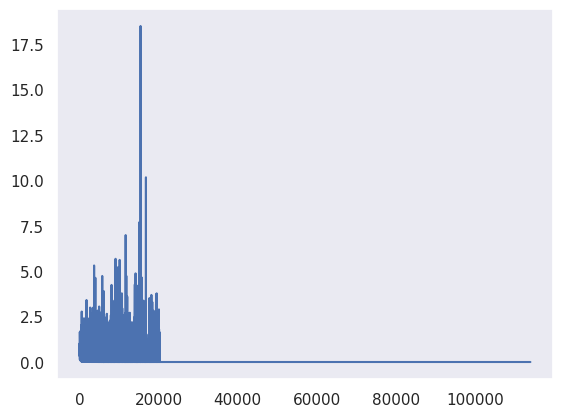

In [22]:
plt.plot(train_losses)

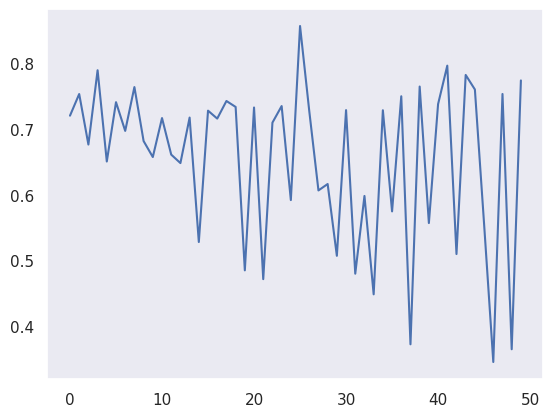

In [28]:
plt.plot(train_losses[:50])

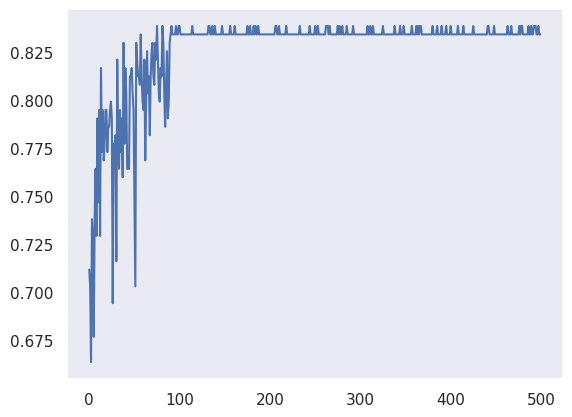

In [30]:
plt.plot(test_accuracy)

In [29]:
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    # if data.shape != torch.Size([64,1,20000]):
    #         continue
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 191/229 (0.8341)
tensor([[ 57,  24],
        [ 13, 134]], device='cuda:0')


In [31]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0110],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [32]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-3.9484e-25],
        [-1.8757e-25],
        [ 1.7836e-26],
        [ 3.0833e-26],
        [-1.9885e-26],
        [-4.5948e-26],
        [ 2.9061e-27],
        [-1.1491e-26],
        [ 2.3647e-26],
        [-2.3573e-29],
        [ 6.8136e-28],
        [ 1.6575e-28],
        [-1.5140e-28],
        [-8.3741e-29],
        [-3.9933e-29],
        [ 0.0000e+00],
        [ 3.3345e-25],
        [-1.6367e-24],
        [-3.4457e-27],
        [-6.8718e-27],
        [ 4.2966e-27],
        [ 2.1646e-27],
        [ 2.1635e-27],
        [-3.0056e-28],
        [-7.6298e-28],
        [-1.0555e-28],
        [-2.1107e-28],
        [ 4.0958e-28],
        [ 2.0827e-28],
        [ 2.7226e-28],
        [ 6.2069e-29],
        [ 0.0000e+00],
        [-3.0775e-25],
        [ 8.1950e-27],
        [-2.1420e-25],
        [ 1.0634e-25],
        [ 3.4926e-25],
        [ 2.6898e-26],
        [ 1.3942e-29],
        [-5.3450e-28],
        [ 1.0361e-27],
        [-4.7174e-28],
        [-3

[None, None, None]

In [33]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

Time domain: Filters' shapes vary by frequency bins


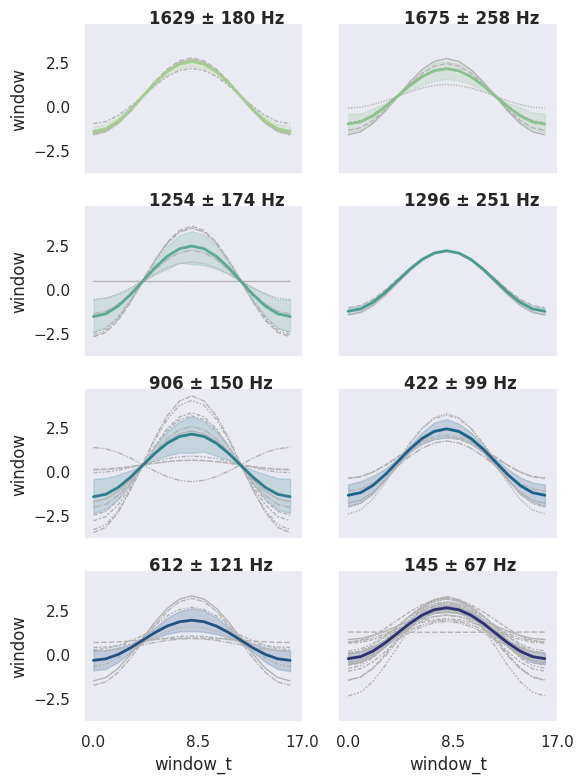

In [34]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


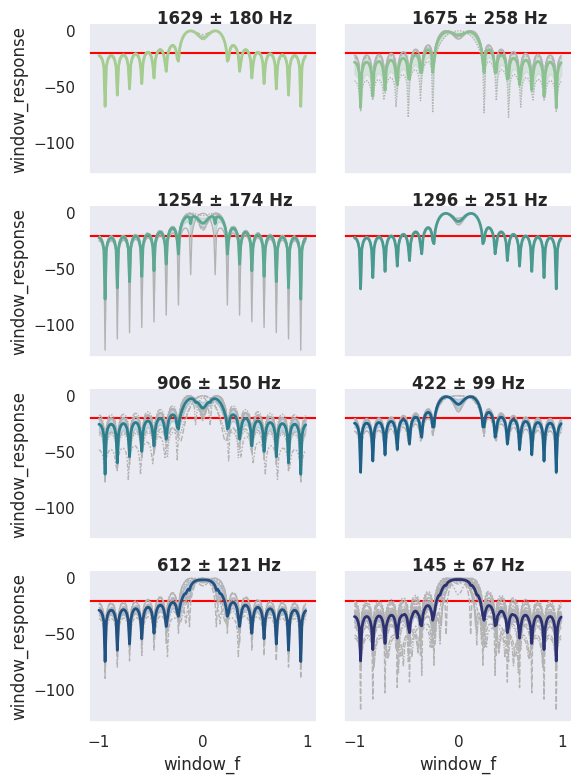

In [35]:
filtviz.visualize_filters(filter_domain='freq')

In [36]:
layer2 = model.fe_blocks.blocks[1].layer
downsample_factor = model.config.fe.stride[0]

In [37]:
[print(p.grad) for p in layer2.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.0925e-27, -4.2147e-27, -5.1635e-27,  ..., -4.7707e-27,
         -4.1942e-27, -4.7578e-27],
        [ 3.8029e-29,  2.5059e-28,  5.6121e-28,  ...,  1.5813e-28,
          1.3815e-28,  1.5790e-28],
        ...,
        [ 7.0303e-34, -5.5045e-31,  1.6833e-31,  ..., -1.3129e-32,
         -1.0042e-32, -1.2793e-32],
        [-1.3236e-29,  1.2037e-32, -2.5720e-29,  ..., -3.2433e-29,
         -2.9508e-29, -3.1083e-29],
        [-4.7299e-29,  6.3406e-31,  4.8367e-28,  ...,  3.0633e-28,
          2.8304e-28,  3.0584e-28]], device='cuda:0')
tensor([[ 7.5315e-28,  4.3078e-28, -3.5976e-27,  ..., -7.0293e-28,
         -6.7493e-28, -6.9760e-28],
        [ 8.5545e-28, -1.0455e-27,  4.1256e-28,  ..., -4.7518e-29,
         -2.8859e-29, -4.4047e-29],
        [ 1.8043e-30, -3.7834e-30, -1.6978e-30,  ..., -6.9440e-30,
         -6.0330e-30, -6.9725e-30],
        ...,
        [ 2.3277e-34,  6.2187

[None, None, None]

In [38]:
filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr // downsample_factor
)

Time domain: Filters' shapes vary by frequency bins


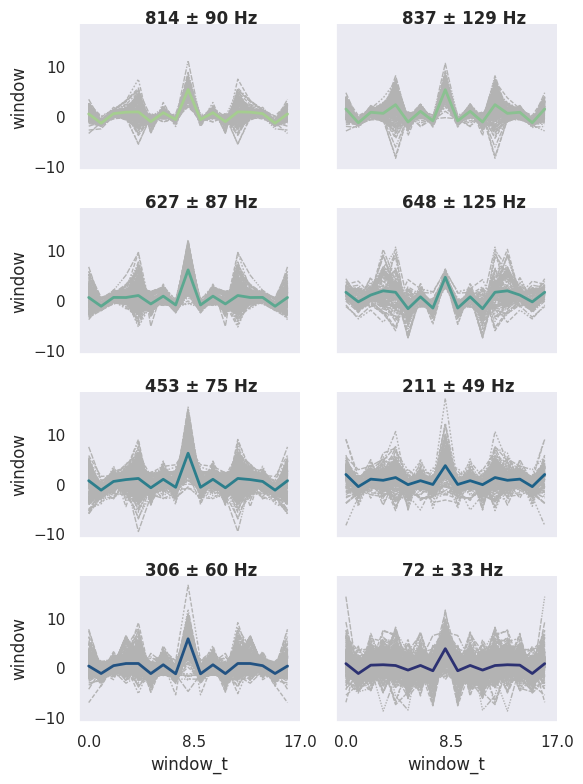

In [39]:
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


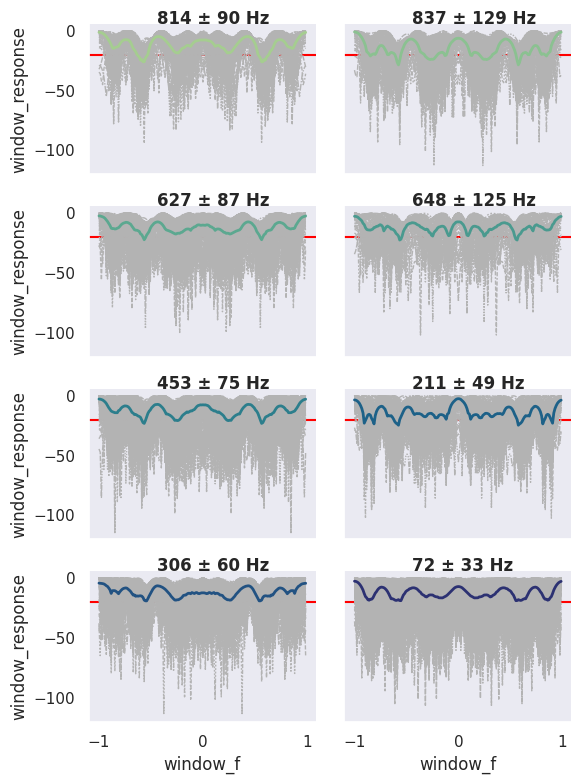

In [44]:
filtviz2.visualize_filters(filter_domain='freq')

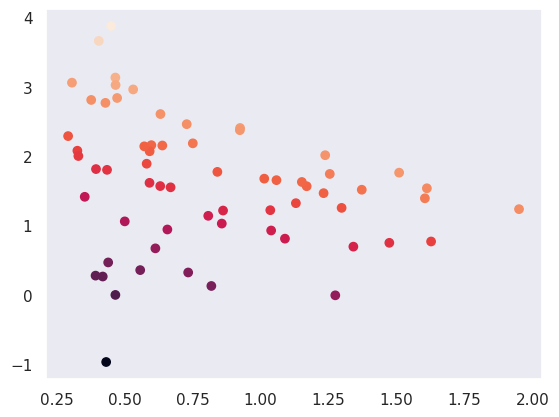

In [41]:
filtviz.visualize_window_params()

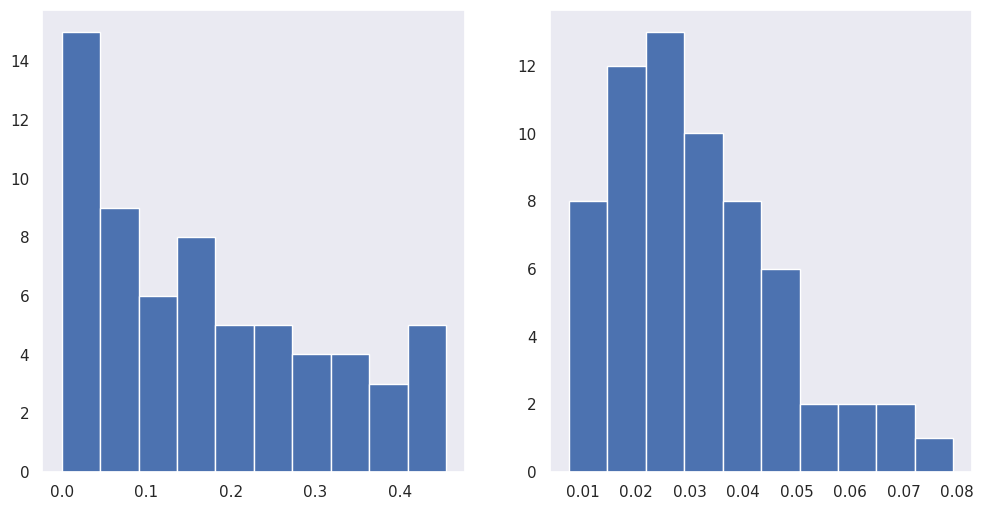

In [42]:
filtviz.visualize_bands()

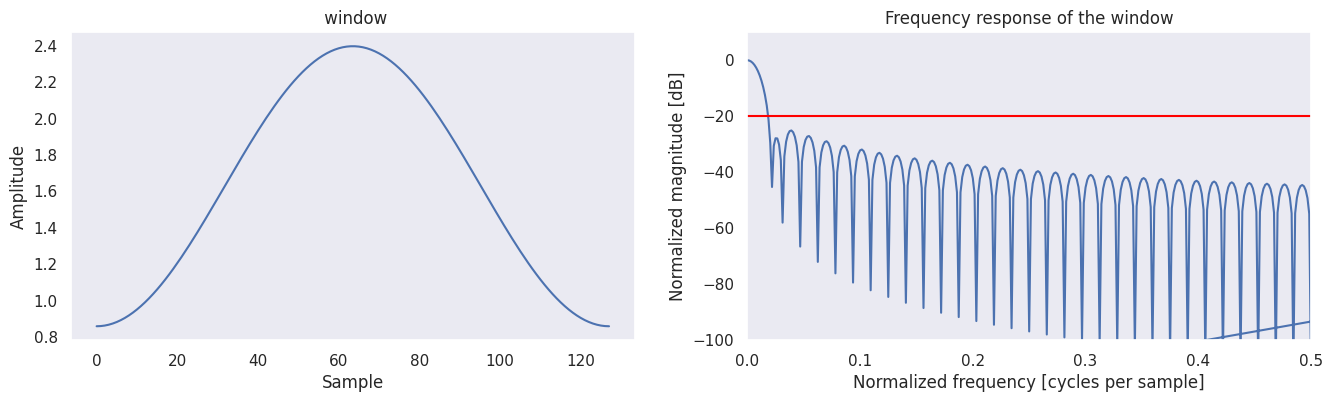

In [43]:
filtviz.visualize_one_window()

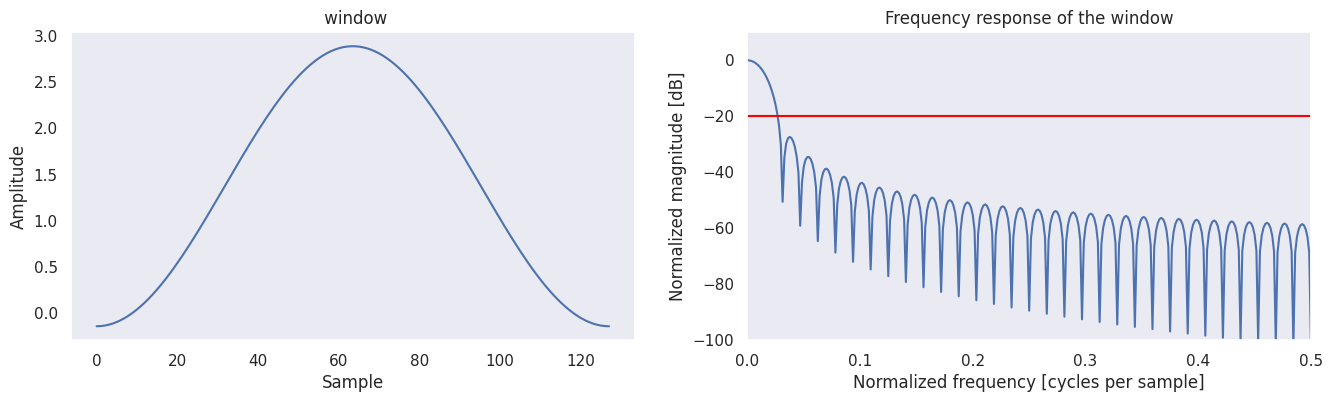

In [53]:
filtviz.visualize_one_window(n_out=20, n_inp=0)

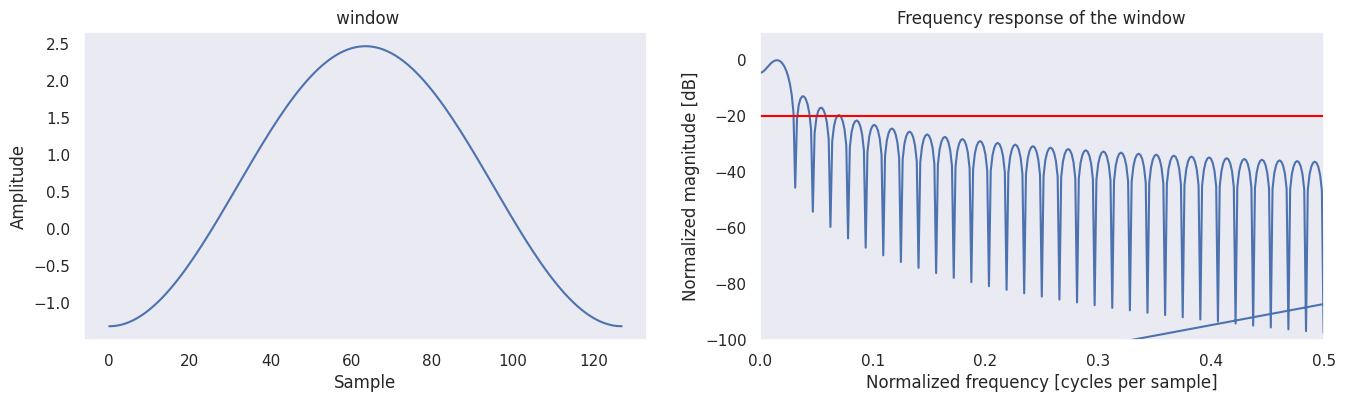

In [54]:
filtviz.visualize_one_window(n_out=30, n_inp=0)

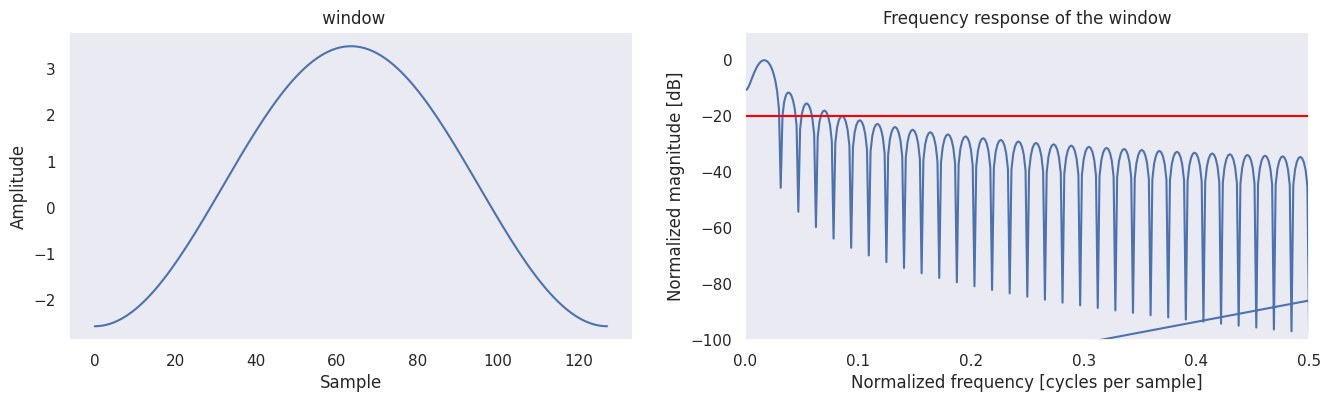

In [55]:
filtviz.visualize_one_window(n_out=60, n_inp=0)

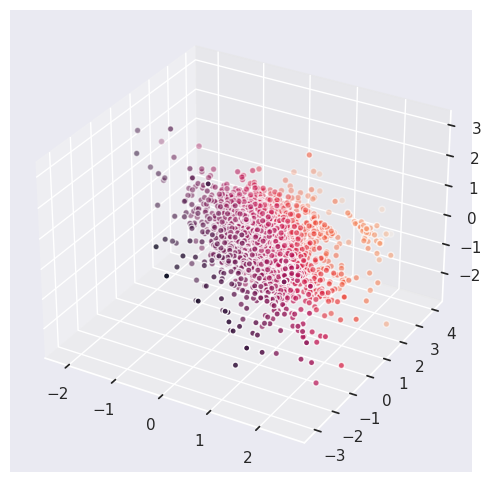

In [45]:
filtviz2.visualize_window_params()

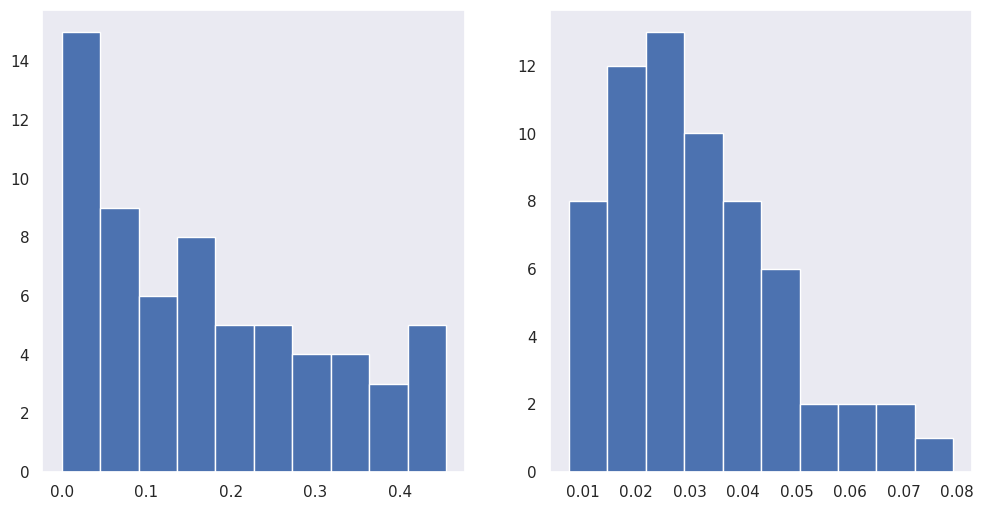

In [46]:
filtviz.visualize_bands()

In [47]:
[print(p.grad) for p in layer2.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.0925e-27, -4.2147e-27, -5.1635e-27,  ..., -4.7707e-27,
         -4.1942e-27, -4.7578e-27],
        [ 3.8029e-29,  2.5059e-28,  5.6121e-28,  ...,  1.5813e-28,
          1.3815e-28,  1.5790e-28],
        ...,
        [ 7.0303e-34, -5.5045e-31,  1.6833e-31,  ..., -1.3129e-32,
         -1.0042e-32, -1.2793e-32],
        [-1.3236e-29,  1.2037e-32, -2.5720e-29,  ..., -3.2433e-29,
         -2.9508e-29, -3.1083e-29],
        [-4.7299e-29,  6.3406e-31,  4.8367e-28,  ...,  3.0633e-28,
          2.8304e-28,  3.0584e-28]], device='cuda:0')
tensor([[ 7.5315e-28,  4.3078e-28, -3.5976e-27,  ..., -7.0293e-28,
         -6.7493e-28, -6.9760e-28],
        [ 8.5545e-28, -1.0455e-27,  4.1256e-28,  ..., -4.7518e-29,
         -2.8859e-29, -4.4047e-29],
        [ 1.8043e-30, -3.7834e-30, -1.6978e-30,  ..., -6.9440e-30,
         -6.0330e-30, -6.9725e-30],
        ...,
        [ 2.3277e-34,  6.2187

[None, None, None]

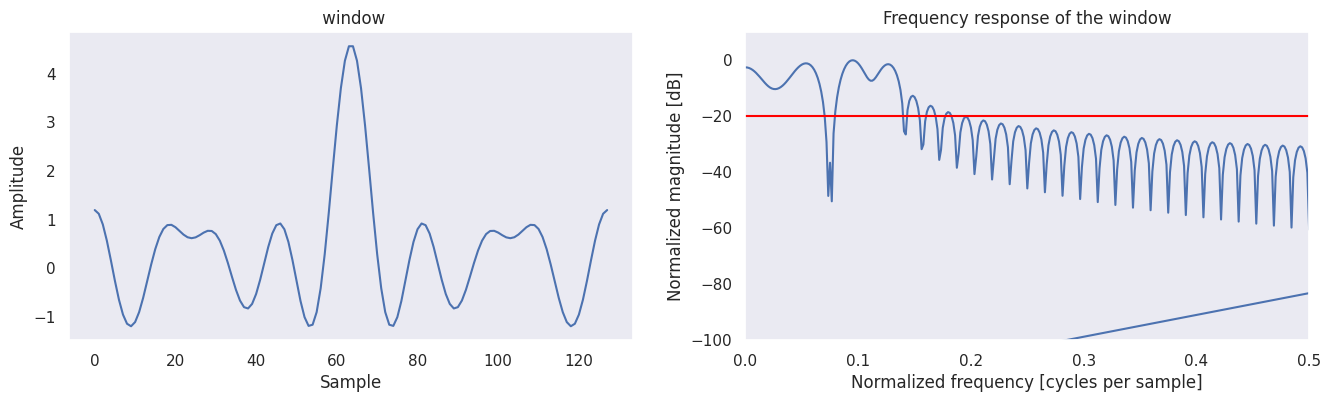

In [48]:
filtviz2.visualize_one_window()

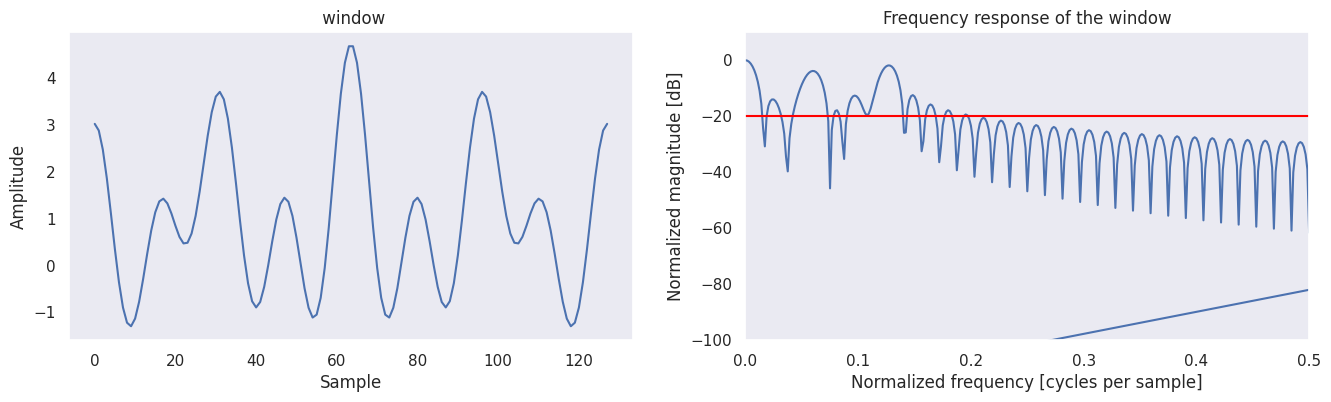

In [51]:
filtviz2.visualize_one_window(n_out=30, n_inp=60)

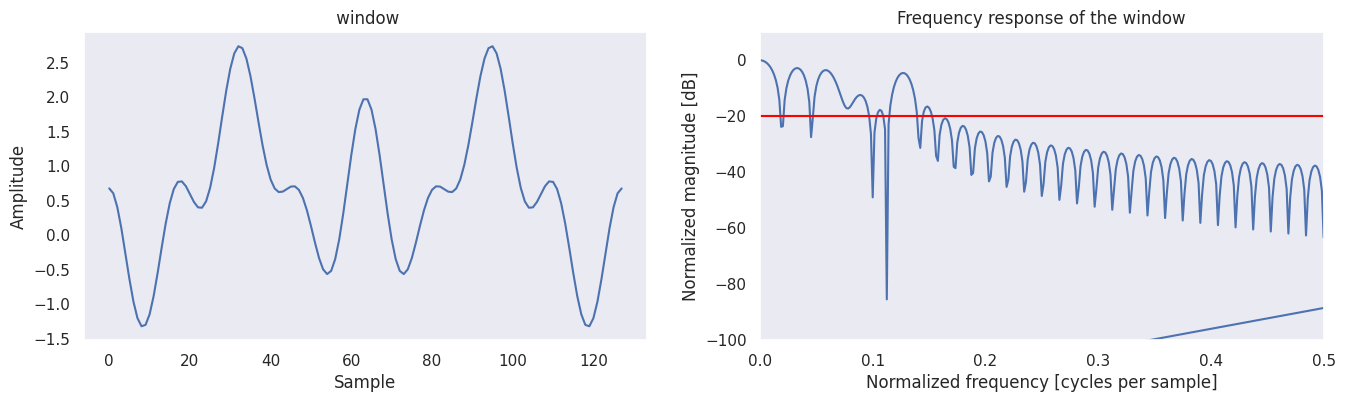

In [52]:
filtviz2.visualize_one_window(n_out=20, n_inp=20)

In [56]:
model_path = '../heartsound4k_m10_fftconv_500epochs.pt' 
torch.save(model.state_dict(), model_path)

In [57]:
model.to('cpu')

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [58]:
model2 = M10(config=model_config,
           n_input=1, n_output=2)
model2.load_state_dict(torch.load(model_path))
model2

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [59]:
model2.to(device)

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0): Sequential(
        (pad): ReplicationPad1d((0, 512))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
      (1): Sequential(
        (pad): ReplicationPad1d((0, 128))
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=128, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=128, bias=True)
      )


In [60]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [61]:
model2.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model2(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 191/229 (0.8341)
F1: 0.8377193212509155
UAP: 0.8311934471130371
WAP: 0.8377193212509155
UAR: 0.807634174823761
WAR: 0.8377193212509155
tensor([[ 57,  24],
        [ 13, 134]], device='cuda:0')
